In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter()

In [3]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [4]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,1,64,64))
test_set = test_set.reshape((-1,1,64,64))
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 1, 64, 64) (14392, 1) (3598, 1, 64, 64) (3598, 1)


In [7]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 1, 64, 64) (14392,) (3598, 1, 64, 64) (3598,)


In [8]:
# Hyper parameters
num_epochs = 300
num_classes = 4
batch_size = 64
learning_rate = 1e-3

In [9]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=batch_size) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

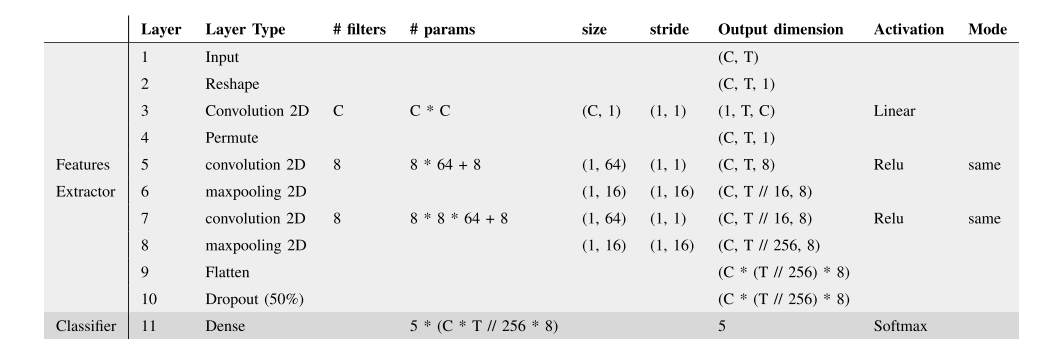

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [10]:
class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from Chambon et al 2018.

    Convolutional neural network for sleep staging described in [Chambon2018]_.

    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [Chambon2018]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [Chambon2018]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [Chambon2018]_ (16
        samples at sfreq=128).
    pad_size_s : float
        Padding size, in seconds. Set to 0.25 in [Chambon2018]_ (half the
        temporal convolution kernel size).
    input_size_s : float
        Size of the input, in seconds.
    n_classes : int
        Number of classes.
    dropout : float
        Dropout rate before the output dense layer.
    apply_batch_norm : bool
        If True, apply batch normalization after both temporal convolutional
        layers.
    return_feats : bool
        If True, return the features, i.e. the output of the feature extractor
        (before the final linear layer). If False, pass the features through
        the final linear layer.

    References
    ----------
    .. [Chambon2018] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels=64, sfreq=160, n_conv_chs=8, time_conv_size_s=0.1,
                 max_pool_size_s=0.1, pad_size_s=0.05, input_size_s=0.4,
                 n_classes=4, dropout=0.25, apply_batch_norm=False,
                 return_feats=False):
        super().__init__()

        time_conv_size = np.ceil(time_conv_size_s * sfreq).astype(int) #16
        max_pool_size = 2
        input_size = np.ceil(input_size_s * sfreq).astype(int) #64
        pad_size = np.ceil(pad_size_s * sfreq).astype(int) #8

        self.n_channels = n_channels
        
        self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))
    
        batch_norm = nn.BatchNorm2d if apply_batch_norm else nn.Identity
        
        self.feature_extractor = nn.Sequential(
            #b 1 64 64
            nn.Conv2d(1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            #b 8 64 65
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            #b 8 64 32
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, time_conv_size),padding=(0, pad_size)),
            #b 8 64 33
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            #b 8 64 16
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(8*64*16, n_classes)
        )
       

    def forward(self, x):
        """
        Forward pass.

        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        #b 1 64 64
        x = self.spatial_conv(x)
        #b 64 1 64
        x = x.transpose(1, 2)
        #b 1 64 64
        return self.feature_extractor(x)


In [11]:
model = SleepStagerChambon2018()
a = torch.randn((64,1,64,64))
b = model(a)
b.shape

torch.Size([64, 4])

In [12]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [13]:
model = SleepStagerChambon2018().to(device)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
milestones = [50,100,150,200,250]
milestones = [a * len(train_loader) for a in milestones]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

In [ ]:

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct=0
    total=0
    running_loss = 0
    for i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)


        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #scheduler.step() 
        #print(scheduler.get_last_lr()[0])

        optimizer.step()
        scheduler.step() 
        #print(optimizer.param_groups[0]["lr"])

        _, predicted = outputs.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()
        running_loss += loss.item()
        accu=100.*correct/total
        train_loss = running_loss/(i+1)
        print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(epoch+1, num_epochs, i+1, total_step, accu, train_loss))


        #writer.add_scalar(f'train/accuracy', accu, epoch)
        #writer.add_scalar(f'train/loss', train_loss, epoch)
        writer.add_scalars(f'train/accuracy_loss', {
            'accuracy': accu,
            'loss': train_loss,
        }, epoch)
        
        

Epoch [1/300], Step [1/225], Training Accuracy: 25.0000%, Training Loss: 1.3961%
Epoch [1/300], Step [2/225], Training Accuracy: 28.9062%, Training Loss: 1.4328%
Epoch [1/300], Step [3/225], Training Accuracy: 26.5625%, Training Loss: 1.4249%
Epoch [1/300], Step [4/225], Training Accuracy: 28.1250%, Training Loss: 1.4120%
Epoch [1/300], Step [5/225], Training Accuracy: 28.4375%, Training Loss: 1.4077%
Epoch [1/300], Step [6/225], Training Accuracy: 27.0833%, Training Loss: 1.4063%
Epoch [1/300], Step [7/225], Training Accuracy: 27.6786%, Training Loss: 1.4036%
Epoch [1/300], Step [8/225], Training Accuracy: 27.5391%, Training Loss: 1.4009%
Epoch [1/300], Step [9/225], Training Accuracy: 27.4306%, Training Loss: 1.3983%
Epoch [1/300], Step [10/225], Training Accuracy: 27.6562%, Training Loss: 1.3967%
Epoch [1/300], Step [11/225], Training Accuracy: 26.9886%, Training Loss: 1.3966%
Epoch [1/300], Step [12/225], Training Accuracy: 26.8229%, Training Loss: 1.3965%
Epoch [1/300], Step [13/2

Epoch [1/300], Step [120/225], Training Accuracy: 32.1875%, Training Loss: 1.3410%
Epoch [1/300], Step [121/225], Training Accuracy: 32.2701%, Training Loss: 1.3404%
Epoch [1/300], Step [122/225], Training Accuracy: 32.3002%, Training Loss: 1.3403%
Epoch [1/300], Step [123/225], Training Accuracy: 32.2663%, Training Loss: 1.3400%
Epoch [1/300], Step [124/225], Training Accuracy: 32.3085%, Training Loss: 1.3392%
Epoch [1/300], Step [125/225], Training Accuracy: 32.2875%, Training Loss: 1.3394%
Epoch [1/300], Step [126/225], Training Accuracy: 32.2545%, Training Loss: 1.3391%
Epoch [1/300], Step [127/225], Training Accuracy: 32.2466%, Training Loss: 1.3387%
Epoch [1/300], Step [128/225], Training Accuracy: 32.3486%, Training Loss: 1.3384%
Epoch [1/300], Step [129/225], Training Accuracy: 32.4007%, Training Loss: 1.3380%
Epoch [1/300], Step [130/225], Training Accuracy: 32.4639%, Training Loss: 1.3377%
Epoch [1/300], Step [131/225], Training Accuracy: 32.4427%, Training Loss: 1.3376%
Epoc

Epoch [2/300], Step [4/225], Training Accuracy: 42.9688%, Training Loss: 1.1831%
Epoch [2/300], Step [5/225], Training Accuracy: 43.7500%, Training Loss: 1.1746%
Epoch [2/300], Step [6/225], Training Accuracy: 42.7083%, Training Loss: 1.1961%
Epoch [2/300], Step [7/225], Training Accuracy: 43.3036%, Training Loss: 1.1937%
Epoch [2/300], Step [8/225], Training Accuracy: 42.9688%, Training Loss: 1.1966%
Epoch [2/300], Step [9/225], Training Accuracy: 42.8819%, Training Loss: 1.2010%
Epoch [2/300], Step [10/225], Training Accuracy: 43.5938%, Training Loss: 1.1970%
Epoch [2/300], Step [11/225], Training Accuracy: 43.8920%, Training Loss: 1.1912%
Epoch [2/300], Step [12/225], Training Accuracy: 43.6198%, Training Loss: 1.1925%
Epoch [2/300], Step [13/225], Training Accuracy: 44.2308%, Training Loss: 1.1918%
Epoch [2/300], Step [14/225], Training Accuracy: 43.8616%, Training Loss: 1.1948%
Epoch [2/300], Step [15/225], Training Accuracy: 43.8542%, Training Loss: 1.1982%
Epoch [2/300], Step [1

Epoch [2/300], Step [120/225], Training Accuracy: 46.0807%, Training Loss: 1.1435%
Epoch [2/300], Step [121/225], Training Accuracy: 46.0486%, Training Loss: 1.1435%
Epoch [2/300], Step [122/225], Training Accuracy: 46.0297%, Training Loss: 1.1430%
Epoch [2/300], Step [123/225], Training Accuracy: 46.0112%, Training Loss: 1.1432%
Epoch [2/300], Step [124/225], Training Accuracy: 46.1064%, Training Loss: 1.1421%
Epoch [2/300], Step [125/225], Training Accuracy: 46.0750%, Training Loss: 1.1424%
Epoch [2/300], Step [126/225], Training Accuracy: 46.0441%, Training Loss: 1.1426%
Epoch [2/300], Step [127/225], Training Accuracy: 46.0138%, Training Loss: 1.1424%
Epoch [2/300], Step [128/225], Training Accuracy: 46.0205%, Training Loss: 1.1418%
Epoch [2/300], Step [129/225], Training Accuracy: 46.0635%, Training Loss: 1.1413%
Epoch [2/300], Step [130/225], Training Accuracy: 46.0337%, Training Loss: 1.1415%
Epoch [2/300], Step [131/225], Training Accuracy: 46.0162%, Training Loss: 1.1415%
Epoc

Epoch [3/300], Step [14/225], Training Accuracy: 54.7991%, Training Loss: 0.9941%
Epoch [3/300], Step [15/225], Training Accuracy: 54.5833%, Training Loss: 1.0085%
Epoch [3/300], Step [16/225], Training Accuracy: 53.7109%, Training Loss: 1.0105%
Epoch [3/300], Step [17/225], Training Accuracy: 54.2279%, Training Loss: 1.0000%
Epoch [3/300], Step [18/225], Training Accuracy: 54.3403%, Training Loss: 0.9979%
Epoch [3/300], Step [19/225], Training Accuracy: 54.0296%, Training Loss: 0.9970%
Epoch [3/300], Step [20/225], Training Accuracy: 53.9844%, Training Loss: 0.9942%
Epoch [3/300], Step [21/225], Training Accuracy: 53.6458%, Training Loss: 0.9952%
Epoch [3/300], Step [22/225], Training Accuracy: 53.6222%, Training Loss: 0.9984%
Epoch [3/300], Step [23/225], Training Accuracy: 53.6685%, Training Loss: 0.9987%
Epoch [3/300], Step [24/225], Training Accuracy: 53.5156%, Training Loss: 1.0021%
Epoch [3/300], Step [25/225], Training Accuracy: 53.3750%, Training Loss: 1.0023%
Epoch [3/300], S

Epoch [3/300], Step [134/225], Training Accuracy: 54.6175%, Training Loss: 0.9764%
Epoch [3/300], Step [135/225], Training Accuracy: 54.6644%, Training Loss: 0.9758%
Epoch [3/300], Step [136/225], Training Accuracy: 54.7564%, Training Loss: 0.9747%
Epoch [3/300], Step [137/225], Training Accuracy: 54.7559%, Training Loss: 0.9738%
Epoch [3/300], Step [138/225], Training Accuracy: 54.8120%, Training Loss: 0.9726%
Epoch [3/300], Step [139/225], Training Accuracy: 54.7774%, Training Loss: 0.9726%
Epoch [3/300], Step [140/225], Training Accuracy: 54.7991%, Training Loss: 0.9734%
Epoch [3/300], Step [141/225], Training Accuracy: 54.7983%, Training Loss: 0.9726%
Epoch [3/300], Step [142/225], Training Accuracy: 54.8085%, Training Loss: 0.9726%
Epoch [3/300], Step [143/225], Training Accuracy: 54.7421%, Training Loss: 0.9725%
Epoch [3/300], Step [144/225], Training Accuracy: 54.7201%, Training Loss: 0.9723%
Epoch [3/300], Step [145/225], Training Accuracy: 54.7306%, Training Loss: 0.9720%
Epoc

Epoch [4/300], Step [30/225], Training Accuracy: 61.4583%, Training Loss: 0.8720%
Epoch [4/300], Step [31/225], Training Accuracy: 61.3407%, Training Loss: 0.8742%
Epoch [4/300], Step [32/225], Training Accuracy: 61.0840%, Training Loss: 0.8752%
Epoch [4/300], Step [33/225], Training Accuracy: 61.1742%, Training Loss: 0.8749%
Epoch [4/300], Step [34/225], Training Accuracy: 60.9375%, Training Loss: 0.8793%
Epoch [4/300], Step [35/225], Training Accuracy: 60.9375%, Training Loss: 0.8785%
Epoch [4/300], Step [36/225], Training Accuracy: 60.9809%, Training Loss: 0.8794%
Epoch [4/300], Step [37/225], Training Accuracy: 61.2753%, Training Loss: 0.8761%
Epoch [4/300], Step [38/225], Training Accuracy: 61.3487%, Training Loss: 0.8746%
Epoch [4/300], Step [39/225], Training Accuracy: 61.2580%, Training Loss: 0.8735%
Epoch [4/300], Step [40/225], Training Accuracy: 61.2500%, Training Loss: 0.8708%
Epoch [4/300], Step [41/225], Training Accuracy: 61.0899%, Training Loss: 0.8726%
Epoch [4/300], S

Epoch [4/300], Step [145/225], Training Accuracy: 60.8621%, Training Loss: 0.8664%
Epoch [4/300], Step [146/225], Training Accuracy: 60.8519%, Training Loss: 0.8666%
Epoch [4/300], Step [147/225], Training Accuracy: 60.8312%, Training Loss: 0.8675%
Epoch [4/300], Step [148/225], Training Accuracy: 60.9058%, Training Loss: 0.8663%
Epoch [4/300], Step [149/225], Training Accuracy: 60.9375%, Training Loss: 0.8654%
Epoch [4/300], Step [150/225], Training Accuracy: 60.9479%, Training Loss: 0.8651%
Epoch [4/300], Step [151/225], Training Accuracy: 60.9478%, Training Loss: 0.8646%
Epoch [4/300], Step [152/225], Training Accuracy: 60.9169%, Training Loss: 0.8649%
Epoch [4/300], Step [153/225], Training Accuracy: 60.9273%, Training Loss: 0.8644%
Epoch [4/300], Step [154/225], Training Accuracy: 60.8563%, Training Loss: 0.8648%
Epoch [4/300], Step [155/225], Training Accuracy: 60.8669%, Training Loss: 0.8648%
Epoch [4/300], Step [156/225], Training Accuracy: 60.9175%, Training Loss: 0.8652%
Epoc

Epoch [5/300], Step [39/225], Training Accuracy: 64.4631%, Training Loss: 0.8021%
Epoch [5/300], Step [40/225], Training Accuracy: 64.8047%, Training Loss: 0.7976%
Epoch [5/300], Step [41/225], Training Accuracy: 64.5579%, Training Loss: 0.7993%
Epoch [5/300], Step [42/225], Training Accuracy: 64.5833%, Training Loss: 0.7990%
Epoch [5/300], Step [43/225], Training Accuracy: 64.6076%, Training Loss: 0.7982%
Epoch [5/300], Step [44/225], Training Accuracy: 64.4531%, Training Loss: 0.7998%
Epoch [5/300], Step [45/225], Training Accuracy: 64.4444%, Training Loss: 0.7985%
Epoch [5/300], Step [46/225], Training Accuracy: 64.6060%, Training Loss: 0.7957%
Epoch [5/300], Step [47/225], Training Accuracy: 64.5279%, Training Loss: 0.7971%
Epoch [5/300], Step [48/225], Training Accuracy: 64.3229%, Training Loss: 0.7986%
Epoch [5/300], Step [49/225], Training Accuracy: 64.4133%, Training Loss: 0.7990%
Epoch [5/300], Step [50/225], Training Accuracy: 64.4375%, Training Loss: 0.7969%
Epoch [5/300], S

Epoch [5/300], Step [159/225], Training Accuracy: 64.5539%, Training Loss: 0.8026%
Epoch [5/300], Step [160/225], Training Accuracy: 64.5410%, Training Loss: 0.8026%
Epoch [5/300], Step [161/225], Training Accuracy: 64.5866%, Training Loss: 0.8019%
Epoch [5/300], Step [162/225], Training Accuracy: 64.6026%, Training Loss: 0.8020%
Epoch [5/300], Step [163/225], Training Accuracy: 64.6185%, Training Loss: 0.8013%
Epoch [5/300], Step [164/225], Training Accuracy: 64.6818%, Training Loss: 0.8009%
Epoch [5/300], Step [165/225], Training Accuracy: 64.6496%, Training Loss: 0.8006%
Epoch [5/300], Step [166/225], Training Accuracy: 64.6555%, Training Loss: 0.8002%
Epoch [5/300], Step [167/225], Training Accuracy: 64.6800%, Training Loss: 0.8003%
Epoch [5/300], Step [168/225], Training Accuracy: 64.6484%, Training Loss: 0.8007%
Epoch [5/300], Step [169/225], Training Accuracy: 64.6542%, Training Loss: 0.8003%
Epoch [5/300], Step [170/225], Training Accuracy: 64.6232%, Training Loss: 0.8003%
Epoc

Epoch [6/300], Step [59/225], Training Accuracy: 65.7574%, Training Loss: 0.7773%
Epoch [6/300], Step [60/225], Training Accuracy: 65.8854%, Training Loss: 0.7753%
Epoch [6/300], Step [61/225], Training Accuracy: 66.0861%, Training Loss: 0.7736%
Epoch [6/300], Step [62/225], Training Accuracy: 66.1542%, Training Loss: 0.7743%
Epoch [6/300], Step [63/225], Training Accuracy: 66.1706%, Training Loss: 0.7741%
Epoch [6/300], Step [64/225], Training Accuracy: 66.1377%, Training Loss: 0.7751%
Epoch [6/300], Step [65/225], Training Accuracy: 66.0817%, Training Loss: 0.7751%
Epoch [6/300], Step [66/225], Training Accuracy: 66.2169%, Training Loss: 0.7735%
Epoch [6/300], Step [67/225], Training Accuracy: 66.0681%, Training Loss: 0.7758%
Epoch [6/300], Step [68/225], Training Accuracy: 65.9467%, Training Loss: 0.7774%
Epoch [6/300], Step [69/225], Training Accuracy: 65.8741%, Training Loss: 0.7777%
Epoch [6/300], Step [70/225], Training Accuracy: 65.8482%, Training Loss: 0.7780%
Epoch [6/300], S

Epoch [6/300], Step [183/225], Training Accuracy: 66.5130%, Training Loss: 0.7606%
Epoch [6/300], Step [184/225], Training Accuracy: 66.5591%, Training Loss: 0.7604%
Epoch [6/300], Step [185/225], Training Accuracy: 66.6047%, Training Loss: 0.7597%
Epoch [6/300], Step [186/225], Training Accuracy: 66.6751%, Training Loss: 0.7583%
Epoch [6/300], Step [187/225], Training Accuracy: 66.7279%, Training Loss: 0.7574%
Epoch [6/300], Step [188/225], Training Accuracy: 66.7221%, Training Loss: 0.7573%
Epoch [6/300], Step [189/225], Training Accuracy: 66.7163%, Training Loss: 0.7574%
Epoch [6/300], Step [190/225], Training Accuracy: 66.7188%, Training Loss: 0.7573%
Epoch [6/300], Step [191/225], Training Accuracy: 66.6967%, Training Loss: 0.7578%
Epoch [6/300], Step [192/225], Training Accuracy: 66.7806%, Training Loss: 0.7568%
Epoch [6/300], Step [193/225], Training Accuracy: 66.7908%, Training Loss: 0.7563%
Epoch [6/300], Step [194/225], Training Accuracy: 66.7767%, Training Loss: 0.7562%
Epoc

Epoch [7/300], Step [65/225], Training Accuracy: 68.7740%, Training Loss: 0.7224%
Epoch [7/300], Step [66/225], Training Accuracy: 68.7737%, Training Loss: 0.7209%
Epoch [7/300], Step [67/225], Training Accuracy: 68.6101%, Training Loss: 0.7239%
Epoch [7/300], Step [68/225], Training Accuracy: 68.4972%, Training Loss: 0.7264%
Epoch [7/300], Step [69/225], Training Accuracy: 68.4783%, Training Loss: 0.7266%
Epoch [7/300], Step [70/225], Training Accuracy: 68.4821%, Training Loss: 0.7278%
Epoch [7/300], Step [71/225], Training Accuracy: 68.4199%, Training Loss: 0.7284%
Epoch [7/300], Step [72/225], Training Accuracy: 68.4679%, Training Loss: 0.7284%
Epoch [7/300], Step [73/225], Training Accuracy: 68.3647%, Training Loss: 0.7309%
Epoch [7/300], Step [74/225], Training Accuracy: 68.5177%, Training Loss: 0.7286%
Epoch [7/300], Step [75/225], Training Accuracy: 68.5625%, Training Loss: 0.7285%
Epoch [7/300], Step [76/225], Training Accuracy: 68.2771%, Training Loss: 0.7317%
Epoch [7/300], S

Epoch [7/300], Step [186/225], Training Accuracy: 68.9684%, Training Loss: 0.7128%
Epoch [7/300], Step [187/225], Training Accuracy: 68.9756%, Training Loss: 0.7124%
Epoch [7/300], Step [188/225], Training Accuracy: 68.9744%, Training Loss: 0.7121%
Epoch [7/300], Step [189/225], Training Accuracy: 68.9567%, Training Loss: 0.7119%
Epoch [7/300], Step [190/225], Training Accuracy: 68.9803%, Training Loss: 0.7117%
Epoch [7/300], Step [191/225], Training Accuracy: 68.9627%, Training Loss: 0.7119%
Epoch [7/300], Step [192/225], Training Accuracy: 69.0186%, Training Loss: 0.7109%
Epoch [7/300], Step [193/225], Training Accuracy: 69.0576%, Training Loss: 0.7102%
Epoch [7/300], Step [194/225], Training Accuracy: 69.0399%, Training Loss: 0.7101%
Epoch [7/300], Step [195/225], Training Accuracy: 69.0625%, Training Loss: 0.7097%
Epoch [7/300], Step [196/225], Training Accuracy: 69.0768%, Training Loss: 0.7094%
Epoch [7/300], Step [197/225], Training Accuracy: 69.0435%, Training Loss: 0.7097%
Epoc

Epoch [8/300], Step [72/225], Training Accuracy: 69.2491%, Training Loss: 0.6973%
Epoch [8/300], Step [73/225], Training Accuracy: 69.1139%, Training Loss: 0.6987%
Epoch [8/300], Step [74/225], Training Accuracy: 69.2990%, Training Loss: 0.6960%
Epoch [8/300], Step [75/225], Training Accuracy: 69.3333%, Training Loss: 0.6955%
Epoch [8/300], Step [76/225], Training Accuracy: 69.1201%, Training Loss: 0.6983%
Epoch [8/300], Step [77/225], Training Accuracy: 69.2573%, Training Loss: 0.6971%
Epoch [8/300], Step [78/225], Training Accuracy: 69.3109%, Training Loss: 0.6967%
Epoch [8/300], Step [79/225], Training Accuracy: 69.2247%, Training Loss: 0.6974%
Epoch [8/300], Step [80/225], Training Accuracy: 69.2188%, Training Loss: 0.6975%
Epoch [8/300], Step [81/225], Training Accuracy: 69.3094%, Training Loss: 0.6965%
Epoch [8/300], Step [82/225], Training Accuracy: 69.2835%, Training Loss: 0.6962%
Epoch [8/300], Step [83/225], Training Accuracy: 69.2959%, Training Loss: 0.6956%
Epoch [8/300], S

Epoch [8/300], Step [181/225], Training Accuracy: 69.7945%, Training Loss: 0.6881%
Epoch [8/300], Step [182/225], Training Accuracy: 69.8403%, Training Loss: 0.6878%
Epoch [8/300], Step [183/225], Training Accuracy: 69.8258%, Training Loss: 0.6880%
Epoch [8/300], Step [184/225], Training Accuracy: 69.7945%, Training Loss: 0.6878%
Epoch [8/300], Step [185/225], Training Accuracy: 69.8142%, Training Loss: 0.6875%
Epoch [8/300], Step [186/225], Training Accuracy: 69.8757%, Training Loss: 0.6863%
Epoch [8/300], Step [187/225], Training Accuracy: 69.8864%, Training Loss: 0.6857%
Epoch [8/300], Step [188/225], Training Accuracy: 69.9468%, Training Loss: 0.6851%
Epoch [8/300], Step [189/225], Training Accuracy: 69.9653%, Training Loss: 0.6853%
Epoch [8/300], Step [190/225], Training Accuracy: 69.9507%, Training Loss: 0.6854%
Epoch [8/300], Step [191/225], Training Accuracy: 69.9853%, Training Loss: 0.6851%
Epoch [8/300], Step [192/225], Training Accuracy: 70.0277%, Training Loss: 0.6844%
Epoc

Epoch [9/300], Step [73/225], Training Accuracy: 70.9546%, Training Loss: 0.6625%
Epoch [9/300], Step [74/225], Training Accuracy: 70.9882%, Training Loss: 0.6610%
Epoch [9/300], Step [75/225], Training Accuracy: 70.8750%, Training Loss: 0.6615%
Epoch [9/300], Step [76/225], Training Accuracy: 70.6414%, Training Loss: 0.6664%
Epoch [9/300], Step [77/225], Training Accuracy: 70.7183%, Training Loss: 0.6660%
Epoch [9/300], Step [78/225], Training Accuracy: 70.7532%, Training Loss: 0.6656%
Epoch [9/300], Step [79/225], Training Accuracy: 70.8070%, Training Loss: 0.6653%
Epoch [9/300], Step [80/225], Training Accuracy: 70.8008%, Training Loss: 0.6659%
Epoch [9/300], Step [81/225], Training Accuracy: 70.7755%, Training Loss: 0.6659%
Epoch [9/300], Step [82/225], Training Accuracy: 70.7698%, Training Loss: 0.6661%
Epoch [9/300], Step [83/225], Training Accuracy: 70.8396%, Training Loss: 0.6650%
Epoch [9/300], Step [84/225], Training Accuracy: 70.7961%, Training Loss: 0.6652%
Epoch [9/300], S

Epoch [9/300], Step [187/225], Training Accuracy: 71.3987%, Training Loss: 0.6612%
Epoch [9/300], Step [188/225], Training Accuracy: 71.4013%, Training Loss: 0.6612%
Epoch [9/300], Step [189/225], Training Accuracy: 71.3872%, Training Loss: 0.6613%
Epoch [9/300], Step [190/225], Training Accuracy: 71.3816%, Training Loss: 0.6613%
Epoch [9/300], Step [191/225], Training Accuracy: 71.4169%, Training Loss: 0.6608%
Epoch [9/300], Step [192/225], Training Accuracy: 71.4681%, Training Loss: 0.6598%
Epoch [9/300], Step [193/225], Training Accuracy: 71.5188%, Training Loss: 0.6598%
Epoch [9/300], Step [194/225], Training Accuracy: 71.4723%, Training Loss: 0.6600%
Epoch [9/300], Step [195/225], Training Accuracy: 71.5144%, Training Loss: 0.6599%
Epoch [9/300], Step [196/225], Training Accuracy: 71.5003%, Training Loss: 0.6603%
Epoch [9/300], Step [197/225], Training Accuracy: 71.4943%, Training Loss: 0.6602%
Epoch [9/300], Step [198/225], Training Accuracy: 71.5436%, Training Loss: 0.6598%
Epoc

Epoch [10/300], Step [74/225], Training Accuracy: 72.0017%, Training Loss: 0.6557%
Epoch [10/300], Step [75/225], Training Accuracy: 72.0000%, Training Loss: 0.6555%
Epoch [10/300], Step [76/225], Training Accuracy: 71.8750%, Training Loss: 0.6583%
Epoch [10/300], Step [77/225], Training Accuracy: 71.8547%, Training Loss: 0.6585%
Epoch [10/300], Step [78/225], Training Accuracy: 71.9351%, Training Loss: 0.6579%
Epoch [10/300], Step [79/225], Training Accuracy: 71.8552%, Training Loss: 0.6581%
Epoch [10/300], Step [80/225], Training Accuracy: 71.7969%, Training Loss: 0.6584%
Epoch [10/300], Step [81/225], Training Accuracy: 71.7785%, Training Loss: 0.6585%
Epoch [10/300], Step [82/225], Training Accuracy: 71.7988%, Training Loss: 0.6584%
Epoch [10/300], Step [83/225], Training Accuracy: 71.8562%, Training Loss: 0.6570%
Epoch [10/300], Step [84/225], Training Accuracy: 71.7448%, Training Loss: 0.6575%
Epoch [10/300], Step [85/225], Training Accuracy: 71.7831%, Training Loss: 0.6587%
Epoc

Epoch [10/300], Step [184/225], Training Accuracy: 72.0533%, Training Loss: 0.6517%
Epoch [10/300], Step [185/225], Training Accuracy: 72.1115%, Training Loss: 0.6510%
Epoch [10/300], Step [186/225], Training Accuracy: 72.1690%, Training Loss: 0.6498%
Epoch [10/300], Step [187/225], Training Accuracy: 72.2009%, Training Loss: 0.6492%
Epoch [10/300], Step [188/225], Training Accuracy: 72.2074%, Training Loss: 0.6486%
Epoch [10/300], Step [189/225], Training Accuracy: 72.1892%, Training Loss: 0.6486%
Epoch [10/300], Step [190/225], Training Accuracy: 72.1711%, Training Loss: 0.6485%
Epoch [10/300], Step [191/225], Training Accuracy: 72.1777%, Training Loss: 0.6481%
Epoch [10/300], Step [192/225], Training Accuracy: 72.2087%, Training Loss: 0.6473%
Epoch [10/300], Step [193/225], Training Accuracy: 72.2393%, Training Loss: 0.6467%
Epoch [10/300], Step [194/225], Training Accuracy: 72.2374%, Training Loss: 0.6464%
Epoch [10/300], Step [195/225], Training Accuracy: 72.2756%, Training Loss: 

Epoch [11/300], Step [69/225], Training Accuracy: 73.6639%, Training Loss: 0.6213%
Epoch [11/300], Step [70/225], Training Accuracy: 73.5714%, Training Loss: 0.6219%
Epoch [11/300], Step [71/225], Training Accuracy: 73.5695%, Training Loss: 0.6214%
Epoch [11/300], Step [72/225], Training Accuracy: 73.4158%, Training Loss: 0.6222%
Epoch [11/300], Step [73/225], Training Accuracy: 73.2663%, Training Loss: 0.6253%
Epoch [11/300], Step [74/225], Training Accuracy: 73.3108%, Training Loss: 0.6241%
Epoch [11/300], Step [75/225], Training Accuracy: 73.2292%, Training Loss: 0.6235%
Epoch [11/300], Step [76/225], Training Accuracy: 73.1086%, Training Loss: 0.6262%
Epoch [11/300], Step [77/225], Training Accuracy: 73.1534%, Training Loss: 0.6251%
Epoch [11/300], Step [78/225], Training Accuracy: 73.0970%, Training Loss: 0.6252%
Epoch [11/300], Step [79/225], Training Accuracy: 73.0617%, Training Loss: 0.6259%
Epoch [11/300], Step [80/225], Training Accuracy: 72.9688%, Training Loss: 0.6267%
Epoc

Epoch [11/300], Step [171/225], Training Accuracy: 73.4923%, Training Loss: 0.6208%
Epoch [11/300], Step [172/225], Training Accuracy: 73.5011%, Training Loss: 0.6214%
Epoch [11/300], Step [173/225], Training Accuracy: 73.4827%, Training Loss: 0.6213%
Epoch [11/300], Step [174/225], Training Accuracy: 73.5004%, Training Loss: 0.6211%
Epoch [11/300], Step [175/225], Training Accuracy: 73.5268%, Training Loss: 0.6208%
Epoch [11/300], Step [176/225], Training Accuracy: 73.5440%, Training Loss: 0.6208%
Epoch [11/300], Step [177/225], Training Accuracy: 73.5523%, Training Loss: 0.6204%
Epoch [11/300], Step [178/225], Training Accuracy: 73.5955%, Training Loss: 0.6195%
Epoch [11/300], Step [179/225], Training Accuracy: 73.6295%, Training Loss: 0.6189%
Epoch [11/300], Step [180/225], Training Accuracy: 73.6545%, Training Loss: 0.6182%
Epoch [11/300], Step [181/225], Training Accuracy: 73.6706%, Training Loss: 0.6193%
Epoch [11/300], Step [182/225], Training Accuracy: 73.6865%, Training Loss: 

Epoch [12/300], Step [65/225], Training Accuracy: 74.8558%, Training Loss: 0.5906%
Epoch [12/300], Step [66/225], Training Accuracy: 74.9527%, Training Loss: 0.5883%
Epoch [12/300], Step [67/225], Training Accuracy: 74.8134%, Training Loss: 0.5903%
Epoch [12/300], Step [68/225], Training Accuracy: 74.7472%, Training Loss: 0.5922%
Epoch [12/300], Step [69/225], Training Accuracy: 74.6377%, Training Loss: 0.5927%
Epoch [12/300], Step [70/225], Training Accuracy: 74.5759%, Training Loss: 0.5939%
Epoch [12/300], Step [71/225], Training Accuracy: 74.5819%, Training Loss: 0.5949%
Epoch [12/300], Step [72/225], Training Accuracy: 74.6094%, Training Loss: 0.5963%
Epoch [12/300], Step [73/225], Training Accuracy: 74.3365%, Training Loss: 0.5996%
Epoch [12/300], Step [74/225], Training Accuracy: 74.4510%, Training Loss: 0.5982%
Epoch [12/300], Step [75/225], Training Accuracy: 74.3542%, Training Loss: 0.5988%
Epoch [12/300], Step [76/225], Training Accuracy: 74.2393%, Training Loss: 0.6018%
Epoc

Epoch [12/300], Step [177/225], Training Accuracy: 74.3732%, Training Loss: 0.6031%
Epoch [12/300], Step [178/225], Training Accuracy: 74.4031%, Training Loss: 0.6026%
Epoch [12/300], Step [179/225], Training Accuracy: 74.3977%, Training Loss: 0.6024%
Epoch [12/300], Step [180/225], Training Accuracy: 74.4271%, Training Loss: 0.6013%
Epoch [12/300], Step [181/225], Training Accuracy: 74.4561%, Training Loss: 0.6017%
Epoch [12/300], Step [182/225], Training Accuracy: 74.4677%, Training Loss: 0.6012%
Epoch [12/300], Step [183/225], Training Accuracy: 74.4279%, Training Loss: 0.6018%
Epoch [12/300], Step [184/225], Training Accuracy: 74.4650%, Training Loss: 0.6014%
Epoch [12/300], Step [185/225], Training Accuracy: 74.5017%, Training Loss: 0.6011%
Epoch [12/300], Step [186/225], Training Accuracy: 74.5464%, Training Loss: 0.6003%
Epoch [12/300], Step [187/225], Training Accuracy: 74.5989%, Training Loss: 0.5997%
Epoch [12/300], Step [188/225], Training Accuracy: 74.6094%, Training Loss: 

Epoch [13/300], Step [62/225], Training Accuracy: 74.3700%, Training Loss: 0.5938%
Epoch [13/300], Step [63/225], Training Accuracy: 74.4792%, Training Loss: 0.5933%
Epoch [13/300], Step [64/225], Training Accuracy: 74.5850%, Training Loss: 0.5921%
Epoch [13/300], Step [65/225], Training Accuracy: 74.7115%, Training Loss: 0.5904%
Epoch [13/300], Step [66/225], Training Accuracy: 74.8106%, Training Loss: 0.5879%
Epoch [13/300], Step [67/225], Training Accuracy: 74.6269%, Training Loss: 0.5900%
Epoch [13/300], Step [68/225], Training Accuracy: 74.5864%, Training Loss: 0.5917%
Epoch [13/300], Step [69/225], Training Accuracy: 74.6377%, Training Loss: 0.5915%
Epoch [13/300], Step [70/225], Training Accuracy: 74.5089%, Training Loss: 0.5939%
Epoch [13/300], Step [71/225], Training Accuracy: 74.6259%, Training Loss: 0.5930%
Epoch [13/300], Step [72/225], Training Accuracy: 74.6094%, Training Loss: 0.5933%
Epoch [13/300], Step [73/225], Training Accuracy: 74.4863%, Training Loss: 0.5946%
Epoc

Epoch [13/300], Step [168/225], Training Accuracy: 75.2232%, Training Loss: 0.5856%
Epoch [13/300], Step [169/225], Training Accuracy: 75.2496%, Training Loss: 0.5850%
Epoch [13/300], Step [170/225], Training Accuracy: 75.2665%, Training Loss: 0.5847%
Epoch [13/300], Step [171/225], Training Accuracy: 75.2558%, Training Loss: 0.5848%
Epoch [13/300], Step [172/225], Training Accuracy: 75.2634%, Training Loss: 0.5853%
Epoch [13/300], Step [173/225], Training Accuracy: 75.2439%, Training Loss: 0.5852%
Epoch [13/300], Step [174/225], Training Accuracy: 75.2694%, Training Loss: 0.5846%
Epoch [13/300], Step [175/225], Training Accuracy: 75.3036%, Training Loss: 0.5842%
Epoch [13/300], Step [176/225], Training Accuracy: 75.2930%, Training Loss: 0.5842%
Epoch [13/300], Step [177/225], Training Accuracy: 75.2825%, Training Loss: 0.5844%
Epoch [13/300], Step [178/225], Training Accuracy: 75.3072%, Training Loss: 0.5838%
Epoch [13/300], Step [179/225], Training Accuracy: 75.3317%, Training Loss: 

Epoch [14/300], Step [57/225], Training Accuracy: 76.2336%, Training Loss: 0.5710%
Epoch [14/300], Step [58/225], Training Accuracy: 76.3200%, Training Loss: 0.5696%
Epoch [14/300], Step [59/225], Training Accuracy: 76.3506%, Training Loss: 0.5703%
Epoch [14/300], Step [60/225], Training Accuracy: 76.3802%, Training Loss: 0.5694%
Epoch [14/300], Step [61/225], Training Accuracy: 76.2807%, Training Loss: 0.5703%
Epoch [14/300], Step [62/225], Training Accuracy: 76.1845%, Training Loss: 0.5699%
Epoch [14/300], Step [63/225], Training Accuracy: 76.1905%, Training Loss: 0.5695%
Epoch [14/300], Step [64/225], Training Accuracy: 76.1719%, Training Loss: 0.5696%
Epoch [14/300], Step [65/225], Training Accuracy: 76.2981%, Training Loss: 0.5689%
Epoch [14/300], Step [66/225], Training Accuracy: 76.4678%, Training Loss: 0.5666%
Epoch [14/300], Step [67/225], Training Accuracy: 76.3759%, Training Loss: 0.5678%
Epoch [14/300], Step [68/225], Training Accuracy: 76.2868%, Training Loss: 0.5698%
Epoc

Epoch [14/300], Step [170/225], Training Accuracy: 75.4688%, Training Loss: 0.5781%
Epoch [14/300], Step [171/225], Training Accuracy: 75.4934%, Training Loss: 0.5780%
Epoch [14/300], Step [172/225], Training Accuracy: 75.4633%, Training Loss: 0.5788%
Epoch [14/300], Step [173/225], Training Accuracy: 75.4426%, Training Loss: 0.5789%
Epoch [14/300], Step [174/225], Training Accuracy: 75.4759%, Training Loss: 0.5783%
Epoch [14/300], Step [175/225], Training Accuracy: 75.5179%, Training Loss: 0.5780%
Epoch [14/300], Step [176/225], Training Accuracy: 75.4883%, Training Loss: 0.5782%
Epoch [14/300], Step [177/225], Training Accuracy: 75.4944%, Training Loss: 0.5785%
Epoch [14/300], Step [178/225], Training Accuracy: 75.5530%, Training Loss: 0.5773%
Epoch [14/300], Step [179/225], Training Accuracy: 75.5674%, Training Loss: 0.5769%
Epoch [14/300], Step [180/225], Training Accuracy: 75.5729%, Training Loss: 0.5762%
Epoch [14/300], Step [181/225], Training Accuracy: 75.5525%, Training Loss: 

Epoch [15/300], Step [54/225], Training Accuracy: 76.4757%, Training Loss: 0.5588%
Epoch [15/300], Step [55/225], Training Accuracy: 76.3068%, Training Loss: 0.5614%
Epoch [15/300], Step [56/225], Training Accuracy: 76.2835%, Training Loss: 0.5633%
Epoch [15/300], Step [57/225], Training Accuracy: 76.3158%, Training Loss: 0.5638%
Epoch [15/300], Step [58/225], Training Accuracy: 76.3200%, Training Loss: 0.5624%
Epoch [15/300], Step [59/225], Training Accuracy: 76.2447%, Training Loss: 0.5641%
Epoch [15/300], Step [60/225], Training Accuracy: 76.3802%, Training Loss: 0.5619%
Epoch [15/300], Step [61/225], Training Accuracy: 76.4344%, Training Loss: 0.5606%
Epoch [15/300], Step [62/225], Training Accuracy: 76.4113%, Training Loss: 0.5603%
Epoch [15/300], Step [63/225], Training Accuracy: 76.3641%, Training Loss: 0.5601%
Epoch [15/300], Step [64/225], Training Accuracy: 76.4893%, Training Loss: 0.5586%
Epoch [15/300], Step [65/225], Training Accuracy: 76.5865%, Training Loss: 0.5580%
Epoc

Epoch [15/300], Step [174/225], Training Accuracy: 76.6523%, Training Loss: 0.5581%
Epoch [15/300], Step [175/225], Training Accuracy: 76.6964%, Training Loss: 0.5576%
Epoch [15/300], Step [176/225], Training Accuracy: 76.7134%, Training Loss: 0.5574%
Epoch [15/300], Step [177/225], Training Accuracy: 76.7302%, Training Loss: 0.5573%
Epoch [15/300], Step [178/225], Training Accuracy: 76.7644%, Training Loss: 0.5563%
Epoch [15/300], Step [179/225], Training Accuracy: 76.7895%, Training Loss: 0.5559%
Epoch [15/300], Step [180/225], Training Accuracy: 76.8229%, Training Loss: 0.5552%
Epoch [15/300], Step [181/225], Training Accuracy: 76.8042%, Training Loss: 0.5562%
Epoch [15/300], Step [182/225], Training Accuracy: 76.7943%, Training Loss: 0.5563%
Epoch [15/300], Step [183/225], Training Accuracy: 76.7674%, Training Loss: 0.5565%
Epoch [15/300], Step [184/225], Training Accuracy: 76.8088%, Training Loss: 0.5559%
Epoch [15/300], Step [185/225], Training Accuracy: 76.8328%, Training Loss: 

Epoch [16/300], Step [73/225], Training Accuracy: 77.7397%, Training Loss: 0.5416%
Epoch [16/300], Step [74/225], Training Accuracy: 77.7872%, Training Loss: 0.5400%
Epoch [16/300], Step [75/225], Training Accuracy: 77.7083%, Training Loss: 0.5402%
Epoch [16/300], Step [76/225], Training Accuracy: 77.4260%, Training Loss: 0.5442%
Epoch [16/300], Step [77/225], Training Accuracy: 77.4351%, Training Loss: 0.5440%
Epoch [16/300], Step [78/225], Training Accuracy: 77.5240%, Training Loss: 0.5428%
Epoch [16/300], Step [79/225], Training Accuracy: 77.6305%, Training Loss: 0.5414%
Epoch [16/300], Step [80/225], Training Accuracy: 77.5781%, Training Loss: 0.5409%
Epoch [16/300], Step [81/225], Training Accuracy: 77.6620%, Training Loss: 0.5402%
Epoch [16/300], Step [82/225], Training Accuracy: 77.5724%, Training Loss: 0.5416%
Epoch [16/300], Step [83/225], Training Accuracy: 77.5791%, Training Loss: 0.5413%
Epoch [16/300], Step [84/225], Training Accuracy: 77.5484%, Training Loss: 0.5407%
Epoc

Epoch [16/300], Step [197/225], Training Accuracy: 77.3715%, Training Loss: 0.5376%
Epoch [16/300], Step [198/225], Training Accuracy: 77.4227%, Training Loss: 0.5371%
Epoch [16/300], Step [199/225], Training Accuracy: 77.4105%, Training Loss: 0.5371%
Epoch [16/300], Step [200/225], Training Accuracy: 77.4531%, Training Loss: 0.5365%
Epoch [16/300], Step [201/225], Training Accuracy: 77.4409%, Training Loss: 0.5367%
Epoch [16/300], Step [202/225], Training Accuracy: 77.4443%, Training Loss: 0.5365%
Epoch [16/300], Step [203/225], Training Accuracy: 77.3707%, Training Loss: 0.5377%
Epoch [16/300], Step [204/225], Training Accuracy: 77.4280%, Training Loss: 0.5369%
Epoch [16/300], Step [205/225], Training Accuracy: 77.4543%, Training Loss: 0.5361%
Epoch [16/300], Step [206/225], Training Accuracy: 77.4803%, Training Loss: 0.5360%
Epoch [16/300], Step [207/225], Training Accuracy: 77.4758%, Training Loss: 0.5356%
Epoch [16/300], Step [208/225], Training Accuracy: 77.4715%, Training Loss: 

Epoch [17/300], Step [92/225], Training Accuracy: 76.3077%, Training Loss: 0.5571%
Epoch [17/300], Step [93/225], Training Accuracy: 76.3105%, Training Loss: 0.5572%
Epoch [17/300], Step [94/225], Training Accuracy: 76.2965%, Training Loss: 0.5573%
Epoch [17/300], Step [95/225], Training Accuracy: 76.3816%, Training Loss: 0.5564%
Epoch [17/300], Step [96/225], Training Accuracy: 76.4648%, Training Loss: 0.5553%
Epoch [17/300], Step [97/225], Training Accuracy: 76.4981%, Training Loss: 0.5539%
Epoch [17/300], Step [98/225], Training Accuracy: 76.5306%, Training Loss: 0.5537%
Epoch [17/300], Step [99/225], Training Accuracy: 76.6256%, Training Loss: 0.5521%
Epoch [17/300], Step [100/225], Training Accuracy: 76.5156%, Training Loss: 0.5542%
Epoch [17/300], Step [101/225], Training Accuracy: 76.4697%, Training Loss: 0.5543%
Epoch [17/300], Step [102/225], Training Accuracy: 76.4706%, Training Loss: 0.5543%
Epoch [17/300], Step [103/225], Training Accuracy: 76.4867%, Training Loss: 0.5538%


Epoch [17/300], Step [211/225], Training Accuracy: 77.3326%, Training Loss: 0.5380%
Epoch [17/300], Step [212/225], Training Accuracy: 77.3143%, Training Loss: 0.5383%
Epoch [17/300], Step [213/225], Training Accuracy: 77.3107%, Training Loss: 0.5381%
Epoch [17/300], Step [214/225], Training Accuracy: 77.3438%, Training Loss: 0.5378%
Epoch [17/300], Step [215/225], Training Accuracy: 77.3401%, Training Loss: 0.5377%
Epoch [17/300], Step [216/225], Training Accuracy: 77.3438%, Training Loss: 0.5377%
Epoch [17/300], Step [217/225], Training Accuracy: 77.3474%, Training Loss: 0.5377%
Epoch [17/300], Step [218/225], Training Accuracy: 77.3079%, Training Loss: 0.5382%
Epoch [17/300], Step [219/225], Training Accuracy: 77.3259%, Training Loss: 0.5379%
Epoch [17/300], Step [220/225], Training Accuracy: 77.3366%, Training Loss: 0.5377%
Epoch [17/300], Step [221/225], Training Accuracy: 77.3261%, Training Loss: 0.5377%
Epoch [17/300], Step [222/225], Training Accuracy: 77.3508%, Training Loss: 

Epoch [18/300], Step [102/225], Training Accuracy: 78.7377%, Training Loss: 0.5210%
Epoch [18/300], Step [103/225], Training Accuracy: 78.7773%, Training Loss: 0.5202%
Epoch [18/300], Step [104/225], Training Accuracy: 78.7710%, Training Loss: 0.5197%
Epoch [18/300], Step [105/225], Training Accuracy: 78.7500%, Training Loss: 0.5200%
Epoch [18/300], Step [106/225], Training Accuracy: 78.6262%, Training Loss: 0.5236%
Epoch [18/300], Step [107/225], Training Accuracy: 78.6507%, Training Loss: 0.5238%
Epoch [18/300], Step [108/225], Training Accuracy: 78.5735%, Training Loss: 0.5246%
Epoch [18/300], Step [109/225], Training Accuracy: 78.5120%, Training Loss: 0.5250%
Epoch [18/300], Step [110/225], Training Accuracy: 78.5653%, Training Loss: 0.5232%
Epoch [18/300], Step [111/225], Training Accuracy: 78.6036%, Training Loss: 0.5229%
Epoch [18/300], Step [112/225], Training Accuracy: 78.5435%, Training Loss: 0.5227%
Epoch [18/300], Step [113/225], Training Accuracy: 78.5122%, Training Loss: 

Epoch [18/300], Step [213/225], Training Accuracy: 78.6092%, Training Loss: 0.5219%
Epoch [18/300], Step [214/225], Training Accuracy: 78.6142%, Training Loss: 0.5216%
Epoch [18/300], Step [215/225], Training Accuracy: 78.6410%, Training Loss: 0.5211%
Epoch [18/300], Step [216/225], Training Accuracy: 78.6748%, Training Loss: 0.5211%
Epoch [18/300], Step [217/225], Training Accuracy: 78.6794%, Training Loss: 0.5209%
Epoch [18/300], Step [218/225], Training Accuracy: 78.6267%, Training Loss: 0.5216%
Epoch [18/300], Step [219/225], Training Accuracy: 78.6173%, Training Loss: 0.5216%
Epoch [18/300], Step [220/225], Training Accuracy: 78.6151%, Training Loss: 0.5216%
Epoch [18/300], Step [221/225], Training Accuracy: 78.6058%, Training Loss: 0.5219%
Epoch [18/300], Step [222/225], Training Accuracy: 78.6106%, Training Loss: 0.5220%
Epoch [18/300], Step [223/225], Training Accuracy: 78.5945%, Training Loss: 0.5223%
Epoch [18/300], Step [224/225], Training Accuracy: 78.6133%, Training Loss: 

Epoch [19/300], Step [109/225], Training Accuracy: 78.5407%, Training Loss: 0.5245%
Epoch [19/300], Step [110/225], Training Accuracy: 78.6080%, Training Loss: 0.5230%
Epoch [19/300], Step [111/225], Training Accuracy: 78.6177%, Training Loss: 0.5225%
Epoch [19/300], Step [112/225], Training Accuracy: 78.5296%, Training Loss: 0.5226%
Epoch [19/300], Step [113/225], Training Accuracy: 78.5260%, Training Loss: 0.5225%
Epoch [19/300], Step [114/225], Training Accuracy: 78.4814%, Training Loss: 0.5225%
Epoch [19/300], Step [115/225], Training Accuracy: 78.5054%, Training Loss: 0.5224%
Epoch [19/300], Step [116/225], Training Accuracy: 78.4483%, Training Loss: 0.5231%
Epoch [19/300], Step [117/225], Training Accuracy: 78.4455%, Training Loss: 0.5235%
Epoch [19/300], Step [118/225], Training Accuracy: 78.4296%, Training Loss: 0.5235%
Epoch [19/300], Step [119/225], Training Accuracy: 78.4533%, Training Loss: 0.5229%
Epoch [19/300], Step [120/225], Training Accuracy: 78.4896%, Training Loss: 

Epoch [19/300], Step [219/225], Training Accuracy: 79.1952%, Training Loss: 0.5088%
Epoch [19/300], Step [220/225], Training Accuracy: 79.2259%, Training Loss: 0.5087%
Epoch [19/300], Step [221/225], Training Accuracy: 79.1926%, Training Loss: 0.5096%
Epoch [19/300], Step [222/225], Training Accuracy: 79.1948%, Training Loss: 0.5098%
Epoch [19/300], Step [223/225], Training Accuracy: 79.1970%, Training Loss: 0.5102%
Epoch [19/300], Step [224/225], Training Accuracy: 79.2271%, Training Loss: 0.5096%
Epoch [19/300], Step [225/225], Training Accuracy: 79.2385%, Training Loss: 0.5096%
Epoch [20/300], Step [1/225], Training Accuracy: 87.5000%, Training Loss: 0.3869%
Epoch [20/300], Step [2/225], Training Accuracy: 84.3750%, Training Loss: 0.4952%
Epoch [20/300], Step [3/225], Training Accuracy: 81.7708%, Training Loss: 0.5674%
Epoch [20/300], Step [4/225], Training Accuracy: 81.2500%, Training Loss: 0.5408%
Epoch [20/300], Step [5/225], Training Accuracy: 82.8125%, Training Loss: 0.4975%
Ep

Epoch [20/300], Step [115/225], Training Accuracy: 79.5788%, Training Loss: 0.5022%
Epoch [20/300], Step [116/225], Training Accuracy: 79.5528%, Training Loss: 0.5024%
Epoch [20/300], Step [117/225], Training Accuracy: 79.5673%, Training Loss: 0.5026%
Epoch [20/300], Step [118/225], Training Accuracy: 79.6081%, Training Loss: 0.5019%
Epoch [20/300], Step [119/225], Training Accuracy: 79.5693%, Training Loss: 0.5026%
Epoch [20/300], Step [120/225], Training Accuracy: 79.6094%, Training Loss: 0.5021%
Epoch [20/300], Step [121/225], Training Accuracy: 79.5713%, Training Loss: 0.5027%
Epoch [20/300], Step [122/225], Training Accuracy: 79.5850%, Training Loss: 0.5027%
Epoch [20/300], Step [123/225], Training Accuracy: 79.5859%, Training Loss: 0.5028%
Epoch [20/300], Step [124/225], Training Accuracy: 79.6245%, Training Loss: 0.5018%
Epoch [20/300], Step [125/225], Training Accuracy: 79.6625%, Training Loss: 0.5014%
Epoch [20/300], Step [126/225], Training Accuracy: 79.6379%, Training Loss: 

Epoch [21/300], Step [15/225], Training Accuracy: 78.8542%, Training Loss: 0.5086%
Epoch [21/300], Step [16/225], Training Accuracy: 79.1016%, Training Loss: 0.5059%
Epoch [21/300], Step [17/225], Training Accuracy: 79.3199%, Training Loss: 0.5026%
Epoch [21/300], Step [18/225], Training Accuracy: 79.0799%, Training Loss: 0.5105%
Epoch [21/300], Step [19/225], Training Accuracy: 78.6184%, Training Loss: 0.5157%
Epoch [21/300], Step [20/225], Training Accuracy: 78.9062%, Training Loss: 0.5093%
Epoch [21/300], Step [21/225], Training Accuracy: 79.0179%, Training Loss: 0.5044%
Epoch [21/300], Step [22/225], Training Accuracy: 78.7642%, Training Loss: 0.5104%
Epoch [21/300], Step [23/225], Training Accuracy: 78.8043%, Training Loss: 0.5097%
Epoch [21/300], Step [24/225], Training Accuracy: 78.9062%, Training Loss: 0.5105%
Epoch [21/300], Step [25/225], Training Accuracy: 79.0625%, Training Loss: 0.5096%
Epoch [21/300], Step [26/225], Training Accuracy: 78.7861%, Training Loss: 0.5131%
Epoc

Epoch [21/300], Step [138/225], Training Accuracy: 80.0045%, Training Loss: 0.4921%
Epoch [21/300], Step [139/225], Training Accuracy: 79.9348%, Training Loss: 0.4929%
Epoch [21/300], Step [140/225], Training Accuracy: 79.9442%, Training Loss: 0.4922%
Epoch [21/300], Step [141/225], Training Accuracy: 79.9091%, Training Loss: 0.4927%
Epoch [21/300], Step [142/225], Training Accuracy: 79.8966%, Training Loss: 0.4931%
Epoch [21/300], Step [143/225], Training Accuracy: 79.9170%, Training Loss: 0.4923%
Epoch [21/300], Step [144/225], Training Accuracy: 79.9262%, Training Loss: 0.4920%
Epoch [21/300], Step [145/225], Training Accuracy: 79.9784%, Training Loss: 0.4913%
Epoch [21/300], Step [146/225], Training Accuracy: 79.9336%, Training Loss: 0.4920%
Epoch [21/300], Step [147/225], Training Accuracy: 79.8895%, Training Loss: 0.4926%
Epoch [21/300], Step [148/225], Training Accuracy: 79.9514%, Training Loss: 0.4918%
Epoch [21/300], Step [149/225], Training Accuracy: 79.9182%, Training Loss: 

Epoch [22/300], Step [35/225], Training Accuracy: 80.4018%, Training Loss: 0.5026%
Epoch [22/300], Step [36/225], Training Accuracy: 80.2083%, Training Loss: 0.5066%
Epoch [22/300], Step [37/225], Training Accuracy: 80.0253%, Training Loss: 0.5075%
Epoch [22/300], Step [38/225], Training Accuracy: 80.0987%, Training Loss: 0.5088%
Epoch [22/300], Step [39/225], Training Accuracy: 80.2083%, Training Loss: 0.5063%
Epoch [22/300], Step [40/225], Training Accuracy: 80.2734%, Training Loss: 0.5044%
Epoch [22/300], Step [41/225], Training Accuracy: 80.2973%, Training Loss: 0.5044%
Epoch [22/300], Step [42/225], Training Accuracy: 80.2455%, Training Loss: 0.5057%
Epoch [22/300], Step [43/225], Training Accuracy: 80.1962%, Training Loss: 0.5052%
Epoch [22/300], Step [44/225], Training Accuracy: 80.1136%, Training Loss: 0.5065%
Epoch [22/300], Step [45/225], Training Accuracy: 80.1736%, Training Loss: 0.5046%
Epoch [22/300], Step [46/225], Training Accuracy: 80.3668%, Training Loss: 0.5005%
Epoc

Epoch [22/300], Step [154/225], Training Accuracy: 80.4586%, Training Loss: 0.4844%
Epoch [22/300], Step [155/225], Training Accuracy: 80.5040%, Training Loss: 0.4841%
Epoch [22/300], Step [156/225], Training Accuracy: 80.4988%, Training Loss: 0.4841%
Epoch [22/300], Step [157/225], Training Accuracy: 80.5036%, Training Loss: 0.4842%
Epoch [22/300], Step [158/225], Training Accuracy: 80.4786%, Training Loss: 0.4852%
Epoch [22/300], Step [159/225], Training Accuracy: 80.4245%, Training Loss: 0.4863%
Epoch [22/300], Step [160/225], Training Accuracy: 80.4102%, Training Loss: 0.4863%
Epoch [22/300], Step [161/225], Training Accuracy: 80.4154%, Training Loss: 0.4857%
Epoch [22/300], Step [162/225], Training Accuracy: 80.4109%, Training Loss: 0.4852%
Epoch [22/300], Step [163/225], Training Accuracy: 80.4160%, Training Loss: 0.4848%
Epoch [22/300], Step [164/225], Training Accuracy: 80.4497%, Training Loss: 0.4838%
Epoch [22/300], Step [165/225], Training Accuracy: 80.4167%, Training Loss: 

Epoch [23/300], Step [54/225], Training Accuracy: 82.1181%, Training Loss: 0.4721%
Epoch [23/300], Step [55/225], Training Accuracy: 82.0455%, Training Loss: 0.4731%
Epoch [23/300], Step [56/225], Training Accuracy: 82.0871%, Training Loss: 0.4750%
Epoch [23/300], Step [57/225], Training Accuracy: 82.1546%, Training Loss: 0.4734%
Epoch [23/300], Step [58/225], Training Accuracy: 82.1121%, Training Loss: 0.4740%
Epoch [23/300], Step [59/225], Training Accuracy: 81.9915%, Training Loss: 0.4760%
Epoch [23/300], Step [60/225], Training Accuracy: 82.0573%, Training Loss: 0.4743%
Epoch [23/300], Step [61/225], Training Accuracy: 81.9928%, Training Loss: 0.4749%
Epoch [23/300], Step [62/225], Training Accuracy: 81.9808%, Training Loss: 0.4748%
Epoch [23/300], Step [63/225], Training Accuracy: 81.8700%, Training Loss: 0.4761%
Epoch [23/300], Step [64/225], Training Accuracy: 81.9336%, Training Loss: 0.4743%
Epoch [23/300], Step [65/225], Training Accuracy: 82.0673%, Training Loss: 0.4722%
Epoc

Epoch [23/300], Step [177/225], Training Accuracy: 81.2765%, Training Loss: 0.4744%
Epoch [23/300], Step [178/225], Training Accuracy: 81.2500%, Training Loss: 0.4743%
Epoch [23/300], Step [179/225], Training Accuracy: 81.2762%, Training Loss: 0.4740%
Epoch [23/300], Step [180/225], Training Accuracy: 81.2760%, Training Loss: 0.4733%
Epoch [23/300], Step [181/225], Training Accuracy: 81.2586%, Training Loss: 0.4739%
Epoch [23/300], Step [182/225], Training Accuracy: 81.2414%, Training Loss: 0.4738%
Epoch [23/300], Step [183/225], Training Accuracy: 81.2500%, Training Loss: 0.4735%
Epoch [23/300], Step [184/225], Training Accuracy: 81.2755%, Training Loss: 0.4731%
Epoch [23/300], Step [185/225], Training Accuracy: 81.3007%, Training Loss: 0.4729%
Epoch [23/300], Step [186/225], Training Accuracy: 81.3172%, Training Loss: 0.4724%
Epoch [23/300], Step [187/225], Training Accuracy: 81.3085%, Training Loss: 0.4722%
Epoch [23/300], Step [188/225], Training Accuracy: 81.3165%, Training Loss: 

Epoch [24/300], Step [74/225], Training Accuracy: 80.6799%, Training Loss: 0.4775%
Epoch [24/300], Step [75/225], Training Accuracy: 80.6667%, Training Loss: 0.4778%
Epoch [24/300], Step [76/225], Training Accuracy: 80.5921%, Training Loss: 0.4788%
Epoch [24/300], Step [77/225], Training Accuracy: 80.6818%, Training Loss: 0.4788%
Epoch [24/300], Step [78/225], Training Accuracy: 80.7692%, Training Loss: 0.4775%
Epoch [24/300], Step [79/225], Training Accuracy: 80.7753%, Training Loss: 0.4779%
Epoch [24/300], Step [80/225], Training Accuracy: 80.8789%, Training Loss: 0.4776%
Epoch [24/300], Step [81/225], Training Accuracy: 80.8449%, Training Loss: 0.4770%
Epoch [24/300], Step [82/225], Training Accuracy: 80.7927%, Training Loss: 0.4775%
Epoch [24/300], Step [83/225], Training Accuracy: 80.7417%, Training Loss: 0.4774%
Epoch [24/300], Step [84/225], Training Accuracy: 80.8036%, Training Loss: 0.4774%
Epoch [24/300], Step [85/225], Training Accuracy: 80.8824%, Training Loss: 0.4759%
Epoc

Epoch [24/300], Step [196/225], Training Accuracy: 81.1862%, Training Loss: 0.4680%
Epoch [24/300], Step [197/225], Training Accuracy: 81.1945%, Training Loss: 0.4683%
Epoch [24/300], Step [198/225], Training Accuracy: 81.2421%, Training Loss: 0.4677%
Epoch [24/300], Step [199/225], Training Accuracy: 81.2264%, Training Loss: 0.4678%
Epoch [24/300], Step [200/225], Training Accuracy: 81.2891%, Training Loss: 0.4670%
Epoch [24/300], Step [201/225], Training Accuracy: 81.2733%, Training Loss: 0.4669%
Epoch [24/300], Step [202/225], Training Accuracy: 81.2655%, Training Loss: 0.4667%
Epoch [24/300], Step [203/225], Training Accuracy: 81.2654%, Training Loss: 0.4669%
Epoch [24/300], Step [204/225], Training Accuracy: 81.3036%, Training Loss: 0.4662%
Epoch [24/300], Step [205/225], Training Accuracy: 81.3415%, Training Loss: 0.4655%
Epoch [24/300], Step [206/225], Training Accuracy: 81.3714%, Training Loss: 0.4653%
Epoch [24/300], Step [207/225], Training Accuracy: 81.3632%, Training Loss: 

Epoch [25/300], Step [84/225], Training Accuracy: 82.0126%, Training Loss: 0.4472%
Epoch [25/300], Step [85/225], Training Accuracy: 82.0956%, Training Loss: 0.4464%
Epoch [25/300], Step [86/225], Training Accuracy: 82.1039%, Training Loss: 0.4467%
Epoch [25/300], Step [87/225], Training Accuracy: 82.0402%, Training Loss: 0.4464%
Epoch [25/300], Step [88/225], Training Accuracy: 81.9957%, Training Loss: 0.4473%
Epoch [25/300], Step [89/225], Training Accuracy: 82.0049%, Training Loss: 0.4471%
Epoch [25/300], Step [90/225], Training Accuracy: 82.0660%, Training Loss: 0.4456%
Epoch [25/300], Step [91/225], Training Accuracy: 82.0742%, Training Loss: 0.4455%
Epoch [25/300], Step [92/225], Training Accuracy: 82.0312%, Training Loss: 0.4458%
Epoch [25/300], Step [93/225], Training Accuracy: 82.0565%, Training Loss: 0.4452%
Epoch [25/300], Step [94/225], Training Accuracy: 82.0977%, Training Loss: 0.4444%
Epoch [25/300], Step [95/225], Training Accuracy: 82.1217%, Training Loss: 0.4435%
Epoc

Epoch [25/300], Step [192/225], Training Accuracy: 82.1126%, Training Loss: 0.4493%
Epoch [25/300], Step [193/225], Training Accuracy: 82.1082%, Training Loss: 0.4493%
Epoch [25/300], Step [194/225], Training Accuracy: 82.0957%, Training Loss: 0.4492%
Epoch [25/300], Step [195/225], Training Accuracy: 82.0833%, Training Loss: 0.4490%
Epoch [25/300], Step [196/225], Training Accuracy: 82.1110%, Training Loss: 0.4486%
Epoch [25/300], Step [197/225], Training Accuracy: 82.0590%, Training Loss: 0.4489%
Epoch [25/300], Step [198/225], Training Accuracy: 82.0865%, Training Loss: 0.4487%
Epoch [25/300], Step [199/225], Training Accuracy: 82.0430%, Training Loss: 0.4494%
Epoch [25/300], Step [200/225], Training Accuracy: 82.0703%, Training Loss: 0.4490%
Epoch [25/300], Step [201/225], Training Accuracy: 82.0896%, Training Loss: 0.4488%
Epoch [25/300], Step [202/225], Training Accuracy: 82.1086%, Training Loss: 0.4486%
Epoch [25/300], Step [203/225], Training Accuracy: 82.0813%, Training Loss: 

Epoch [26/300], Step [86/225], Training Accuracy: 81.4680%, Training Loss: 0.4552%
Epoch [26/300], Step [87/225], Training Accuracy: 81.4476%, Training Loss: 0.4549%
Epoch [26/300], Step [88/225], Training Accuracy: 81.4098%, Training Loss: 0.4563%
Epoch [26/300], Step [89/225], Training Accuracy: 81.4958%, Training Loss: 0.4558%
Epoch [26/300], Step [90/225], Training Accuracy: 81.4757%, Training Loss: 0.4568%
Epoch [26/300], Step [91/225], Training Accuracy: 81.5247%, Training Loss: 0.4561%
Epoch [26/300], Step [92/225], Training Accuracy: 81.4708%, Training Loss: 0.4572%
Epoch [26/300], Step [93/225], Training Accuracy: 81.4348%, Training Loss: 0.4574%
Epoch [26/300], Step [94/225], Training Accuracy: 81.4495%, Training Loss: 0.4568%
Epoch [26/300], Step [95/225], Training Accuracy: 81.4474%, Training Loss: 0.4567%
Epoch [26/300], Step [96/225], Training Accuracy: 81.4779%, Training Loss: 0.4552%
Epoch [26/300], Step [97/225], Training Accuracy: 81.4755%, Training Loss: 0.4550%
Epoc

Epoch [26/300], Step [198/225], Training Accuracy: 82.0155%, Training Loss: 0.4485%
Epoch [26/300], Step [199/225], Training Accuracy: 81.9881%, Training Loss: 0.4491%
Epoch [26/300], Step [200/225], Training Accuracy: 81.9844%, Training Loss: 0.4489%
Epoch [26/300], Step [201/225], Training Accuracy: 81.9885%, Training Loss: 0.4488%
Epoch [26/300], Step [202/225], Training Accuracy: 82.0080%, Training Loss: 0.4484%
Epoch [26/300], Step [203/225], Training Accuracy: 82.0197%, Training Loss: 0.4486%
Epoch [26/300], Step [204/225], Training Accuracy: 82.0159%, Training Loss: 0.4484%
Epoch [26/300], Step [205/225], Training Accuracy: 82.0351%, Training Loss: 0.4479%
Epoch [26/300], Step [206/225], Training Accuracy: 82.0388%, Training Loss: 0.4478%
Epoch [26/300], Step [207/225], Training Accuracy: 82.0879%, Training Loss: 0.4471%
Epoch [26/300], Step [208/225], Training Accuracy: 82.0989%, Training Loss: 0.4467%
Epoch [26/300], Step [209/225], Training Accuracy: 82.0798%, Training Loss: 

Epoch [27/300], Step [84/225], Training Accuracy: 82.4219%, Training Loss: 0.4514%
Epoch [27/300], Step [85/225], Training Accuracy: 82.4265%, Training Loss: 0.4526%
Epoch [27/300], Step [86/225], Training Accuracy: 82.4855%, Training Loss: 0.4512%
Epoch [27/300], Step [87/225], Training Accuracy: 82.5611%, Training Loss: 0.4502%
Epoch [27/300], Step [88/225], Training Accuracy: 82.5284%, Training Loss: 0.4505%
Epoch [27/300], Step [89/225], Training Accuracy: 82.5140%, Training Loss: 0.4507%
Epoch [27/300], Step [90/225], Training Accuracy: 82.5174%, Training Loss: 0.4499%
Epoch [27/300], Step [91/225], Training Accuracy: 82.5378%, Training Loss: 0.4495%
Epoch [27/300], Step [92/225], Training Accuracy: 82.5408%, Training Loss: 0.4495%
Epoch [27/300], Step [93/225], Training Accuracy: 82.6109%, Training Loss: 0.4480%
Epoch [27/300], Step [94/225], Training Accuracy: 82.5632%, Training Loss: 0.4484%
Epoch [27/300], Step [95/225], Training Accuracy: 82.5987%, Training Loss: 0.4484%
Epoc

Epoch [27/300], Step [195/225], Training Accuracy: 82.7083%, Training Loss: 0.4425%
Epoch [27/300], Step [196/225], Training Accuracy: 82.7009%, Training Loss: 0.4425%
Epoch [27/300], Step [197/225], Training Accuracy: 82.6777%, Training Loss: 0.4428%
Epoch [27/300], Step [198/225], Training Accuracy: 82.7020%, Training Loss: 0.4423%
Epoch [27/300], Step [199/225], Training Accuracy: 82.7026%, Training Loss: 0.4426%
Epoch [27/300], Step [200/225], Training Accuracy: 82.7031%, Training Loss: 0.4423%
Epoch [27/300], Step [201/225], Training Accuracy: 82.7037%, Training Loss: 0.4423%
Epoch [27/300], Step [202/225], Training Accuracy: 82.7197%, Training Loss: 0.4419%
Epoch [27/300], Step [203/225], Training Accuracy: 82.7124%, Training Loss: 0.4420%
Epoch [27/300], Step [204/225], Training Accuracy: 82.7206%, Training Loss: 0.4416%
Epoch [27/300], Step [205/225], Training Accuracy: 82.7210%, Training Loss: 0.4411%
Epoch [27/300], Step [206/225], Training Accuracy: 82.7139%, Training Loss: 

Epoch [28/300], Step [84/225], Training Accuracy: 82.5893%, Training Loss: 0.4423%
Epoch [28/300], Step [85/225], Training Accuracy: 82.6103%, Training Loss: 0.4420%
Epoch [28/300], Step [86/225], Training Accuracy: 82.6853%, Training Loss: 0.4407%
Epoch [28/300], Step [87/225], Training Accuracy: 82.6688%, Training Loss: 0.4413%
Epoch [28/300], Step [88/225], Training Accuracy: 82.6882%, Training Loss: 0.4426%
Epoch [28/300], Step [89/225], Training Accuracy: 82.6545%, Training Loss: 0.4425%
Epoch [28/300], Step [90/225], Training Accuracy: 82.6389%, Training Loss: 0.4430%
Epoch [28/300], Step [91/225], Training Accuracy: 82.6923%, Training Loss: 0.4420%
Epoch [28/300], Step [92/225], Training Accuracy: 82.6427%, Training Loss: 0.4430%
Epoch [28/300], Step [93/225], Training Accuracy: 82.6277%, Training Loss: 0.4422%
Epoch [28/300], Step [94/225], Training Accuracy: 82.6463%, Training Loss: 0.4418%
Epoch [28/300], Step [95/225], Training Accuracy: 82.6645%, Training Loss: 0.4417%
Epoc

Epoch [28/300], Step [205/225], Training Accuracy: 82.7058%, Training Loss: 0.4349%
Epoch [28/300], Step [206/225], Training Accuracy: 82.7367%, Training Loss: 0.4346%
Epoch [28/300], Step [207/225], Training Accuracy: 82.7295%, Training Loss: 0.4345%
Epoch [28/300], Step [208/225], Training Accuracy: 82.7374%, Training Loss: 0.4344%
Epoch [28/300], Step [209/225], Training Accuracy: 82.7228%, Training Loss: 0.4348%
Epoch [28/300], Step [210/225], Training Accuracy: 82.6711%, Training Loss: 0.4362%
Epoch [28/300], Step [211/225], Training Accuracy: 82.6866%, Training Loss: 0.4358%
Epoch [28/300], Step [212/225], Training Accuracy: 82.6798%, Training Loss: 0.4356%
Epoch [28/300], Step [213/225], Training Accuracy: 82.6805%, Training Loss: 0.4359%
Epoch [28/300], Step [214/225], Training Accuracy: 82.7176%, Training Loss: 0.4352%
Epoch [28/300], Step [215/225], Training Accuracy: 82.7326%, Training Loss: 0.4350%
Epoch [28/300], Step [216/225], Training Accuracy: 82.7619%, Training Loss: 

Epoch [29/300], Step [88/225], Training Accuracy: 82.9190%, Training Loss: 0.4344%
Epoch [29/300], Step [89/225], Training Accuracy: 82.9178%, Training Loss: 0.4339%
Epoch [29/300], Step [90/225], Training Accuracy: 82.8993%, Training Loss: 0.4334%
Epoch [29/300], Step [91/225], Training Accuracy: 82.9327%, Training Loss: 0.4324%
Epoch [29/300], Step [92/225], Training Accuracy: 82.7785%, Training Loss: 0.4347%
Epoch [29/300], Step [93/225], Training Accuracy: 82.8125%, Training Loss: 0.4339%
Epoch [29/300], Step [94/225], Training Accuracy: 82.8457%, Training Loss: 0.4336%
Epoch [29/300], Step [95/225], Training Accuracy: 82.8289%, Training Loss: 0.4332%
Epoch [29/300], Step [96/225], Training Accuracy: 82.8776%, Training Loss: 0.4318%
Epoch [29/300], Step [97/225], Training Accuracy: 82.9091%, Training Loss: 0.4312%
Epoch [29/300], Step [98/225], Training Accuracy: 82.9401%, Training Loss: 0.4309%
Epoch [29/300], Step [99/225], Training Accuracy: 82.9703%, Training Loss: 0.4301%
Epoc

Epoch [29/300], Step [190/225], Training Accuracy: 83.2401%, Training Loss: 0.4277%
Epoch [29/300], Step [191/225], Training Accuracy: 83.2379%, Training Loss: 0.4279%
Epoch [29/300], Step [192/225], Training Accuracy: 83.2438%, Training Loss: 0.4275%
Epoch [29/300], Step [193/225], Training Accuracy: 83.2335%, Training Loss: 0.4272%
Epoch [29/300], Step [194/225], Training Accuracy: 83.2716%, Training Loss: 0.4269%
Epoch [29/300], Step [195/225], Training Accuracy: 83.3093%, Training Loss: 0.4262%
Epoch [29/300], Step [196/225], Training Accuracy: 83.2908%, Training Loss: 0.4266%
Epoch [29/300], Step [197/225], Training Accuracy: 83.2725%, Training Loss: 0.4264%
Epoch [29/300], Step [198/225], Training Accuracy: 83.2781%, Training Loss: 0.4263%
Epoch [29/300], Step [199/225], Training Accuracy: 83.2915%, Training Loss: 0.4262%
Epoch [29/300], Step [200/225], Training Accuracy: 83.3203%, Training Loss: 0.4257%
Epoch [29/300], Step [201/225], Training Accuracy: 83.3100%, Training Loss: 

Epoch [30/300], Step [73/225], Training Accuracy: 83.0693%, Training Loss: 0.4264%
Epoch [30/300], Step [74/225], Training Accuracy: 83.0870%, Training Loss: 0.4254%
Epoch [30/300], Step [75/225], Training Accuracy: 83.0833%, Training Loss: 0.4255%
Epoch [30/300], Step [76/225], Training Accuracy: 83.0387%, Training Loss: 0.4258%
Epoch [30/300], Step [77/225], Training Accuracy: 83.0966%, Training Loss: 0.4251%
Epoch [30/300], Step [78/225], Training Accuracy: 83.2332%, Training Loss: 0.4241%
Epoch [30/300], Step [79/225], Training Accuracy: 83.2476%, Training Loss: 0.4236%
Epoch [30/300], Step [80/225], Training Accuracy: 83.3008%, Training Loss: 0.4227%
Epoch [30/300], Step [81/225], Training Accuracy: 83.3140%, Training Loss: 0.4223%
Epoch [30/300], Step [82/225], Training Accuracy: 83.2317%, Training Loss: 0.4234%
Epoch [30/300], Step [83/225], Training Accuracy: 83.2267%, Training Loss: 0.4235%
Epoch [30/300], Step [84/225], Training Accuracy: 83.2031%, Training Loss: 0.4244%
Epoc

Epoch [30/300], Step [182/225], Training Accuracy: 82.9670%, Training Loss: 0.4310%
Epoch [30/300], Step [183/225], Training Accuracy: 82.9833%, Training Loss: 0.4308%
Epoch [30/300], Step [184/225], Training Accuracy: 82.9823%, Training Loss: 0.4306%
Epoch [30/300], Step [185/225], Training Accuracy: 83.0152%, Training Loss: 0.4299%
Epoch [30/300], Step [186/225], Training Accuracy: 83.0393%, Training Loss: 0.4291%
Epoch [30/300], Step [187/225], Training Accuracy: 83.0465%, Training Loss: 0.4289%
Epoch [30/300], Step [188/225], Training Accuracy: 83.0452%, Training Loss: 0.4288%
Epoch [30/300], Step [189/225], Training Accuracy: 83.0605%, Training Loss: 0.4284%
Epoch [30/300], Step [190/225], Training Accuracy: 83.0839%, Training Loss: 0.4278%
Epoch [30/300], Step [191/225], Training Accuracy: 83.0825%, Training Loss: 0.4281%
Epoch [30/300], Step [192/225], Training Accuracy: 83.0648%, Training Loss: 0.4280%
Epoch [30/300], Step [193/225], Training Accuracy: 83.0635%, Training Loss: 

Epoch [31/300], Step [72/225], Training Accuracy: 82.7040%, Training Loss: 0.4253%
Epoch [31/300], Step [73/225], Training Accuracy: 82.6199%, Training Loss: 0.4270%
Epoch [31/300], Step [74/225], Training Accuracy: 82.6225%, Training Loss: 0.4272%
Epoch [31/300], Step [75/225], Training Accuracy: 82.6250%, Training Loss: 0.4271%
Epoch [31/300], Step [76/225], Training Accuracy: 82.5247%, Training Loss: 0.4301%
Epoch [31/300], Step [77/225], Training Accuracy: 82.6502%, Training Loss: 0.4283%
Epoch [31/300], Step [78/225], Training Accuracy: 82.6923%, Training Loss: 0.4269%
Epoch [31/300], Step [79/225], Training Accuracy: 82.7136%, Training Loss: 0.4270%
Epoch [31/300], Step [80/225], Training Accuracy: 82.7539%, Training Loss: 0.4263%
Epoch [31/300], Step [81/225], Training Accuracy: 82.6968%, Training Loss: 0.4264%
Epoch [31/300], Step [82/225], Training Accuracy: 82.6410%, Training Loss: 0.4279%
Epoch [31/300], Step [83/225], Training Accuracy: 82.5866%, Training Loss: 0.4292%
Epoc

Epoch [31/300], Step [183/225], Training Accuracy: 83.4102%, Training Loss: 0.4231%
Epoch [31/300], Step [184/225], Training Accuracy: 83.3645%, Training Loss: 0.4234%
Epoch [31/300], Step [185/225], Training Accuracy: 83.3868%, Training Loss: 0.4228%
Epoch [31/300], Step [186/225], Training Accuracy: 83.4173%, Training Loss: 0.4218%
Epoch [31/300], Step [187/225], Training Accuracy: 83.4726%, Training Loss: 0.4209%
Epoch [31/300], Step [188/225], Training Accuracy: 83.5023%, Training Loss: 0.4202%
Epoch [31/300], Step [189/225], Training Accuracy: 83.5152%, Training Loss: 0.4199%
Epoch [31/300], Step [190/225], Training Accuracy: 83.5362%, Training Loss: 0.4196%
Epoch [31/300], Step [191/225], Training Accuracy: 83.5324%, Training Loss: 0.4198%
Epoch [31/300], Step [192/225], Training Accuracy: 83.5449%, Training Loss: 0.4195%
Epoch [31/300], Step [193/225], Training Accuracy: 83.5492%, Training Loss: 0.4191%
Epoch [31/300], Step [194/225], Training Accuracy: 83.5535%, Training Loss: 

Epoch [32/300], Step [76/225], Training Accuracy: 83.5732%, Training Loss: 0.4131%
Epoch [32/300], Step [77/225], Training Accuracy: 83.5227%, Training Loss: 0.4129%
Epoch [32/300], Step [78/225], Training Accuracy: 83.5938%, Training Loss: 0.4116%
Epoch [32/300], Step [79/225], Training Accuracy: 83.6036%, Training Loss: 0.4117%
Epoch [32/300], Step [80/225], Training Accuracy: 83.6133%, Training Loss: 0.4113%
Epoch [32/300], Step [81/225], Training Accuracy: 83.6034%, Training Loss: 0.4109%
Epoch [32/300], Step [82/225], Training Accuracy: 83.5175%, Training Loss: 0.4123%
Epoch [32/300], Step [83/225], Training Accuracy: 83.4902%, Training Loss: 0.4124%
Epoch [32/300], Step [84/225], Training Accuracy: 83.5193%, Training Loss: 0.4117%
Epoch [32/300], Step [85/225], Training Accuracy: 83.5110%, Training Loss: 0.4120%
Epoch [32/300], Step [86/225], Training Accuracy: 83.5574%, Training Loss: 0.4111%
Epoch [32/300], Step [87/225], Training Accuracy: 83.5129%, Training Loss: 0.4118%
Epoc

Epoch [32/300], Step [194/225], Training Accuracy: 83.8918%, Training Loss: 0.4134%
Epoch [32/300], Step [195/225], Training Accuracy: 83.8622%, Training Loss: 0.4138%
Epoch [32/300], Step [196/225], Training Accuracy: 83.8568%, Training Loss: 0.4145%
Epoch [32/300], Step [197/225], Training Accuracy: 83.8595%, Training Loss: 0.4143%
Epoch [32/300], Step [198/225], Training Accuracy: 83.8857%, Training Loss: 0.4137%
Epoch [32/300], Step [199/225], Training Accuracy: 83.8882%, Training Loss: 0.4142%
Epoch [32/300], Step [200/225], Training Accuracy: 83.9141%, Training Loss: 0.4142%
Epoch [32/300], Step [201/225], Training Accuracy: 83.9164%, Training Loss: 0.4140%
Epoch [32/300], Step [202/225], Training Accuracy: 83.9186%, Training Loss: 0.4139%
Epoch [32/300], Step [203/225], Training Accuracy: 83.8901%, Training Loss: 0.4143%
Epoch [32/300], Step [204/225], Training Accuracy: 83.8848%, Training Loss: 0.4141%
Epoch [32/300], Step [205/225], Training Accuracy: 83.9101%, Training Loss: 

Epoch [33/300], Step [86/225], Training Accuracy: 83.6846%, Training Loss: 0.4158%
Epoch [33/300], Step [87/225], Training Accuracy: 83.6925%, Training Loss: 0.4168%
Epoch [33/300], Step [88/225], Training Accuracy: 83.6470%, Training Loss: 0.4181%
Epoch [33/300], Step [89/225], Training Accuracy: 83.6903%, Training Loss: 0.4180%
Epoch [33/300], Step [90/225], Training Accuracy: 83.7500%, Training Loss: 0.4170%
Epoch [33/300], Step [91/225], Training Accuracy: 83.8084%, Training Loss: 0.4162%
Epoch [33/300], Step [92/225], Training Accuracy: 83.7466%, Training Loss: 0.4172%
Epoch [33/300], Step [93/225], Training Accuracy: 83.7030%, Training Loss: 0.4172%
Epoch [33/300], Step [94/225], Training Accuracy: 83.7434%, Training Loss: 0.4174%
Epoch [33/300], Step [95/225], Training Accuracy: 83.7993%, Training Loss: 0.4164%
Epoch [33/300], Step [96/225], Training Accuracy: 83.8867%, Training Loss: 0.4150%
Epoch [33/300], Step [97/225], Training Accuracy: 83.8434%, Training Loss: 0.4143%
Epoc

Epoch [33/300], Step [204/225], Training Accuracy: 84.2525%, Training Loss: 0.4091%
Epoch [33/300], Step [205/225], Training Accuracy: 84.2912%, Training Loss: 0.4084%
Epoch [33/300], Step [206/225], Training Accuracy: 84.2764%, Training Loss: 0.4084%
Epoch [33/300], Step [207/225], Training Accuracy: 84.2995%, Training Loss: 0.4078%
Epoch [33/300], Step [208/225], Training Accuracy: 84.3074%, Training Loss: 0.4076%
Epoch [33/300], Step [209/225], Training Accuracy: 84.2703%, Training Loss: 0.4085%
Epoch [33/300], Step [210/225], Training Accuracy: 84.1890%, Training Loss: 0.4099%
Epoch [33/300], Step [211/225], Training Accuracy: 84.1751%, Training Loss: 0.4100%
Epoch [33/300], Step [212/225], Training Accuracy: 84.1834%, Training Loss: 0.4101%
Epoch [33/300], Step [213/225], Training Accuracy: 84.1696%, Training Loss: 0.4103%
Epoch [33/300], Step [214/225], Training Accuracy: 84.1706%, Training Loss: 0.4101%
Epoch [33/300], Step [215/225], Training Accuracy: 84.1642%, Training Loss: 

Epoch [34/300], Step [103/225], Training Accuracy: 83.9958%, Training Loss: 0.4084%
Epoch [34/300], Step [104/225], Training Accuracy: 83.9994%, Training Loss: 0.4082%
Epoch [34/300], Step [105/225], Training Accuracy: 84.0327%, Training Loss: 0.4076%
Epoch [34/300], Step [106/225], Training Accuracy: 83.9770%, Training Loss: 0.4090%
Epoch [34/300], Step [107/225], Training Accuracy: 83.9515%, Training Loss: 0.4097%
Epoch [34/300], Step [108/225], Training Accuracy: 83.9120%, Training Loss: 0.4108%
Epoch [34/300], Step [109/225], Training Accuracy: 83.9450%, Training Loss: 0.4110%
Epoch [34/300], Step [110/225], Training Accuracy: 84.0341%, Training Loss: 0.4094%
Epoch [34/300], Step [111/225], Training Accuracy: 84.0794%, Training Loss: 0.4086%
Epoch [34/300], Step [112/225], Training Accuracy: 84.0541%, Training Loss: 0.4081%
Epoch [34/300], Step [113/225], Training Accuracy: 84.0570%, Training Loss: 0.4082%
Epoch [34/300], Step [114/225], Training Accuracy: 84.0461%, Training Loss: 

Epoch [34/300], Step [223/225], Training Accuracy: 84.2699%, Training Loss: 0.4073%
Epoch [34/300], Step [224/225], Training Accuracy: 84.2913%, Training Loss: 0.4066%
Epoch [34/300], Step [225/225], Training Accuracy: 84.2621%, Training Loss: 0.4074%
Epoch [35/300], Step [1/225], Training Accuracy: 81.2500%, Training Loss: 0.3567%
Epoch [35/300], Step [2/225], Training Accuracy: 80.4688%, Training Loss: 0.4228%
Epoch [35/300], Step [3/225], Training Accuracy: 80.7292%, Training Loss: 0.4180%
Epoch [35/300], Step [4/225], Training Accuracy: 80.0781%, Training Loss: 0.4386%
Epoch [35/300], Step [5/225], Training Accuracy: 81.2500%, Training Loss: 0.4178%
Epoch [35/300], Step [6/225], Training Accuracy: 79.6875%, Training Loss: 0.4443%
Epoch [35/300], Step [7/225], Training Accuracy: 78.7946%, Training Loss: 0.4490%
Epoch [35/300], Step [8/225], Training Accuracy: 78.7109%, Training Loss: 0.4548%
Epoch [35/300], Step [9/225], Training Accuracy: 79.3403%, Training Loss: 0.4469%
Epoch [35/

Epoch [35/300], Step [116/225], Training Accuracy: 84.4423%, Training Loss: 0.4046%
Epoch [35/300], Step [117/225], Training Accuracy: 84.4284%, Training Loss: 0.4053%
Epoch [35/300], Step [118/225], Training Accuracy: 84.4015%, Training Loss: 0.4056%
Epoch [35/300], Step [119/225], Training Accuracy: 84.4144%, Training Loss: 0.4058%
Epoch [35/300], Step [120/225], Training Accuracy: 84.4010%, Training Loss: 0.4057%
Epoch [35/300], Step [121/225], Training Accuracy: 84.3879%, Training Loss: 0.4068%
Epoch [35/300], Step [122/225], Training Accuracy: 84.3494%, Training Loss: 0.4073%
Epoch [35/300], Step [123/225], Training Accuracy: 84.3496%, Training Loss: 0.4077%
Epoch [35/300], Step [124/225], Training Accuracy: 84.3498%, Training Loss: 0.4072%
Epoch [35/300], Step [125/225], Training Accuracy: 84.3750%, Training Loss: 0.4060%
Epoch [35/300], Step [126/225], Training Accuracy: 84.3130%, Training Loss: 0.4073%
Epoch [35/300], Step [127/225], Training Accuracy: 84.2643%, Training Loss: 

Epoch [36/300], Step [10/225], Training Accuracy: 82.9688%, Training Loss: 0.4205%
Epoch [36/300], Step [11/225], Training Accuracy: 83.0966%, Training Loss: 0.4251%
Epoch [36/300], Step [12/225], Training Accuracy: 83.4635%, Training Loss: 0.4187%
Epoch [36/300], Step [13/225], Training Accuracy: 83.8942%, Training Loss: 0.4112%
Epoch [36/300], Step [14/225], Training Accuracy: 83.9286%, Training Loss: 0.4112%
Epoch [36/300], Step [15/225], Training Accuracy: 84.2708%, Training Loss: 0.4094%
Epoch [36/300], Step [16/225], Training Accuracy: 83.8867%, Training Loss: 0.4115%
Epoch [36/300], Step [17/225], Training Accuracy: 84.1912%, Training Loss: 0.4047%
Epoch [36/300], Step [18/225], Training Accuracy: 84.4618%, Training Loss: 0.4007%
Epoch [36/300], Step [19/225], Training Accuracy: 84.2928%, Training Loss: 0.4025%
Epoch [36/300], Step [20/225], Training Accuracy: 84.6094%, Training Loss: 0.3957%
Epoch [36/300], Step [21/225], Training Accuracy: 84.8214%, Training Loss: 0.3916%
Epoc

Epoch [36/300], Step [132/225], Training Accuracy: 84.6117%, Training Loss: 0.3974%
Epoch [36/300], Step [133/225], Training Accuracy: 84.6217%, Training Loss: 0.3967%
Epoch [36/300], Step [134/225], Training Accuracy: 84.5849%, Training Loss: 0.3984%
Epoch [36/300], Step [135/225], Training Accuracy: 84.6181%, Training Loss: 0.3977%
Epoch [36/300], Step [136/225], Training Accuracy: 84.6392%, Training Loss: 0.3976%
Epoch [36/300], Step [137/225], Training Accuracy: 84.6259%, Training Loss: 0.3978%
Epoch [36/300], Step [138/225], Training Accuracy: 84.6467%, Training Loss: 0.3970%
Epoch [36/300], Step [139/225], Training Accuracy: 84.6335%, Training Loss: 0.3975%
Epoch [36/300], Step [140/225], Training Accuracy: 84.6652%, Training Loss: 0.3965%
Epoch [36/300], Step [141/225], Training Accuracy: 84.6299%, Training Loss: 0.3971%
Epoch [36/300], Step [142/225], Training Accuracy: 84.6501%, Training Loss: 0.3974%
Epoch [36/300], Step [143/225], Training Accuracy: 84.6591%, Training Loss: 

Epoch [37/300], Step [28/225], Training Accuracy: 84.5424%, Training Loss: 0.3813%
Epoch [37/300], Step [29/225], Training Accuracy: 84.4289%, Training Loss: 0.3817%
Epoch [37/300], Step [30/225], Training Accuracy: 84.4792%, Training Loss: 0.3800%
Epoch [37/300], Step [31/225], Training Accuracy: 84.6270%, Training Loss: 0.3779%
Epoch [37/300], Step [32/225], Training Accuracy: 84.8145%, Training Loss: 0.3753%
Epoch [37/300], Step [33/225], Training Accuracy: 84.8011%, Training Loss: 0.3751%
Epoch [37/300], Step [34/225], Training Accuracy: 84.5588%, Training Loss: 0.3805%
Epoch [37/300], Step [35/225], Training Accuracy: 84.5089%, Training Loss: 0.3828%
Epoch [37/300], Step [36/225], Training Accuracy: 84.3316%, Training Loss: 0.3862%
Epoch [37/300], Step [37/225], Training Accuracy: 84.2061%, Training Loss: 0.3865%
Epoch [37/300], Step [38/225], Training Accuracy: 84.1694%, Training Loss: 0.3883%
Epoch [37/300], Step [39/225], Training Accuracy: 84.1747%, Training Loss: 0.3904%
Epoc

Epoch [37/300], Step [145/225], Training Accuracy: 84.5905%, Training Loss: 0.3955%
Epoch [37/300], Step [146/225], Training Accuracy: 84.5783%, Training Loss: 0.3954%
Epoch [37/300], Step [147/225], Training Accuracy: 84.5663%, Training Loss: 0.3953%
Epoch [37/300], Step [148/225], Training Accuracy: 84.5967%, Training Loss: 0.3948%
Epoch [37/300], Step [149/225], Training Accuracy: 84.5533%, Training Loss: 0.3953%
Epoch [37/300], Step [150/225], Training Accuracy: 84.5625%, Training Loss: 0.3948%
Epoch [37/300], Step [151/225], Training Accuracy: 84.5613%, Training Loss: 0.3952%
Epoch [37/300], Step [152/225], Training Accuracy: 84.6114%, Training Loss: 0.3946%
Epoch [37/300], Step [153/225], Training Accuracy: 84.5895%, Training Loss: 0.3952%
Epoch [37/300], Step [154/225], Training Accuracy: 84.5373%, Training Loss: 0.3954%
Epoch [37/300], Step [155/225], Training Accuracy: 84.5565%, Training Loss: 0.3951%
Epoch [37/300], Step [156/225], Training Accuracy: 84.5653%, Training Loss: 

Epoch [38/300], Step [40/225], Training Accuracy: 85.7031%, Training Loss: 0.3720%
Epoch [38/300], Step [41/225], Training Accuracy: 85.5945%, Training Loss: 0.3734%
Epoch [38/300], Step [42/225], Training Accuracy: 85.4539%, Training Loss: 0.3756%
Epoch [38/300], Step [43/225], Training Accuracy: 85.5741%, Training Loss: 0.3758%
Epoch [38/300], Step [44/225], Training Accuracy: 85.5114%, Training Loss: 0.3770%
Epoch [38/300], Step [45/225], Training Accuracy: 85.5208%, Training Loss: 0.3778%
Epoch [38/300], Step [46/225], Training Accuracy: 85.5639%, Training Loss: 0.3761%
Epoch [38/300], Step [47/225], Training Accuracy: 85.4056%, Training Loss: 0.3784%
Epoch [38/300], Step [48/225], Training Accuracy: 85.2539%, Training Loss: 0.3817%
Epoch [38/300], Step [49/225], Training Accuracy: 85.3954%, Training Loss: 0.3793%
Epoch [38/300], Step [50/225], Training Accuracy: 85.4688%, Training Loss: 0.3781%
Epoch [38/300], Step [51/225], Training Accuracy: 85.6924%, Training Loss: 0.3747%
Epoc

Epoch [38/300], Step [160/225], Training Accuracy: 85.1855%, Training Loss: 0.3931%
Epoch [38/300], Step [161/225], Training Accuracy: 85.1805%, Training Loss: 0.3929%
Epoch [38/300], Step [162/225], Training Accuracy: 85.2045%, Training Loss: 0.3928%
Epoch [38/300], Step [163/225], Training Accuracy: 85.2281%, Training Loss: 0.3922%
Epoch [38/300], Step [164/225], Training Accuracy: 85.2039%, Training Loss: 0.3923%
Epoch [38/300], Step [165/225], Training Accuracy: 85.1799%, Training Loss: 0.3927%
Epoch [38/300], Step [166/225], Training Accuracy: 85.1562%, Training Loss: 0.3926%
Epoch [38/300], Step [167/225], Training Accuracy: 85.1796%, Training Loss: 0.3920%
Epoch [38/300], Step [168/225], Training Accuracy: 85.1656%, Training Loss: 0.3924%
Epoch [38/300], Step [169/225], Training Accuracy: 85.1331%, Training Loss: 0.3926%
Epoch [38/300], Step [170/225], Training Accuracy: 85.1287%, Training Loss: 0.3925%
Epoch [38/300], Step [171/225], Training Accuracy: 85.1060%, Training Loss: 

Epoch [39/300], Step [57/225], Training Accuracy: 84.9232%, Training Loss: 0.3821%
Epoch [39/300], Step [58/225], Training Accuracy: 84.8599%, Training Loss: 0.3820%
Epoch [39/300], Step [59/225], Training Accuracy: 84.8782%, Training Loss: 0.3814%
Epoch [39/300], Step [60/225], Training Accuracy: 84.8958%, Training Loss: 0.3812%
Epoch [39/300], Step [61/225], Training Accuracy: 84.8361%, Training Loss: 0.3828%
Epoch [39/300], Step [62/225], Training Accuracy: 84.8790%, Training Loss: 0.3823%
Epoch [39/300], Step [63/225], Training Accuracy: 84.8958%, Training Loss: 0.3817%
Epoch [39/300], Step [64/225], Training Accuracy: 84.9365%, Training Loss: 0.3817%
Epoch [39/300], Step [65/225], Training Accuracy: 84.9038%, Training Loss: 0.3828%
Epoch [39/300], Step [66/225], Training Accuracy: 84.9432%, Training Loss: 0.3817%
Epoch [39/300], Step [67/225], Training Accuracy: 84.8647%, Training Loss: 0.3825%
Epoch [39/300], Step [68/225], Training Accuracy: 84.8346%, Training Loss: 0.3823%
Epoc

Epoch [39/300], Step [172/225], Training Accuracy: 84.5749%, Training Loss: 0.3869%
Epoch [39/300], Step [173/225], Training Accuracy: 84.5556%, Training Loss: 0.3874%
Epoch [39/300], Step [174/225], Training Accuracy: 84.5546%, Training Loss: 0.3874%
Epoch [39/300], Step [175/225], Training Accuracy: 84.5982%, Training Loss: 0.3867%
Epoch [39/300], Step [176/225], Training Accuracy: 84.5526%, Training Loss: 0.3873%
Epoch [39/300], Step [177/225], Training Accuracy: 84.5692%, Training Loss: 0.3872%
Epoch [39/300], Step [178/225], Training Accuracy: 84.5857%, Training Loss: 0.3864%
Epoch [39/300], Step [179/225], Training Accuracy: 84.5409%, Training Loss: 0.3864%
Epoch [39/300], Step [180/225], Training Accuracy: 84.5399%, Training Loss: 0.3861%
Epoch [39/300], Step [181/225], Training Accuracy: 84.5045%, Training Loss: 0.3867%
Epoch [39/300], Step [182/225], Training Accuracy: 84.5124%, Training Loss: 0.3868%
Epoch [39/300], Step [183/225], Training Accuracy: 84.5458%, Training Loss: 

Epoch [40/300], Step [70/225], Training Accuracy: 84.7321%, Training Loss: 0.3940%
Epoch [40/300], Step [71/225], Training Accuracy: 84.7931%, Training Loss: 0.3938%
Epoch [40/300], Step [72/225], Training Accuracy: 84.8741%, Training Loss: 0.3921%
Epoch [40/300], Step [73/225], Training Accuracy: 84.7175%, Training Loss: 0.3942%
Epoch [40/300], Step [74/225], Training Accuracy: 84.6917%, Training Loss: 0.3949%
Epoch [40/300], Step [75/225], Training Accuracy: 84.7292%, Training Loss: 0.3944%
Epoch [40/300], Step [76/225], Training Accuracy: 84.7656%, Training Loss: 0.3945%
Epoch [40/300], Step [77/225], Training Accuracy: 84.8214%, Training Loss: 0.3937%
Epoch [40/300], Step [78/225], Training Accuracy: 84.9359%, Training Loss: 0.3910%
Epoch [40/300], Step [79/225], Training Accuracy: 84.9486%, Training Loss: 0.3904%
Epoch [40/300], Step [80/225], Training Accuracy: 84.9609%, Training Loss: 0.3896%
Epoch [40/300], Step [81/225], Training Accuracy: 84.9537%, Training Loss: 0.3892%
Epoc

Epoch [40/300], Step [186/225], Training Accuracy: 85.1478%, Training Loss: 0.3877%
Epoch [40/300], Step [187/225], Training Accuracy: 85.1437%, Training Loss: 0.3876%
Epoch [40/300], Step [188/225], Training Accuracy: 85.1562%, Training Loss: 0.3876%
Epoch [40/300], Step [189/225], Training Accuracy: 85.1521%, Training Loss: 0.3874%
Epoch [40/300], Step [190/225], Training Accuracy: 85.1645%, Training Loss: 0.3869%
Epoch [40/300], Step [191/225], Training Accuracy: 85.1767%, Training Loss: 0.3869%
Epoch [40/300], Step [192/225], Training Accuracy: 85.1562%, Training Loss: 0.3868%
Epoch [40/300], Step [193/225], Training Accuracy: 85.1522%, Training Loss: 0.3867%
Epoch [40/300], Step [194/225], Training Accuracy: 85.1079%, Training Loss: 0.3868%
Epoch [40/300], Step [195/225], Training Accuracy: 85.1442%, Training Loss: 0.3862%
Epoch [40/300], Step [196/225], Training Accuracy: 85.1323%, Training Loss: 0.3868%
Epoch [40/300], Step [197/225], Training Accuracy: 85.1444%, Training Loss: 

Epoch [41/300], Step [82/225], Training Accuracy: 84.4322%, Training Loss: 0.3786%
Epoch [41/300], Step [83/225], Training Accuracy: 84.4503%, Training Loss: 0.3783%
Epoch [41/300], Step [84/225], Training Accuracy: 84.4494%, Training Loss: 0.3784%
Epoch [41/300], Step [85/225], Training Accuracy: 84.5037%, Training Loss: 0.3777%
Epoch [41/300], Step [86/225], Training Accuracy: 84.5203%, Training Loss: 0.3768%
Epoch [41/300], Step [87/225], Training Accuracy: 84.5546%, Training Loss: 0.3764%
Epoch [41/300], Step [88/225], Training Accuracy: 84.4993%, Training Loss: 0.3779%
Epoch [41/300], Step [89/225], Training Accuracy: 84.4979%, Training Loss: 0.3773%
Epoch [41/300], Step [90/225], Training Accuracy: 84.4618%, Training Loss: 0.3783%
Epoch [41/300], Step [91/225], Training Accuracy: 84.5295%, Training Loss: 0.3769%
Epoch [41/300], Step [92/225], Training Accuracy: 84.5448%, Training Loss: 0.3766%
Epoch [41/300], Step [93/225], Training Accuracy: 84.5598%, Training Loss: 0.3760%
Epoc

Epoch [41/300], Step [204/225], Training Accuracy: 85.1716%, Training Loss: 0.3746%
Epoch [41/300], Step [205/225], Training Accuracy: 85.1601%, Training Loss: 0.3742%
Epoch [41/300], Step [206/225], Training Accuracy: 85.1562%, Training Loss: 0.3741%
Epoch [41/300], Step [207/225], Training Accuracy: 85.1676%, Training Loss: 0.3739%
Epoch [41/300], Step [208/225], Training Accuracy: 85.1788%, Training Loss: 0.3736%
Epoch [41/300], Step [209/225], Training Accuracy: 85.1600%, Training Loss: 0.3742%
Epoch [41/300], Step [210/225], Training Accuracy: 85.0967%, Training Loss: 0.3750%
Epoch [41/300], Step [211/225], Training Accuracy: 85.1081%, Training Loss: 0.3747%
Epoch [41/300], Step [212/225], Training Accuracy: 85.1120%, Training Loss: 0.3749%
Epoch [41/300], Step [213/225], Training Accuracy: 85.1086%, Training Loss: 0.3753%
Epoch [41/300], Step [214/225], Training Accuracy: 85.1197%, Training Loss: 0.3750%
Epoch [41/300], Step [215/225], Training Accuracy: 85.1017%, Training Loss: 

Epoch [42/300], Step [98/225], Training Accuracy: 85.8737%, Training Loss: 0.3634%
Epoch [42/300], Step [99/225], Training Accuracy: 85.9533%, Training Loss: 0.3623%
Epoch [42/300], Step [100/225], Training Accuracy: 85.9062%, Training Loss: 0.3634%
Epoch [42/300], Step [101/225], Training Accuracy: 85.9375%, Training Loss: 0.3626%
Epoch [42/300], Step [102/225], Training Accuracy: 85.9375%, Training Loss: 0.3626%
Epoch [42/300], Step [103/225], Training Accuracy: 85.8920%, Training Loss: 0.3640%
Epoch [42/300], Step [104/225], Training Accuracy: 85.8624%, Training Loss: 0.3658%
Epoch [42/300], Step [105/225], Training Accuracy: 85.8185%, Training Loss: 0.3664%
Epoch [42/300], Step [106/225], Training Accuracy: 85.7606%, Training Loss: 0.3682%
Epoch [42/300], Step [107/225], Training Accuracy: 85.7039%, Training Loss: 0.3690%
Epoch [42/300], Step [108/225], Training Accuracy: 85.6771%, Training Loss: 0.3693%
Epoch [42/300], Step [109/225], Training Accuracy: 85.6508%, Training Loss: 0.

Epoch [42/300], Step [221/225], Training Accuracy: 85.8951%, Training Loss: 0.3690%
Epoch [42/300], Step [222/225], Training Accuracy: 85.8953%, Training Loss: 0.3690%
Epoch [42/300], Step [223/225], Training Accuracy: 85.8814%, Training Loss: 0.3692%
Epoch [42/300], Step [224/225], Training Accuracy: 85.8747%, Training Loss: 0.3693%
Epoch [42/300], Step [225/225], Training Accuracy: 85.8602%, Training Loss: 0.3700%
Epoch [43/300], Step [1/225], Training Accuracy: 87.5000%, Training Loss: 0.3930%
Epoch [43/300], Step [2/225], Training Accuracy: 84.3750%, Training Loss: 0.4512%
Epoch [43/300], Step [3/225], Training Accuracy: 83.8542%, Training Loss: 0.4433%
Epoch [43/300], Step [4/225], Training Accuracy: 82.8125%, Training Loss: 0.4540%
Epoch [43/300], Step [5/225], Training Accuracy: 84.6875%, Training Loss: 0.4093%
Epoch [43/300], Step [6/225], Training Accuracy: 84.8958%, Training Loss: 0.4173%
Epoch [43/300], Step [7/225], Training Accuracy: 85.0446%, Training Loss: 0.4033%
Epoch 

Epoch [43/300], Step [116/225], Training Accuracy: 85.8432%, Training Loss: 0.3638%
Epoch [43/300], Step [117/225], Training Accuracy: 85.7505%, Training Loss: 0.3651%
Epoch [43/300], Step [118/225], Training Accuracy: 85.7521%, Training Loss: 0.3653%
Epoch [43/300], Step [119/225], Training Accuracy: 85.7537%, Training Loss: 0.3657%
Epoch [43/300], Step [120/225], Training Accuracy: 85.7031%, Training Loss: 0.3655%
Epoch [43/300], Step [121/225], Training Accuracy: 85.6921%, Training Loss: 0.3655%
Epoch [43/300], Step [122/225], Training Accuracy: 85.7070%, Training Loss: 0.3651%
Epoch [43/300], Step [123/225], Training Accuracy: 85.6453%, Training Loss: 0.3661%
Epoch [43/300], Step [124/225], Training Accuracy: 85.6855%, Training Loss: 0.3656%
Epoch [43/300], Step [125/225], Training Accuracy: 85.7375%, Training Loss: 0.3642%
Epoch [43/300], Step [126/225], Training Accuracy: 85.7019%, Training Loss: 0.3655%
Epoch [43/300], Step [127/225], Training Accuracy: 85.7037%, Training Loss: 

Epoch [44/300], Step [11/225], Training Accuracy: 84.2330%, Training Loss: 0.4218%
Epoch [44/300], Step [12/225], Training Accuracy: 84.8958%, Training Loss: 0.4130%
Epoch [44/300], Step [13/225], Training Accuracy: 84.9760%, Training Loss: 0.4057%
Epoch [44/300], Step [14/225], Training Accuracy: 85.3795%, Training Loss: 0.3986%
Epoch [44/300], Step [15/225], Training Accuracy: 85.5208%, Training Loss: 0.3951%
Epoch [44/300], Step [16/225], Training Accuracy: 85.6445%, Training Loss: 0.3936%
Epoch [44/300], Step [17/225], Training Accuracy: 85.9375%, Training Loss: 0.3878%
Epoch [44/300], Step [18/225], Training Accuracy: 85.6771%, Training Loss: 0.3870%
Epoch [44/300], Step [19/225], Training Accuracy: 85.9375%, Training Loss: 0.3802%
Epoch [44/300], Step [20/225], Training Accuracy: 85.7812%, Training Loss: 0.3796%
Epoch [44/300], Step [21/225], Training Accuracy: 86.0119%, Training Loss: 0.3752%
Epoch [44/300], Step [22/225], Training Accuracy: 85.7955%, Training Loss: 0.3776%
Epoc

Epoch [44/300], Step [129/225], Training Accuracy: 85.4651%, Training Loss: 0.3763%
Epoch [44/300], Step [130/225], Training Accuracy: 85.4087%, Training Loss: 0.3775%
Epoch [44/300], Step [131/225], Training Accuracy: 85.3650%, Training Loss: 0.3797%
Epoch [44/300], Step [132/225], Training Accuracy: 85.3575%, Training Loss: 0.3798%
Epoch [44/300], Step [133/225], Training Accuracy: 85.3853%, Training Loss: 0.3791%
Epoch [44/300], Step [134/225], Training Accuracy: 85.3545%, Training Loss: 0.3793%
Epoch [44/300], Step [135/225], Training Accuracy: 85.3472%, Training Loss: 0.3791%
Epoch [44/300], Step [136/225], Training Accuracy: 85.3401%, Training Loss: 0.3793%
Epoch [44/300], Step [137/225], Training Accuracy: 85.4243%, Training Loss: 0.3786%
Epoch [44/300], Step [138/225], Training Accuracy: 85.4393%, Training Loss: 0.3776%
Epoch [44/300], Step [139/225], Training Accuracy: 85.4092%, Training Loss: 0.3785%
Epoch [44/300], Step [140/225], Training Accuracy: 85.4353%, Training Loss: 

Epoch [45/300], Step [28/225], Training Accuracy: 86.3839%, Training Loss: 0.3479%
Epoch [45/300], Step [29/225], Training Accuracy: 86.4224%, Training Loss: 0.3494%
Epoch [45/300], Step [30/225], Training Accuracy: 86.7188%, Training Loss: 0.3451%
Epoch [45/300], Step [31/225], Training Accuracy: 86.7944%, Training Loss: 0.3431%
Epoch [45/300], Step [32/225], Training Accuracy: 86.9141%, Training Loss: 0.3402%
Epoch [45/300], Step [33/225], Training Accuracy: 86.8845%, Training Loss: 0.3390%
Epoch [45/300], Step [34/225], Training Accuracy: 86.5809%, Training Loss: 0.3527%
Epoch [45/300], Step [35/225], Training Accuracy: 86.5625%, Training Loss: 0.3552%
Epoch [45/300], Step [36/225], Training Accuracy: 86.3715%, Training Loss: 0.3572%
Epoch [45/300], Step [37/225], Training Accuracy: 86.4020%, Training Loss: 0.3574%
Epoch [45/300], Step [38/225], Training Accuracy: 86.4309%, Training Loss: 0.3569%
Epoch [45/300], Step [39/225], Training Accuracy: 86.4583%, Training Loss: 0.3564%
Epoc

Epoch [45/300], Step [148/225], Training Accuracy: 86.1064%, Training Loss: 0.3614%
Epoch [45/300], Step [149/225], Training Accuracy: 86.0738%, Training Loss: 0.3625%
Epoch [45/300], Step [150/225], Training Accuracy: 86.0938%, Training Loss: 0.3623%
Epoch [45/300], Step [151/225], Training Accuracy: 86.0927%, Training Loss: 0.3624%
Epoch [45/300], Step [152/225], Training Accuracy: 86.0609%, Training Loss: 0.3627%
Epoch [45/300], Step [153/225], Training Accuracy: 86.0703%, Training Loss: 0.3627%
Epoch [45/300], Step [154/225], Training Accuracy: 86.0897%, Training Loss: 0.3618%
Epoch [45/300], Step [155/225], Training Accuracy: 86.0585%, Training Loss: 0.3624%
Epoch [45/300], Step [156/225], Training Accuracy: 86.0477%, Training Loss: 0.3629%
Epoch [45/300], Step [157/225], Training Accuracy: 86.0370%, Training Loss: 0.3622%
Epoch [45/300], Step [158/225], Training Accuracy: 86.0463%, Training Loss: 0.3618%
Epoch [45/300], Step [159/225], Training Accuracy: 86.0161%, Training Loss: 

Epoch [46/300], Step [39/225], Training Accuracy: 85.4567%, Training Loss: 0.3752%
Epoch [46/300], Step [40/225], Training Accuracy: 85.5078%, Training Loss: 0.3728%
Epoch [46/300], Step [41/225], Training Accuracy: 85.4040%, Training Loss: 0.3751%
Epoch [46/300], Step [42/225], Training Accuracy: 85.3051%, Training Loss: 0.3768%
Epoch [46/300], Step [43/225], Training Accuracy: 85.4651%, Training Loss: 0.3741%
Epoch [46/300], Step [44/225], Training Accuracy: 85.4403%, Training Loss: 0.3736%
Epoch [46/300], Step [45/225], Training Accuracy: 85.4167%, Training Loss: 0.3735%
Epoch [46/300], Step [46/225], Training Accuracy: 85.5299%, Training Loss: 0.3707%
Epoch [46/300], Step [47/225], Training Accuracy: 85.4056%, Training Loss: 0.3719%
Epoch [46/300], Step [48/225], Training Accuracy: 85.3841%, Training Loss: 0.3735%
Epoch [46/300], Step [49/225], Training Accuracy: 85.4911%, Training Loss: 0.3723%
Epoch [46/300], Step [50/225], Training Accuracy: 85.5000%, Training Loss: 0.3712%
Epoc

Epoch [46/300], Step [163/225], Training Accuracy: 85.7745%, Training Loss: 0.3663%
Epoch [46/300], Step [164/225], Training Accuracy: 85.8136%, Training Loss: 0.3653%
Epoch [46/300], Step [165/225], Training Accuracy: 85.8049%, Training Loss: 0.3652%
Epoch [46/300], Step [166/225], Training Accuracy: 85.8057%, Training Loss: 0.3651%
Epoch [46/300], Step [167/225], Training Accuracy: 85.8065%, Training Loss: 0.3650%
Epoch [46/300], Step [168/225], Training Accuracy: 85.8166%, Training Loss: 0.3653%
Epoch [46/300], Step [169/225], Training Accuracy: 85.8450%, Training Loss: 0.3647%
Epoch [46/300], Step [170/225], Training Accuracy: 85.7904%, Training Loss: 0.3649%
Epoch [46/300], Step [171/225], Training Accuracy: 85.7913%, Training Loss: 0.3648%
Epoch [46/300], Step [172/225], Training Accuracy: 85.7831%, Training Loss: 0.3651%
Epoch [46/300], Step [173/225], Training Accuracy: 85.7840%, Training Loss: 0.3649%
Epoch [46/300], Step [174/225], Training Accuracy: 85.8118%, Training Loss: 

Epoch [47/300], Step [49/225], Training Accuracy: 86.4158%, Training Loss: 0.3671%
Epoch [47/300], Step [50/225], Training Accuracy: 86.4375%, Training Loss: 0.3671%
Epoch [47/300], Step [51/225], Training Accuracy: 86.5502%, Training Loss: 0.3642%
Epoch [47/300], Step [52/225], Training Accuracy: 86.5084%, Training Loss: 0.3649%
Epoch [47/300], Step [53/225], Training Accuracy: 86.4976%, Training Loss: 0.3641%
Epoch [47/300], Step [54/225], Training Accuracy: 86.3715%, Training Loss: 0.3684%
Epoch [47/300], Step [55/225], Training Accuracy: 86.3352%, Training Loss: 0.3686%
Epoch [47/300], Step [56/225], Training Accuracy: 86.3281%, Training Loss: 0.3703%
Epoch [47/300], Step [57/225], Training Accuracy: 86.2390%, Training Loss: 0.3735%
Epoch [47/300], Step [58/225], Training Accuracy: 86.3147%, Training Loss: 0.3736%
Epoch [47/300], Step [59/225], Training Accuracy: 86.1758%, Training Loss: 0.3735%
Epoch [47/300], Step [60/225], Training Accuracy: 86.2240%, Training Loss: 0.3719%
Epoc

Epoch [47/300], Step [150/225], Training Accuracy: 85.8438%, Training Loss: 0.3696%
Epoch [47/300], Step [151/225], Training Accuracy: 85.7926%, Training Loss: 0.3701%
Epoch [47/300], Step [152/225], Training Accuracy: 85.8244%, Training Loss: 0.3696%
Epoch [47/300], Step [153/225], Training Accuracy: 85.8150%, Training Loss: 0.3697%
Epoch [47/300], Step [154/225], Training Accuracy: 85.8360%, Training Loss: 0.3689%
Epoch [47/300], Step [155/225], Training Accuracy: 85.8367%, Training Loss: 0.3690%
Epoch [47/300], Step [156/225], Training Accuracy: 85.8373%, Training Loss: 0.3686%
Epoch [47/300], Step [157/225], Training Accuracy: 85.8380%, Training Loss: 0.3692%
Epoch [47/300], Step [158/225], Training Accuracy: 85.8485%, Training Loss: 0.3690%
Epoch [47/300], Step [159/225], Training Accuracy: 85.8196%, Training Loss: 0.3695%
Epoch [47/300], Step [160/225], Training Accuracy: 85.8398%, Training Loss: 0.3689%
Epoch [47/300], Step [161/225], Training Accuracy: 85.8502%, Training Loss: 

Epoch [48/300], Step [38/225], Training Accuracy: 86.5132%, Training Loss: 0.3425%
Epoch [48/300], Step [39/225], Training Accuracy: 86.5785%, Training Loss: 0.3432%
Epoch [48/300], Step [40/225], Training Accuracy: 86.5625%, Training Loss: 0.3447%
Epoch [48/300], Step [41/225], Training Accuracy: 86.5091%, Training Loss: 0.3444%
Epoch [48/300], Step [42/225], Training Accuracy: 86.5699%, Training Loss: 0.3436%
Epoch [48/300], Step [43/225], Training Accuracy: 86.7006%, Training Loss: 0.3407%
Epoch [48/300], Step [44/225], Training Accuracy: 86.7188%, Training Loss: 0.3410%
Epoch [48/300], Step [45/225], Training Accuracy: 86.8403%, Training Loss: 0.3410%
Epoch [48/300], Step [46/225], Training Accuracy: 86.8886%, Training Loss: 0.3386%
Epoch [48/300], Step [47/225], Training Accuracy: 86.7686%, Training Loss: 0.3409%
Epoch [48/300], Step [48/225], Training Accuracy: 86.7839%, Training Loss: 0.3397%
Epoch [48/300], Step [49/225], Training Accuracy: 86.7985%, Training Loss: 0.3394%
Epoc

Epoch [48/300], Step [156/225], Training Accuracy: 86.6687%, Training Loss: 0.3521%
Epoch [48/300], Step [157/225], Training Accuracy: 86.6939%, Training Loss: 0.3517%
Epoch [48/300], Step [158/225], Training Accuracy: 86.6792%, Training Loss: 0.3521%
Epoch [48/300], Step [159/225], Training Accuracy: 86.6450%, Training Loss: 0.3527%
Epoch [48/300], Step [160/225], Training Accuracy: 86.6797%, Training Loss: 0.3529%
Epoch [48/300], Step [161/225], Training Accuracy: 86.6751%, Training Loss: 0.3522%
Epoch [48/300], Step [162/225], Training Accuracy: 86.7091%, Training Loss: 0.3518%
Epoch [48/300], Step [163/225], Training Accuracy: 86.7331%, Training Loss: 0.3512%
Epoch [48/300], Step [164/225], Training Accuracy: 86.7664%, Training Loss: 0.3503%
Epoch [48/300], Step [165/225], Training Accuracy: 86.7045%, Training Loss: 0.3510%
Epoch [48/300], Step [166/225], Training Accuracy: 86.7282%, Training Loss: 0.3504%
Epoch [48/300], Step [167/225], Training Accuracy: 86.7515%, Training Loss: 

Epoch [49/300], Step [51/225], Training Accuracy: 86.6115%, Training Loss: 0.3563%
Epoch [49/300], Step [52/225], Training Accuracy: 86.6286%, Training Loss: 0.3558%
Epoch [49/300], Step [53/225], Training Accuracy: 86.6156%, Training Loss: 0.3580%
Epoch [49/300], Step [54/225], Training Accuracy: 86.6030%, Training Loss: 0.3581%
Epoch [49/300], Step [55/225], Training Accuracy: 86.5625%, Training Loss: 0.3583%
Epoch [49/300], Step [56/225], Training Accuracy: 86.4118%, Training Loss: 0.3622%
Epoch [49/300], Step [57/225], Training Accuracy: 86.4309%, Training Loss: 0.3619%
Epoch [49/300], Step [58/225], Training Accuracy: 86.2608%, Training Loss: 0.3630%
Epoch [49/300], Step [59/225], Training Accuracy: 86.2553%, Training Loss: 0.3622%
Epoch [49/300], Step [60/225], Training Accuracy: 86.2760%, Training Loss: 0.3606%
Epoch [49/300], Step [61/225], Training Accuracy: 86.2961%, Training Loss: 0.3609%
Epoch [49/300], Step [62/225], Training Accuracy: 86.2903%, Training Loss: 0.3616%
Epoc

Epoch [49/300], Step [169/225], Training Accuracy: 86.5754%, Training Loss: 0.3551%
Epoch [49/300], Step [170/225], Training Accuracy: 86.5533%, Training Loss: 0.3554%
Epoch [49/300], Step [171/225], Training Accuracy: 86.5497%, Training Loss: 0.3558%
Epoch [49/300], Step [172/225], Training Accuracy: 86.5461%, Training Loss: 0.3564%
Epoch [49/300], Step [173/225], Training Accuracy: 86.5607%, Training Loss: 0.3560%
Epoch [49/300], Step [174/225], Training Accuracy: 86.5571%, Training Loss: 0.3554%
Epoch [49/300], Step [175/225], Training Accuracy: 86.5804%, Training Loss: 0.3552%
Epoch [49/300], Step [176/225], Training Accuracy: 86.5589%, Training Loss: 0.3557%
Epoch [49/300], Step [177/225], Training Accuracy: 86.5554%, Training Loss: 0.3553%
Epoch [49/300], Step [178/225], Training Accuracy: 86.5607%, Training Loss: 0.3547%
Epoch [49/300], Step [179/225], Training Accuracy: 86.5660%, Training Loss: 0.3549%
Epoch [49/300], Step [180/225], Training Accuracy: 86.6059%, Training Loss: 

Epoch [50/300], Step [67/225], Training Accuracy: 86.4739%, Training Loss: 0.3396%
Epoch [50/300], Step [68/225], Training Accuracy: 86.4430%, Training Loss: 0.3406%
Epoch [50/300], Step [69/225], Training Accuracy: 86.4130%, Training Loss: 0.3412%
Epoch [50/300], Step [70/225], Training Accuracy: 86.4732%, Training Loss: 0.3403%
Epoch [50/300], Step [71/225], Training Accuracy: 86.5097%, Training Loss: 0.3405%
Epoch [50/300], Step [72/225], Training Accuracy: 86.5668%, Training Loss: 0.3398%
Epoch [50/300], Step [73/225], Training Accuracy: 86.4084%, Training Loss: 0.3415%
Epoch [50/300], Step [74/225], Training Accuracy: 86.3598%, Training Loss: 0.3429%
Epoch [50/300], Step [75/225], Training Accuracy: 86.3958%, Training Loss: 0.3426%
Epoch [50/300], Step [76/225], Training Accuracy: 86.4309%, Training Loss: 0.3421%
Epoch [50/300], Step [77/225], Training Accuracy: 86.5057%, Training Loss: 0.3414%
Epoch [50/300], Step [78/225], Training Accuracy: 86.5986%, Training Loss: 0.3401%
Epoc

Epoch [50/300], Step [190/225], Training Accuracy: 86.5872%, Training Loss: 0.3546%
Epoch [50/300], Step [191/225], Training Accuracy: 86.5429%, Training Loss: 0.3553%
Epoch [50/300], Step [192/225], Training Accuracy: 86.5723%, Training Loss: 0.3550%
Epoch [50/300], Step [193/225], Training Accuracy: 86.5366%, Training Loss: 0.3555%
Epoch [50/300], Step [194/225], Training Accuracy: 86.5255%, Training Loss: 0.3555%
Epoch [50/300], Step [195/225], Training Accuracy: 86.5545%, Training Loss: 0.3550%
Epoch [50/300], Step [196/225], Training Accuracy: 86.5593%, Training Loss: 0.3553%
Epoch [50/300], Step [197/225], Training Accuracy: 86.5482%, Training Loss: 0.3552%
Epoch [50/300], Step [198/225], Training Accuracy: 86.5609%, Training Loss: 0.3549%
Epoch [50/300], Step [199/225], Training Accuracy: 86.5813%, Training Loss: 0.3544%
Epoch [50/300], Step [200/225], Training Accuracy: 86.6016%, Training Loss: 0.3538%
Epoch [50/300], Step [201/225], Training Accuracy: 86.6060%, Training Loss: 

Epoch [51/300], Step [83/225], Training Accuracy: 87.4812%, Training Loss: 0.3283%
Epoch [51/300], Step [84/225], Training Accuracy: 87.5000%, Training Loss: 0.3286%
Epoch [51/300], Step [85/225], Training Accuracy: 87.5000%, Training Loss: 0.3283%
Epoch [51/300], Step [86/225], Training Accuracy: 87.5363%, Training Loss: 0.3270%
Epoch [51/300], Step [87/225], Training Accuracy: 87.5000%, Training Loss: 0.3267%
Epoch [51/300], Step [88/225], Training Accuracy: 87.5178%, Training Loss: 0.3264%
Epoch [51/300], Step [89/225], Training Accuracy: 87.5176%, Training Loss: 0.3259%
Epoch [51/300], Step [90/225], Training Accuracy: 87.5174%, Training Loss: 0.3254%
Epoch [51/300], Step [91/225], Training Accuracy: 87.5172%, Training Loss: 0.3257%
Epoch [51/300], Step [92/225], Training Accuracy: 87.5170%, Training Loss: 0.3253%
Epoch [51/300], Step [93/225], Training Accuracy: 87.4664%, Training Loss: 0.3257%
Epoch [51/300], Step [94/225], Training Accuracy: 87.4501%, Training Loss: 0.3267%
Epoc

Epoch [51/300], Step [199/225], Training Accuracy: 88.3480%, Training Loss: 0.3130%
Epoch [51/300], Step [200/225], Training Accuracy: 88.3750%, Training Loss: 0.3126%
Epoch [51/300], Step [201/225], Training Accuracy: 88.3784%, Training Loss: 0.3124%
Epoch [51/300], Step [202/225], Training Accuracy: 88.3663%, Training Loss: 0.3126%
Epoch [51/300], Step [203/225], Training Accuracy: 88.3544%, Training Loss: 0.3127%
Epoch [51/300], Step [204/225], Training Accuracy: 88.3502%, Training Loss: 0.3128%
Epoch [51/300], Step [205/225], Training Accuracy: 88.3689%, Training Loss: 0.3123%
Epoch [51/300], Step [206/225], Training Accuracy: 88.3723%, Training Loss: 0.3121%
Epoch [51/300], Step [207/225], Training Accuracy: 88.3832%, Training Loss: 0.3119%
Epoch [51/300], Step [208/225], Training Accuracy: 88.3789%, Training Loss: 0.3117%
Epoch [51/300], Step [209/225], Training Accuracy: 88.3672%, Training Loss: 0.3120%
Epoch [51/300], Step [210/225], Training Accuracy: 88.3259%, Training Loss: 

Epoch [52/300], Step [88/225], Training Accuracy: 88.8139%, Training Loss: 0.3028%
Epoch [52/300], Step [89/225], Training Accuracy: 88.7640%, Training Loss: 0.3040%
Epoch [52/300], Step [90/225], Training Accuracy: 88.7326%, Training Loss: 0.3042%
Epoch [52/300], Step [91/225], Training Accuracy: 88.7191%, Training Loss: 0.3038%
Epoch [52/300], Step [92/225], Training Accuracy: 88.7058%, Training Loss: 0.3031%
Epoch [52/300], Step [93/225], Training Accuracy: 88.6929%, Training Loss: 0.3030%
Epoch [52/300], Step [94/225], Training Accuracy: 88.6469%, Training Loss: 0.3035%
Epoch [52/300], Step [95/225], Training Accuracy: 88.6513%, Training Loss: 0.3028%
Epoch [52/300], Step [96/225], Training Accuracy: 88.6882%, Training Loss: 0.3022%
Epoch [52/300], Step [97/225], Training Accuracy: 88.7081%, Training Loss: 0.3019%
Epoch [52/300], Step [98/225], Training Accuracy: 88.6480%, Training Loss: 0.3020%
Epoch [52/300], Step [99/225], Training Accuracy: 88.7311%, Training Loss: 0.3009%
Epoc

Epoch [52/300], Step [205/225], Training Accuracy: 89.2226%, Training Loss: 0.2881%
Epoch [52/300], Step [206/225], Training Accuracy: 89.2218%, Training Loss: 0.2881%
Epoch [52/300], Step [207/225], Training Accuracy: 89.2286%, Training Loss: 0.2879%
Epoch [52/300], Step [208/225], Training Accuracy: 89.2278%, Training Loss: 0.2878%
Epoch [52/300], Step [209/225], Training Accuracy: 89.1971%, Training Loss: 0.2885%
Epoch [52/300], Step [210/225], Training Accuracy: 89.1443%, Training Loss: 0.2890%
Epoch [52/300], Step [211/225], Training Accuracy: 89.1366%, Training Loss: 0.2889%
Epoch [52/300], Step [212/225], Training Accuracy: 89.1436%, Training Loss: 0.2889%
Epoch [52/300], Step [213/225], Training Accuracy: 89.1359%, Training Loss: 0.2889%
Epoch [52/300], Step [214/225], Training Accuracy: 89.1428%, Training Loss: 0.2887%
Epoch [52/300], Step [215/225], Training Accuracy: 89.1352%, Training Loss: 0.2885%
Epoch [52/300], Step [216/225], Training Accuracy: 89.1348%, Training Loss: 

Epoch [53/300], Step [97/225], Training Accuracy: 89.1269%, Training Loss: 0.2913%
Epoch [53/300], Step [98/225], Training Accuracy: 89.1263%, Training Loss: 0.2914%
Epoch [53/300], Step [99/225], Training Accuracy: 89.2203%, Training Loss: 0.2905%
Epoch [53/300], Step [100/225], Training Accuracy: 89.2656%, Training Loss: 0.2914%
Epoch [53/300], Step [101/225], Training Accuracy: 89.2172%, Training Loss: 0.2918%
Epoch [53/300], Step [102/225], Training Accuracy: 89.2310%, Training Loss: 0.2917%
Epoch [53/300], Step [103/225], Training Accuracy: 89.2900%, Training Loss: 0.2905%
Epoch [53/300], Step [104/225], Training Accuracy: 89.1827%, Training Loss: 0.2920%
Epoch [53/300], Step [105/225], Training Accuracy: 89.2113%, Training Loss: 0.2915%
Epoch [53/300], Step [106/225], Training Accuracy: 89.1952%, Training Loss: 0.2920%
Epoch [53/300], Step [107/225], Training Accuracy: 89.2523%, Training Loss: 0.2913%
Epoch [53/300], Step [108/225], Training Accuracy: 89.2072%, Training Loss: 0.2

Epoch [53/300], Step [213/225], Training Accuracy: 89.5540%, Training Loss: 0.2853%
Epoch [53/300], Step [214/225], Training Accuracy: 89.5517%, Training Loss: 0.2849%
Epoch [53/300], Step [215/225], Training Accuracy: 89.5640%, Training Loss: 0.2848%
Epoch [53/300], Step [216/225], Training Accuracy: 89.5689%, Training Loss: 0.2846%
Epoch [53/300], Step [217/225], Training Accuracy: 89.5449%, Training Loss: 0.2848%
Epoch [53/300], Step [218/225], Training Accuracy: 89.5284%, Training Loss: 0.2849%
Epoch [53/300], Step [219/225], Training Accuracy: 89.5334%, Training Loss: 0.2848%
Epoch [53/300], Step [220/225], Training Accuracy: 89.5384%, Training Loss: 0.2849%
Epoch [53/300], Step [221/225], Training Accuracy: 89.5574%, Training Loss: 0.2846%
Epoch [53/300], Step [222/225], Training Accuracy: 89.5341%, Training Loss: 0.2852%
Epoch [53/300], Step [223/225], Training Accuracy: 89.5600%, Training Loss: 0.2848%
Epoch [53/300], Step [224/225], Training Accuracy: 89.5508%, Training Loss: 

Epoch [54/300], Step [95/225], Training Accuracy: 89.1612%, Training Loss: 0.2854%
Epoch [54/300], Step [96/225], Training Accuracy: 89.1276%, Training Loss: 0.2860%
Epoch [54/300], Step [97/225], Training Accuracy: 89.2075%, Training Loss: 0.2845%
Epoch [54/300], Step [98/225], Training Accuracy: 89.1741%, Training Loss: 0.2851%
Epoch [54/300], Step [99/225], Training Accuracy: 89.1888%, Training Loss: 0.2846%
Epoch [54/300], Step [100/225], Training Accuracy: 89.1406%, Training Loss: 0.2855%
Epoch [54/300], Step [101/225], Training Accuracy: 89.1244%, Training Loss: 0.2860%
Epoch [54/300], Step [102/225], Training Accuracy: 89.1085%, Training Loss: 0.2864%
Epoch [54/300], Step [103/225], Training Accuracy: 89.1687%, Training Loss: 0.2861%
Epoch [54/300], Step [104/225], Training Accuracy: 89.1526%, Training Loss: 0.2865%
Epoch [54/300], Step [105/225], Training Accuracy: 89.1815%, Training Loss: 0.2855%
Epoch [54/300], Step [106/225], Training Accuracy: 89.0920%, Training Loss: 0.286

Epoch [54/300], Step [206/225], Training Accuracy: 89.4948%, Training Loss: 0.2795%
Epoch [54/300], Step [207/225], Training Accuracy: 89.5305%, Training Loss: 0.2789%
Epoch [54/300], Step [208/225], Training Accuracy: 89.5207%, Training Loss: 0.2788%
Epoch [54/300], Step [209/225], Training Accuracy: 89.5036%, Training Loss: 0.2792%
Epoch [54/300], Step [210/225], Training Accuracy: 89.4940%, Training Loss: 0.2793%
Epoch [54/300], Step [211/225], Training Accuracy: 89.4698%, Training Loss: 0.2797%
Epoch [54/300], Step [212/225], Training Accuracy: 89.4605%, Training Loss: 0.2799%
Epoch [54/300], Step [213/225], Training Accuracy: 89.4366%, Training Loss: 0.2799%
Epoch [54/300], Step [214/225], Training Accuracy: 89.4276%, Training Loss: 0.2804%
Epoch [54/300], Step [215/225], Training Accuracy: 89.4477%, Training Loss: 0.2801%
Epoch [54/300], Step [216/225], Training Accuracy: 89.4459%, Training Loss: 0.2803%
Epoch [54/300], Step [217/225], Training Accuracy: 89.4513%, Training Loss: 

Epoch [55/300], Step [100/225], Training Accuracy: 89.8594%, Training Loss: 0.2732%
Epoch [55/300], Step [101/225], Training Accuracy: 89.9134%, Training Loss: 0.2722%
Epoch [55/300], Step [102/225], Training Accuracy: 89.9203%, Training Loss: 0.2727%
Epoch [55/300], Step [103/225], Training Accuracy: 89.9272%, Training Loss: 0.2724%
Epoch [55/300], Step [104/225], Training Accuracy: 89.9339%, Training Loss: 0.2721%
Epoch [55/300], Step [105/225], Training Accuracy: 89.9256%, Training Loss: 0.2718%
Epoch [55/300], Step [106/225], Training Accuracy: 89.8585%, Training Loss: 0.2733%
Epoch [55/300], Step [107/225], Training Accuracy: 89.8949%, Training Loss: 0.2722%
Epoch [55/300], Step [108/225], Training Accuracy: 89.7859%, Training Loss: 0.2734%
Epoch [55/300], Step [109/225], Training Accuracy: 89.7936%, Training Loss: 0.2740%
Epoch [55/300], Step [110/225], Training Accuracy: 89.8722%, Training Loss: 0.2726%
Epoch [55/300], Step [111/225], Training Accuracy: 89.8930%, Training Loss: 

Epoch [55/300], Step [217/225], Training Accuracy: 89.9914%, Training Loss: 0.2718%
Epoch [55/300], Step [218/225], Training Accuracy: 89.9799%, Training Loss: 0.2717%
Epoch [55/300], Step [219/225], Training Accuracy: 89.9829%, Training Loss: 0.2717%
Epoch [55/300], Step [220/225], Training Accuracy: 89.9929%, Training Loss: 0.2717%
Epoch [55/300], Step [221/225], Training Accuracy: 89.9604%, Training Loss: 0.2720%
Epoch [55/300], Step [222/225], Training Accuracy: 89.9564%, Training Loss: 0.2721%
Epoch [55/300], Step [223/225], Training Accuracy: 89.9524%, Training Loss: 0.2727%
Epoch [55/300], Step [224/225], Training Accuracy: 89.9554%, Training Loss: 0.2726%
Epoch [55/300], Step [225/225], Training Accuracy: 89.9666%, Training Loss: 0.2726%
Epoch [56/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.2423%
Epoch [56/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.2485%
Epoch [56/300], Step [3/225], Training Accuracy: 89.0625%, Training Loss: 0.3123

Epoch [56/300], Step [105/225], Training Accuracy: 89.6280%, Training Loss: 0.2746%
Epoch [56/300], Step [106/225], Training Accuracy: 89.5342%, Training Loss: 0.2777%
Epoch [56/300], Step [107/225], Training Accuracy: 89.5152%, Training Loss: 0.2777%
Epoch [56/300], Step [108/225], Training Accuracy: 89.4242%, Training Loss: 0.2790%
Epoch [56/300], Step [109/225], Training Accuracy: 89.3635%, Training Loss: 0.2799%
Epoch [56/300], Step [110/225], Training Accuracy: 89.3750%, Training Loss: 0.2796%
Epoch [56/300], Step [111/225], Training Accuracy: 89.4285%, Training Loss: 0.2791%
Epoch [56/300], Step [112/225], Training Accuracy: 89.4392%, Training Loss: 0.2794%
Epoch [56/300], Step [113/225], Training Accuracy: 89.4358%, Training Loss: 0.2794%
Epoch [56/300], Step [114/225], Training Accuracy: 89.4189%, Training Loss: 0.2795%
Epoch [56/300], Step [115/225], Training Accuracy: 89.4565%, Training Loss: 0.2794%
Epoch [56/300], Step [116/225], Training Accuracy: 89.4531%, Training Loss: 

Epoch [56/300], Step [217/225], Training Accuracy: 89.6457%, Training Loss: 0.2742%
Epoch [56/300], Step [218/225], Training Accuracy: 89.6287%, Training Loss: 0.2744%
Epoch [56/300], Step [219/225], Training Accuracy: 89.6333%, Training Loss: 0.2742%
Epoch [56/300], Step [220/225], Training Accuracy: 89.6591%, Training Loss: 0.2736%
Epoch [56/300], Step [221/225], Training Accuracy: 89.6423%, Training Loss: 0.2736%
Epoch [56/300], Step [222/225], Training Accuracy: 89.6467%, Training Loss: 0.2733%
Epoch [56/300], Step [223/225], Training Accuracy: 89.6300%, Training Loss: 0.2735%
Epoch [56/300], Step [224/225], Training Accuracy: 89.6415%, Training Loss: 0.2732%
Epoch [56/300], Step [225/225], Training Accuracy: 89.6053%, Training Loss: 0.2737%
Epoch [57/300], Step [1/225], Training Accuracy: 89.0625%, Training Loss: 0.2763%
Epoch [57/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.2535%
Epoch [57/300], Step [3/225], Training Accuracy: 90.6250%, Training Loss: 0.2582

Epoch [57/300], Step [104/225], Training Accuracy: 89.5733%, Training Loss: 0.2768%
Epoch [57/300], Step [105/225], Training Accuracy: 89.6280%, Training Loss: 0.2759%
Epoch [57/300], Step [106/225], Training Accuracy: 89.6226%, Training Loss: 0.2769%
Epoch [57/300], Step [107/225], Training Accuracy: 89.6758%, Training Loss: 0.2763%
Epoch [57/300], Step [108/225], Training Accuracy: 89.6267%, Training Loss: 0.2773%
Epoch [57/300], Step [109/225], Training Accuracy: 89.6932%, Training Loss: 0.2769%
Epoch [57/300], Step [110/225], Training Accuracy: 89.7443%, Training Loss: 0.2761%
Epoch [57/300], Step [111/225], Training Accuracy: 89.7241%, Training Loss: 0.2763%
Epoch [57/300], Step [112/225], Training Accuracy: 89.7600%, Training Loss: 0.2758%
Epoch [57/300], Step [113/225], Training Accuracy: 89.7677%, Training Loss: 0.2755%
Epoch [57/300], Step [114/225], Training Accuracy: 89.7478%, Training Loss: 0.2760%
Epoch [57/300], Step [115/225], Training Accuracy: 89.7554%, Training Loss: 

Epoch [57/300], Step [209/225], Training Accuracy: 89.9821%, Training Loss: 0.2686%
Epoch [57/300], Step [210/225], Training Accuracy: 89.9107%, Training Loss: 0.2695%
Epoch [57/300], Step [211/225], Training Accuracy: 89.8993%, Training Loss: 0.2695%
Epoch [57/300], Step [212/225], Training Accuracy: 89.9027%, Training Loss: 0.2695%
Epoch [57/300], Step [213/225], Training Accuracy: 89.8914%, Training Loss: 0.2698%
Epoch [57/300], Step [214/225], Training Accuracy: 89.9022%, Training Loss: 0.2698%
Epoch [57/300], Step [215/225], Training Accuracy: 89.9346%, Training Loss: 0.2693%
Epoch [57/300], Step [216/225], Training Accuracy: 89.9306%, Training Loss: 0.2694%
Epoch [57/300], Step [217/225], Training Accuracy: 89.9122%, Training Loss: 0.2695%
Epoch [57/300], Step [218/225], Training Accuracy: 89.9154%, Training Loss: 0.2697%
Epoch [57/300], Step [219/225], Training Accuracy: 89.9187%, Training Loss: 0.2695%
Epoch [57/300], Step [220/225], Training Accuracy: 89.9361%, Training Loss: 

Epoch [58/300], Step [90/225], Training Accuracy: 89.9479%, Training Loss: 0.2740%
Epoch [58/300], Step [91/225], Training Accuracy: 89.8695%, Training Loss: 0.2746%
Epoch [58/300], Step [92/225], Training Accuracy: 89.8607%, Training Loss: 0.2750%
Epoch [58/300], Step [93/225], Training Accuracy: 89.9194%, Training Loss: 0.2737%
Epoch [58/300], Step [94/225], Training Accuracy: 89.9435%, Training Loss: 0.2735%
Epoch [58/300], Step [95/225], Training Accuracy: 89.9342%, Training Loss: 0.2730%
Epoch [58/300], Step [96/225], Training Accuracy: 89.9414%, Training Loss: 0.2721%
Epoch [58/300], Step [97/225], Training Accuracy: 89.9968%, Training Loss: 0.2717%
Epoch [58/300], Step [98/225], Training Accuracy: 89.9554%, Training Loss: 0.2715%
Epoch [58/300], Step [99/225], Training Accuracy: 89.9779%, Training Loss: 0.2713%
Epoch [58/300], Step [100/225], Training Accuracy: 89.9688%, Training Loss: 0.2727%
Epoch [58/300], Step [101/225], Training Accuracy: 89.9288%, Training Loss: 0.2731%
Ep

Epoch [58/300], Step [209/225], Training Accuracy: 89.8699%, Training Loss: 0.2662%
Epoch [58/300], Step [210/225], Training Accuracy: 89.8661%, Training Loss: 0.2665%
Epoch [58/300], Step [211/225], Training Accuracy: 89.8252%, Training Loss: 0.2666%
Epoch [58/300], Step [212/225], Training Accuracy: 89.8364%, Training Loss: 0.2666%
Epoch [58/300], Step [213/225], Training Accuracy: 89.8548%, Training Loss: 0.2666%
Epoch [58/300], Step [214/225], Training Accuracy: 89.8584%, Training Loss: 0.2665%
Epoch [58/300], Step [215/225], Training Accuracy: 89.8619%, Training Loss: 0.2667%
Epoch [58/300], Step [216/225], Training Accuracy: 89.8655%, Training Loss: 0.2665%
Epoch [58/300], Step [217/225], Training Accuracy: 89.8474%, Training Loss: 0.2666%
Epoch [58/300], Step [218/225], Training Accuracy: 89.8366%, Training Loss: 0.2672%
Epoch [58/300], Step [219/225], Training Accuracy: 89.8545%, Training Loss: 0.2668%
Epoch [58/300], Step [220/225], Training Accuracy: 89.8722%, Training Loss: 

Epoch [59/300], Step [102/225], Training Accuracy: 90.5178%, Training Loss: 0.2662%
Epoch [59/300], Step [103/225], Training Accuracy: 90.5036%, Training Loss: 0.2664%
Epoch [59/300], Step [104/225], Training Accuracy: 90.4447%, Training Loss: 0.2669%
Epoch [59/300], Step [105/225], Training Accuracy: 90.4613%, Training Loss: 0.2668%
Epoch [59/300], Step [106/225], Training Accuracy: 90.3744%, Training Loss: 0.2680%
Epoch [59/300], Step [107/225], Training Accuracy: 90.3621%, Training Loss: 0.2688%
Epoch [59/300], Step [108/225], Training Accuracy: 90.3212%, Training Loss: 0.2698%
Epoch [59/300], Step [109/225], Training Accuracy: 90.3383%, Training Loss: 0.2690%
Epoch [59/300], Step [110/225], Training Accuracy: 90.3409%, Training Loss: 0.2683%
Epoch [59/300], Step [111/225], Training Accuracy: 90.3575%, Training Loss: 0.2674%
Epoch [59/300], Step [112/225], Training Accuracy: 90.3878%, Training Loss: 0.2669%
Epoch [59/300], Step [113/225], Training Accuracy: 90.3761%, Training Loss: 

Epoch [59/300], Step [223/225], Training Accuracy: 90.3027%, Training Loss: 0.2672%
Epoch [59/300], Step [224/225], Training Accuracy: 90.3390%, Training Loss: 0.2667%
Epoch [59/300], Step [225/225], Training Accuracy: 90.3280%, Training Loss: 0.2667%
Epoch [60/300], Step [1/225], Training Accuracy: 90.6250%, Training Loss: 0.2605%
Epoch [60/300], Step [2/225], Training Accuracy: 88.2812%, Training Loss: 0.3125%
Epoch [60/300], Step [3/225], Training Accuracy: 89.0625%, Training Loss: 0.3034%
Epoch [60/300], Step [4/225], Training Accuracy: 89.0625%, Training Loss: 0.3200%
Epoch [60/300], Step [5/225], Training Accuracy: 88.7500%, Training Loss: 0.3000%
Epoch [60/300], Step [6/225], Training Accuracy: 88.2812%, Training Loss: 0.3000%
Epoch [60/300], Step [7/225], Training Accuracy: 89.0625%, Training Loss: 0.2912%
Epoch [60/300], Step [8/225], Training Accuracy: 88.8672%, Training Loss: 0.2904%
Epoch [60/300], Step [9/225], Training Accuracy: 89.4097%, Training Loss: 0.2765%
Epoch [60/

Epoch [60/300], Step [118/225], Training Accuracy: 90.0821%, Training Loss: 0.2657%
Epoch [60/300], Step [119/225], Training Accuracy: 90.0604%, Training Loss: 0.2668%
Epoch [60/300], Step [120/225], Training Accuracy: 90.1042%, Training Loss: 0.2659%
Epoch [60/300], Step [121/225], Training Accuracy: 90.0956%, Training Loss: 0.2656%
Epoch [60/300], Step [122/225], Training Accuracy: 90.1511%, Training Loss: 0.2648%
Epoch [60/300], Step [123/225], Training Accuracy: 90.1296%, Training Loss: 0.2648%
Epoch [60/300], Step [124/225], Training Accuracy: 90.1714%, Training Loss: 0.2641%
Epoch [60/300], Step [125/225], Training Accuracy: 90.2250%, Training Loss: 0.2630%
Epoch [60/300], Step [126/225], Training Accuracy: 90.2158%, Training Loss: 0.2629%
Epoch [60/300], Step [127/225], Training Accuracy: 90.1944%, Training Loss: 0.2629%
Epoch [60/300], Step [128/225], Training Accuracy: 90.1611%, Training Loss: 0.2646%
Epoch [60/300], Step [129/225], Training Accuracy: 90.1647%, Training Loss: 

Epoch [61/300], Step [15/225], Training Accuracy: 90.2083%, Training Loss: 0.2743%
Epoch [61/300], Step [16/225], Training Accuracy: 90.1367%, Training Loss: 0.2750%
Epoch [61/300], Step [17/225], Training Accuracy: 90.0735%, Training Loss: 0.2773%
Epoch [61/300], Step [18/225], Training Accuracy: 90.0174%, Training Loss: 0.2766%
Epoch [61/300], Step [19/225], Training Accuracy: 90.0493%, Training Loss: 0.2757%
Epoch [61/300], Step [20/225], Training Accuracy: 90.2344%, Training Loss: 0.2692%
Epoch [61/300], Step [21/225], Training Accuracy: 90.4762%, Training Loss: 0.2648%
Epoch [61/300], Step [22/225], Training Accuracy: 90.1278%, Training Loss: 0.2688%
Epoch [61/300], Step [23/225], Training Accuracy: 90.3533%, Training Loss: 0.2643%
Epoch [61/300], Step [24/225], Training Accuracy: 90.4948%, Training Loss: 0.2623%
Epoch [61/300], Step [25/225], Training Accuracy: 90.3125%, Training Loss: 0.2671%
Epoch [61/300], Step [26/225], Training Accuracy: 90.2043%, Training Loss: 0.2668%
Epoc

Epoch [61/300], Step [131/225], Training Accuracy: 90.4580%, Training Loss: 0.2610%
Epoch [61/300], Step [132/225], Training Accuracy: 90.4356%, Training Loss: 0.2618%
Epoch [61/300], Step [133/225], Training Accuracy: 90.4605%, Training Loss: 0.2615%
Epoch [61/300], Step [134/225], Training Accuracy: 90.4501%, Training Loss: 0.2616%
Epoch [61/300], Step [135/225], Training Accuracy: 90.4745%, Training Loss: 0.2613%
Epoch [61/300], Step [136/225], Training Accuracy: 90.4871%, Training Loss: 0.2612%
Epoch [61/300], Step [137/225], Training Accuracy: 90.4767%, Training Loss: 0.2618%
Epoch [61/300], Step [138/225], Training Accuracy: 90.5118%, Training Loss: 0.2608%
Epoch [61/300], Step [139/225], Training Accuracy: 90.5238%, Training Loss: 0.2606%
Epoch [61/300], Step [140/225], Training Accuracy: 90.5357%, Training Loss: 0.2600%
Epoch [61/300], Step [141/225], Training Accuracy: 90.5363%, Training Loss: 0.2600%
Epoch [61/300], Step [142/225], Training Accuracy: 90.5480%, Training Loss: 

Epoch [62/300], Step [27/225], Training Accuracy: 89.3519%, Training Loss: 0.2754%
Epoch [62/300], Step [28/225], Training Accuracy: 89.3973%, Training Loss: 0.2745%
Epoch [62/300], Step [29/225], Training Accuracy: 89.5474%, Training Loss: 0.2704%
Epoch [62/300], Step [30/225], Training Accuracy: 89.6354%, Training Loss: 0.2681%
Epoch [62/300], Step [31/225], Training Accuracy: 89.6673%, Training Loss: 0.2666%
Epoch [62/300], Step [32/225], Training Accuracy: 89.7461%, Training Loss: 0.2647%
Epoch [62/300], Step [33/225], Training Accuracy: 89.7727%, Training Loss: 0.2653%
Epoch [62/300], Step [34/225], Training Accuracy: 89.7059%, Training Loss: 0.2686%
Epoch [62/300], Step [35/225], Training Accuracy: 89.5982%, Training Loss: 0.2705%
Epoch [62/300], Step [36/225], Training Accuracy: 89.6267%, Training Loss: 0.2690%
Epoch [62/300], Step [37/225], Training Accuracy: 89.6115%, Training Loss: 0.2679%
Epoch [62/300], Step [38/225], Training Accuracy: 89.5559%, Training Loss: 0.2695%
Epoc

Epoch [62/300], Step [148/225], Training Accuracy: 90.2238%, Training Loss: 0.2606%
Epoch [62/300], Step [149/225], Training Accuracy: 90.2265%, Training Loss: 0.2603%
Epoch [62/300], Step [150/225], Training Accuracy: 90.2396%, Training Loss: 0.2596%
Epoch [62/300], Step [151/225], Training Accuracy: 90.2525%, Training Loss: 0.2596%
Epoch [62/300], Step [152/225], Training Accuracy: 90.2344%, Training Loss: 0.2601%
Epoch [62/300], Step [153/225], Training Accuracy: 90.2165%, Training Loss: 0.2599%
Epoch [62/300], Step [154/225], Training Accuracy: 90.2192%, Training Loss: 0.2596%
Epoch [62/300], Step [155/225], Training Accuracy: 90.2016%, Training Loss: 0.2595%
Epoch [62/300], Step [156/225], Training Accuracy: 90.2143%, Training Loss: 0.2600%
Epoch [62/300], Step [157/225], Training Accuracy: 90.2070%, Training Loss: 0.2599%
Epoch [62/300], Step [158/225], Training Accuracy: 90.2195%, Training Loss: 0.2598%
Epoch [62/300], Step [159/225], Training Accuracy: 90.1631%, Training Loss: 

Epoch [63/300], Step [43/225], Training Accuracy: 91.2064%, Training Loss: 0.2444%
Epoch [63/300], Step [44/225], Training Accuracy: 91.1932%, Training Loss: 0.2450%
Epoch [63/300], Step [45/225], Training Accuracy: 91.2500%, Training Loss: 0.2449%
Epoch [63/300], Step [46/225], Training Accuracy: 91.3723%, Training Loss: 0.2423%
Epoch [63/300], Step [47/225], Training Accuracy: 91.3231%, Training Loss: 0.2423%
Epoch [63/300], Step [48/225], Training Accuracy: 91.2109%, Training Loss: 0.2438%
Epoch [63/300], Step [49/225], Training Accuracy: 91.2946%, Training Loss: 0.2432%
Epoch [63/300], Step [50/225], Training Accuracy: 91.3438%, Training Loss: 0.2415%
Epoch [63/300], Step [51/225], Training Accuracy: 91.4522%, Training Loss: 0.2395%
Epoch [63/300], Step [52/225], Training Accuracy: 91.4363%, Training Loss: 0.2396%
Epoch [63/300], Step [53/225], Training Accuracy: 91.3915%, Training Loss: 0.2402%
Epoch [63/300], Step [54/225], Training Accuracy: 91.4641%, Training Loss: 0.2403%
Epoc

Epoch [63/300], Step [166/225], Training Accuracy: 90.4179%, Training Loss: 0.2541%
Epoch [63/300], Step [167/225], Training Accuracy: 90.4472%, Training Loss: 0.2535%
Epoch [63/300], Step [168/225], Training Accuracy: 90.4204%, Training Loss: 0.2542%
Epoch [63/300], Step [169/225], Training Accuracy: 90.4124%, Training Loss: 0.2541%
Epoch [63/300], Step [170/225], Training Accuracy: 90.3860%, Training Loss: 0.2547%
Epoch [63/300], Step [171/225], Training Accuracy: 90.3966%, Training Loss: 0.2548%
Epoch [63/300], Step [172/225], Training Accuracy: 90.3888%, Training Loss: 0.2548%
Epoch [63/300], Step [173/225], Training Accuracy: 90.3902%, Training Loss: 0.2546%
Epoch [63/300], Step [174/225], Training Accuracy: 90.3466%, Training Loss: 0.2555%
Epoch [63/300], Step [175/225], Training Accuracy: 90.3750%, Training Loss: 0.2552%
Epoch [63/300], Step [176/225], Training Accuracy: 90.3498%, Training Loss: 0.2556%
Epoch [63/300], Step [177/225], Training Accuracy: 90.3425%, Training Loss: 

Epoch [64/300], Step [65/225], Training Accuracy: 90.8654%, Training Loss: 0.2561%
Epoch [64/300], Step [66/225], Training Accuracy: 90.9328%, Training Loss: 0.2555%
Epoch [64/300], Step [67/225], Training Accuracy: 90.8815%, Training Loss: 0.2563%
Epoch [64/300], Step [68/225], Training Accuracy: 90.9237%, Training Loss: 0.2564%
Epoch [64/300], Step [69/225], Training Accuracy: 90.9194%, Training Loss: 0.2559%
Epoch [64/300], Step [70/225], Training Accuracy: 90.9375%, Training Loss: 0.2553%
Epoch [64/300], Step [71/225], Training Accuracy: 90.9991%, Training Loss: 0.2540%
Epoch [64/300], Step [72/225], Training Accuracy: 90.9505%, Training Loss: 0.2547%
Epoch [64/300], Step [73/225], Training Accuracy: 90.7962%, Training Loss: 0.2571%
Epoch [64/300], Step [74/225], Training Accuracy: 90.6883%, Training Loss: 0.2588%
Epoch [64/300], Step [75/225], Training Accuracy: 90.6458%, Training Loss: 0.2601%
Epoch [64/300], Step [76/225], Training Accuracy: 90.6250%, Training Loss: 0.2608%
Epoc

Epoch [64/300], Step [179/225], Training Accuracy: 90.6075%, Training Loss: 0.2570%
Epoch [64/300], Step [180/225], Training Accuracy: 90.6250%, Training Loss: 0.2567%
Epoch [64/300], Step [181/225], Training Accuracy: 90.6250%, Training Loss: 0.2574%
Epoch [64/300], Step [182/225], Training Accuracy: 90.6250%, Training Loss: 0.2576%
Epoch [64/300], Step [183/225], Training Accuracy: 90.6250%, Training Loss: 0.2575%
Epoch [64/300], Step [184/225], Training Accuracy: 90.6335%, Training Loss: 0.2574%
Epoch [64/300], Step [185/225], Training Accuracy: 90.6419%, Training Loss: 0.2568%
Epoch [64/300], Step [186/225], Training Accuracy: 90.6418%, Training Loss: 0.2569%
Epoch [64/300], Step [187/225], Training Accuracy: 90.6501%, Training Loss: 0.2565%
Epoch [64/300], Step [188/225], Training Accuracy: 90.6499%, Training Loss: 0.2563%
Epoch [64/300], Step [189/225], Training Accuracy: 90.6581%, Training Loss: 0.2561%
Epoch [64/300], Step [190/225], Training Accuracy: 90.6908%, Training Loss: 

Epoch [65/300], Step [61/225], Training Accuracy: 90.4457%, Training Loss: 0.2546%
Epoch [65/300], Step [62/225], Training Accuracy: 90.3226%, Training Loss: 0.2548%
Epoch [65/300], Step [63/225], Training Accuracy: 90.3274%, Training Loss: 0.2548%
Epoch [65/300], Step [64/225], Training Accuracy: 90.3564%, Training Loss: 0.2541%
Epoch [65/300], Step [65/225], Training Accuracy: 90.4808%, Training Loss: 0.2520%
Epoch [65/300], Step [66/225], Training Accuracy: 90.5540%, Training Loss: 0.2510%
Epoch [65/300], Step [67/225], Training Accuracy: 90.5550%, Training Loss: 0.2507%
Epoch [65/300], Step [68/225], Training Accuracy: 90.5561%, Training Loss: 0.2521%
Epoch [65/300], Step [69/225], Training Accuracy: 90.5118%, Training Loss: 0.2534%
Epoch [65/300], Step [70/225], Training Accuracy: 90.5357%, Training Loss: 0.2542%
Epoch [65/300], Step [71/225], Training Accuracy: 90.5150%, Training Loss: 0.2541%
Epoch [65/300], Step [72/225], Training Accuracy: 90.5816%, Training Loss: 0.2534%
Epoc

Epoch [65/300], Step [179/225], Training Accuracy: 90.2846%, Training Loss: 0.2597%
Epoch [65/300], Step [180/225], Training Accuracy: 90.2778%, Training Loss: 0.2597%
Epoch [65/300], Step [181/225], Training Accuracy: 90.2711%, Training Loss: 0.2601%
Epoch [65/300], Step [182/225], Training Accuracy: 90.2902%, Training Loss: 0.2597%
Epoch [65/300], Step [183/225], Training Accuracy: 90.2835%, Training Loss: 0.2601%
Epoch [65/300], Step [184/225], Training Accuracy: 90.2599%, Training Loss: 0.2611%
Epoch [65/300], Step [185/225], Training Accuracy: 90.2618%, Training Loss: 0.2612%
Epoch [65/300], Step [186/225], Training Accuracy: 90.2974%, Training Loss: 0.2604%
Epoch [65/300], Step [187/225], Training Accuracy: 90.3158%, Training Loss: 0.2599%
Epoch [65/300], Step [188/225], Training Accuracy: 90.3341%, Training Loss: 0.2596%
Epoch [65/300], Step [189/225], Training Accuracy: 90.3274%, Training Loss: 0.2597%
Epoch [65/300], Step [190/225], Training Accuracy: 90.3618%, Training Loss: 

Epoch [66/300], Step [69/225], Training Accuracy: 91.1005%, Training Loss: 0.2484%
Epoch [66/300], Step [70/225], Training Accuracy: 91.1607%, Training Loss: 0.2469%
Epoch [66/300], Step [71/225], Training Accuracy: 91.1972%, Training Loss: 0.2473%
Epoch [66/300], Step [72/225], Training Accuracy: 91.1675%, Training Loss: 0.2472%
Epoch [66/300], Step [73/225], Training Accuracy: 91.1173%, Training Loss: 0.2487%
Epoch [66/300], Step [74/225], Training Accuracy: 91.1318%, Training Loss: 0.2487%
Epoch [66/300], Step [75/225], Training Accuracy: 91.0625%, Training Loss: 0.2489%
Epoch [66/300], Step [76/225], Training Accuracy: 90.9334%, Training Loss: 0.2514%
Epoch [66/300], Step [77/225], Training Accuracy: 90.9091%, Training Loss: 0.2521%
Epoch [66/300], Step [78/225], Training Accuracy: 90.9455%, Training Loss: 0.2509%
Epoch [66/300], Step [79/225], Training Accuracy: 90.9810%, Training Loss: 0.2501%
Epoch [66/300], Step [80/225], Training Accuracy: 90.9961%, Training Loss: 0.2495%
Epoc

Epoch [66/300], Step [185/225], Training Accuracy: 90.5405%, Training Loss: 0.2554%
Epoch [66/300], Step [186/225], Training Accuracy: 90.5410%, Training Loss: 0.2551%
Epoch [66/300], Step [187/225], Training Accuracy: 90.5582%, Training Loss: 0.2552%
Epoch [66/300], Step [188/225], Training Accuracy: 90.5834%, Training Loss: 0.2547%
Epoch [66/300], Step [189/225], Training Accuracy: 90.5837%, Training Loss: 0.2544%
Epoch [66/300], Step [190/225], Training Accuracy: 90.6168%, Training Loss: 0.2539%
Epoch [66/300], Step [191/225], Training Accuracy: 90.6168%, Training Loss: 0.2540%
Epoch [66/300], Step [192/225], Training Accuracy: 90.6331%, Training Loss: 0.2536%
Epoch [66/300], Step [193/225], Training Accuracy: 90.6331%, Training Loss: 0.2535%
Epoch [66/300], Step [194/225], Training Accuracy: 90.6169%, Training Loss: 0.2535%
Epoch [66/300], Step [195/225], Training Accuracy: 90.6170%, Training Loss: 0.2534%
Epoch [66/300], Step [196/225], Training Accuracy: 90.6011%, Training Loss: 

Epoch [67/300], Step [70/225], Training Accuracy: 90.4464%, Training Loss: 0.2486%
Epoch [67/300], Step [71/225], Training Accuracy: 90.4049%, Training Loss: 0.2488%
Epoch [67/300], Step [72/225], Training Accuracy: 90.4731%, Training Loss: 0.2474%
Epoch [67/300], Step [73/225], Training Accuracy: 90.3467%, Training Loss: 0.2509%
Epoch [67/300], Step [74/225], Training Accuracy: 90.3716%, Training Loss: 0.2503%
Epoch [67/300], Step [75/225], Training Accuracy: 90.4167%, Training Loss: 0.2504%
Epoch [67/300], Step [76/225], Training Accuracy: 90.3783%, Training Loss: 0.2524%
Epoch [67/300], Step [77/225], Training Accuracy: 90.3612%, Training Loss: 0.2525%
Epoch [67/300], Step [78/225], Training Accuracy: 90.3446%, Training Loss: 0.2537%
Epoch [67/300], Step [79/225], Training Accuracy: 90.3283%, Training Loss: 0.2541%
Epoch [67/300], Step [80/225], Training Accuracy: 90.3516%, Training Loss: 0.2538%
Epoch [67/300], Step [81/225], Training Accuracy: 90.3549%, Training Loss: 0.2540%
Epoc

Epoch [67/300], Step [182/225], Training Accuracy: 90.3245%, Training Loss: 0.2590%
Epoch [67/300], Step [183/225], Training Accuracy: 90.3176%, Training Loss: 0.2589%
Epoch [67/300], Step [184/225], Training Accuracy: 90.3193%, Training Loss: 0.2586%
Epoch [67/300], Step [185/225], Training Accuracy: 90.3294%, Training Loss: 0.2581%
Epoch [67/300], Step [186/225], Training Accuracy: 90.3646%, Training Loss: 0.2576%
Epoch [67/300], Step [187/225], Training Accuracy: 90.3910%, Training Loss: 0.2574%
Epoch [67/300], Step [188/225], Training Accuracy: 90.4089%, Training Loss: 0.2569%
Epoch [67/300], Step [189/225], Training Accuracy: 90.4183%, Training Loss: 0.2566%
Epoch [67/300], Step [190/225], Training Accuracy: 90.4441%, Training Loss: 0.2562%
Epoch [67/300], Step [191/225], Training Accuracy: 90.4532%, Training Loss: 0.2563%
Epoch [67/300], Step [192/225], Training Accuracy: 90.4622%, Training Loss: 0.2559%
Epoch [67/300], Step [193/225], Training Accuracy: 90.4874%, Training Loss: 

Epoch [68/300], Step [68/225], Training Accuracy: 91.2684%, Training Loss: 0.2411%
Epoch [68/300], Step [69/225], Training Accuracy: 91.2591%, Training Loss: 0.2411%
Epoch [68/300], Step [70/225], Training Accuracy: 91.2723%, Training Loss: 0.2418%
Epoch [68/300], Step [71/225], Training Accuracy: 91.2852%, Training Loss: 0.2415%
Epoch [68/300], Step [72/225], Training Accuracy: 91.2760%, Training Loss: 0.2412%
Epoch [68/300], Step [73/225], Training Accuracy: 91.1815%, Training Loss: 0.2429%
Epoch [68/300], Step [74/225], Training Accuracy: 91.1951%, Training Loss: 0.2425%
Epoch [68/300], Step [75/225], Training Accuracy: 91.2292%, Training Loss: 0.2419%
Epoch [68/300], Step [76/225], Training Accuracy: 91.1801%, Training Loss: 0.2437%
Epoch [68/300], Step [77/225], Training Accuracy: 91.1729%, Training Loss: 0.2439%
Epoch [68/300], Step [78/225], Training Accuracy: 91.2260%, Training Loss: 0.2431%
Epoch [68/300], Step [79/225], Training Accuracy: 91.2579%, Training Loss: 0.2424%
Epoc

Epoch [68/300], Step [183/225], Training Accuracy: 91.1629%, Training Loss: 0.2461%
Epoch [68/300], Step [184/225], Training Accuracy: 91.1770%, Training Loss: 0.2459%
Epoch [68/300], Step [185/225], Training Accuracy: 91.1909%, Training Loss: 0.2456%
Epoch [68/300], Step [186/225], Training Accuracy: 91.2214%, Training Loss: 0.2450%
Epoch [68/300], Step [187/225], Training Accuracy: 91.2433%, Training Loss: 0.2445%
Epoch [68/300], Step [188/225], Training Accuracy: 91.2317%, Training Loss: 0.2446%
Epoch [68/300], Step [189/225], Training Accuracy: 91.2368%, Training Loss: 0.2445%
Epoch [68/300], Step [190/225], Training Accuracy: 91.2500%, Training Loss: 0.2441%
Epoch [68/300], Step [191/225], Training Accuracy: 91.2631%, Training Loss: 0.2437%
Epoch [68/300], Step [192/225], Training Accuracy: 91.2679%, Training Loss: 0.2436%
Epoch [68/300], Step [193/225], Training Accuracy: 91.2484%, Training Loss: 0.2438%
Epoch [68/300], Step [194/225], Training Accuracy: 91.2613%, Training Loss: 

Epoch [69/300], Step [82/225], Training Accuracy: 90.4535%, Training Loss: 0.2392%
Epoch [69/300], Step [83/225], Training Accuracy: 90.4744%, Training Loss: 0.2401%
Epoch [69/300], Step [84/225], Training Accuracy: 90.5506%, Training Loss: 0.2393%
Epoch [69/300], Step [85/225], Training Accuracy: 90.6434%, Training Loss: 0.2384%
Epoch [69/300], Step [86/225], Training Accuracy: 90.7158%, Training Loss: 0.2374%
Epoch [69/300], Step [87/225], Training Accuracy: 90.6430%, Training Loss: 0.2386%
Epoch [69/300], Step [88/225], Training Accuracy: 90.6428%, Training Loss: 0.2399%
Epoch [69/300], Step [89/225], Training Accuracy: 90.6777%, Training Loss: 0.2393%
Epoch [69/300], Step [90/225], Training Accuracy: 90.6771%, Training Loss: 0.2393%
Epoch [69/300], Step [91/225], Training Accuracy: 90.6593%, Training Loss: 0.2395%
Epoch [69/300], Step [92/225], Training Accuracy: 90.6590%, Training Loss: 0.2397%
Epoch [69/300], Step [93/225], Training Accuracy: 90.6922%, Training Loss: 0.2391%
Epoc

Epoch [69/300], Step [202/225], Training Accuracy: 90.8416%, Training Loss: 0.2422%
Epoch [69/300], Step [203/225], Training Accuracy: 90.8328%, Training Loss: 0.2421%
Epoch [69/300], Step [204/225], Training Accuracy: 90.8241%, Training Loss: 0.2419%
Epoch [69/300], Step [205/225], Training Accuracy: 90.8232%, Training Loss: 0.2419%
Epoch [69/300], Step [206/225], Training Accuracy: 90.8146%, Training Loss: 0.2418%
Epoch [69/300], Step [207/225], Training Accuracy: 90.7986%, Training Loss: 0.2420%
Epoch [69/300], Step [208/225], Training Accuracy: 90.7978%, Training Loss: 0.2418%
Epoch [69/300], Step [209/225], Training Accuracy: 90.7969%, Training Loss: 0.2421%
Epoch [69/300], Step [210/225], Training Accuracy: 90.7515%, Training Loss: 0.2428%
Epoch [69/300], Step [211/225], Training Accuracy: 90.7435%, Training Loss: 0.2427%
Epoch [69/300], Step [212/225], Training Accuracy: 90.7208%, Training Loss: 0.2432%
Epoch [69/300], Step [213/225], Training Accuracy: 90.7204%, Training Loss: 

Epoch [70/300], Step [91/225], Training Accuracy: 90.1786%, Training Loss: 0.2576%
Epoch [70/300], Step [92/225], Training Accuracy: 90.1664%, Training Loss: 0.2580%
Epoch [70/300], Step [93/225], Training Accuracy: 90.2218%, Training Loss: 0.2572%
Epoch [70/300], Step [94/225], Training Accuracy: 90.1762%, Training Loss: 0.2592%
Epoch [70/300], Step [95/225], Training Accuracy: 90.2467%, Training Loss: 0.2580%
Epoch [70/300], Step [96/225], Training Accuracy: 90.2669%, Training Loss: 0.2569%
Epoch [70/300], Step [97/225], Training Accuracy: 90.2545%, Training Loss: 0.2567%
Epoch [70/300], Step [98/225], Training Accuracy: 90.2902%, Training Loss: 0.2566%
Epoch [70/300], Step [99/225], Training Accuracy: 90.2936%, Training Loss: 0.2560%
Epoch [70/300], Step [100/225], Training Accuracy: 90.2656%, Training Loss: 0.2567%
Epoch [70/300], Step [101/225], Training Accuracy: 90.3156%, Training Loss: 0.2561%
Epoch [70/300], Step [102/225], Training Accuracy: 90.3186%, Training Loss: 0.2556%
E

Epoch [70/300], Step [208/225], Training Accuracy: 90.6100%, Training Loss: 0.2505%
Epoch [70/300], Step [209/225], Training Accuracy: 90.6175%, Training Loss: 0.2507%
Epoch [70/300], Step [210/225], Training Accuracy: 90.6101%, Training Loss: 0.2511%
Epoch [70/300], Step [211/225], Training Accuracy: 90.5732%, Training Loss: 0.2516%
Epoch [70/300], Step [212/225], Training Accuracy: 90.5881%, Training Loss: 0.2512%
Epoch [70/300], Step [213/225], Training Accuracy: 90.5516%, Training Loss: 0.2519%
Epoch [70/300], Step [214/225], Training Accuracy: 90.5593%, Training Loss: 0.2520%
Epoch [70/300], Step [215/225], Training Accuracy: 90.5741%, Training Loss: 0.2517%
Epoch [70/300], Step [216/225], Training Accuracy: 90.5961%, Training Loss: 0.2515%
Epoch [70/300], Step [217/225], Training Accuracy: 90.5962%, Training Loss: 0.2515%
Epoch [70/300], Step [218/225], Training Accuracy: 90.5963%, Training Loss: 0.2517%
Epoch [70/300], Step [219/225], Training Accuracy: 90.6036%, Training Loss: 

Epoch [71/300], Step [106/225], Training Accuracy: 91.7748%, Training Loss: 0.2367%
Epoch [71/300], Step [107/225], Training Accuracy: 91.7640%, Training Loss: 0.2367%
Epoch [71/300], Step [108/225], Training Accuracy: 91.7101%, Training Loss: 0.2383%
Epoch [71/300], Step [109/225], Training Accuracy: 91.6858%, Training Loss: 0.2386%
Epoch [71/300], Step [110/225], Training Accuracy: 91.7188%, Training Loss: 0.2376%
Epoch [71/300], Step [111/225], Training Accuracy: 91.7089%, Training Loss: 0.2383%
Epoch [71/300], Step [112/225], Training Accuracy: 91.7271%, Training Loss: 0.2376%
Epoch [71/300], Step [113/225], Training Accuracy: 91.7588%, Training Loss: 0.2370%
Epoch [71/300], Step [114/225], Training Accuracy: 91.7763%, Training Loss: 0.2363%
Epoch [71/300], Step [115/225], Training Accuracy: 91.7391%, Training Loss: 0.2369%
Epoch [71/300], Step [116/225], Training Accuracy: 91.6487%, Training Loss: 0.2383%
Epoch [71/300], Step [117/225], Training Accuracy: 91.5999%, Training Loss: 

Epoch [72/300], Step [4/225], Training Accuracy: 89.8438%, Training Loss: 0.2714%
Epoch [72/300], Step [5/225], Training Accuracy: 90.3125%, Training Loss: 0.2582%
Epoch [72/300], Step [6/225], Training Accuracy: 90.8854%, Training Loss: 0.2540%
Epoch [72/300], Step [7/225], Training Accuracy: 90.8482%, Training Loss: 0.2466%
Epoch [72/300], Step [8/225], Training Accuracy: 91.2109%, Training Loss: 0.2349%
Epoch [72/300], Step [9/225], Training Accuracy: 91.1458%, Training Loss: 0.2339%
Epoch [72/300], Step [10/225], Training Accuracy: 90.9375%, Training Loss: 0.2392%
Epoch [72/300], Step [11/225], Training Accuracy: 90.3409%, Training Loss: 0.2429%
Epoch [72/300], Step [12/225], Training Accuracy: 89.8438%, Training Loss: 0.2554%
Epoch [72/300], Step [13/225], Training Accuracy: 89.9038%, Training Loss: 0.2520%
Epoch [72/300], Step [14/225], Training Accuracy: 90.1786%, Training Loss: 0.2459%
Epoch [72/300], Step [15/225], Training Accuracy: 90.0000%, Training Loss: 0.2484%
Epoch [72/

Epoch [72/300], Step [120/225], Training Accuracy: 90.6510%, Training Loss: 0.2456%
Epoch [72/300], Step [121/225], Training Accuracy: 90.6508%, Training Loss: 0.2456%
Epoch [72/300], Step [122/225], Training Accuracy: 90.6890%, Training Loss: 0.2451%
Epoch [72/300], Step [123/225], Training Accuracy: 90.7012%, Training Loss: 0.2446%
Epoch [72/300], Step [124/225], Training Accuracy: 90.7006%, Training Loss: 0.2443%
Epoch [72/300], Step [125/225], Training Accuracy: 90.7500%, Training Loss: 0.2430%
Epoch [72/300], Step [126/225], Training Accuracy: 90.6374%, Training Loss: 0.2442%
Epoch [72/300], Step [127/225], Training Accuracy: 90.6373%, Training Loss: 0.2445%
Epoch [72/300], Step [128/225], Training Accuracy: 90.6616%, Training Loss: 0.2450%
Epoch [72/300], Step [129/225], Training Accuracy: 90.6734%, Training Loss: 0.2450%
Epoch [72/300], Step [130/225], Training Accuracy: 90.6611%, Training Loss: 0.2457%
Epoch [72/300], Step [131/225], Training Accuracy: 90.7085%, Training Loss: 

Epoch [73/300], Step [16/225], Training Accuracy: 89.9414%, Training Loss: 0.2681%
Epoch [73/300], Step [17/225], Training Accuracy: 89.9816%, Training Loss: 0.2692%
Epoch [73/300], Step [18/225], Training Accuracy: 90.1042%, Training Loss: 0.2692%
Epoch [73/300], Step [19/225], Training Accuracy: 90.3783%, Training Loss: 0.2629%
Epoch [73/300], Step [20/225], Training Accuracy: 90.3906%, Training Loss: 0.2603%
Epoch [73/300], Step [21/225], Training Accuracy: 90.5506%, Training Loss: 0.2562%
Epoch [73/300], Step [22/225], Training Accuracy: 90.5540%, Training Loss: 0.2578%
Epoch [73/300], Step [23/225], Training Accuracy: 90.6929%, Training Loss: 0.2536%
Epoch [73/300], Step [24/225], Training Accuracy: 90.7552%, Training Loss: 0.2523%
Epoch [73/300], Step [25/225], Training Accuracy: 90.7500%, Training Loss: 0.2517%
Epoch [73/300], Step [26/225], Training Accuracy: 90.8053%, Training Loss: 0.2530%
Epoch [73/300], Step [27/225], Training Accuracy: 90.7986%, Training Loss: 0.2522%
Epoc

Epoch [73/300], Step [131/225], Training Accuracy: 91.0186%, Training Loss: 0.2465%
Epoch [73/300], Step [132/225], Training Accuracy: 91.0038%, Training Loss: 0.2471%
Epoch [73/300], Step [133/225], Training Accuracy: 91.0479%, Training Loss: 0.2464%
Epoch [73/300], Step [134/225], Training Accuracy: 91.0331%, Training Loss: 0.2468%
Epoch [73/300], Step [135/225], Training Accuracy: 90.9954%, Training Loss: 0.2474%
Epoch [73/300], Step [136/225], Training Accuracy: 91.0156%, Training Loss: 0.2472%
Epoch [73/300], Step [137/225], Training Accuracy: 90.9900%, Training Loss: 0.2474%
Epoch [73/300], Step [138/225], Training Accuracy: 90.9873%, Training Loss: 0.2470%
Epoch [73/300], Step [139/225], Training Accuracy: 90.9960%, Training Loss: 0.2478%
Epoch [73/300], Step [140/225], Training Accuracy: 91.0156%, Training Loss: 0.2474%
Epoch [73/300], Step [141/225], Training Accuracy: 90.9907%, Training Loss: 0.2478%
Epoch [73/300], Step [142/225], Training Accuracy: 91.0321%, Training Loss: 

Epoch [74/300], Step [13/225], Training Accuracy: 90.9856%, Training Loss: 0.2433%
Epoch [74/300], Step [14/225], Training Accuracy: 91.2946%, Training Loss: 0.2360%
Epoch [74/300], Step [15/225], Training Accuracy: 91.2500%, Training Loss: 0.2387%
Epoch [74/300], Step [16/225], Training Accuracy: 91.3086%, Training Loss: 0.2364%
Epoch [74/300], Step [17/225], Training Accuracy: 91.3603%, Training Loss: 0.2352%
Epoch [74/300], Step [18/225], Training Accuracy: 91.1458%, Training Loss: 0.2373%
Epoch [74/300], Step [19/225], Training Accuracy: 91.4474%, Training Loss: 0.2317%
Epoch [74/300], Step [20/225], Training Accuracy: 91.5625%, Training Loss: 0.2273%
Epoch [74/300], Step [21/225], Training Accuracy: 91.7411%, Training Loss: 0.2249%
Epoch [74/300], Step [22/225], Training Accuracy: 91.9034%, Training Loss: 0.2223%
Epoch [74/300], Step [23/225], Training Accuracy: 91.9158%, Training Loss: 0.2206%
Epoch [74/300], Step [24/225], Training Accuracy: 91.9922%, Training Loss: 0.2181%
Epoc

Epoch [74/300], Step [124/225], Training Accuracy: 91.4441%, Training Loss: 0.2372%
Epoch [74/300], Step [125/225], Training Accuracy: 91.4875%, Training Loss: 0.2362%
Epoch [74/300], Step [126/225], Training Accuracy: 91.4807%, Training Loss: 0.2364%
Epoch [74/300], Step [127/225], Training Accuracy: 91.4985%, Training Loss: 0.2360%
Epoch [74/300], Step [128/225], Training Accuracy: 91.4429%, Training Loss: 0.2365%
Epoch [74/300], Step [129/225], Training Accuracy: 91.4244%, Training Loss: 0.2367%
Epoch [74/300], Step [130/225], Training Accuracy: 91.4062%, Training Loss: 0.2371%
Epoch [74/300], Step [131/225], Training Accuracy: 91.4003%, Training Loss: 0.2370%
Epoch [74/300], Step [132/225], Training Accuracy: 91.3944%, Training Loss: 0.2372%
Epoch [74/300], Step [133/225], Training Accuracy: 91.3534%, Training Loss: 0.2373%
Epoch [74/300], Step [134/225], Training Accuracy: 91.3479%, Training Loss: 0.2381%
Epoch [74/300], Step [135/225], Training Accuracy: 91.3079%, Training Loss: 

Epoch [75/300], Step [7/225], Training Accuracy: 91.5179%, Training Loss: 0.2492%
Epoch [75/300], Step [8/225], Training Accuracy: 91.7969%, Training Loss: 0.2433%
Epoch [75/300], Step [9/225], Training Accuracy: 91.6667%, Training Loss: 0.2514%
Epoch [75/300], Step [10/225], Training Accuracy: 91.0938%, Training Loss: 0.2536%
Epoch [75/300], Step [11/225], Training Accuracy: 91.3352%, Training Loss: 0.2502%
Epoch [75/300], Step [12/225], Training Accuracy: 91.1458%, Training Loss: 0.2499%
Epoch [75/300], Step [13/225], Training Accuracy: 91.2260%, Training Loss: 0.2449%
Epoch [75/300], Step [14/225], Training Accuracy: 91.5179%, Training Loss: 0.2435%
Epoch [75/300], Step [15/225], Training Accuracy: 91.5625%, Training Loss: 0.2402%
Epoch [75/300], Step [16/225], Training Accuracy: 91.6992%, Training Loss: 0.2396%
Epoch [75/300], Step [17/225], Training Accuracy: 91.8199%, Training Loss: 0.2393%
Epoch [75/300], Step [18/225], Training Accuracy: 91.6667%, Training Loss: 0.2420%
Epoch [

Epoch [75/300], Step [110/225], Training Accuracy: 91.7756%, Training Loss: 0.2338%
Epoch [75/300], Step [111/225], Training Accuracy: 91.8497%, Training Loss: 0.2326%
Epoch [75/300], Step [112/225], Training Accuracy: 91.8108%, Training Loss: 0.2330%
Epoch [75/300], Step [113/225], Training Accuracy: 91.7588%, Training Loss: 0.2340%
Epoch [75/300], Step [114/225], Training Accuracy: 91.7078%, Training Loss: 0.2347%
Epoch [75/300], Step [115/225], Training Accuracy: 91.7391%, Training Loss: 0.2343%
Epoch [75/300], Step [116/225], Training Accuracy: 91.7295%, Training Loss: 0.2347%
Epoch [75/300], Step [117/225], Training Accuracy: 91.7601%, Training Loss: 0.2346%
Epoch [75/300], Step [118/225], Training Accuracy: 91.7903%, Training Loss: 0.2338%
Epoch [75/300], Step [119/225], Training Accuracy: 91.8199%, Training Loss: 0.2338%
Epoch [75/300], Step [120/225], Training Accuracy: 91.8490%, Training Loss: 0.2332%
Epoch [75/300], Step [121/225], Training Accuracy: 91.8518%, Training Loss: 

Epoch [76/300], Step [1/225], Training Accuracy: 90.6250%, Training Loss: 0.2615%
Epoch [76/300], Step [2/225], Training Accuracy: 86.7188%, Training Loss: 0.3198%
Epoch [76/300], Step [3/225], Training Accuracy: 88.5417%, Training Loss: 0.2899%
Epoch [76/300], Step [4/225], Training Accuracy: 89.0625%, Training Loss: 0.2967%
Epoch [76/300], Step [5/225], Training Accuracy: 90.3125%, Training Loss: 0.2650%
Epoch [76/300], Step [6/225], Training Accuracy: 89.0625%, Training Loss: 0.2817%
Epoch [76/300], Step [7/225], Training Accuracy: 89.7321%, Training Loss: 0.2652%
Epoch [76/300], Step [8/225], Training Accuracy: 89.8438%, Training Loss: 0.2620%
Epoch [76/300], Step [9/225], Training Accuracy: 90.7986%, Training Loss: 0.2455%
Epoch [76/300], Step [10/225], Training Accuracy: 90.6250%, Training Loss: 0.2480%
Epoch [76/300], Step [11/225], Training Accuracy: 90.4830%, Training Loss: 0.2632%
Epoch [76/300], Step [12/225], Training Accuracy: 90.4948%, Training Loss: 0.2675%
Epoch [76/300

Epoch [76/300], Step [119/225], Training Accuracy: 91.2027%, Training Loss: 0.2409%
Epoch [76/300], Step [120/225], Training Accuracy: 91.2240%, Training Loss: 0.2404%
Epoch [76/300], Step [121/225], Training Accuracy: 91.2190%, Training Loss: 0.2401%
Epoch [76/300], Step [122/225], Training Accuracy: 91.2141%, Training Loss: 0.2398%
Epoch [76/300], Step [123/225], Training Accuracy: 91.2093%, Training Loss: 0.2402%
Epoch [76/300], Step [124/225], Training Accuracy: 91.2046%, Training Loss: 0.2400%
Epoch [76/300], Step [125/225], Training Accuracy: 91.2250%, Training Loss: 0.2394%
Epoch [76/300], Step [126/225], Training Accuracy: 91.1582%, Training Loss: 0.2405%
Epoch [76/300], Step [127/225], Training Accuracy: 91.1048%, Training Loss: 0.2412%
Epoch [76/300], Step [128/225], Training Accuracy: 91.1255%, Training Loss: 0.2415%
Epoch [76/300], Step [129/225], Training Accuracy: 91.1337%, Training Loss: 0.2412%
Epoch [76/300], Step [130/225], Training Accuracy: 91.1298%, Training Loss: 

Epoch [77/300], Step [14/225], Training Accuracy: 90.7366%, Training Loss: 0.2361%
Epoch [77/300], Step [15/225], Training Accuracy: 91.0417%, Training Loss: 0.2297%
Epoch [77/300], Step [16/225], Training Accuracy: 91.1133%, Training Loss: 0.2261%
Epoch [77/300], Step [17/225], Training Accuracy: 91.0846%, Training Loss: 0.2280%
Epoch [77/300], Step [18/225], Training Accuracy: 91.2326%, Training Loss: 0.2260%
Epoch [77/300], Step [19/225], Training Accuracy: 91.3651%, Training Loss: 0.2254%
Epoch [77/300], Step [20/225], Training Accuracy: 91.7188%, Training Loss: 0.2189%
Epoch [77/300], Step [21/225], Training Accuracy: 91.8155%, Training Loss: 0.2161%
Epoch [77/300], Step [22/225], Training Accuracy: 91.7614%, Training Loss: 0.2190%
Epoch [77/300], Step [23/225], Training Accuracy: 91.7799%, Training Loss: 0.2168%
Epoch [77/300], Step [24/225], Training Accuracy: 91.7969%, Training Loss: 0.2172%
Epoch [77/300], Step [25/225], Training Accuracy: 91.7500%, Training Loss: 0.2180%
Epoc

Epoch [77/300], Step [131/225], Training Accuracy: 91.2452%, Training Loss: 0.2372%
Epoch [77/300], Step [132/225], Training Accuracy: 91.2760%, Training Loss: 0.2368%
Epoch [77/300], Step [133/225], Training Accuracy: 91.3181%, Training Loss: 0.2362%
Epoch [77/300], Step [134/225], Training Accuracy: 91.2547%, Training Loss: 0.2372%
Epoch [77/300], Step [135/225], Training Accuracy: 91.2384%, Training Loss: 0.2377%
Epoch [77/300], Step [136/225], Training Accuracy: 91.2454%, Training Loss: 0.2377%
Epoch [77/300], Step [137/225], Training Accuracy: 91.2637%, Training Loss: 0.2372%
Epoch [77/300], Step [138/225], Training Accuracy: 91.2930%, Training Loss: 0.2365%
Epoch [77/300], Step [139/225], Training Accuracy: 91.3219%, Training Loss: 0.2366%
Epoch [77/300], Step [140/225], Training Accuracy: 91.3728%, Training Loss: 0.2359%
Epoch [77/300], Step [141/225], Training Accuracy: 91.3675%, Training Loss: 0.2361%
Epoch [77/300], Step [142/225], Training Accuracy: 91.3952%, Training Loss: 

Epoch [78/300], Step [26/225], Training Accuracy: 91.0457%, Training Loss: 0.2332%
Epoch [78/300], Step [27/225], Training Accuracy: 91.2616%, Training Loss: 0.2303%
Epoch [78/300], Step [28/225], Training Accuracy: 91.1272%, Training Loss: 0.2309%
Epoch [78/300], Step [29/225], Training Accuracy: 91.0022%, Training Loss: 0.2316%
Epoch [78/300], Step [30/225], Training Accuracy: 91.1458%, Training Loss: 0.2303%
Epoch [78/300], Step [31/225], Training Accuracy: 91.3306%, Training Loss: 0.2282%
Epoch [78/300], Step [32/225], Training Accuracy: 91.3574%, Training Loss: 0.2275%
Epoch [78/300], Step [33/225], Training Accuracy: 91.3352%, Training Loss: 0.2265%
Epoch [78/300], Step [34/225], Training Accuracy: 91.2224%, Training Loss: 0.2265%
Epoch [78/300], Step [35/225], Training Accuracy: 91.1607%, Training Loss: 0.2285%
Epoch [78/300], Step [36/225], Training Accuracy: 91.1458%, Training Loss: 0.2281%
Epoch [78/300], Step [37/225], Training Accuracy: 91.0473%, Training Loss: 0.2289%
Epoc

Epoch [78/300], Step [143/225], Training Accuracy: 90.8982%, Training Loss: 0.2442%
Epoch [78/300], Step [144/225], Training Accuracy: 90.8420%, Training Loss: 0.2449%
Epoch [78/300], Step [145/225], Training Accuracy: 90.8297%, Training Loss: 0.2453%
Epoch [78/300], Step [146/225], Training Accuracy: 90.8176%, Training Loss: 0.2455%
Epoch [78/300], Step [147/225], Training Accuracy: 90.8057%, Training Loss: 0.2455%
Epoch [78/300], Step [148/225], Training Accuracy: 90.8045%, Training Loss: 0.2455%
Epoch [78/300], Step [149/225], Training Accuracy: 90.7823%, Training Loss: 0.2454%
Epoch [78/300], Step [150/225], Training Accuracy: 90.7812%, Training Loss: 0.2455%
Epoch [78/300], Step [151/225], Training Accuracy: 90.8009%, Training Loss: 0.2453%
Epoch [78/300], Step [152/225], Training Accuracy: 90.7998%, Training Loss: 0.2451%
Epoch [78/300], Step [153/225], Training Accuracy: 90.8395%, Training Loss: 0.2447%
Epoch [78/300], Step [154/225], Training Accuracy: 90.8482%, Training Loss: 

Epoch [79/300], Step [39/225], Training Accuracy: 91.3061%, Training Loss: 0.2283%
Epoch [79/300], Step [40/225], Training Accuracy: 91.3672%, Training Loss: 0.2283%
Epoch [79/300], Step [41/225], Training Accuracy: 91.3110%, Training Loss: 0.2303%
Epoch [79/300], Step [42/225], Training Accuracy: 91.2946%, Training Loss: 0.2308%
Epoch [79/300], Step [43/225], Training Accuracy: 91.2791%, Training Loss: 0.2301%
Epoch [79/300], Step [44/225], Training Accuracy: 91.2287%, Training Loss: 0.2298%
Epoch [79/300], Step [45/225], Training Accuracy: 91.3194%, Training Loss: 0.2277%
Epoch [79/300], Step [46/225], Training Accuracy: 91.3723%, Training Loss: 0.2262%
Epoch [79/300], Step [47/225], Training Accuracy: 91.4229%, Training Loss: 0.2268%
Epoch [79/300], Step [48/225], Training Accuracy: 91.4062%, Training Loss: 0.2270%
Epoch [79/300], Step [49/225], Training Accuracy: 91.5497%, Training Loss: 0.2259%
Epoch [79/300], Step [50/225], Training Accuracy: 91.5000%, Training Loss: 0.2271%
Epoc

Epoch [79/300], Step [157/225], Training Accuracy: 91.5008%, Training Loss: 0.2292%
Epoch [79/300], Step [158/225], Training Accuracy: 91.5051%, Training Loss: 0.2289%
Epoch [79/300], Step [159/225], Training Accuracy: 91.4898%, Training Loss: 0.2291%
Epoch [79/300], Step [160/225], Training Accuracy: 91.4844%, Training Loss: 0.2292%
Epoch [79/300], Step [161/225], Training Accuracy: 91.4887%, Training Loss: 0.2291%
Epoch [79/300], Step [162/225], Training Accuracy: 91.4931%, Training Loss: 0.2289%
Epoch [79/300], Step [163/225], Training Accuracy: 91.4973%, Training Loss: 0.2291%
Epoch [79/300], Step [164/225], Training Accuracy: 91.5111%, Training Loss: 0.2290%
Epoch [79/300], Step [165/225], Training Accuracy: 91.5057%, Training Loss: 0.2289%
Epoch [79/300], Step [166/225], Training Accuracy: 91.5380%, Training Loss: 0.2285%
Epoch [79/300], Step [167/225], Training Accuracy: 91.5419%, Training Loss: 0.2281%
Epoch [79/300], Step [168/225], Training Accuracy: 91.5179%, Training Loss: 

Epoch [80/300], Step [54/225], Training Accuracy: 91.9271%, Training Loss: 0.2192%
Epoch [80/300], Step [55/225], Training Accuracy: 91.8750%, Training Loss: 0.2220%
Epoch [80/300], Step [56/225], Training Accuracy: 91.7969%, Training Loss: 0.2228%
Epoch [80/300], Step [57/225], Training Accuracy: 91.8037%, Training Loss: 0.2220%
Epoch [80/300], Step [58/225], Training Accuracy: 91.7295%, Training Loss: 0.2228%
Epoch [80/300], Step [59/225], Training Accuracy: 91.7903%, Training Loss: 0.2217%
Epoch [80/300], Step [60/225], Training Accuracy: 91.7708%, Training Loss: 0.2216%
Epoch [80/300], Step [61/225], Training Accuracy: 91.7777%, Training Loss: 0.2212%
Epoch [80/300], Step [62/225], Training Accuracy: 91.8095%, Training Loss: 0.2206%
Epoch [80/300], Step [63/225], Training Accuracy: 91.8651%, Training Loss: 0.2198%
Epoch [80/300], Step [64/225], Training Accuracy: 91.8457%, Training Loss: 0.2209%
Epoch [80/300], Step [65/225], Training Accuracy: 91.8750%, Training Loss: 0.2206%
Epoc

Epoch [80/300], Step [173/225], Training Accuracy: 91.8082%, Training Loss: 0.2258%
Epoch [80/300], Step [174/225], Training Accuracy: 91.8014%, Training Loss: 0.2260%
Epoch [80/300], Step [175/225], Training Accuracy: 91.7857%, Training Loss: 0.2260%
Epoch [80/300], Step [176/225], Training Accuracy: 91.7347%, Training Loss: 0.2270%
Epoch [80/300], Step [177/225], Training Accuracy: 91.7461%, Training Loss: 0.2267%
Epoch [80/300], Step [178/225], Training Accuracy: 91.7662%, Training Loss: 0.2262%
Epoch [80/300], Step [179/225], Training Accuracy: 91.7685%, Training Loss: 0.2260%
Epoch [80/300], Step [180/225], Training Accuracy: 91.7708%, Training Loss: 0.2258%
Epoch [80/300], Step [181/225], Training Accuracy: 91.7731%, Training Loss: 0.2257%
Epoch [80/300], Step [182/225], Training Accuracy: 91.7411%, Training Loss: 0.2263%
Epoch [80/300], Step [183/225], Training Accuracy: 91.7435%, Training Loss: 0.2261%
Epoch [80/300], Step [184/225], Training Accuracy: 91.7544%, Training Loss: 

Epoch [81/300], Step [66/225], Training Accuracy: 92.0928%, Training Loss: 0.2179%
Epoch [81/300], Step [67/225], Training Accuracy: 92.0709%, Training Loss: 0.2182%
Epoch [81/300], Step [68/225], Training Accuracy: 92.0496%, Training Loss: 0.2199%
Epoch [81/300], Step [69/225], Training Accuracy: 91.9611%, Training Loss: 0.2206%
Epoch [81/300], Step [70/225], Training Accuracy: 91.9866%, Training Loss: 0.2205%
Epoch [81/300], Step [71/225], Training Accuracy: 91.9894%, Training Loss: 0.2200%
Epoch [81/300], Step [72/225], Training Accuracy: 92.0356%, Training Loss: 0.2190%
Epoch [81/300], Step [73/225], Training Accuracy: 91.9307%, Training Loss: 0.2216%
Epoch [81/300], Step [74/225], Training Accuracy: 91.8497%, Training Loss: 0.2225%
Epoch [81/300], Step [75/225], Training Accuracy: 91.7708%, Training Loss: 0.2230%
Epoch [81/300], Step [76/225], Training Accuracy: 91.7352%, Training Loss: 0.2242%
Epoch [81/300], Step [77/225], Training Accuracy: 91.7411%, Training Loss: 0.2245%
Epoc

Epoch [81/300], Step [173/225], Training Accuracy: 91.3837%, Training Loss: 0.2326%
Epoch [81/300], Step [174/225], Training Accuracy: 91.3614%, Training Loss: 0.2335%
Epoch [81/300], Step [175/225], Training Accuracy: 91.3571%, Training Loss: 0.2339%
Epoch [81/300], Step [176/225], Training Accuracy: 91.3530%, Training Loss: 0.2340%
Epoch [81/300], Step [177/225], Training Accuracy: 91.3930%, Training Loss: 0.2335%
Epoch [81/300], Step [178/225], Training Accuracy: 91.3887%, Training Loss: 0.2332%
Epoch [81/300], Step [179/225], Training Accuracy: 91.3932%, Training Loss: 0.2329%
Epoch [81/300], Step [180/225], Training Accuracy: 91.3889%, Training Loss: 0.2332%
Epoch [81/300], Step [181/225], Training Accuracy: 91.3674%, Training Loss: 0.2343%
Epoch [81/300], Step [182/225], Training Accuracy: 91.3633%, Training Loss: 0.2355%
Epoch [81/300], Step [183/225], Training Accuracy: 91.3678%, Training Loss: 0.2352%
Epoch [81/300], Step [184/225], Training Accuracy: 91.3553%, Training Loss: 

Epoch [82/300], Step [58/225], Training Accuracy: 91.8373%, Training Loss: 0.2273%
Epoch [82/300], Step [59/225], Training Accuracy: 91.8697%, Training Loss: 0.2259%
Epoch [82/300], Step [60/225], Training Accuracy: 91.7969%, Training Loss: 0.2265%
Epoch [82/300], Step [61/225], Training Accuracy: 91.7264%, Training Loss: 0.2262%
Epoch [82/300], Step [62/225], Training Accuracy: 91.8095%, Training Loss: 0.2245%
Epoch [82/300], Step [63/225], Training Accuracy: 91.8403%, Training Loss: 0.2242%
Epoch [82/300], Step [64/225], Training Accuracy: 91.8213%, Training Loss: 0.2245%
Epoch [82/300], Step [65/225], Training Accuracy: 91.7788%, Training Loss: 0.2250%
Epoch [82/300], Step [66/225], Training Accuracy: 91.8324%, Training Loss: 0.2248%
Epoch [82/300], Step [67/225], Training Accuracy: 91.8144%, Training Loss: 0.2258%
Epoch [82/300], Step [68/225], Training Accuracy: 91.7739%, Training Loss: 0.2260%
Epoch [82/300], Step [69/225], Training Accuracy: 91.7572%, Training Loss: 0.2263%
Epoc

Epoch [82/300], Step [173/225], Training Accuracy: 91.4379%, Training Loss: 0.2324%
Epoch [82/300], Step [174/225], Training Accuracy: 91.4691%, Training Loss: 0.2322%
Epoch [82/300], Step [175/225], Training Accuracy: 91.4643%, Training Loss: 0.2328%
Epoch [82/300], Step [176/225], Training Accuracy: 91.4240%, Training Loss: 0.2334%
Epoch [82/300], Step [177/225], Training Accuracy: 91.4636%, Training Loss: 0.2327%
Epoch [82/300], Step [178/225], Training Accuracy: 91.4940%, Training Loss: 0.2320%
Epoch [82/300], Step [179/225], Training Accuracy: 91.5241%, Training Loss: 0.2320%
Epoch [82/300], Step [180/225], Training Accuracy: 91.5365%, Training Loss: 0.2318%
Epoch [82/300], Step [181/225], Training Accuracy: 91.5401%, Training Loss: 0.2320%
Epoch [82/300], Step [182/225], Training Accuracy: 91.5264%, Training Loss: 0.2325%
Epoch [82/300], Step [183/225], Training Accuracy: 91.5471%, Training Loss: 0.2319%
Epoch [82/300], Step [184/225], Training Accuracy: 91.5676%, Training Loss: 

Epoch [83/300], Step [55/225], Training Accuracy: 91.1364%, Training Loss: 0.2478%
Epoch [83/300], Step [56/225], Training Accuracy: 91.0993%, Training Loss: 0.2485%
Epoch [83/300], Step [57/225], Training Accuracy: 91.1184%, Training Loss: 0.2496%
Epoch [83/300], Step [58/225], Training Accuracy: 91.0022%, Training Loss: 0.2502%
Epoch [83/300], Step [59/225], Training Accuracy: 91.0222%, Training Loss: 0.2488%
Epoch [83/300], Step [60/225], Training Accuracy: 91.0938%, Training Loss: 0.2470%
Epoch [83/300], Step [61/225], Training Accuracy: 91.1117%, Training Loss: 0.2469%
Epoch [83/300], Step [62/225], Training Accuracy: 91.1542%, Training Loss: 0.2458%
Epoch [83/300], Step [63/225], Training Accuracy: 91.1210%, Training Loss: 0.2460%
Epoch [83/300], Step [64/225], Training Accuracy: 91.0645%, Training Loss: 0.2467%
Epoch [83/300], Step [65/225], Training Accuracy: 91.1298%, Training Loss: 0.2450%
Epoch [83/300], Step [66/225], Training Accuracy: 91.2169%, Training Loss: 0.2439%
Epoc

Epoch [83/300], Step [168/225], Training Accuracy: 91.9550%, Training Loss: 0.2323%
Epoch [83/300], Step [169/225], Training Accuracy: 91.9656%, Training Loss: 0.2320%
Epoch [83/300], Step [170/225], Training Accuracy: 91.9118%, Training Loss: 0.2330%
Epoch [83/300], Step [171/225], Training Accuracy: 91.9134%, Training Loss: 0.2333%
Epoch [83/300], Step [172/225], Training Accuracy: 91.8968%, Training Loss: 0.2336%
Epoch [83/300], Step [173/225], Training Accuracy: 91.9165%, Training Loss: 0.2334%
Epoch [83/300], Step [174/225], Training Accuracy: 91.9361%, Training Loss: 0.2329%
Epoch [83/300], Step [175/225], Training Accuracy: 91.9196%, Training Loss: 0.2328%
Epoch [83/300], Step [176/225], Training Accuracy: 91.8857%, Training Loss: 0.2331%
Epoch [83/300], Step [177/225], Training Accuracy: 91.8962%, Training Loss: 0.2330%
Epoch [83/300], Step [178/225], Training Accuracy: 91.8978%, Training Loss: 0.2326%
Epoch [83/300], Step [179/225], Training Accuracy: 91.8733%, Training Loss: 

Epoch [84/300], Step [62/225], Training Accuracy: 91.4062%, Training Loss: 0.2278%
Epoch [84/300], Step [63/225], Training Accuracy: 91.3938%, Training Loss: 0.2275%
Epoch [84/300], Step [64/225], Training Accuracy: 91.4795%, Training Loss: 0.2271%
Epoch [84/300], Step [65/225], Training Accuracy: 91.4904%, Training Loss: 0.2267%
Epoch [84/300], Step [66/225], Training Accuracy: 91.5956%, Training Loss: 0.2255%
Epoch [84/300], Step [67/225], Training Accuracy: 91.5812%, Training Loss: 0.2270%
Epoch [84/300], Step [68/225], Training Accuracy: 91.5901%, Training Loss: 0.2268%
Epoch [84/300], Step [69/225], Training Accuracy: 91.5761%, Training Loss: 0.2266%
Epoch [84/300], Step [70/225], Training Accuracy: 91.6295%, Training Loss: 0.2252%
Epoch [84/300], Step [71/225], Training Accuracy: 91.7254%, Training Loss: 0.2234%
Epoch [84/300], Step [72/225], Training Accuracy: 91.7969%, Training Loss: 0.2218%
Epoch [84/300], Step [73/225], Training Accuracy: 91.7166%, Training Loss: 0.2226%
Epoc

Epoch [84/300], Step [176/225], Training Accuracy: 91.7880%, Training Loss: 0.2283%
Epoch [84/300], Step [177/225], Training Accuracy: 91.8079%, Training Loss: 0.2278%
Epoch [84/300], Step [178/225], Training Accuracy: 91.8013%, Training Loss: 0.2274%
Epoch [84/300], Step [179/225], Training Accuracy: 91.8209%, Training Loss: 0.2270%
Epoch [84/300], Step [180/225], Training Accuracy: 91.8316%, Training Loss: 0.2268%
Epoch [84/300], Step [181/225], Training Accuracy: 91.8163%, Training Loss: 0.2271%
Epoch [84/300], Step [182/225], Training Accuracy: 91.7840%, Training Loss: 0.2274%
Epoch [84/300], Step [183/225], Training Accuracy: 91.7606%, Training Loss: 0.2280%
Epoch [84/300], Step [184/225], Training Accuracy: 91.7714%, Training Loss: 0.2277%
Epoch [84/300], Step [185/225], Training Accuracy: 91.7736%, Training Loss: 0.2274%
Epoch [84/300], Step [186/225], Training Accuracy: 91.7759%, Training Loss: 0.2272%
Epoch [84/300], Step [187/225], Training Accuracy: 91.8115%, Training Loss: 

Epoch [85/300], Step [59/225], Training Accuracy: 91.1811%, Training Loss: 0.2311%
Epoch [85/300], Step [60/225], Training Accuracy: 91.1198%, Training Loss: 0.2316%
Epoch [85/300], Step [61/225], Training Accuracy: 91.0861%, Training Loss: 0.2312%
Epoch [85/300], Step [62/225], Training Accuracy: 91.1794%, Training Loss: 0.2299%
Epoch [85/300], Step [63/225], Training Accuracy: 91.1458%, Training Loss: 0.2297%
Epoch [85/300], Step [64/225], Training Accuracy: 91.1377%, Training Loss: 0.2299%
Epoch [85/300], Step [65/225], Training Accuracy: 91.2740%, Training Loss: 0.2283%
Epoch [85/300], Step [66/225], Training Accuracy: 91.3116%, Training Loss: 0.2276%
Epoch [85/300], Step [67/225], Training Accuracy: 91.2780%, Training Loss: 0.2288%
Epoch [85/300], Step [68/225], Training Accuracy: 91.2684%, Training Loss: 0.2287%
Epoch [85/300], Step [69/225], Training Accuracy: 91.3270%, Training Loss: 0.2280%
Epoch [85/300], Step [70/225], Training Accuracy: 91.4286%, Training Loss: 0.2265%
Epoc

Epoch [85/300], Step [176/225], Training Accuracy: 91.5838%, Training Loss: 0.2287%
Epoch [85/300], Step [177/225], Training Accuracy: 91.5960%, Training Loss: 0.2282%
Epoch [85/300], Step [178/225], Training Accuracy: 91.6257%, Training Loss: 0.2275%
Epoch [85/300], Step [179/225], Training Accuracy: 91.6376%, Training Loss: 0.2272%
Epoch [85/300], Step [180/225], Training Accuracy: 91.6493%, Training Loss: 0.2270%
Epoch [85/300], Step [181/225], Training Accuracy: 91.6177%, Training Loss: 0.2274%
Epoch [85/300], Step [182/225], Training Accuracy: 91.6037%, Training Loss: 0.2275%
Epoch [85/300], Step [183/225], Training Accuracy: 91.5898%, Training Loss: 0.2273%
Epoch [85/300], Step [184/225], Training Accuracy: 91.5846%, Training Loss: 0.2275%
Epoch [85/300], Step [185/225], Training Accuracy: 91.5878%, Training Loss: 0.2274%
Epoch [85/300], Step [186/225], Training Accuracy: 91.6163%, Training Loss: 0.2268%
Epoch [85/300], Step [187/225], Training Accuracy: 91.6277%, Training Loss: 

Epoch [86/300], Step [73/225], Training Accuracy: 91.4170%, Training Loss: 0.2329%
Epoch [86/300], Step [74/225], Training Accuracy: 91.3851%, Training Loss: 0.2340%
Epoch [86/300], Step [75/225], Training Accuracy: 91.3750%, Training Loss: 0.2336%
Epoch [86/300], Step [76/225], Training Accuracy: 91.3857%, Training Loss: 0.2342%
Epoch [86/300], Step [77/225], Training Accuracy: 91.3758%, Training Loss: 0.2335%
Epoch [86/300], Step [78/225], Training Accuracy: 91.4463%, Training Loss: 0.2323%
Epoch [86/300], Step [79/225], Training Accuracy: 91.4755%, Training Loss: 0.2324%
Epoch [86/300], Step [80/225], Training Accuracy: 91.5234%, Training Loss: 0.2309%
Epoch [86/300], Step [81/225], Training Accuracy: 91.5123%, Training Loss: 0.2304%
Epoch [86/300], Step [82/225], Training Accuracy: 91.5206%, Training Loss: 0.2305%
Epoch [86/300], Step [83/225], Training Accuracy: 91.5474%, Training Loss: 0.2298%
Epoch [86/300], Step [84/225], Training Accuracy: 91.5179%, Training Loss: 0.2305%
Epoc

Epoch [86/300], Step [192/225], Training Accuracy: 91.3900%, Training Loss: 0.2357%
Epoch [86/300], Step [193/225], Training Accuracy: 91.3860%, Training Loss: 0.2357%
Epoch [86/300], Step [194/225], Training Accuracy: 91.3901%, Training Loss: 0.2357%
Epoch [86/300], Step [195/225], Training Accuracy: 91.3702%, Training Loss: 0.2360%
Epoch [86/300], Step [196/225], Training Accuracy: 91.3425%, Training Loss: 0.2362%
Epoch [86/300], Step [197/225], Training Accuracy: 91.3547%, Training Loss: 0.2360%
Epoch [86/300], Step [198/225], Training Accuracy: 91.3431%, Training Loss: 0.2359%
Epoch [86/300], Step [199/225], Training Accuracy: 91.3317%, Training Loss: 0.2359%
Epoch [86/300], Step [200/225], Training Accuracy: 91.3438%, Training Loss: 0.2357%
Epoch [86/300], Step [201/225], Training Accuracy: 91.3479%, Training Loss: 0.2355%
Epoch [86/300], Step [202/225], Training Accuracy: 91.3444%, Training Loss: 0.2356%
Epoch [86/300], Step [203/225], Training Accuracy: 91.3639%, Training Loss: 

Epoch [87/300], Step [85/225], Training Accuracy: 92.0221%, Training Loss: 0.2256%
Epoch [87/300], Step [86/225], Training Accuracy: 92.0240%, Training Loss: 0.2252%
Epoch [87/300], Step [87/225], Training Accuracy: 91.9899%, Training Loss: 0.2254%
Epoch [87/300], Step [88/225], Training Accuracy: 92.0099%, Training Loss: 0.2250%
Epoch [87/300], Step [89/225], Training Accuracy: 92.0119%, Training Loss: 0.2246%
Epoch [87/300], Step [90/225], Training Accuracy: 92.0486%, Training Loss: 0.2236%
Epoch [87/300], Step [91/225], Training Accuracy: 92.0330%, Training Loss: 0.2233%
Epoch [87/300], Step [92/225], Training Accuracy: 91.9837%, Training Loss: 0.2241%
Epoch [87/300], Step [93/225], Training Accuracy: 91.9859%, Training Loss: 0.2238%
Epoch [87/300], Step [94/225], Training Accuracy: 92.0047%, Training Loss: 0.2231%
Epoch [87/300], Step [95/225], Training Accuracy: 92.0066%, Training Loss: 0.2243%
Epoch [87/300], Step [96/225], Training Accuracy: 91.9922%, Training Loss: 0.2244%
Epoc

Epoch [87/300], Step [194/225], Training Accuracy: 92.0345%, Training Loss: 0.2217%
Epoch [87/300], Step [195/225], Training Accuracy: 92.0272%, Training Loss: 0.2216%
Epoch [87/300], Step [196/225], Training Accuracy: 92.0041%, Training Loss: 0.2220%
Epoch [87/300], Step [197/225], Training Accuracy: 92.0051%, Training Loss: 0.2219%
Epoch [87/300], Step [198/225], Training Accuracy: 92.0218%, Training Loss: 0.2217%
Epoch [87/300], Step [199/225], Training Accuracy: 92.0462%, Training Loss: 0.2211%
Epoch [87/300], Step [200/225], Training Accuracy: 92.0469%, Training Loss: 0.2209%
Epoch [87/300], Step [201/225], Training Accuracy: 92.0398%, Training Loss: 0.2207%
Epoch [87/300], Step [202/225], Training Accuracy: 92.0483%, Training Loss: 0.2204%
Epoch [87/300], Step [203/225], Training Accuracy: 92.0259%, Training Loss: 0.2207%
Epoch [87/300], Step [204/225], Training Accuracy: 92.0267%, Training Loss: 0.2205%
Epoch [87/300], Step [205/225], Training Accuracy: 92.0503%, Training Loss: 

Epoch [88/300], Step [77/225], Training Accuracy: 91.7411%, Training Loss: 0.2255%
Epoch [88/300], Step [78/225], Training Accuracy: 91.7869%, Training Loss: 0.2247%
Epoch [88/300], Step [79/225], Training Accuracy: 91.7524%, Training Loss: 0.2245%
Epoch [88/300], Step [80/225], Training Accuracy: 91.7578%, Training Loss: 0.2247%
Epoch [88/300], Step [81/225], Training Accuracy: 91.8017%, Training Loss: 0.2244%
Epoch [88/300], Step [82/225], Training Accuracy: 91.7492%, Training Loss: 0.2247%
Epoch [88/300], Step [83/225], Training Accuracy: 91.7733%, Training Loss: 0.2241%
Epoch [88/300], Step [84/225], Training Accuracy: 91.7597%, Training Loss: 0.2245%
Epoch [88/300], Step [85/225], Training Accuracy: 91.7831%, Training Loss: 0.2239%
Epoch [88/300], Step [86/225], Training Accuracy: 91.8605%, Training Loss: 0.2223%
Epoch [88/300], Step [87/225], Training Accuracy: 91.8103%, Training Loss: 0.2235%
Epoch [88/300], Step [88/225], Training Accuracy: 91.7969%, Training Loss: 0.2244%
Epoc

Epoch [88/300], Step [199/225], Training Accuracy: 91.7478%, Training Loss: 0.2273%
Epoch [88/300], Step [200/225], Training Accuracy: 91.7656%, Training Loss: 0.2271%
Epoch [88/300], Step [201/225], Training Accuracy: 91.7600%, Training Loss: 0.2273%
Epoch [88/300], Step [202/225], Training Accuracy: 91.7930%, Training Loss: 0.2269%
Epoch [88/300], Step [203/225], Training Accuracy: 91.7796%, Training Loss: 0.2275%
Epoch [88/300], Step [204/225], Training Accuracy: 91.7816%, Training Loss: 0.2276%
Epoch [88/300], Step [205/225], Training Accuracy: 91.7835%, Training Loss: 0.2274%
Epoch [88/300], Step [206/225], Training Accuracy: 91.7779%, Training Loss: 0.2279%
Epoch [88/300], Step [207/225], Training Accuracy: 91.7950%, Training Loss: 0.2276%
Epoch [88/300], Step [208/225], Training Accuracy: 91.8044%, Training Loss: 0.2273%
Epoch [88/300], Step [209/225], Training Accuracy: 91.8062%, Training Loss: 0.2273%
Epoch [88/300], Step [210/225], Training Accuracy: 91.7783%, Training Loss: 

Epoch [89/300], Step [97/225], Training Accuracy: 92.1392%, Training Loss: 0.2221%
Epoch [89/300], Step [98/225], Training Accuracy: 92.1556%, Training Loss: 0.2219%
Epoch [89/300], Step [99/225], Training Accuracy: 92.1402%, Training Loss: 0.2216%
Epoch [89/300], Step [100/225], Training Accuracy: 92.1094%, Training Loss: 0.2224%
Epoch [89/300], Step [101/225], Training Accuracy: 92.1101%, Training Loss: 0.2225%
Epoch [89/300], Step [102/225], Training Accuracy: 92.0956%, Training Loss: 0.2234%
Epoch [89/300], Step [103/225], Training Accuracy: 92.1268%, Training Loss: 0.2228%
Epoch [89/300], Step [104/225], Training Accuracy: 92.1274%, Training Loss: 0.2234%
Epoch [89/300], Step [105/225], Training Accuracy: 92.0982%, Training Loss: 0.2257%
Epoch [89/300], Step [106/225], Training Accuracy: 92.0254%, Training Loss: 0.2274%
Epoch [89/300], Step [107/225], Training Accuracy: 91.9977%, Training Loss: 0.2277%
Epoch [89/300], Step [108/225], Training Accuracy: 91.9560%, Training Loss: 0.2

Epoch [89/300], Step [218/225], Training Accuracy: 91.8721%, Training Loss: 0.2245%
Epoch [89/300], Step [219/225], Training Accuracy: 91.8807%, Training Loss: 0.2246%
Epoch [89/300], Step [220/225], Training Accuracy: 91.9034%, Training Loss: 0.2241%
Epoch [89/300], Step [221/225], Training Accuracy: 91.8976%, Training Loss: 0.2239%
Epoch [89/300], Step [222/225], Training Accuracy: 91.8919%, Training Loss: 0.2240%
Epoch [89/300], Step [223/225], Training Accuracy: 91.9002%, Training Loss: 0.2240%
Epoch [89/300], Step [224/225], Training Accuracy: 91.9085%, Training Loss: 0.2239%
Epoch [89/300], Step [225/225], Training Accuracy: 91.8983%, Training Loss: 0.2242%
Epoch [90/300], Step [1/225], Training Accuracy: 93.7500%, Training Loss: 0.1868%
Epoch [90/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.2484%
Epoch [90/300], Step [3/225], Training Accuracy: 92.1875%, Training Loss: 0.2321%
Epoch [90/300], Step [4/225], Training Accuracy: 91.4062%, Training Loss: 0.2346%


Epoch [90/300], Step [116/225], Training Accuracy: 92.5242%, Training Loss: 0.2169%
Epoch [90/300], Step [117/225], Training Accuracy: 92.4947%, Training Loss: 0.2178%
Epoch [90/300], Step [118/225], Training Accuracy: 92.4921%, Training Loss: 0.2177%
Epoch [90/300], Step [119/225], Training Accuracy: 92.4632%, Training Loss: 0.2182%
Epoch [90/300], Step [120/225], Training Accuracy: 92.5130%, Training Loss: 0.2171%
Epoch [90/300], Step [121/225], Training Accuracy: 92.5362%, Training Loss: 0.2169%
Epoch [90/300], Step [122/225], Training Accuracy: 92.5461%, Training Loss: 0.2162%
Epoch [90/300], Step [123/225], Training Accuracy: 92.5305%, Training Loss: 0.2160%
Epoch [90/300], Step [124/225], Training Accuracy: 92.5151%, Training Loss: 0.2159%
Epoch [90/300], Step [125/225], Training Accuracy: 92.5250%, Training Loss: 0.2151%
Epoch [90/300], Step [126/225], Training Accuracy: 92.4851%, Training Loss: 0.2162%
Epoch [90/300], Step [127/225], Training Accuracy: 92.5197%, Training Loss: 

Epoch [91/300], Step [14/225], Training Accuracy: 92.4107%, Training Loss: 0.2066%
Epoch [91/300], Step [15/225], Training Accuracy: 92.2917%, Training Loss: 0.2110%
Epoch [91/300], Step [16/225], Training Accuracy: 92.1875%, Training Loss: 0.2152%
Epoch [91/300], Step [17/225], Training Accuracy: 92.1875%, Training Loss: 0.2163%
Epoch [91/300], Step [18/225], Training Accuracy: 91.7535%, Training Loss: 0.2248%
Epoch [91/300], Step [19/225], Training Accuracy: 91.7763%, Training Loss: 0.2238%
Epoch [91/300], Step [20/225], Training Accuracy: 91.7969%, Training Loss: 0.2231%
Epoch [91/300], Step [21/225], Training Accuracy: 92.1131%, Training Loss: 0.2167%
Epoch [91/300], Step [22/225], Training Accuracy: 91.9034%, Training Loss: 0.2245%
Epoch [91/300], Step [23/225], Training Accuracy: 91.8478%, Training Loss: 0.2237%
Epoch [91/300], Step [24/225], Training Accuracy: 91.7969%, Training Loss: 0.2228%
Epoch [91/300], Step [25/225], Training Accuracy: 91.9375%, Training Loss: 0.2196%
Epoc

Epoch [91/300], Step [140/225], Training Accuracy: 91.9420%, Training Loss: 0.2206%
Epoch [91/300], Step [141/225], Training Accuracy: 91.9437%, Training Loss: 0.2205%
Epoch [91/300], Step [142/225], Training Accuracy: 91.9234%, Training Loss: 0.2208%
Epoch [91/300], Step [143/225], Training Accuracy: 91.9471%, Training Loss: 0.2203%
Epoch [91/300], Step [144/225], Training Accuracy: 91.9488%, Training Loss: 0.2203%
Epoch [91/300], Step [145/225], Training Accuracy: 91.9289%, Training Loss: 0.2202%
Epoch [91/300], Step [146/225], Training Accuracy: 91.8985%, Training Loss: 0.2207%
Epoch [91/300], Step [147/225], Training Accuracy: 91.8793%, Training Loss: 0.2206%
Epoch [91/300], Step [148/225], Training Accuracy: 91.9024%, Training Loss: 0.2202%
Epoch [91/300], Step [149/225], Training Accuracy: 91.9044%, Training Loss: 0.2208%
Epoch [91/300], Step [150/225], Training Accuracy: 91.9062%, Training Loss: 0.2209%
Epoch [91/300], Step [151/225], Training Accuracy: 91.9288%, Training Loss: 

Epoch [92/300], Step [39/225], Training Accuracy: 92.2676%, Training Loss: 0.2154%
Epoch [92/300], Step [40/225], Training Accuracy: 92.2656%, Training Loss: 0.2154%
Epoch [92/300], Step [41/225], Training Accuracy: 92.3399%, Training Loss: 0.2140%
Epoch [92/300], Step [42/225], Training Accuracy: 92.3363%, Training Loss: 0.2150%
Epoch [92/300], Step [43/225], Training Accuracy: 92.2965%, Training Loss: 0.2152%
Epoch [92/300], Step [44/225], Training Accuracy: 92.3295%, Training Loss: 0.2156%
Epoch [92/300], Step [45/225], Training Accuracy: 92.3611%, Training Loss: 0.2148%
Epoch [92/300], Step [46/225], Training Accuracy: 92.4592%, Training Loss: 0.2129%
Epoch [92/300], Step [47/225], Training Accuracy: 92.3870%, Training Loss: 0.2135%
Epoch [92/300], Step [48/225], Training Accuracy: 92.3503%, Training Loss: 0.2153%
Epoch [92/300], Step [49/225], Training Accuracy: 92.3469%, Training Loss: 0.2157%
Epoch [92/300], Step [50/225], Training Accuracy: 92.4062%, Training Loss: 0.2138%
Epoc

Epoch [92/300], Step [162/225], Training Accuracy: 92.0042%, Training Loss: 0.2176%
Epoch [92/300], Step [163/225], Training Accuracy: 92.0150%, Training Loss: 0.2175%
Epoch [92/300], Step [164/225], Training Accuracy: 92.0351%, Training Loss: 0.2177%
Epoch [92/300], Step [165/225], Training Accuracy: 91.9981%, Training Loss: 0.2185%
Epoch [92/300], Step [166/225], Training Accuracy: 91.9710%, Training Loss: 0.2188%
Epoch [92/300], Step [167/225], Training Accuracy: 91.9629%, Training Loss: 0.2189%
Epoch [92/300], Step [168/225], Training Accuracy: 91.9643%, Training Loss: 0.2192%
Epoch [92/300], Step [169/225], Training Accuracy: 91.9656%, Training Loss: 0.2188%
Epoch [92/300], Step [170/225], Training Accuracy: 91.9118%, Training Loss: 0.2196%
Epoch [92/300], Step [171/225], Training Accuracy: 91.8951%, Training Loss: 0.2198%
Epoch [92/300], Step [172/225], Training Accuracy: 91.8786%, Training Loss: 0.2203%
Epoch [92/300], Step [173/225], Training Accuracy: 91.8624%, Training Loss: 

Epoch [93/300], Step [60/225], Training Accuracy: 92.3438%, Training Loss: 0.2157%
Epoch [93/300], Step [61/225], Training Accuracy: 92.3668%, Training Loss: 0.2159%
Epoch [93/300], Step [62/225], Training Accuracy: 92.3891%, Training Loss: 0.2150%
Epoch [93/300], Step [63/225], Training Accuracy: 92.4355%, Training Loss: 0.2147%
Epoch [93/300], Step [64/225], Training Accuracy: 92.4561%, Training Loss: 0.2151%
Epoch [93/300], Step [65/225], Training Accuracy: 92.5000%, Training Loss: 0.2136%
Epoch [93/300], Step [66/225], Training Accuracy: 92.5189%, Training Loss: 0.2126%
Epoch [93/300], Step [67/225], Training Accuracy: 92.5373%, Training Loss: 0.2129%
Epoch [93/300], Step [68/225], Training Accuracy: 92.5322%, Training Loss: 0.2122%
Epoch [93/300], Step [69/225], Training Accuracy: 92.4592%, Training Loss: 0.2127%
Epoch [93/300], Step [70/225], Training Accuracy: 92.3661%, Training Loss: 0.2140%
Epoch [93/300], Step [71/225], Training Accuracy: 92.4076%, Training Loss: 0.2131%
Epoc

Epoch [93/300], Step [185/225], Training Accuracy: 92.2466%, Training Loss: 0.2137%
Epoch [93/300], Step [186/225], Training Accuracy: 92.2883%, Training Loss: 0.2130%
Epoch [93/300], Step [187/225], Training Accuracy: 92.3045%, Training Loss: 0.2127%
Epoch [93/300], Step [188/225], Training Accuracy: 92.3122%, Training Loss: 0.2129%
Epoch [93/300], Step [189/225], Training Accuracy: 92.3032%, Training Loss: 0.2131%
Epoch [93/300], Step [190/225], Training Accuracy: 92.3438%, Training Loss: 0.2125%
Epoch [93/300], Step [191/225], Training Accuracy: 92.3511%, Training Loss: 0.2120%
Epoch [93/300], Step [192/225], Training Accuracy: 92.3584%, Training Loss: 0.2121%
Epoch [93/300], Step [193/225], Training Accuracy: 92.3737%, Training Loss: 0.2118%
Epoch [93/300], Step [194/225], Training Accuracy: 92.3889%, Training Loss: 0.2115%
Epoch [93/300], Step [195/225], Training Accuracy: 92.3878%, Training Loss: 0.2115%
Epoch [93/300], Step [196/225], Training Accuracy: 92.3709%, Training Loss: 

Epoch [94/300], Step [82/225], Training Accuracy: 91.5015%, Training Loss: 0.2286%
Epoch [94/300], Step [83/225], Training Accuracy: 91.5286%, Training Loss: 0.2277%
Epoch [94/300], Step [84/225], Training Accuracy: 91.4993%, Training Loss: 0.2280%
Epoch [94/300], Step [85/225], Training Accuracy: 91.5257%, Training Loss: 0.2273%
Epoch [94/300], Step [86/225], Training Accuracy: 91.5334%, Training Loss: 0.2266%
Epoch [94/300], Step [87/225], Training Accuracy: 91.5230%, Training Loss: 0.2274%
Epoch [94/300], Step [88/225], Training Accuracy: 91.4950%, Training Loss: 0.2288%
Epoch [94/300], Step [89/225], Training Accuracy: 91.5555%, Training Loss: 0.2277%
Epoch [94/300], Step [90/225], Training Accuracy: 91.5625%, Training Loss: 0.2272%
Epoch [94/300], Step [91/225], Training Accuracy: 91.6037%, Training Loss: 0.2272%
Epoch [94/300], Step [92/225], Training Accuracy: 91.6270%, Training Loss: 0.2272%
Epoch [94/300], Step [93/225], Training Accuracy: 91.6331%, Training Loss: 0.2267%
Epoc

Epoch [94/300], Step [202/225], Training Accuracy: 91.7853%, Training Loss: 0.2235%
Epoch [94/300], Step [203/225], Training Accuracy: 91.7719%, Training Loss: 0.2235%
Epoch [94/300], Step [204/225], Training Accuracy: 91.7892%, Training Loss: 0.2234%
Epoch [94/300], Step [205/225], Training Accuracy: 91.7988%, Training Loss: 0.2234%
Epoch [94/300], Step [206/225], Training Accuracy: 91.8007%, Training Loss: 0.2234%
Epoch [94/300], Step [207/225], Training Accuracy: 91.8101%, Training Loss: 0.2231%
Epoch [94/300], Step [208/225], Training Accuracy: 91.8194%, Training Loss: 0.2228%
Epoch [94/300], Step [209/225], Training Accuracy: 91.8062%, Training Loss: 0.2231%
Epoch [94/300], Step [210/225], Training Accuracy: 91.8229%, Training Loss: 0.2231%
Epoch [94/300], Step [211/225], Training Accuracy: 91.8098%, Training Loss: 0.2234%
Epoch [94/300], Step [212/225], Training Accuracy: 91.8042%, Training Loss: 0.2239%
Epoch [94/300], Step [213/225], Training Accuracy: 91.7987%, Training Loss: 

Epoch [95/300], Step [93/225], Training Accuracy: 92.0699%, Training Loss: 0.2167%
Epoch [95/300], Step [94/225], Training Accuracy: 92.0711%, Training Loss: 0.2162%
Epoch [95/300], Step [95/225], Training Accuracy: 92.0888%, Training Loss: 0.2154%
Epoch [95/300], Step [96/225], Training Accuracy: 92.1061%, Training Loss: 0.2151%
Epoch [95/300], Step [97/225], Training Accuracy: 92.1070%, Training Loss: 0.2146%
Epoch [95/300], Step [98/225], Training Accuracy: 92.1397%, Training Loss: 0.2143%
Epoch [95/300], Step [99/225], Training Accuracy: 92.1717%, Training Loss: 0.2137%
Epoch [95/300], Step [100/225], Training Accuracy: 92.1406%, Training Loss: 0.2141%
Epoch [95/300], Step [101/225], Training Accuracy: 92.1875%, Training Loss: 0.2134%
Epoch [95/300], Step [102/225], Training Accuracy: 92.1875%, Training Loss: 0.2136%
Epoch [95/300], Step [103/225], Training Accuracy: 92.1875%, Training Loss: 0.2138%
Epoch [95/300], Step [104/225], Training Accuracy: 92.1124%, Training Loss: 0.2148%

Epoch [95/300], Step [211/225], Training Accuracy: 92.0246%, Training Loss: 0.2171%
Epoch [95/300], Step [212/225], Training Accuracy: 92.0254%, Training Loss: 0.2172%
Epoch [95/300], Step [213/225], Training Accuracy: 92.0335%, Training Loss: 0.2171%
Epoch [95/300], Step [214/225], Training Accuracy: 92.0488%, Training Loss: 0.2167%
Epoch [95/300], Step [215/225], Training Accuracy: 92.0494%, Training Loss: 0.2166%
Epoch [95/300], Step [216/225], Training Accuracy: 92.0790%, Training Loss: 0.2161%
Epoch [95/300], Step [217/225], Training Accuracy: 92.0723%, Training Loss: 0.2161%
Epoch [95/300], Step [218/225], Training Accuracy: 92.0657%, Training Loss: 0.2160%
Epoch [95/300], Step [219/225], Training Accuracy: 92.0448%, Training Loss: 0.2164%
Epoch [95/300], Step [220/225], Training Accuracy: 92.0597%, Training Loss: 0.2161%
Epoch [95/300], Step [221/225], Training Accuracy: 92.0814%, Training Loss: 0.2157%
Epoch [95/300], Step [222/225], Training Accuracy: 92.0678%, Training Loss: 

Epoch [96/300], Step [93/225], Training Accuracy: 91.7171%, Training Loss: 0.2283%
Epoch [96/300], Step [94/225], Training Accuracy: 91.7221%, Training Loss: 0.2280%
Epoch [96/300], Step [95/225], Training Accuracy: 91.7434%, Training Loss: 0.2277%
Epoch [96/300], Step [96/225], Training Accuracy: 91.7806%, Training Loss: 0.2266%
Epoch [96/300], Step [97/225], Training Accuracy: 91.7526%, Training Loss: 0.2271%
Epoch [96/300], Step [98/225], Training Accuracy: 91.7889%, Training Loss: 0.2265%
Epoch [96/300], Step [99/225], Training Accuracy: 91.8245%, Training Loss: 0.2264%
Epoch [96/300], Step [100/225], Training Accuracy: 91.7812%, Training Loss: 0.2273%
Epoch [96/300], Step [101/225], Training Accuracy: 91.8162%, Training Loss: 0.2268%
Epoch [96/300], Step [102/225], Training Accuracy: 91.8658%, Training Loss: 0.2258%
Epoch [96/300], Step [103/225], Training Accuracy: 91.8689%, Training Loss: 0.2257%
Epoch [96/300], Step [104/225], Training Accuracy: 91.8870%, Training Loss: 0.2255%

Epoch [96/300], Step [196/225], Training Accuracy: 92.0839%, Training Loss: 0.2193%
Epoch [96/300], Step [197/225], Training Accuracy: 92.0844%, Training Loss: 0.2192%
Epoch [96/300], Step [198/225], Training Accuracy: 92.0928%, Training Loss: 0.2189%
Epoch [96/300], Step [199/225], Training Accuracy: 92.1090%, Training Loss: 0.2188%
Epoch [96/300], Step [200/225], Training Accuracy: 92.0859%, Training Loss: 0.2192%
Epoch [96/300], Step [201/225], Training Accuracy: 92.1020%, Training Loss: 0.2188%
Epoch [96/300], Step [202/225], Training Accuracy: 92.1179%, Training Loss: 0.2190%
Epoch [96/300], Step [203/225], Training Accuracy: 92.1182%, Training Loss: 0.2189%
Epoch [96/300], Step [204/225], Training Accuracy: 92.1262%, Training Loss: 0.2187%
Epoch [96/300], Step [205/225], Training Accuracy: 92.1265%, Training Loss: 0.2189%
Epoch [96/300], Step [206/225], Training Accuracy: 92.1572%, Training Loss: 0.2184%
Epoch [96/300], Step [207/225], Training Accuracy: 92.1875%, Training Loss: 

Epoch [97/300], Step [85/225], Training Accuracy: 91.7647%, Training Loss: 0.2156%
Epoch [97/300], Step [86/225], Training Accuracy: 91.7333%, Training Loss: 0.2165%
Epoch [97/300], Step [87/225], Training Accuracy: 91.7744%, Training Loss: 0.2159%
Epoch [97/300], Step [88/225], Training Accuracy: 91.7436%, Training Loss: 0.2163%
Epoch [97/300], Step [89/225], Training Accuracy: 91.6959%, Training Loss: 0.2168%
Epoch [97/300], Step [90/225], Training Accuracy: 91.6493%, Training Loss: 0.2180%
Epoch [97/300], Step [91/225], Training Accuracy: 91.5865%, Training Loss: 0.2188%
Epoch [97/300], Step [92/225], Training Accuracy: 91.5591%, Training Loss: 0.2197%
Epoch [97/300], Step [93/225], Training Accuracy: 91.5323%, Training Loss: 0.2200%
Epoch [97/300], Step [94/225], Training Accuracy: 91.5060%, Training Loss: 0.2208%
Epoch [97/300], Step [95/225], Training Accuracy: 91.5461%, Training Loss: 0.2202%
Epoch [97/300], Step [96/225], Training Accuracy: 91.5527%, Training Loss: 0.2196%
Epoc

Epoch [97/300], Step [200/225], Training Accuracy: 91.8828%, Training Loss: 0.2173%
Epoch [97/300], Step [201/225], Training Accuracy: 91.8999%, Training Loss: 0.2169%
Epoch [97/300], Step [202/225], Training Accuracy: 91.9013%, Training Loss: 0.2167%
Epoch [97/300], Step [203/225], Training Accuracy: 91.9104%, Training Loss: 0.2167%
Epoch [97/300], Step [204/225], Training Accuracy: 91.8964%, Training Loss: 0.2171%
Epoch [97/300], Step [205/225], Training Accuracy: 91.9055%, Training Loss: 0.2170%
Epoch [97/300], Step [206/225], Training Accuracy: 91.9069%, Training Loss: 0.2171%
Epoch [97/300], Step [207/225], Training Accuracy: 91.8931%, Training Loss: 0.2169%
Epoch [97/300], Step [208/225], Training Accuracy: 91.9020%, Training Loss: 0.2165%
Epoch [97/300], Step [209/225], Training Accuracy: 91.8660%, Training Loss: 0.2175%
Epoch [97/300], Step [210/225], Training Accuracy: 91.8155%, Training Loss: 0.2186%
Epoch [97/300], Step [211/225], Training Accuracy: 91.8172%, Training Loss: 

Epoch [98/300], Step [99/225], Training Accuracy: 92.2033%, Training Loss: 0.2157%
Epoch [98/300], Step [100/225], Training Accuracy: 92.1562%, Training Loss: 0.2166%
Epoch [98/300], Step [101/225], Training Accuracy: 92.2030%, Training Loss: 0.2158%
Epoch [98/300], Step [102/225], Training Accuracy: 92.2335%, Training Loss: 0.2150%
Epoch [98/300], Step [103/225], Training Accuracy: 92.2785%, Training Loss: 0.2141%
Epoch [98/300], Step [104/225], Training Accuracy: 92.2476%, Training Loss: 0.2145%
Epoch [98/300], Step [105/225], Training Accuracy: 92.2470%, Training Loss: 0.2141%
Epoch [98/300], Step [106/225], Training Accuracy: 92.1875%, Training Loss: 0.2152%
Epoch [98/300], Step [107/225], Training Accuracy: 92.2167%, Training Loss: 0.2144%
Epoch [98/300], Step [108/225], Training Accuracy: 92.2020%, Training Loss: 0.2154%
Epoch [98/300], Step [109/225], Training Accuracy: 92.2018%, Training Loss: 0.2153%
Epoch [98/300], Step [110/225], Training Accuracy: 92.2443%, Training Loss: 0

Epoch [98/300], Step [223/225], Training Accuracy: 92.3276%, Training Loss: 0.2108%
Epoch [98/300], Step [224/225], Training Accuracy: 92.3131%, Training Loss: 0.2107%
Epoch [98/300], Step [225/225], Training Accuracy: 92.3082%, Training Loss: 0.2109%
Epoch [99/300], Step [1/225], Training Accuracy: 90.6250%, Training Loss: 0.2033%
Epoch [99/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.2016%
Epoch [99/300], Step [3/225], Training Accuracy: 90.6250%, Training Loss: 0.2098%
Epoch [99/300], Step [4/225], Training Accuracy: 90.6250%, Training Loss: 0.2317%
Epoch [99/300], Step [5/225], Training Accuracy: 91.5625%, Training Loss: 0.2173%
Epoch [99/300], Step [6/225], Training Accuracy: 91.1458%, Training Loss: 0.2309%
Epoch [99/300], Step [7/225], Training Accuracy: 91.0714%, Training Loss: 0.2336%
Epoch [99/300], Step [8/225], Training Accuracy: 91.4062%, Training Loss: 0.2371%
Epoch [99/300], Step [9/225], Training Accuracy: 91.1458%, Training Loss: 0.2388%
Epoch [99/

Epoch [99/300], Step [119/225], Training Accuracy: 92.3713%, Training Loss: 0.2102%
Epoch [99/300], Step [120/225], Training Accuracy: 92.3958%, Training Loss: 0.2098%
Epoch [99/300], Step [121/225], Training Accuracy: 92.3941%, Training Loss: 0.2098%
Epoch [99/300], Step [122/225], Training Accuracy: 92.3924%, Training Loss: 0.2096%
Epoch [99/300], Step [123/225], Training Accuracy: 92.3780%, Training Loss: 0.2100%
Epoch [99/300], Step [124/225], Training Accuracy: 92.4143%, Training Loss: 0.2093%
Epoch [99/300], Step [125/225], Training Accuracy: 92.4250%, Training Loss: 0.2087%
Epoch [99/300], Step [126/225], Training Accuracy: 92.4603%, Training Loss: 0.2082%
Epoch [99/300], Step [127/225], Training Accuracy: 92.4336%, Training Loss: 0.2086%
Epoch [99/300], Step [128/225], Training Accuracy: 92.4194%, Training Loss: 0.2090%
Epoch [99/300], Step [129/225], Training Accuracy: 92.4297%, Training Loss: 0.2086%
Epoch [99/300], Step [130/225], Training Accuracy: 92.4159%, Training Loss: 

Epoch [100/300], Step [4/225], Training Accuracy: 91.0156%, Training Loss: 0.2212%
Epoch [100/300], Step [5/225], Training Accuracy: 91.8750%, Training Loss: 0.2116%
Epoch [100/300], Step [6/225], Training Accuracy: 91.6667%, Training Loss: 0.2181%
Epoch [100/300], Step [7/225], Training Accuracy: 91.5179%, Training Loss: 0.2249%
Epoch [100/300], Step [8/225], Training Accuracy: 91.9922%, Training Loss: 0.2227%
Epoch [100/300], Step [9/225], Training Accuracy: 92.3611%, Training Loss: 0.2197%
Epoch [100/300], Step [10/225], Training Accuracy: 92.3438%, Training Loss: 0.2296%
Epoch [100/300], Step [11/225], Training Accuracy: 92.3295%, Training Loss: 0.2226%
Epoch [100/300], Step [12/225], Training Accuracy: 92.5781%, Training Loss: 0.2205%
Epoch [100/300], Step [13/225], Training Accuracy: 93.0288%, Training Loss: 0.2110%
Epoch [100/300], Step [14/225], Training Accuracy: 93.0804%, Training Loss: 0.2108%
Epoch [100/300], Step [15/225], Training Accuracy: 93.1250%, Training Loss: 0.2080

Epoch [100/300], Step [120/225], Training Accuracy: 92.6432%, Training Loss: 0.2174%
Epoch [100/300], Step [121/225], Training Accuracy: 92.6007%, Training Loss: 0.2178%
Epoch [100/300], Step [122/225], Training Accuracy: 92.5973%, Training Loss: 0.2184%
Epoch [100/300], Step [123/225], Training Accuracy: 92.5686%, Training Loss: 0.2185%
Epoch [100/300], Step [124/225], Training Accuracy: 92.6033%, Training Loss: 0.2181%
Epoch [100/300], Step [125/225], Training Accuracy: 92.6000%, Training Loss: 0.2177%
Epoch [100/300], Step [126/225], Training Accuracy: 92.5595%, Training Loss: 0.2186%
Epoch [100/300], Step [127/225], Training Accuracy: 92.5566%, Training Loss: 0.2184%
Epoch [100/300], Step [128/225], Training Accuracy: 92.5659%, Training Loss: 0.2186%
Epoch [100/300], Step [129/225], Training Accuracy: 92.5509%, Training Loss: 0.2185%
Epoch [100/300], Step [130/225], Training Accuracy: 92.5361%, Training Loss: 0.2187%
Epoch [100/300], Step [131/225], Training Accuracy: 92.5453%, Tra

Epoch [101/300], Step [12/225], Training Accuracy: 90.7552%, Training Loss: 0.2262%
Epoch [101/300], Step [13/225], Training Accuracy: 90.5048%, Training Loss: 0.2269%
Epoch [101/300], Step [14/225], Training Accuracy: 90.9598%, Training Loss: 0.2211%
Epoch [101/300], Step [15/225], Training Accuracy: 90.4167%, Training Loss: 0.2318%
Epoch [101/300], Step [16/225], Training Accuracy: 90.3320%, Training Loss: 0.2370%
Epoch [101/300], Step [17/225], Training Accuracy: 90.4412%, Training Loss: 0.2333%
Epoch [101/300], Step [18/225], Training Accuracy: 90.6250%, Training Loss: 0.2291%
Epoch [101/300], Step [19/225], Training Accuracy: 90.7895%, Training Loss: 0.2243%
Epoch [101/300], Step [20/225], Training Accuracy: 90.9375%, Training Loss: 0.2245%
Epoch [101/300], Step [21/225], Training Accuracy: 91.2946%, Training Loss: 0.2195%
Epoch [101/300], Step [22/225], Training Accuracy: 91.1932%, Training Loss: 0.2270%
Epoch [101/300], Step [23/225], Training Accuracy: 91.3723%, Training Loss: 

Epoch [101/300], Step [136/225], Training Accuracy: 92.5322%, Training Loss: 0.2039%
Epoch [101/300], Step [137/225], Training Accuracy: 92.5525%, Training Loss: 0.2035%
Epoch [101/300], Step [138/225], Training Accuracy: 92.5725%, Training Loss: 0.2039%
Epoch [101/300], Step [139/225], Training Accuracy: 92.5809%, Training Loss: 0.2038%
Epoch [101/300], Step [140/225], Training Accuracy: 92.6004%, Training Loss: 0.2034%
Epoch [101/300], Step [141/225], Training Accuracy: 92.5864%, Training Loss: 0.2038%
Epoch [101/300], Step [142/225], Training Accuracy: 92.5286%, Training Loss: 0.2039%
Epoch [101/300], Step [143/225], Training Accuracy: 92.5481%, Training Loss: 0.2038%
Epoch [101/300], Step [144/225], Training Accuracy: 92.5673%, Training Loss: 0.2035%
Epoch [101/300], Step [145/225], Training Accuracy: 92.6078%, Training Loss: 0.2031%
Epoch [101/300], Step [146/225], Training Accuracy: 92.5728%, Training Loss: 0.2036%
Epoch [101/300], Step [147/225], Training Accuracy: 92.5808%, Tra

Epoch [102/300], Step [35/225], Training Accuracy: 92.7679%, Training Loss: 0.2050%
Epoch [102/300], Step [36/225], Training Accuracy: 92.7951%, Training Loss: 0.2038%
Epoch [102/300], Step [37/225], Training Accuracy: 92.8632%, Training Loss: 0.2030%
Epoch [102/300], Step [38/225], Training Accuracy: 92.8043%, Training Loss: 0.2031%
Epoch [102/300], Step [39/225], Training Accuracy: 92.7885%, Training Loss: 0.2042%
Epoch [102/300], Step [40/225], Training Accuracy: 92.7734%, Training Loss: 0.2040%
Epoch [102/300], Step [41/225], Training Accuracy: 92.8735%, Training Loss: 0.2030%
Epoch [102/300], Step [42/225], Training Accuracy: 92.7827%, Training Loss: 0.2032%
Epoch [102/300], Step [43/225], Training Accuracy: 92.8779%, Training Loss: 0.2015%
Epoch [102/300], Step [44/225], Training Accuracy: 92.8977%, Training Loss: 0.2015%
Epoch [102/300], Step [45/225], Training Accuracy: 92.9861%, Training Loss: 0.1996%
Epoch [102/300], Step [46/225], Training Accuracy: 92.9688%, Training Loss: 

Epoch [102/300], Step [153/225], Training Accuracy: 93.0147%, Training Loss: 0.1941%
Epoch [102/300], Step [154/225], Training Accuracy: 93.0093%, Training Loss: 0.1942%
Epoch [102/300], Step [155/225], Training Accuracy: 93.0141%, Training Loss: 0.1942%
Epoch [102/300], Step [156/225], Training Accuracy: 92.9788%, Training Loss: 0.1952%
Epoch [102/300], Step [157/225], Training Accuracy: 92.9538%, Training Loss: 0.1960%
Epoch [102/300], Step [158/225], Training Accuracy: 92.9786%, Training Loss: 0.1958%
Epoch [102/300], Step [159/225], Training Accuracy: 92.9835%, Training Loss: 0.1954%
Epoch [102/300], Step [160/225], Training Accuracy: 92.9883%, Training Loss: 0.1951%
Epoch [102/300], Step [161/225], Training Accuracy: 92.9736%, Training Loss: 0.1952%
Epoch [102/300], Step [162/225], Training Accuracy: 93.0073%, Training Loss: 0.1946%
Epoch [102/300], Step [163/225], Training Accuracy: 93.0406%, Training Loss: 0.1943%
Epoch [102/300], Step [164/225], Training Accuracy: 93.0450%, Tra

Epoch [103/300], Step [45/225], Training Accuracy: 92.6736%, Training Loss: 0.1940%
Epoch [103/300], Step [46/225], Training Accuracy: 92.7989%, Training Loss: 0.1915%
Epoch [103/300], Step [47/225], Training Accuracy: 92.8856%, Training Loss: 0.1901%
Epoch [103/300], Step [48/225], Training Accuracy: 92.8385%, Training Loss: 0.1921%
Epoch [103/300], Step [49/225], Training Accuracy: 92.8890%, Training Loss: 0.1910%
Epoch [103/300], Step [50/225], Training Accuracy: 92.9062%, Training Loss: 0.1914%
Epoch [103/300], Step [51/225], Training Accuracy: 92.8922%, Training Loss: 0.1903%
Epoch [103/300], Step [52/225], Training Accuracy: 92.9387%, Training Loss: 0.1890%
Epoch [103/300], Step [53/225], Training Accuracy: 92.9835%, Training Loss: 0.1893%
Epoch [103/300], Step [54/225], Training Accuracy: 92.9688%, Training Loss: 0.1903%
Epoch [103/300], Step [55/225], Training Accuracy: 92.9261%, Training Loss: 0.1925%
Epoch [103/300], Step [56/225], Training Accuracy: 92.8850%, Training Loss: 

Epoch [103/300], Step [159/225], Training Accuracy: 93.1997%, Training Loss: 0.1902%
Epoch [103/300], Step [160/225], Training Accuracy: 93.2227%, Training Loss: 0.1898%
Epoch [103/300], Step [161/225], Training Accuracy: 93.2453%, Training Loss: 0.1892%
Epoch [103/300], Step [162/225], Training Accuracy: 93.2774%, Training Loss: 0.1885%
Epoch [103/300], Step [163/225], Training Accuracy: 93.2803%, Training Loss: 0.1884%
Epoch [103/300], Step [164/225], Training Accuracy: 93.2832%, Training Loss: 0.1883%
Epoch [103/300], Step [165/225], Training Accuracy: 93.2860%, Training Loss: 0.1883%
Epoch [103/300], Step [166/225], Training Accuracy: 93.2888%, Training Loss: 0.1882%
Epoch [103/300], Step [167/225], Training Accuracy: 93.3009%, Training Loss: 0.1879%
Epoch [103/300], Step [168/225], Training Accuracy: 93.3036%, Training Loss: 0.1881%
Epoch [103/300], Step [169/225], Training Accuracy: 93.3062%, Training Loss: 0.1878%
Epoch [103/300], Step [170/225], Training Accuracy: 93.2721%, Tra

Epoch [104/300], Step [47/225], Training Accuracy: 93.7500%, Training Loss: 0.1775%
Epoch [104/300], Step [48/225], Training Accuracy: 93.6849%, Training Loss: 0.1782%
Epoch [104/300], Step [49/225], Training Accuracy: 93.6862%, Training Loss: 0.1777%
Epoch [104/300], Step [50/225], Training Accuracy: 93.7188%, Training Loss: 0.1775%
Epoch [104/300], Step [51/225], Training Accuracy: 93.7806%, Training Loss: 0.1764%
Epoch [104/300], Step [52/225], Training Accuracy: 93.7800%, Training Loss: 0.1762%
Epoch [104/300], Step [53/225], Training Accuracy: 93.6616%, Training Loss: 0.1773%
Epoch [104/300], Step [54/225], Training Accuracy: 93.6921%, Training Loss: 0.1774%
Epoch [104/300], Step [55/225], Training Accuracy: 93.6080%, Training Loss: 0.1798%
Epoch [104/300], Step [56/225], Training Accuracy: 93.6384%, Training Loss: 0.1792%
Epoch [104/300], Step [57/225], Training Accuracy: 93.5581%, Training Loss: 0.1808%
Epoch [104/300], Step [58/225], Training Accuracy: 93.4267%, Training Loss: 

Epoch [104/300], Step [156/225], Training Accuracy: 93.4896%, Training Loss: 0.1858%
Epoch [104/300], Step [157/225], Training Accuracy: 93.5111%, Training Loss: 0.1854%
Epoch [104/300], Step [158/225], Training Accuracy: 93.5324%, Training Loss: 0.1852%
Epoch [104/300], Step [159/225], Training Accuracy: 93.5142%, Training Loss: 0.1855%
Epoch [104/300], Step [160/225], Training Accuracy: 93.4766%, Training Loss: 0.1863%
Epoch [104/300], Step [161/225], Training Accuracy: 93.4491%, Training Loss: 0.1868%
Epoch [104/300], Step [162/225], Training Accuracy: 93.4606%, Training Loss: 0.1864%
Epoch [104/300], Step [163/225], Training Accuracy: 93.4912%, Training Loss: 0.1859%
Epoch [104/300], Step [164/225], Training Accuracy: 93.4832%, Training Loss: 0.1857%
Epoch [104/300], Step [165/225], Training Accuracy: 93.4659%, Training Loss: 0.1860%
Epoch [104/300], Step [166/225], Training Accuracy: 93.4582%, Training Loss: 0.1862%
Epoch [104/300], Step [167/225], Training Accuracy: 93.4506%, Tra

Epoch [105/300], Step [46/225], Training Accuracy: 93.4103%, Training Loss: 0.1854%
Epoch [105/300], Step [47/225], Training Accuracy: 93.3843%, Training Loss: 0.1852%
Epoch [105/300], Step [48/225], Training Accuracy: 93.4245%, Training Loss: 0.1843%
Epoch [105/300], Step [49/225], Training Accuracy: 93.4949%, Training Loss: 0.1824%
Epoch [105/300], Step [50/225], Training Accuracy: 93.5000%, Training Loss: 0.1820%
Epoch [105/300], Step [51/225], Training Accuracy: 93.5049%, Training Loss: 0.1815%
Epoch [105/300], Step [52/225], Training Accuracy: 93.5096%, Training Loss: 0.1801%
Epoch [105/300], Step [53/225], Training Accuracy: 93.5436%, Training Loss: 0.1805%
Epoch [105/300], Step [54/225], Training Accuracy: 93.5764%, Training Loss: 0.1795%
Epoch [105/300], Step [55/225], Training Accuracy: 93.5795%, Training Loss: 0.1806%
Epoch [105/300], Step [56/225], Training Accuracy: 93.5547%, Training Loss: 0.1804%
Epoch [105/300], Step [57/225], Training Accuracy: 93.5581%, Training Loss: 

Epoch [105/300], Step [164/225], Training Accuracy: 93.8739%, Training Loss: 0.1744%
Epoch [105/300], Step [165/225], Training Accuracy: 93.8920%, Training Loss: 0.1742%
Epoch [105/300], Step [166/225], Training Accuracy: 93.8912%, Training Loss: 0.1744%
Epoch [105/300], Step [167/225], Training Accuracy: 93.9091%, Training Loss: 0.1744%
Epoch [105/300], Step [168/225], Training Accuracy: 93.9174%, Training Loss: 0.1748%
Epoch [105/300], Step [169/225], Training Accuracy: 93.9072%, Training Loss: 0.1748%
Epoch [105/300], Step [170/225], Training Accuracy: 93.8879%, Training Loss: 0.1752%
Epoch [105/300], Step [171/225], Training Accuracy: 93.8779%, Training Loss: 0.1753%
Epoch [105/300], Step [172/225], Training Accuracy: 93.8590%, Training Loss: 0.1758%
Epoch [105/300], Step [173/225], Training Accuracy: 93.8674%, Training Loss: 0.1757%
Epoch [105/300], Step [174/225], Training Accuracy: 93.8667%, Training Loss: 0.1755%
Epoch [105/300], Step [175/225], Training Accuracy: 93.8661%, Tra

Epoch [106/300], Step [59/225], Training Accuracy: 93.9883%, Training Loss: 0.1707%
Epoch [106/300], Step [60/225], Training Accuracy: 93.9062%, Training Loss: 0.1736%
Epoch [106/300], Step [61/225], Training Accuracy: 93.9293%, Training Loss: 0.1744%
Epoch [106/300], Step [62/225], Training Accuracy: 93.8760%, Training Loss: 0.1745%
Epoch [106/300], Step [63/225], Training Accuracy: 93.8740%, Training Loss: 0.1743%
Epoch [106/300], Step [64/225], Training Accuracy: 93.7744%, Training Loss: 0.1756%
Epoch [106/300], Step [65/225], Training Accuracy: 93.7981%, Training Loss: 0.1757%
Epoch [106/300], Step [66/225], Training Accuracy: 93.8447%, Training Loss: 0.1745%
Epoch [106/300], Step [67/225], Training Accuracy: 93.8666%, Training Loss: 0.1740%
Epoch [106/300], Step [68/225], Training Accuracy: 93.8879%, Training Loss: 0.1762%
Epoch [106/300], Step [69/225], Training Accuracy: 93.8179%, Training Loss: 0.1769%
Epoch [106/300], Step [70/225], Training Accuracy: 93.8170%, Training Loss: 

Epoch [106/300], Step [179/225], Training Accuracy: 93.5580%, Training Loss: 0.1798%
Epoch [106/300], Step [180/225], Training Accuracy: 93.5590%, Training Loss: 0.1796%
Epoch [106/300], Step [181/225], Training Accuracy: 93.5601%, Training Loss: 0.1796%
Epoch [106/300], Step [182/225], Training Accuracy: 93.5525%, Training Loss: 0.1801%
Epoch [106/300], Step [183/225], Training Accuracy: 93.5365%, Training Loss: 0.1801%
Epoch [106/300], Step [184/225], Training Accuracy: 93.5547%, Training Loss: 0.1798%
Epoch [106/300], Step [185/225], Training Accuracy: 93.5389%, Training Loss: 0.1797%
Epoch [106/300], Step [186/225], Training Accuracy: 93.5652%, Training Loss: 0.1791%
Epoch [106/300], Step [187/225], Training Accuracy: 93.5495%, Training Loss: 0.1794%
Epoch [106/300], Step [188/225], Training Accuracy: 93.5588%, Training Loss: 0.1796%
Epoch [106/300], Step [189/225], Training Accuracy: 93.5351%, Training Loss: 0.1796%
Epoch [106/300], Step [190/225], Training Accuracy: 93.5115%, Tra

Epoch [107/300], Step [72/225], Training Accuracy: 93.3377%, Training Loss: 0.1759%
Epoch [107/300], Step [73/225], Training Accuracy: 93.3005%, Training Loss: 0.1771%
Epoch [107/300], Step [74/225], Training Accuracy: 93.2432%, Training Loss: 0.1780%
Epoch [107/300], Step [75/225], Training Accuracy: 93.2292%, Training Loss: 0.1789%
Epoch [107/300], Step [76/225], Training Accuracy: 93.1743%, Training Loss: 0.1795%
Epoch [107/300], Step [77/225], Training Accuracy: 93.2427%, Training Loss: 0.1786%
Epoch [107/300], Step [78/225], Training Accuracy: 93.2692%, Training Loss: 0.1778%
Epoch [107/300], Step [79/225], Training Accuracy: 93.3347%, Training Loss: 0.1774%
Epoch [107/300], Step [80/225], Training Accuracy: 93.3008%, Training Loss: 0.1777%
Epoch [107/300], Step [81/225], Training Accuracy: 93.3063%, Training Loss: 0.1773%
Epoch [107/300], Step [82/225], Training Accuracy: 93.3117%, Training Loss: 0.1770%
Epoch [107/300], Step [83/225], Training Accuracy: 93.3358%, Training Loss: 

Epoch [107/300], Step [193/225], Training Accuracy: 93.5476%, Training Loss: 0.1760%
Epoch [107/300], Step [194/225], Training Accuracy: 93.5486%, Training Loss: 0.1758%
Epoch [107/300], Step [195/225], Training Accuracy: 93.5657%, Training Loss: 0.1756%
Epoch [107/300], Step [196/225], Training Accuracy: 93.5427%, Training Loss: 0.1758%
Epoch [107/300], Step [197/225], Training Accuracy: 93.5121%, Training Loss: 0.1761%
Epoch [107/300], Step [198/225], Training Accuracy: 93.5054%, Training Loss: 0.1758%
Epoch [107/300], Step [199/225], Training Accuracy: 93.5302%, Training Loss: 0.1754%
Epoch [107/300], Step [200/225], Training Accuracy: 93.5547%, Training Loss: 0.1751%
Epoch [107/300], Step [201/225], Training Accuracy: 93.5323%, Training Loss: 0.1751%
Epoch [107/300], Step [202/225], Training Accuracy: 93.5334%, Training Loss: 0.1750%
Epoch [107/300], Step [203/225], Training Accuracy: 93.5499%, Training Loss: 0.1750%
Epoch [107/300], Step [204/225], Training Accuracy: 93.5432%, Tra

Epoch [108/300], Step [84/225], Training Accuracy: 93.6198%, Training Loss: 0.1812%
Epoch [108/300], Step [85/225], Training Accuracy: 93.6581%, Training Loss: 0.1802%
Epoch [108/300], Step [86/225], Training Accuracy: 93.6773%, Training Loss: 0.1802%
Epoch [108/300], Step [87/225], Training Accuracy: 93.6422%, Training Loss: 0.1807%
Epoch [108/300], Step [88/225], Training Accuracy: 93.6257%, Training Loss: 0.1809%
Epoch [108/300], Step [89/225], Training Accuracy: 93.5744%, Training Loss: 0.1813%
Epoch [108/300], Step [90/225], Training Accuracy: 93.5938%, Training Loss: 0.1812%
Epoch [108/300], Step [91/225], Training Accuracy: 93.5440%, Training Loss: 0.1817%
Epoch [108/300], Step [92/225], Training Accuracy: 93.5632%, Training Loss: 0.1815%
Epoch [108/300], Step [93/225], Training Accuracy: 93.5652%, Training Loss: 0.1812%
Epoch [108/300], Step [94/225], Training Accuracy: 93.5838%, Training Loss: 0.1810%
Epoch [108/300], Step [95/225], Training Accuracy: 93.6184%, Training Loss: 

Epoch [108/300], Step [200/225], Training Accuracy: 93.9531%, Training Loss: 0.1744%
Epoch [108/300], Step [201/225], Training Accuracy: 93.9677%, Training Loss: 0.1742%
Epoch [108/300], Step [202/225], Training Accuracy: 93.9666%, Training Loss: 0.1741%
Epoch [108/300], Step [203/225], Training Accuracy: 93.9655%, Training Loss: 0.1741%
Epoch [108/300], Step [204/225], Training Accuracy: 93.9645%, Training Loss: 0.1740%
Epoch [108/300], Step [205/225], Training Accuracy: 93.9863%, Training Loss: 0.1737%
Epoch [108/300], Step [206/225], Training Accuracy: 93.9927%, Training Loss: 0.1737%
Epoch [108/300], Step [207/225], Training Accuracy: 93.9991%, Training Loss: 0.1735%
Epoch [108/300], Step [208/225], Training Accuracy: 93.9904%, Training Loss: 0.1739%
Epoch [108/300], Step [209/225], Training Accuracy: 93.9743%, Training Loss: 0.1744%
Epoch [108/300], Step [210/225], Training Accuracy: 93.9509%, Training Loss: 0.1745%
Epoch [108/300], Step [211/225], Training Accuracy: 93.9425%, Tra

Epoch [109/300], Step [92/225], Training Accuracy: 93.7500%, Training Loss: 0.1733%
Epoch [109/300], Step [93/225], Training Accuracy: 93.7164%, Training Loss: 0.1743%
Epoch [109/300], Step [94/225], Training Accuracy: 93.7334%, Training Loss: 0.1736%
Epoch [109/300], Step [95/225], Training Accuracy: 93.7829%, Training Loss: 0.1731%
Epoch [109/300], Step [96/225], Training Accuracy: 93.7988%, Training Loss: 0.1728%
Epoch [109/300], Step [97/225], Training Accuracy: 93.8305%, Training Loss: 0.1722%
Epoch [109/300], Step [98/225], Training Accuracy: 93.8297%, Training Loss: 0.1725%
Epoch [109/300], Step [99/225], Training Accuracy: 93.8447%, Training Loss: 0.1718%
Epoch [109/300], Step [100/225], Training Accuracy: 93.8594%, Training Loss: 0.1717%
Epoch [109/300], Step [101/225], Training Accuracy: 93.8738%, Training Loss: 0.1712%
Epoch [109/300], Step [102/225], Training Accuracy: 93.8879%, Training Loss: 0.1711%
Epoch [109/300], Step [103/225], Training Accuracy: 93.8865%, Training Lo

Epoch [109/300], Step [216/225], Training Accuracy: 93.9091%, Training Loss: 0.1746%
Epoch [109/300], Step [217/225], Training Accuracy: 93.9228%, Training Loss: 0.1745%
Epoch [109/300], Step [218/225], Training Accuracy: 93.9220%, Training Loss: 0.1748%
Epoch [109/300], Step [219/225], Training Accuracy: 93.9070%, Training Loss: 0.1749%
Epoch [109/300], Step [220/225], Training Accuracy: 93.9276%, Training Loss: 0.1744%
Epoch [109/300], Step [221/225], Training Accuracy: 93.9126%, Training Loss: 0.1744%
Epoch [109/300], Step [222/225], Training Accuracy: 93.9260%, Training Loss: 0.1744%
Epoch [109/300], Step [223/225], Training Accuracy: 93.9322%, Training Loss: 0.1745%
Epoch [109/300], Step [224/225], Training Accuracy: 93.9383%, Training Loss: 0.1744%
Epoch [109/300], Step [225/225], Training Accuracy: 93.9202%, Training Loss: 0.1751%
Epoch [110/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1093%
Epoch [110/300], Step [2/225], Training Accuracy: 93.7500%, Trainin

Epoch [110/300], Step [115/225], Training Accuracy: 93.7092%, Training Loss: 0.1808%
Epoch [110/300], Step [116/225], Training Accuracy: 93.6827%, Training Loss: 0.1816%
Epoch [110/300], Step [117/225], Training Accuracy: 93.6832%, Training Loss: 0.1821%
Epoch [110/300], Step [118/225], Training Accuracy: 93.7368%, Training Loss: 0.1813%
Epoch [110/300], Step [119/225], Training Accuracy: 93.7369%, Training Loss: 0.1811%
Epoch [110/300], Step [120/225], Training Accuracy: 93.7370%, Training Loss: 0.1810%
Epoch [110/300], Step [121/225], Training Accuracy: 93.6983%, Training Loss: 0.1815%
Epoch [110/300], Step [122/225], Training Accuracy: 93.6988%, Training Loss: 0.1815%
Epoch [110/300], Step [123/225], Training Accuracy: 93.6992%, Training Loss: 0.1814%
Epoch [110/300], Step [124/225], Training Accuracy: 93.7374%, Training Loss: 0.1809%
Epoch [110/300], Step [125/225], Training Accuracy: 93.7375%, Training Loss: 0.1804%
Epoch [110/300], Step [126/225], Training Accuracy: 93.7252%, Tra

Epoch [111/300], Step [14/225], Training Accuracy: 92.9688%, Training Loss: 0.2031%
Epoch [111/300], Step [15/225], Training Accuracy: 93.0208%, Training Loss: 0.1988%
Epoch [111/300], Step [16/225], Training Accuracy: 93.0664%, Training Loss: 0.1977%
Epoch [111/300], Step [17/225], Training Accuracy: 92.9228%, Training Loss: 0.1968%
Epoch [111/300], Step [18/225], Training Accuracy: 92.7951%, Training Loss: 0.1964%
Epoch [111/300], Step [19/225], Training Accuracy: 93.0099%, Training Loss: 0.1964%
Epoch [111/300], Step [20/225], Training Accuracy: 93.0469%, Training Loss: 0.1957%
Epoch [111/300], Step [21/225], Training Accuracy: 93.3780%, Training Loss: 0.1888%
Epoch [111/300], Step [22/225], Training Accuracy: 93.3239%, Training Loss: 0.1902%
Epoch [111/300], Step [23/225], Training Accuracy: 93.4783%, Training Loss: 0.1865%
Epoch [111/300], Step [24/225], Training Accuracy: 93.4896%, Training Loss: 0.1855%
Epoch [111/300], Step [25/225], Training Accuracy: 93.3750%, Training Loss: 

Epoch [111/300], Step [135/225], Training Accuracy: 93.2523%, Training Loss: 0.1842%
Epoch [111/300], Step [136/225], Training Accuracy: 93.2790%, Training Loss: 0.1835%
Epoch [111/300], Step [137/225], Training Accuracy: 93.2710%, Training Loss: 0.1836%
Epoch [111/300], Step [138/225], Training Accuracy: 93.2631%, Training Loss: 0.1835%
Epoch [111/300], Step [139/225], Training Accuracy: 93.2779%, Training Loss: 0.1832%
Epoch [111/300], Step [140/225], Training Accuracy: 93.3147%, Training Loss: 0.1823%
Epoch [111/300], Step [141/225], Training Accuracy: 93.3178%, Training Loss: 0.1821%
Epoch [111/300], Step [142/225], Training Accuracy: 93.3319%, Training Loss: 0.1817%
Epoch [111/300], Step [143/225], Training Accuracy: 93.3566%, Training Loss: 0.1813%
Epoch [111/300], Step [144/225], Training Accuracy: 93.3485%, Training Loss: 0.1815%
Epoch [111/300], Step [145/225], Training Accuracy: 93.3621%, Training Loss: 0.1809%
Epoch [111/300], Step [146/225], Training Accuracy: 93.3433%, Tra

Epoch [112/300], Step [34/225], Training Accuracy: 94.0717%, Training Loss: 0.1857%
Epoch [112/300], Step [35/225], Training Accuracy: 94.1071%, Training Loss: 0.1854%
Epoch [112/300], Step [36/225], Training Accuracy: 94.1406%, Training Loss: 0.1850%
Epoch [112/300], Step [37/225], Training Accuracy: 94.0878%, Training Loss: 0.1852%
Epoch [112/300], Step [38/225], Training Accuracy: 94.0789%, Training Loss: 0.1847%
Epoch [112/300], Step [39/225], Training Accuracy: 94.1106%, Training Loss: 0.1843%
Epoch [112/300], Step [40/225], Training Accuracy: 94.1016%, Training Loss: 0.1836%
Epoch [112/300], Step [41/225], Training Accuracy: 94.0549%, Training Loss: 0.1832%
Epoch [112/300], Step [42/225], Training Accuracy: 93.7872%, Training Loss: 0.1864%
Epoch [112/300], Step [43/225], Training Accuracy: 93.6410%, Training Loss: 0.1891%
Epoch [112/300], Step [44/225], Training Accuracy: 93.7145%, Training Loss: 0.1880%
Epoch [112/300], Step [45/225], Training Accuracy: 93.6806%, Training Loss: 

Epoch [112/300], Step [153/225], Training Accuracy: 93.9849%, Training Loss: 0.1800%
Epoch [112/300], Step [154/225], Training Accuracy: 93.9935%, Training Loss: 0.1796%
Epoch [112/300], Step [155/225], Training Accuracy: 94.0020%, Training Loss: 0.1798%
Epoch [112/300], Step [156/225], Training Accuracy: 93.9603%, Training Loss: 0.1806%
Epoch [112/300], Step [157/225], Training Accuracy: 93.9590%, Training Loss: 0.1813%
Epoch [112/300], Step [158/225], Training Accuracy: 93.9873%, Training Loss: 0.1810%
Epoch [112/300], Step [159/225], Training Accuracy: 93.9760%, Training Loss: 0.1812%
Epoch [112/300], Step [160/225], Training Accuracy: 93.9648%, Training Loss: 0.1818%
Epoch [112/300], Step [161/225], Training Accuracy: 93.9732%, Training Loss: 0.1815%
Epoch [112/300], Step [162/225], Training Accuracy: 93.9718%, Training Loss: 0.1813%
Epoch [112/300], Step [163/225], Training Accuracy: 93.9896%, Training Loss: 0.1807%
Epoch [112/300], Step [164/225], Training Accuracy: 93.9882%, Tra

Epoch [113/300], Step [41/225], Training Accuracy: 94.2073%, Training Loss: 0.1796%
Epoch [113/300], Step [42/225], Training Accuracy: 94.1592%, Training Loss: 0.1801%
Epoch [113/300], Step [43/225], Training Accuracy: 94.2224%, Training Loss: 0.1790%
Epoch [113/300], Step [44/225], Training Accuracy: 94.2472%, Training Loss: 0.1782%
Epoch [113/300], Step [45/225], Training Accuracy: 94.2708%, Training Loss: 0.1764%
Epoch [113/300], Step [46/225], Training Accuracy: 94.3954%, Training Loss: 0.1746%
Epoch [113/300], Step [47/225], Training Accuracy: 94.3816%, Training Loss: 0.1743%
Epoch [113/300], Step [48/225], Training Accuracy: 94.3034%, Training Loss: 0.1759%
Epoch [113/300], Step [49/225], Training Accuracy: 94.2283%, Training Loss: 0.1757%
Epoch [113/300], Step [50/225], Training Accuracy: 94.3125%, Training Loss: 0.1741%
Epoch [113/300], Step [51/225], Training Accuracy: 94.3321%, Training Loss: 0.1732%
Epoch [113/300], Step [52/225], Training Accuracy: 94.2909%, Training Loss: 

Epoch [113/300], Step [160/225], Training Accuracy: 93.9648%, Training Loss: 0.1758%
Epoch [113/300], Step [161/225], Training Accuracy: 93.9538%, Training Loss: 0.1758%
Epoch [113/300], Step [162/225], Training Accuracy: 93.9429%, Training Loss: 0.1757%
Epoch [113/300], Step [163/225], Training Accuracy: 93.9225%, Training Loss: 0.1756%
Epoch [113/300], Step [164/225], Training Accuracy: 93.9310%, Training Loss: 0.1756%
Epoch [113/300], Step [165/225], Training Accuracy: 93.9205%, Training Loss: 0.1757%
Epoch [113/300], Step [166/225], Training Accuracy: 93.9006%, Training Loss: 0.1764%
Epoch [113/300], Step [167/225], Training Accuracy: 93.9278%, Training Loss: 0.1758%
Epoch [113/300], Step [168/225], Training Accuracy: 93.9081%, Training Loss: 0.1762%
Epoch [113/300], Step [169/225], Training Accuracy: 93.9164%, Training Loss: 0.1759%
Epoch [113/300], Step [170/225], Training Accuracy: 93.9246%, Training Loss: 0.1761%
Epoch [113/300], Step [171/225], Training Accuracy: 93.8871%, Tra

Epoch [114/300], Step [51/225], Training Accuracy: 93.5049%, Training Loss: 0.1730%
Epoch [114/300], Step [52/225], Training Accuracy: 93.4195%, Training Loss: 0.1746%
Epoch [114/300], Step [53/225], Training Accuracy: 93.5142%, Training Loss: 0.1746%
Epoch [114/300], Step [54/225], Training Accuracy: 93.4606%, Training Loss: 0.1748%
Epoch [114/300], Step [55/225], Training Accuracy: 93.3807%, Training Loss: 0.1778%
Epoch [114/300], Step [56/225], Training Accuracy: 93.3036%, Training Loss: 0.1788%
Epoch [114/300], Step [57/225], Training Accuracy: 93.3936%, Training Loss: 0.1769%
Epoch [114/300], Step [58/225], Training Accuracy: 93.3728%, Training Loss: 0.1771%
Epoch [114/300], Step [59/225], Training Accuracy: 93.3792%, Training Loss: 0.1771%
Epoch [114/300], Step [60/225], Training Accuracy: 93.4375%, Training Loss: 0.1757%
Epoch [114/300], Step [61/225], Training Accuracy: 93.3914%, Training Loss: 0.1772%
Epoch [114/300], Step [62/225], Training Accuracy: 93.4224%, Training Loss: 

Epoch [114/300], Step [170/225], Training Accuracy: 93.9798%, Training Loss: 0.1709%
Epoch [114/300], Step [171/225], Training Accuracy: 93.9784%, Training Loss: 0.1710%
Epoch [114/300], Step [172/225], Training Accuracy: 93.9680%, Training Loss: 0.1709%
Epoch [114/300], Step [173/225], Training Accuracy: 93.9758%, Training Loss: 0.1709%
Epoch [114/300], Step [174/225], Training Accuracy: 93.9835%, Training Loss: 0.1710%
Epoch [114/300], Step [175/225], Training Accuracy: 93.9643%, Training Loss: 0.1722%
Epoch [114/300], Step [176/225], Training Accuracy: 93.9364%, Training Loss: 0.1729%
Epoch [114/300], Step [177/225], Training Accuracy: 93.9177%, Training Loss: 0.1728%
Epoch [114/300], Step [178/225], Training Accuracy: 93.8904%, Training Loss: 0.1730%
Epoch [114/300], Step [179/225], Training Accuracy: 93.8897%, Training Loss: 0.1730%
Epoch [114/300], Step [180/225], Training Accuracy: 93.9062%, Training Loss: 0.1727%
Epoch [114/300], Step [181/225], Training Accuracy: 93.9140%, Tra

Epoch [115/300], Step [63/225], Training Accuracy: 94.3204%, Training Loss: 0.1672%
Epoch [115/300], Step [64/225], Training Accuracy: 94.3115%, Training Loss: 0.1683%
Epoch [115/300], Step [65/225], Training Accuracy: 94.3029%, Training Loss: 0.1686%
Epoch [115/300], Step [66/225], Training Accuracy: 94.2472%, Training Loss: 0.1685%
Epoch [115/300], Step [67/225], Training Accuracy: 94.2397%, Training Loss: 0.1687%
Epoch [115/300], Step [68/225], Training Accuracy: 94.2325%, Training Loss: 0.1687%
Epoch [115/300], Step [69/225], Training Accuracy: 94.2482%, Training Loss: 0.1681%
Epoch [115/300], Step [70/225], Training Accuracy: 94.2634%, Training Loss: 0.1681%
Epoch [115/300], Step [71/225], Training Accuracy: 94.2782%, Training Loss: 0.1677%
Epoch [115/300], Step [72/225], Training Accuracy: 94.3142%, Training Loss: 0.1674%
Epoch [115/300], Step [73/225], Training Accuracy: 94.2423%, Training Loss: 0.1695%
Epoch [115/300], Step [74/225], Training Accuracy: 94.2779%, Training Loss: 

Epoch [115/300], Step [185/225], Training Accuracy: 93.9189%, Training Loss: 0.1725%
Epoch [115/300], Step [186/225], Training Accuracy: 93.9432%, Training Loss: 0.1721%
Epoch [115/300], Step [187/225], Training Accuracy: 93.9589%, Training Loss: 0.1717%
Epoch [115/300], Step [188/225], Training Accuracy: 93.9744%, Training Loss: 0.1714%
Epoch [115/300], Step [189/225], Training Accuracy: 93.9649%, Training Loss: 0.1716%
Epoch [115/300], Step [190/225], Training Accuracy: 93.9885%, Training Loss: 0.1712%
Epoch [115/300], Step [191/225], Training Accuracy: 93.9954%, Training Loss: 0.1710%
Epoch [115/300], Step [192/225], Training Accuracy: 94.0186%, Training Loss: 0.1706%
Epoch [115/300], Step [193/225], Training Accuracy: 94.0172%, Training Loss: 0.1707%
Epoch [115/300], Step [194/225], Training Accuracy: 94.0158%, Training Loss: 0.1708%
Epoch [115/300], Step [195/225], Training Accuracy: 94.0224%, Training Loss: 0.1705%
Epoch [115/300], Step [196/225], Training Accuracy: 94.0131%, Tra

Epoch [116/300], Step [84/225], Training Accuracy: 93.7686%, Training Loss: 0.1745%
Epoch [116/300], Step [85/225], Training Accuracy: 93.7868%, Training Loss: 0.1737%
Epoch [116/300], Step [86/225], Training Accuracy: 93.8408%, Training Loss: 0.1732%
Epoch [116/300], Step [87/225], Training Accuracy: 93.7859%, Training Loss: 0.1743%
Epoch [116/300], Step [88/225], Training Accuracy: 93.8033%, Training Loss: 0.1749%
Epoch [116/300], Step [89/225], Training Accuracy: 93.8027%, Training Loss: 0.1747%
Epoch [116/300], Step [90/225], Training Accuracy: 93.7674%, Training Loss: 0.1749%
Epoch [116/300], Step [91/225], Training Accuracy: 93.7843%, Training Loss: 0.1748%
Epoch [116/300], Step [92/225], Training Accuracy: 93.7330%, Training Loss: 0.1759%
Epoch [116/300], Step [93/225], Training Accuracy: 93.7332%, Training Loss: 0.1760%
Epoch [116/300], Step [94/225], Training Accuracy: 93.7334%, Training Loss: 0.1759%
Epoch [116/300], Step [95/225], Training Accuracy: 93.7829%, Training Loss: 

Epoch [116/300], Step [198/225], Training Accuracy: 93.8763%, Training Loss: 0.1727%
Epoch [116/300], Step [199/225], Training Accuracy: 93.8992%, Training Loss: 0.1723%
Epoch [116/300], Step [200/225], Training Accuracy: 93.8906%, Training Loss: 0.1722%
Epoch [116/300], Step [201/225], Training Accuracy: 93.9055%, Training Loss: 0.1720%
Epoch [116/300], Step [202/225], Training Accuracy: 93.9279%, Training Loss: 0.1717%
Epoch [116/300], Step [203/225], Training Accuracy: 93.9424%, Training Loss: 0.1716%
Epoch [116/300], Step [204/225], Training Accuracy: 93.9491%, Training Loss: 0.1713%
Epoch [116/300], Step [205/225], Training Accuracy: 93.9787%, Training Loss: 0.1709%
Epoch [116/300], Step [206/225], Training Accuracy: 93.9927%, Training Loss: 0.1706%
Epoch [116/300], Step [207/225], Training Accuracy: 93.9915%, Training Loss: 0.1708%
Epoch [116/300], Step [208/225], Training Accuracy: 93.9904%, Training Loss: 0.1706%
Epoch [116/300], Step [209/225], Training Accuracy: 93.9892%, Tra

Epoch [117/300], Step [96/225], Training Accuracy: 94.0430%, Training Loss: 0.1730%
Epoch [117/300], Step [97/225], Training Accuracy: 94.0883%, Training Loss: 0.1724%
Epoch [117/300], Step [98/225], Training Accuracy: 94.0370%, Training Loss: 0.1737%
Epoch [117/300], Step [99/225], Training Accuracy: 94.0499%, Training Loss: 0.1731%
Epoch [117/300], Step [100/225], Training Accuracy: 94.0312%, Training Loss: 0.1741%
Epoch [117/300], Step [101/225], Training Accuracy: 94.0439%, Training Loss: 0.1738%
Epoch [117/300], Step [102/225], Training Accuracy: 94.0717%, Training Loss: 0.1732%
Epoch [117/300], Step [103/225], Training Accuracy: 94.0837%, Training Loss: 0.1728%
Epoch [117/300], Step [104/225], Training Accuracy: 94.0805%, Training Loss: 0.1731%
Epoch [117/300], Step [105/225], Training Accuracy: 94.0923%, Training Loss: 0.1727%
Epoch [117/300], Step [106/225], Training Accuracy: 94.1185%, Training Loss: 0.1728%
Epoch [117/300], Step [107/225], Training Accuracy: 94.0859%, Trainin

Epoch [117/300], Step [213/225], Training Accuracy: 94.3002%, Training Loss: 0.1684%
Epoch [117/300], Step [214/225], Training Accuracy: 94.2830%, Training Loss: 0.1684%
Epoch [117/300], Step [215/225], Training Accuracy: 94.2878%, Training Loss: 0.1684%
Epoch [117/300], Step [216/225], Training Accuracy: 94.2853%, Training Loss: 0.1686%
Epoch [117/300], Step [217/225], Training Accuracy: 94.2900%, Training Loss: 0.1687%
Epoch [117/300], Step [218/225], Training Accuracy: 94.2804%, Training Loss: 0.1689%
Epoch [117/300], Step [219/225], Training Accuracy: 94.2922%, Training Loss: 0.1689%
Epoch [117/300], Step [220/225], Training Accuracy: 94.2969%, Training Loss: 0.1685%
Epoch [117/300], Step [221/225], Training Accuracy: 94.2944%, Training Loss: 0.1686%
Epoch [117/300], Step [222/225], Training Accuracy: 94.2919%, Training Loss: 0.1687%
Epoch [117/300], Step [223/225], Training Accuracy: 94.2755%, Training Loss: 0.1689%
Epoch [117/300], Step [224/225], Training Accuracy: 94.2732%, Tra

Epoch [118/300], Step [108/225], Training Accuracy: 93.8657%, Training Loss: 0.1706%
Epoch [118/300], Step [109/225], Training Accuracy: 93.8217%, Training Loss: 0.1712%
Epoch [118/300], Step [110/225], Training Accuracy: 93.8352%, Training Loss: 0.1710%
Epoch [118/300], Step [111/225], Training Accuracy: 93.8345%, Training Loss: 0.1707%
Epoch [118/300], Step [112/225], Training Accuracy: 93.7779%, Training Loss: 0.1715%
Epoch [118/300], Step [113/225], Training Accuracy: 93.7777%, Training Loss: 0.1718%
Epoch [118/300], Step [114/225], Training Accuracy: 93.7774%, Training Loss: 0.1716%
Epoch [118/300], Step [115/225], Training Accuracy: 93.7636%, Training Loss: 0.1720%
Epoch [118/300], Step [116/225], Training Accuracy: 93.7365%, Training Loss: 0.1728%
Epoch [118/300], Step [117/225], Training Accuracy: 93.6832%, Training Loss: 0.1732%
Epoch [118/300], Step [118/225], Training Accuracy: 93.7103%, Training Loss: 0.1729%
Epoch [118/300], Step [119/225], Training Accuracy: 93.6975%, Tra

Epoch [119/300], Step [6/225], Training Accuracy: 93.2292%, Training Loss: 0.1815%
Epoch [119/300], Step [7/225], Training Accuracy: 93.3036%, Training Loss: 0.1840%
Epoch [119/300], Step [8/225], Training Accuracy: 93.9453%, Training Loss: 0.1721%
Epoch [119/300], Step [9/225], Training Accuracy: 94.0972%, Training Loss: 0.1701%
Epoch [119/300], Step [10/225], Training Accuracy: 93.9062%, Training Loss: 0.1726%
Epoch [119/300], Step [11/225], Training Accuracy: 93.8920%, Training Loss: 0.1797%
Epoch [119/300], Step [12/225], Training Accuracy: 94.2708%, Training Loss: 0.1738%
Epoch [119/300], Step [13/225], Training Accuracy: 94.5913%, Training Loss: 0.1665%
Epoch [119/300], Step [14/225], Training Accuracy: 94.4196%, Training Loss: 0.1655%
Epoch [119/300], Step [15/225], Training Accuracy: 94.5833%, Training Loss: 0.1625%
Epoch [119/300], Step [16/225], Training Accuracy: 94.2383%, Training Loss: 0.1685%
Epoch [119/300], Step [17/225], Training Accuracy: 94.2096%, Training Loss: 0.16

Epoch [119/300], Step [129/225], Training Accuracy: 94.2103%, Training Loss: 0.1655%
Epoch [119/300], Step [130/225], Training Accuracy: 94.1947%, Training Loss: 0.1655%
Epoch [119/300], Step [131/225], Training Accuracy: 94.1675%, Training Loss: 0.1662%
Epoch [119/300], Step [132/225], Training Accuracy: 94.1761%, Training Loss: 0.1668%
Epoch [119/300], Step [133/225], Training Accuracy: 94.1729%, Training Loss: 0.1666%
Epoch [119/300], Step [134/225], Training Accuracy: 94.1698%, Training Loss: 0.1669%
Epoch [119/300], Step [135/225], Training Accuracy: 94.1898%, Training Loss: 0.1666%
Epoch [119/300], Step [136/225], Training Accuracy: 94.2096%, Training Loss: 0.1661%
Epoch [119/300], Step [137/225], Training Accuracy: 94.2290%, Training Loss: 0.1656%
Epoch [119/300], Step [138/225], Training Accuracy: 94.2708%, Training Loss: 0.1648%
Epoch [119/300], Step [139/225], Training Accuracy: 94.2558%, Training Loss: 0.1651%
Epoch [119/300], Step [140/225], Training Accuracy: 94.2634%, Tra

Epoch [120/300], Step [16/225], Training Accuracy: 92.6758%, Training Loss: 0.1968%
Epoch [120/300], Step [17/225], Training Accuracy: 92.5551%, Training Loss: 0.2005%
Epoch [120/300], Step [18/225], Training Accuracy: 92.7951%, Training Loss: 0.1953%
Epoch [120/300], Step [19/225], Training Accuracy: 93.0099%, Training Loss: 0.1935%
Epoch [120/300], Step [20/225], Training Accuracy: 93.0469%, Training Loss: 0.1939%
Epoch [120/300], Step [21/225], Training Accuracy: 93.3036%, Training Loss: 0.1883%
Epoch [120/300], Step [22/225], Training Accuracy: 93.2528%, Training Loss: 0.1875%
Epoch [120/300], Step [23/225], Training Accuracy: 93.4103%, Training Loss: 0.1843%
Epoch [120/300], Step [24/225], Training Accuracy: 93.2943%, Training Loss: 0.1847%
Epoch [120/300], Step [25/225], Training Accuracy: 93.1875%, Training Loss: 0.1833%
Epoch [120/300], Step [26/225], Training Accuracy: 93.3293%, Training Loss: 0.1807%
Epoch [120/300], Step [27/225], Training Accuracy: 93.4606%, Training Loss: 

Epoch [120/300], Step [138/225], Training Accuracy: 94.2482%, Training Loss: 0.1667%
Epoch [120/300], Step [139/225], Training Accuracy: 94.2671%, Training Loss: 0.1662%
Epoch [120/300], Step [140/225], Training Accuracy: 94.2857%, Training Loss: 0.1657%
Epoch [120/300], Step [141/225], Training Accuracy: 94.2487%, Training Loss: 0.1664%
Epoch [120/300], Step [142/225], Training Accuracy: 94.2562%, Training Loss: 0.1662%
Epoch [120/300], Step [143/225], Training Accuracy: 94.2526%, Training Loss: 0.1663%
Epoch [120/300], Step [144/225], Training Accuracy: 94.2600%, Training Loss: 0.1663%
Epoch [120/300], Step [145/225], Training Accuracy: 94.2565%, Training Loss: 0.1660%
Epoch [120/300], Step [146/225], Training Accuracy: 94.2209%, Training Loss: 0.1668%
Epoch [120/300], Step [147/225], Training Accuracy: 94.2071%, Training Loss: 0.1667%
Epoch [120/300], Step [148/225], Training Accuracy: 94.2251%, Training Loss: 0.1664%
Epoch [120/300], Step [149/225], Training Accuracy: 94.2009%, Tra

Epoch [121/300], Step [30/225], Training Accuracy: 94.2188%, Training Loss: 0.1628%
Epoch [121/300], Step [31/225], Training Accuracy: 94.3044%, Training Loss: 0.1617%
Epoch [121/300], Step [32/225], Training Accuracy: 94.2871%, Training Loss: 0.1615%
Epoch [121/300], Step [33/225], Training Accuracy: 94.3655%, Training Loss: 0.1604%
Epoch [121/300], Step [34/225], Training Accuracy: 94.3934%, Training Loss: 0.1613%
Epoch [121/300], Step [35/225], Training Accuracy: 94.3750%, Training Loss: 0.1648%
Epoch [121/300], Step [36/225], Training Accuracy: 94.4444%, Training Loss: 0.1648%
Epoch [121/300], Step [37/225], Training Accuracy: 94.4679%, Training Loss: 0.1641%
Epoch [121/300], Step [38/225], Training Accuracy: 94.4901%, Training Loss: 0.1640%
Epoch [121/300], Step [39/225], Training Accuracy: 94.5513%, Training Loss: 0.1624%
Epoch [121/300], Step [40/225], Training Accuracy: 94.5312%, Training Loss: 0.1625%
Epoch [121/300], Step [41/225], Training Accuracy: 94.4360%, Training Loss: 

Epoch [121/300], Step [138/225], Training Accuracy: 94.0444%, Training Loss: 0.1691%
Epoch [121/300], Step [139/225], Training Accuracy: 93.9748%, Training Loss: 0.1699%
Epoch [121/300], Step [140/225], Training Accuracy: 93.9955%, Training Loss: 0.1696%
Epoch [121/300], Step [141/225], Training Accuracy: 93.9827%, Training Loss: 0.1698%
Epoch [121/300], Step [142/225], Training Accuracy: 94.0031%, Training Loss: 0.1694%
Epoch [121/300], Step [143/225], Training Accuracy: 94.0122%, Training Loss: 0.1691%
Epoch [121/300], Step [144/225], Training Accuracy: 94.0213%, Training Loss: 0.1692%
Epoch [121/300], Step [145/225], Training Accuracy: 94.0086%, Training Loss: 0.1690%
Epoch [121/300], Step [146/225], Training Accuracy: 93.9961%, Training Loss: 0.1691%
Epoch [121/300], Step [147/225], Training Accuracy: 94.0157%, Training Loss: 0.1687%
Epoch [121/300], Step [148/225], Training Accuracy: 94.0351%, Training Loss: 0.1682%
Epoch [121/300], Step [149/225], Training Accuracy: 94.0436%, Tra

Epoch [122/300], Step [26/225], Training Accuracy: 93.8101%, Training Loss: 0.1768%
Epoch [122/300], Step [27/225], Training Accuracy: 93.6921%, Training Loss: 0.1803%
Epoch [122/300], Step [28/225], Training Accuracy: 93.8058%, Training Loss: 0.1779%
Epoch [122/300], Step [29/225], Training Accuracy: 93.8578%, Training Loss: 0.1757%
Epoch [122/300], Step [30/225], Training Accuracy: 93.8542%, Training Loss: 0.1748%
Epoch [122/300], Step [31/225], Training Accuracy: 93.9012%, Training Loss: 0.1733%
Epoch [122/300], Step [32/225], Training Accuracy: 93.9941%, Training Loss: 0.1712%
Epoch [122/300], Step [33/225], Training Accuracy: 93.9867%, Training Loss: 0.1710%
Epoch [122/300], Step [34/225], Training Accuracy: 93.8419%, Training Loss: 0.1734%
Epoch [122/300], Step [35/225], Training Accuracy: 93.8393%, Training Loss: 0.1742%
Epoch [122/300], Step [36/225], Training Accuracy: 93.8802%, Training Loss: 0.1735%
Epoch [122/300], Step [37/225], Training Accuracy: 93.8345%, Training Loss: 

Epoch [122/300], Step [143/225], Training Accuracy: 93.8920%, Training Loss: 0.1709%
Epoch [122/300], Step [144/225], Training Accuracy: 93.8694%, Training Loss: 0.1717%
Epoch [122/300], Step [145/225], Training Accuracy: 93.8901%, Training Loss: 0.1718%
Epoch [122/300], Step [146/225], Training Accuracy: 93.8677%, Training Loss: 0.1722%
Epoch [122/300], Step [147/225], Training Accuracy: 93.8988%, Training Loss: 0.1717%
Epoch [122/300], Step [148/225], Training Accuracy: 93.9189%, Training Loss: 0.1716%
Epoch [122/300], Step [149/225], Training Accuracy: 93.9073%, Training Loss: 0.1722%
Epoch [122/300], Step [150/225], Training Accuracy: 93.9062%, Training Loss: 0.1723%
Epoch [122/300], Step [151/225], Training Accuracy: 93.8949%, Training Loss: 0.1721%
Epoch [122/300], Step [152/225], Training Accuracy: 93.8631%, Training Loss: 0.1725%
Epoch [122/300], Step [153/225], Training Accuracy: 93.8521%, Training Loss: 0.1725%
Epoch [122/300], Step [154/225], Training Accuracy: 93.8515%, Tra

Epoch [123/300], Step [33/225], Training Accuracy: 94.2708%, Training Loss: 0.1626%
Epoch [123/300], Step [34/225], Training Accuracy: 94.2555%, Training Loss: 0.1637%
Epoch [123/300], Step [35/225], Training Accuracy: 94.2411%, Training Loss: 0.1640%
Epoch [123/300], Step [36/225], Training Accuracy: 94.1840%, Training Loss: 0.1652%
Epoch [123/300], Step [37/225], Training Accuracy: 94.1723%, Training Loss: 0.1641%
Epoch [123/300], Step [38/225], Training Accuracy: 94.2023%, Training Loss: 0.1655%
Epoch [123/300], Step [39/225], Training Accuracy: 94.3510%, Training Loss: 0.1631%
Epoch [123/300], Step [40/225], Training Accuracy: 94.3359%, Training Loss: 0.1635%
Epoch [123/300], Step [41/225], Training Accuracy: 94.3598%, Training Loss: 0.1641%
Epoch [123/300], Step [42/225], Training Accuracy: 94.3824%, Training Loss: 0.1642%
Epoch [123/300], Step [43/225], Training Accuracy: 94.3677%, Training Loss: 0.1639%
Epoch [123/300], Step [44/225], Training Accuracy: 94.3182%, Training Loss: 

Epoch [123/300], Step [152/225], Training Accuracy: 93.9556%, Training Loss: 0.1704%
Epoch [123/300], Step [153/225], Training Accuracy: 93.9542%, Training Loss: 0.1700%
Epoch [123/300], Step [154/225], Training Accuracy: 93.9428%, Training Loss: 0.1701%
Epoch [123/300], Step [155/225], Training Accuracy: 93.9617%, Training Loss: 0.1698%
Epoch [123/300], Step [156/225], Training Accuracy: 93.9603%, Training Loss: 0.1695%
Epoch [123/300], Step [157/225], Training Accuracy: 93.9590%, Training Loss: 0.1699%
Epoch [123/300], Step [158/225], Training Accuracy: 93.9676%, Training Loss: 0.1700%
Epoch [123/300], Step [159/225], Training Accuracy: 93.9564%, Training Loss: 0.1701%
Epoch [123/300], Step [160/225], Training Accuracy: 93.9648%, Training Loss: 0.1697%
Epoch [123/300], Step [161/225], Training Accuracy: 93.9635%, Training Loss: 0.1695%
Epoch [123/300], Step [162/225], Training Accuracy: 93.9718%, Training Loss: 0.1696%
Epoch [123/300], Step [163/225], Training Accuracy: 93.9992%, Tra

Epoch [124/300], Step [37/225], Training Accuracy: 93.2432%, Training Loss: 0.1801%
Epoch [124/300], Step [38/225], Training Accuracy: 93.2977%, Training Loss: 0.1785%
Epoch [124/300], Step [39/225], Training Accuracy: 93.3494%, Training Loss: 0.1775%
Epoch [124/300], Step [40/225], Training Accuracy: 93.3984%, Training Loss: 0.1765%
Epoch [124/300], Step [41/225], Training Accuracy: 93.4832%, Training Loss: 0.1745%
Epoch [124/300], Step [42/225], Training Accuracy: 93.4896%, Training Loss: 0.1749%
Epoch [124/300], Step [43/225], Training Accuracy: 93.5320%, Training Loss: 0.1742%
Epoch [124/300], Step [44/225], Training Accuracy: 93.4659%, Training Loss: 0.1767%
Epoch [124/300], Step [45/225], Training Accuracy: 93.5417%, Training Loss: 0.1752%
Epoch [124/300], Step [46/225], Training Accuracy: 93.6141%, Training Loss: 0.1739%
Epoch [124/300], Step [47/225], Training Accuracy: 93.5505%, Training Loss: 0.1752%
Epoch [124/300], Step [48/225], Training Accuracy: 93.5547%, Training Loss: 

Epoch [124/300], Step [153/225], Training Accuracy: 93.7398%, Training Loss: 0.1748%
Epoch [124/300], Step [154/225], Training Accuracy: 93.7500%, Training Loss: 0.1746%
Epoch [124/300], Step [155/225], Training Accuracy: 93.7702%, Training Loss: 0.1743%
Epoch [124/300], Step [156/225], Training Accuracy: 93.7600%, Training Loss: 0.1741%
Epoch [124/300], Step [157/225], Training Accuracy: 93.7600%, Training Loss: 0.1745%
Epoch [124/300], Step [158/225], Training Accuracy: 93.7698%, Training Loss: 0.1751%
Epoch [124/300], Step [159/225], Training Accuracy: 93.7697%, Training Loss: 0.1750%
Epoch [124/300], Step [160/225], Training Accuracy: 93.7598%, Training Loss: 0.1750%
Epoch [124/300], Step [161/225], Training Accuracy: 93.7403%, Training Loss: 0.1751%
Epoch [124/300], Step [162/225], Training Accuracy: 93.7500%, Training Loss: 0.1747%
Epoch [124/300], Step [163/225], Training Accuracy: 93.7596%, Training Loss: 0.1744%
Epoch [124/300], Step [164/225], Training Accuracy: 93.7595%, Tra

Epoch [125/300], Step [47/225], Training Accuracy: 94.2154%, Training Loss: 0.1586%
Epoch [125/300], Step [48/225], Training Accuracy: 94.2383%, Training Loss: 0.1580%
Epoch [125/300], Step [49/225], Training Accuracy: 94.2602%, Training Loss: 0.1585%
Epoch [125/300], Step [50/225], Training Accuracy: 94.1562%, Training Loss: 0.1590%
Epoch [125/300], Step [51/225], Training Accuracy: 94.1483%, Training Loss: 0.1580%
Epoch [125/300], Step [52/225], Training Accuracy: 94.1406%, Training Loss: 0.1586%
Epoch [125/300], Step [53/225], Training Accuracy: 94.1038%, Training Loss: 0.1603%
Epoch [125/300], Step [54/225], Training Accuracy: 94.0104%, Training Loss: 0.1616%
Epoch [125/300], Step [55/225], Training Accuracy: 93.9773%, Training Loss: 0.1626%
Epoch [125/300], Step [56/225], Training Accuracy: 93.9453%, Training Loss: 0.1672%
Epoch [125/300], Step [57/225], Training Accuracy: 93.9693%, Training Loss: 0.1665%
Epoch [125/300], Step [58/225], Training Accuracy: 93.9655%, Training Loss: 

Epoch [125/300], Step [164/225], Training Accuracy: 94.1692%, Training Loss: 0.1625%
Epoch [125/300], Step [165/225], Training Accuracy: 94.1667%, Training Loss: 0.1625%
Epoch [125/300], Step [166/225], Training Accuracy: 94.1830%, Training Loss: 0.1626%
Epoch [125/300], Step [167/225], Training Accuracy: 94.2178%, Training Loss: 0.1621%
Epoch [125/300], Step [168/225], Training Accuracy: 94.1778%, Training Loss: 0.1627%
Epoch [125/300], Step [169/225], Training Accuracy: 94.1938%, Training Loss: 0.1624%
Epoch [125/300], Step [170/225], Training Accuracy: 94.1728%, Training Loss: 0.1625%
Epoch [125/300], Step [171/225], Training Accuracy: 94.1612%, Training Loss: 0.1632%
Epoch [125/300], Step [172/225], Training Accuracy: 94.1588%, Training Loss: 0.1632%
Epoch [125/300], Step [173/225], Training Accuracy: 94.1384%, Training Loss: 0.1635%
Epoch [125/300], Step [174/225], Training Accuracy: 94.1541%, Training Loss: 0.1634%
Epoch [125/300], Step [175/225], Training Accuracy: 94.1696%, Tra

Epoch [126/300], Step [60/225], Training Accuracy: 94.7917%, Training Loss: 0.1579%
Epoch [126/300], Step [61/225], Training Accuracy: 94.8002%, Training Loss: 0.1578%
Epoch [126/300], Step [62/225], Training Accuracy: 94.8589%, Training Loss: 0.1564%
Epoch [126/300], Step [63/225], Training Accuracy: 94.8165%, Training Loss: 0.1577%
Epoch [126/300], Step [64/225], Training Accuracy: 94.8242%, Training Loss: 0.1576%
Epoch [126/300], Step [65/225], Training Accuracy: 94.8558%, Training Loss: 0.1574%
Epoch [126/300], Step [66/225], Training Accuracy: 94.8390%, Training Loss: 0.1579%
Epoch [126/300], Step [67/225], Training Accuracy: 94.8694%, Training Loss: 0.1574%
Epoch [126/300], Step [68/225], Training Accuracy: 94.8529%, Training Loss: 0.1583%
Epoch [126/300], Step [69/225], Training Accuracy: 94.8143%, Training Loss: 0.1591%
Epoch [126/300], Step [70/225], Training Accuracy: 94.7545%, Training Loss: 0.1591%
Epoch [126/300], Step [71/225], Training Accuracy: 94.7403%, Training Loss: 

Epoch [126/300], Step [183/225], Training Accuracy: 94.3818%, Training Loss: 0.1649%
Epoch [126/300], Step [184/225], Training Accuracy: 94.3614%, Training Loss: 0.1652%
Epoch [126/300], Step [185/225], Training Accuracy: 94.3666%, Training Loss: 0.1650%
Epoch [126/300], Step [186/225], Training Accuracy: 94.3716%, Training Loss: 0.1646%
Epoch [126/300], Step [187/225], Training Accuracy: 94.3600%, Training Loss: 0.1647%
Epoch [126/300], Step [188/225], Training Accuracy: 94.3733%, Training Loss: 0.1645%
Epoch [126/300], Step [189/225], Training Accuracy: 94.3700%, Training Loss: 0.1648%
Epoch [126/300], Step [190/225], Training Accuracy: 94.3750%, Training Loss: 0.1646%
Epoch [126/300], Step [191/225], Training Accuracy: 94.3881%, Training Loss: 0.1645%
Epoch [126/300], Step [192/225], Training Accuracy: 94.4010%, Training Loss: 0.1642%
Epoch [126/300], Step [193/225], Training Accuracy: 94.3815%, Training Loss: 0.1645%
Epoch [126/300], Step [194/225], Training Accuracy: 94.3943%, Tra

Epoch [127/300], Step [75/225], Training Accuracy: 94.4375%, Training Loss: 0.1600%
Epoch [127/300], Step [76/225], Training Accuracy: 94.3462%, Training Loss: 0.1611%
Epoch [127/300], Step [77/225], Training Accuracy: 94.3791%, Training Loss: 0.1605%
Epoch [127/300], Step [78/225], Training Accuracy: 94.4311%, Training Loss: 0.1596%
Epoch [127/300], Step [79/225], Training Accuracy: 94.4027%, Training Loss: 0.1599%
Epoch [127/300], Step [80/225], Training Accuracy: 94.3945%, Training Loss: 0.1602%
Epoch [127/300], Step [81/225], Training Accuracy: 94.3866%, Training Loss: 0.1602%
Epoch [127/300], Step [82/225], Training Accuracy: 94.3979%, Training Loss: 0.1597%
Epoch [127/300], Step [83/225], Training Accuracy: 94.3901%, Training Loss: 0.1597%
Epoch [127/300], Step [84/225], Training Accuracy: 94.4382%, Training Loss: 0.1590%
Epoch [127/300], Step [85/225], Training Accuracy: 94.4118%, Training Loss: 0.1589%
Epoch [127/300], Step [86/225], Training Accuracy: 94.4404%, Training Loss: 

Epoch [127/300], Step [192/225], Training Accuracy: 94.1488%, Training Loss: 0.1648%
Epoch [127/300], Step [193/225], Training Accuracy: 94.1629%, Training Loss: 0.1649%
Epoch [127/300], Step [194/225], Training Accuracy: 94.1688%, Training Loss: 0.1648%
Epoch [127/300], Step [195/225], Training Accuracy: 94.1827%, Training Loss: 0.1645%
Epoch [127/300], Step [196/225], Training Accuracy: 94.1725%, Training Loss: 0.1645%
Epoch [127/300], Step [197/225], Training Accuracy: 94.1704%, Training Loss: 0.1645%
Epoch [127/300], Step [198/225], Training Accuracy: 94.1998%, Training Loss: 0.1641%
Epoch [127/300], Step [199/225], Training Accuracy: 94.2211%, Training Loss: 0.1637%
Epoch [127/300], Step [200/225], Training Accuracy: 94.2188%, Training Loss: 0.1636%
Epoch [127/300], Step [201/225], Training Accuracy: 94.2086%, Training Loss: 0.1635%
Epoch [127/300], Step [202/225], Training Accuracy: 94.2141%, Training Loss: 0.1632%
Epoch [127/300], Step [203/225], Training Accuracy: 94.2349%, Tra

Epoch [128/300], Step [84/225], Training Accuracy: 94.0848%, Training Loss: 0.1712%
Epoch [128/300], Step [85/225], Training Accuracy: 94.1176%, Training Loss: 0.1703%
Epoch [128/300], Step [86/225], Training Accuracy: 94.1134%, Training Loss: 0.1704%
Epoch [128/300], Step [87/225], Training Accuracy: 94.0912%, Training Loss: 0.1702%
Epoch [128/300], Step [88/225], Training Accuracy: 94.0874%, Training Loss: 0.1699%
Epoch [128/300], Step [89/225], Training Accuracy: 94.0485%, Training Loss: 0.1706%
Epoch [128/300], Step [90/225], Training Accuracy: 94.0625%, Training Loss: 0.1701%
Epoch [128/300], Step [91/225], Training Accuracy: 94.1106%, Training Loss: 0.1691%
Epoch [128/300], Step [92/225], Training Accuracy: 94.0727%, Training Loss: 0.1703%
Epoch [128/300], Step [93/225], Training Accuracy: 94.0524%, Training Loss: 0.1702%
Epoch [128/300], Step [94/225], Training Accuracy: 94.0160%, Training Loss: 0.1707%
Epoch [128/300], Step [95/225], Training Accuracy: 94.0789%, Training Loss: 

Epoch [128/300], Step [200/225], Training Accuracy: 94.0078%, Training Loss: 0.1672%
Epoch [128/300], Step [201/225], Training Accuracy: 93.9910%, Training Loss: 0.1673%
Epoch [128/300], Step [202/225], Training Accuracy: 93.9975%, Training Loss: 0.1672%
Epoch [128/300], Step [203/225], Training Accuracy: 93.9963%, Training Loss: 0.1671%
Epoch [128/300], Step [204/225], Training Accuracy: 93.9951%, Training Loss: 0.1669%
Epoch [128/300], Step [205/225], Training Accuracy: 94.0168%, Training Loss: 0.1666%
Epoch [128/300], Step [206/225], Training Accuracy: 94.0382%, Training Loss: 0.1664%
Epoch [128/300], Step [207/225], Training Accuracy: 94.0444%, Training Loss: 0.1663%
Epoch [128/300], Step [208/225], Training Accuracy: 94.0505%, Training Loss: 0.1662%
Epoch [128/300], Step [209/225], Training Accuracy: 94.0490%, Training Loss: 0.1662%
Epoch [128/300], Step [210/225], Training Accuracy: 94.0179%, Training Loss: 0.1673%
Epoch [128/300], Step [211/225], Training Accuracy: 94.0092%, Tra

Epoch [129/300], Step [89/225], Training Accuracy: 94.3118%, Training Loss: 0.1644%
Epoch [129/300], Step [90/225], Training Accuracy: 94.2882%, Training Loss: 0.1647%
Epoch [129/300], Step [91/225], Training Accuracy: 94.2823%, Training Loss: 0.1642%
Epoch [129/300], Step [92/225], Training Accuracy: 94.2765%, Training Loss: 0.1643%
Epoch [129/300], Step [93/225], Training Accuracy: 94.2708%, Training Loss: 0.1642%
Epoch [129/300], Step [94/225], Training Accuracy: 94.2320%, Training Loss: 0.1639%
Epoch [129/300], Step [95/225], Training Accuracy: 94.1941%, Training Loss: 0.1642%
Epoch [129/300], Step [96/225], Training Accuracy: 94.2383%, Training Loss: 0.1635%
Epoch [129/300], Step [97/225], Training Accuracy: 94.2332%, Training Loss: 0.1633%
Epoch [129/300], Step [98/225], Training Accuracy: 94.1964%, Training Loss: 0.1633%
Epoch [129/300], Step [99/225], Training Accuracy: 94.2077%, Training Loss: 0.1632%
Epoch [129/300], Step [100/225], Training Accuracy: 94.1562%, Training Loss:

Epoch [129/300], Step [204/225], Training Accuracy: 94.3091%, Training Loss: 0.1612%
Epoch [129/300], Step [205/225], Training Accuracy: 94.3369%, Training Loss: 0.1607%
Epoch [129/300], Step [206/225], Training Accuracy: 94.3189%, Training Loss: 0.1608%
Epoch [129/300], Step [207/225], Training Accuracy: 94.3388%, Training Loss: 0.1605%
Epoch [129/300], Step [208/225], Training Accuracy: 94.3284%, Training Loss: 0.1604%
Epoch [129/300], Step [209/225], Training Accuracy: 94.3331%, Training Loss: 0.1602%
Epoch [129/300], Step [210/225], Training Accuracy: 94.3378%, Training Loss: 0.1603%
Epoch [129/300], Step [211/225], Training Accuracy: 94.3276%, Training Loss: 0.1608%
Epoch [129/300], Step [212/225], Training Accuracy: 94.3323%, Training Loss: 0.1607%
Epoch [129/300], Step [213/225], Training Accuracy: 94.3295%, Training Loss: 0.1607%
Epoch [129/300], Step [214/225], Training Accuracy: 94.3414%, Training Loss: 0.1605%
Epoch [129/300], Step [215/225], Training Accuracy: 94.3605%, Tra

Epoch [130/300], Step [98/225], Training Accuracy: 94.4515%, Training Loss: 0.1629%
Epoch [130/300], Step [99/225], Training Accuracy: 94.4444%, Training Loss: 0.1626%
Epoch [130/300], Step [100/225], Training Accuracy: 94.4531%, Training Loss: 0.1624%
Epoch [130/300], Step [101/225], Training Accuracy: 94.4616%, Training Loss: 0.1622%
Epoch [130/300], Step [102/225], Training Accuracy: 94.4547%, Training Loss: 0.1630%
Epoch [130/300], Step [103/225], Training Accuracy: 94.4933%, Training Loss: 0.1627%
Epoch [130/300], Step [104/225], Training Accuracy: 94.4862%, Training Loss: 0.1632%
Epoch [130/300], Step [105/225], Training Accuracy: 94.4792%, Training Loss: 0.1633%
Epoch [130/300], Step [106/225], Training Accuracy: 94.5165%, Training Loss: 0.1631%
Epoch [130/300], Step [107/225], Training Accuracy: 94.5093%, Training Loss: 0.1630%
Epoch [130/300], Step [108/225], Training Accuracy: 94.4734%, Training Loss: 0.1639%
Epoch [130/300], Step [109/225], Training Accuracy: 94.4381%, Train

Epoch [130/300], Step [215/225], Training Accuracy: 94.1642%, Training Loss: 0.1672%
Epoch [130/300], Step [216/225], Training Accuracy: 94.1696%, Training Loss: 0.1674%
Epoch [130/300], Step [217/225], Training Accuracy: 94.1532%, Training Loss: 0.1675%
Epoch [130/300], Step [218/225], Training Accuracy: 94.1585%, Training Loss: 0.1675%
Epoch [130/300], Step [219/225], Training Accuracy: 94.1567%, Training Loss: 0.1676%
Epoch [130/300], Step [220/225], Training Accuracy: 94.1619%, Training Loss: 0.1675%
Epoch [130/300], Step [221/225], Training Accuracy: 94.1530%, Training Loss: 0.1677%
Epoch [130/300], Step [222/225], Training Accuracy: 94.1371%, Training Loss: 0.1678%
Epoch [130/300], Step [223/225], Training Accuracy: 94.1354%, Training Loss: 0.1679%
Epoch [130/300], Step [224/225], Training Accuracy: 94.1406%, Training Loss: 0.1679%
Epoch [130/300], Step [225/225], Training Accuracy: 94.1495%, Training Loss: 0.1681%
Epoch [131/300], Step [1/225], Training Accuracy: 89.0625%, Train

Epoch [131/300], Step [98/225], Training Accuracy: 93.9892%, Training Loss: 0.1680%
Epoch [131/300], Step [99/225], Training Accuracy: 94.0183%, Training Loss: 0.1675%
Epoch [131/300], Step [100/225], Training Accuracy: 93.9375%, Training Loss: 0.1678%
Epoch [131/300], Step [101/225], Training Accuracy: 93.9666%, Training Loss: 0.1677%
Epoch [131/300], Step [102/225], Training Accuracy: 93.9645%, Training Loss: 0.1672%
Epoch [131/300], Step [103/225], Training Accuracy: 93.9775%, Training Loss: 0.1667%
Epoch [131/300], Step [104/225], Training Accuracy: 93.9303%, Training Loss: 0.1683%
Epoch [131/300], Step [105/225], Training Accuracy: 93.8988%, Training Loss: 0.1689%
Epoch [131/300], Step [106/225], Training Accuracy: 93.8827%, Training Loss: 0.1698%
Epoch [131/300], Step [107/225], Training Accuracy: 93.9106%, Training Loss: 0.1698%
Epoch [131/300], Step [108/225], Training Accuracy: 93.8802%, Training Loss: 0.1706%
Epoch [131/300], Step [109/225], Training Accuracy: 93.8933%, Train

Epoch [131/300], Step [211/225], Training Accuracy: 94.0536%, Training Loss: 0.1674%
Epoch [131/300], Step [212/225], Training Accuracy: 94.0596%, Training Loss: 0.1677%
Epoch [131/300], Step [213/225], Training Accuracy: 94.0581%, Training Loss: 0.1679%
Epoch [131/300], Step [214/225], Training Accuracy: 94.0786%, Training Loss: 0.1674%
Epoch [131/300], Step [215/225], Training Accuracy: 94.0988%, Training Loss: 0.1672%
Epoch [131/300], Step [216/225], Training Accuracy: 94.0900%, Training Loss: 0.1672%
Epoch [131/300], Step [217/225], Training Accuracy: 94.0812%, Training Loss: 0.1673%
Epoch [131/300], Step [218/225], Training Accuracy: 94.0654%, Training Loss: 0.1677%
Epoch [131/300], Step [219/225], Training Accuracy: 94.0853%, Training Loss: 0.1674%
Epoch [131/300], Step [220/225], Training Accuracy: 94.0909%, Training Loss: 0.1671%
Epoch [131/300], Step [221/225], Training Accuracy: 94.0682%, Training Loss: 0.1679%
Epoch [131/300], Step [222/225], Training Accuracy: 94.0597%, Tra

Epoch [132/300], Step [94/225], Training Accuracy: 94.3816%, Training Loss: 0.1579%
Epoch [132/300], Step [95/225], Training Accuracy: 94.3750%, Training Loss: 0.1582%
Epoch [132/300], Step [96/225], Training Accuracy: 94.4010%, Training Loss: 0.1578%
Epoch [132/300], Step [97/225], Training Accuracy: 94.4265%, Training Loss: 0.1573%
Epoch [132/300], Step [98/225], Training Accuracy: 94.4037%, Training Loss: 0.1576%
Epoch [132/300], Step [99/225], Training Accuracy: 94.3971%, Training Loss: 0.1575%
Epoch [132/300], Step [100/225], Training Accuracy: 94.3594%, Training Loss: 0.1580%
Epoch [132/300], Step [101/225], Training Accuracy: 94.4152%, Training Loss: 0.1571%
Epoch [132/300], Step [102/225], Training Accuracy: 94.3627%, Training Loss: 0.1578%
Epoch [132/300], Step [103/225], Training Accuracy: 94.3568%, Training Loss: 0.1577%
Epoch [132/300], Step [104/225], Training Accuracy: 94.3059%, Training Loss: 0.1590%
Epoch [132/300], Step [105/225], Training Accuracy: 94.3006%, Training 

Epoch [132/300], Step [210/225], Training Accuracy: 94.4196%, Training Loss: 0.1619%
Epoch [132/300], Step [211/225], Training Accuracy: 94.4017%, Training Loss: 0.1621%
Epoch [132/300], Step [212/225], Training Accuracy: 94.4133%, Training Loss: 0.1619%
Epoch [132/300], Step [213/225], Training Accuracy: 94.3809%, Training Loss: 0.1623%
Epoch [132/300], Step [214/225], Training Accuracy: 94.3852%, Training Loss: 0.1622%
Epoch [132/300], Step [215/225], Training Accuracy: 94.3823%, Training Loss: 0.1623%
Epoch [132/300], Step [216/225], Training Accuracy: 94.3576%, Training Loss: 0.1626%
Epoch [132/300], Step [217/225], Training Accuracy: 94.3548%, Training Loss: 0.1626%
Epoch [132/300], Step [218/225], Training Accuracy: 94.3449%, Training Loss: 0.1628%
Epoch [132/300], Step [219/225], Training Accuracy: 94.3208%, Training Loss: 0.1629%
Epoch [132/300], Step [220/225], Training Accuracy: 94.3182%, Training Loss: 0.1631%
Epoch [132/300], Step [221/225], Training Accuracy: 94.3015%, Tra

Epoch [133/300], Step [105/225], Training Accuracy: 94.0923%, Training Loss: 0.1683%
Epoch [133/300], Step [106/225], Training Accuracy: 94.1185%, Training Loss: 0.1681%
Epoch [133/300], Step [107/225], Training Accuracy: 94.1589%, Training Loss: 0.1678%
Epoch [133/300], Step [108/225], Training Accuracy: 94.1551%, Training Loss: 0.1677%
Epoch [133/300], Step [109/225], Training Accuracy: 94.1370%, Training Loss: 0.1684%
Epoch [133/300], Step [110/225], Training Accuracy: 94.1335%, Training Loss: 0.1687%
Epoch [133/300], Step [111/225], Training Accuracy: 94.1441%, Training Loss: 0.1680%
Epoch [133/300], Step [112/225], Training Accuracy: 94.1267%, Training Loss: 0.1682%
Epoch [133/300], Step [113/225], Training Accuracy: 94.1233%, Training Loss: 0.1679%
Epoch [133/300], Step [114/225], Training Accuracy: 94.1338%, Training Loss: 0.1676%
Epoch [133/300], Step [115/225], Training Accuracy: 94.1576%, Training Loss: 0.1677%
Epoch [133/300], Step [116/225], Training Accuracy: 94.1406%, Tra

Epoch [133/300], Step [223/225], Training Accuracy: 94.1984%, Training Loss: 0.1650%
Epoch [133/300], Step [224/225], Training Accuracy: 94.2174%, Training Loss: 0.1648%
Epoch [133/300], Step [225/225], Training Accuracy: 94.1843%, Training Loss: 0.1650%
Epoch [134/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1433%
Epoch [134/300], Step [2/225], Training Accuracy: 96.0938%, Training Loss: 0.1342%
Epoch [134/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1654%
Epoch [134/300], Step [4/225], Training Accuracy: 94.5312%, Training Loss: 0.1840%
Epoch [134/300], Step [5/225], Training Accuracy: 95.6250%, Training Loss: 0.1612%
Epoch [134/300], Step [6/225], Training Accuracy: 95.3125%, Training Loss: 0.1668%
Epoch [134/300], Step [7/225], Training Accuracy: 95.5357%, Training Loss: 0.1621%
Epoch [134/300], Step [8/225], Training Accuracy: 95.5078%, Training Loss: 0.1552%
Epoch [134/300], Step [9/225], Training Accuracy: 95.3125%, Training Loss: 0.1523

Epoch [134/300], Step [120/225], Training Accuracy: 94.1276%, Training Loss: 0.1657%
Epoch [134/300], Step [121/225], Training Accuracy: 94.1503%, Training Loss: 0.1657%
Epoch [134/300], Step [122/225], Training Accuracy: 94.1214%, Training Loss: 0.1668%
Epoch [134/300], Step [123/225], Training Accuracy: 94.1057%, Training Loss: 0.1668%
Epoch [134/300], Step [124/225], Training Accuracy: 94.1532%, Training Loss: 0.1661%
Epoch [134/300], Step [125/225], Training Accuracy: 94.1750%, Training Loss: 0.1656%
Epoch [134/300], Step [126/225], Training Accuracy: 94.1344%, Training Loss: 0.1663%
Epoch [134/300], Step [127/225], Training Accuracy: 94.1314%, Training Loss: 0.1666%
Epoch [134/300], Step [128/225], Training Accuracy: 94.0918%, Training Loss: 0.1672%
Epoch [134/300], Step [129/225], Training Accuracy: 94.1376%, Training Loss: 0.1664%
Epoch [134/300], Step [130/225], Training Accuracy: 94.1466%, Training Loss: 0.1661%
Epoch [134/300], Step [131/225], Training Accuracy: 94.1555%, Tra

Epoch [135/300], Step [19/225], Training Accuracy: 92.7632%, Training Loss: 0.1836%
Epoch [135/300], Step [20/225], Training Accuracy: 93.0469%, Training Loss: 0.1807%
Epoch [135/300], Step [21/225], Training Accuracy: 93.2292%, Training Loss: 0.1762%
Epoch [135/300], Step [22/225], Training Accuracy: 93.3949%, Training Loss: 0.1746%
Epoch [135/300], Step [23/225], Training Accuracy: 93.5462%, Training Loss: 0.1712%
Epoch [135/300], Step [24/225], Training Accuracy: 93.5547%, Training Loss: 0.1692%
Epoch [135/300], Step [25/225], Training Accuracy: 93.4375%, Training Loss: 0.1725%
Epoch [135/300], Step [26/225], Training Accuracy: 93.4495%, Training Loss: 0.1708%
Epoch [135/300], Step [27/225], Training Accuracy: 93.4028%, Training Loss: 0.1716%
Epoch [135/300], Step [28/225], Training Accuracy: 93.5268%, Training Loss: 0.1683%
Epoch [135/300], Step [29/225], Training Accuracy: 93.5884%, Training Loss: 0.1675%
Epoch [135/300], Step [30/225], Training Accuracy: 93.4896%, Training Loss: 

Epoch [135/300], Step [141/225], Training Accuracy: 93.9051%, Training Loss: 0.1632%
Epoch [135/300], Step [142/225], Training Accuracy: 93.8930%, Training Loss: 0.1637%
Epoch [135/300], Step [143/225], Training Accuracy: 93.8811%, Training Loss: 0.1640%
Epoch [135/300], Step [144/225], Training Accuracy: 93.8911%, Training Loss: 0.1640%
Epoch [135/300], Step [145/225], Training Accuracy: 93.8901%, Training Loss: 0.1640%
Epoch [135/300], Step [146/225], Training Accuracy: 93.8784%, Training Loss: 0.1645%
Epoch [135/300], Step [147/225], Training Accuracy: 93.8669%, Training Loss: 0.1644%
Epoch [135/300], Step [148/225], Training Accuracy: 93.8661%, Training Loss: 0.1642%
Epoch [135/300], Step [149/225], Training Accuracy: 93.8758%, Training Loss: 0.1643%
Epoch [135/300], Step [150/225], Training Accuracy: 93.8646%, Training Loss: 0.1648%
Epoch [135/300], Step [151/225], Training Accuracy: 93.8949%, Training Loss: 0.1641%
Epoch [135/300], Step [152/225], Training Accuracy: 93.9145%, Tra

Epoch [136/300], Step [40/225], Training Accuracy: 95.5078%, Training Loss: 0.1407%
Epoch [136/300], Step [41/225], Training Accuracy: 95.5030%, Training Loss: 0.1417%
Epoch [136/300], Step [42/225], Training Accuracy: 95.4613%, Training Loss: 0.1454%
Epoch [136/300], Step [43/225], Training Accuracy: 95.4215%, Training Loss: 0.1459%
Epoch [136/300], Step [44/225], Training Accuracy: 95.4545%, Training Loss: 0.1450%
Epoch [136/300], Step [45/225], Training Accuracy: 95.4861%, Training Loss: 0.1442%
Epoch [136/300], Step [46/225], Training Accuracy: 95.4823%, Training Loss: 0.1435%
Epoch [136/300], Step [47/225], Training Accuracy: 95.5120%, Training Loss: 0.1429%
Epoch [136/300], Step [48/225], Training Accuracy: 95.4753%, Training Loss: 0.1445%
Epoch [136/300], Step [49/225], Training Accuracy: 95.4401%, Training Loss: 0.1440%
Epoch [136/300], Step [50/225], Training Accuracy: 95.3750%, Training Loss: 0.1446%
Epoch [136/300], Step [51/225], Training Accuracy: 95.3125%, Training Loss: 

Epoch [136/300], Step [163/225], Training Accuracy: 94.5169%, Training Loss: 0.1618%
Epoch [136/300], Step [164/225], Training Accuracy: 94.5027%, Training Loss: 0.1623%
Epoch [136/300], Step [165/225], Training Accuracy: 94.5170%, Training Loss: 0.1621%
Epoch [136/300], Step [166/225], Training Accuracy: 94.5030%, Training Loss: 0.1628%
Epoch [136/300], Step [167/225], Training Accuracy: 94.5079%, Training Loss: 0.1627%
Epoch [136/300], Step [168/225], Training Accuracy: 94.5033%, Training Loss: 0.1631%
Epoch [136/300], Step [169/225], Training Accuracy: 94.5081%, Training Loss: 0.1630%
Epoch [136/300], Step [170/225], Training Accuracy: 94.5037%, Training Loss: 0.1634%
Epoch [136/300], Step [171/225], Training Accuracy: 94.4719%, Training Loss: 0.1637%
Epoch [136/300], Step [172/225], Training Accuracy: 94.4767%, Training Loss: 0.1636%
Epoch [136/300], Step [173/225], Training Accuracy: 94.4816%, Training Loss: 0.1635%
Epoch [136/300], Step [174/225], Training Accuracy: 94.4774%, Tra

Epoch [137/300], Step [61/225], Training Accuracy: 94.0830%, Training Loss: 0.1742%
Epoch [137/300], Step [62/225], Training Accuracy: 94.0776%, Training Loss: 0.1739%
Epoch [137/300], Step [63/225], Training Accuracy: 94.0972%, Training Loss: 0.1741%
Epoch [137/300], Step [64/225], Training Accuracy: 94.0674%, Training Loss: 0.1748%
Epoch [137/300], Step [65/225], Training Accuracy: 94.0865%, Training Loss: 0.1739%
Epoch [137/300], Step [66/225], Training Accuracy: 94.0814%, Training Loss: 0.1732%
Epoch [137/300], Step [67/225], Training Accuracy: 93.9366%, Training Loss: 0.1758%
Epoch [137/300], Step [68/225], Training Accuracy: 94.0257%, Training Loss: 0.1747%
Epoch [137/300], Step [69/225], Training Accuracy: 93.9764%, Training Loss: 0.1754%
Epoch [137/300], Step [70/225], Training Accuracy: 93.9955%, Training Loss: 0.1757%
Epoch [137/300], Step [71/225], Training Accuracy: 94.0581%, Training Loss: 0.1745%
Epoch [137/300], Step [72/225], Training Accuracy: 94.0755%, Training Loss: 

Epoch [137/300], Step [185/225], Training Accuracy: 94.0625%, Training Loss: 0.1714%
Epoch [137/300], Step [186/225], Training Accuracy: 94.0524%, Training Loss: 0.1714%
Epoch [137/300], Step [187/225], Training Accuracy: 94.0341%, Training Loss: 0.1721%
Epoch [137/300], Step [188/225], Training Accuracy: 94.0243%, Training Loss: 0.1720%
Epoch [137/300], Step [189/225], Training Accuracy: 94.0228%, Training Loss: 0.1719%
Epoch [137/300], Step [190/225], Training Accuracy: 94.0214%, Training Loss: 0.1716%
Epoch [137/300], Step [191/225], Training Accuracy: 94.0363%, Training Loss: 0.1715%
Epoch [137/300], Step [192/225], Training Accuracy: 94.0430%, Training Loss: 0.1713%
Epoch [137/300], Step [193/225], Training Accuracy: 94.0495%, Training Loss: 0.1710%
Epoch [137/300], Step [194/225], Training Accuracy: 94.0802%, Training Loss: 0.1707%
Epoch [137/300], Step [195/225], Training Accuracy: 94.1106%, Training Loss: 0.1702%
Epoch [137/300], Step [196/225], Training Accuracy: 94.1247%, Tra

Epoch [138/300], Step [83/225], Training Accuracy: 94.3336%, Training Loss: 0.1619%
Epoch [138/300], Step [84/225], Training Accuracy: 94.3638%, Training Loss: 0.1620%
Epoch [138/300], Step [85/225], Training Accuracy: 94.3382%, Training Loss: 0.1618%
Epoch [138/300], Step [86/225], Training Accuracy: 94.3132%, Training Loss: 0.1619%
Epoch [138/300], Step [87/225], Training Accuracy: 94.3068%, Training Loss: 0.1619%
Epoch [138/300], Step [88/225], Training Accuracy: 94.3004%, Training Loss: 0.1628%
Epoch [138/300], Step [89/225], Training Accuracy: 94.2942%, Training Loss: 0.1633%
Epoch [138/300], Step [90/225], Training Accuracy: 94.3056%, Training Loss: 0.1631%
Epoch [138/300], Step [91/225], Training Accuracy: 94.2479%, Training Loss: 0.1634%
Epoch [138/300], Step [92/225], Training Accuracy: 94.2765%, Training Loss: 0.1630%
Epoch [138/300], Step [93/225], Training Accuracy: 94.3044%, Training Loss: 0.1625%
Epoch [138/300], Step [94/225], Training Accuracy: 94.2985%, Training Loss: 

Epoch [138/300], Step [208/225], Training Accuracy: 94.4035%, Training Loss: 0.1599%
Epoch [138/300], Step [209/225], Training Accuracy: 94.4079%, Training Loss: 0.1603%
Epoch [138/300], Step [210/225], Training Accuracy: 94.4122%, Training Loss: 0.1605%
Epoch [138/300], Step [211/225], Training Accuracy: 94.4091%, Training Loss: 0.1603%
Epoch [138/300], Step [212/225], Training Accuracy: 94.4060%, Training Loss: 0.1604%
Epoch [138/300], Step [213/225], Training Accuracy: 94.4029%, Training Loss: 0.1606%
Epoch [138/300], Step [214/225], Training Accuracy: 94.4144%, Training Loss: 0.1604%
Epoch [138/300], Step [215/225], Training Accuracy: 94.4113%, Training Loss: 0.1602%
Epoch [138/300], Step [216/225], Training Accuracy: 94.4300%, Training Loss: 0.1599%
Epoch [138/300], Step [217/225], Training Accuracy: 94.4340%, Training Loss: 0.1598%
Epoch [138/300], Step [218/225], Training Accuracy: 94.4237%, Training Loss: 0.1602%
Epoch [138/300], Step [219/225], Training Accuracy: 94.4135%, Tra

Epoch [139/300], Step [102/225], Training Accuracy: 94.0104%, Training Loss: 0.1791%
Epoch [139/300], Step [103/225], Training Accuracy: 94.0382%, Training Loss: 0.1786%
Epoch [139/300], Step [104/225], Training Accuracy: 94.0355%, Training Loss: 0.1786%
Epoch [139/300], Step [105/225], Training Accuracy: 94.0774%, Training Loss: 0.1777%
Epoch [139/300], Step [106/225], Training Accuracy: 94.0743%, Training Loss: 0.1778%
Epoch [139/300], Step [107/225], Training Accuracy: 94.0567%, Training Loss: 0.1776%
Epoch [139/300], Step [108/225], Training Accuracy: 94.0394%, Training Loss: 0.1791%
Epoch [139/300], Step [109/225], Training Accuracy: 93.9937%, Training Loss: 0.1802%
Epoch [139/300], Step [110/225], Training Accuracy: 93.9915%, Training Loss: 0.1797%
Epoch [139/300], Step [111/225], Training Accuracy: 94.0034%, Training Loss: 0.1798%
Epoch [139/300], Step [112/225], Training Accuracy: 94.0290%, Training Loss: 0.1799%
Epoch [139/300], Step [113/225], Training Accuracy: 94.0265%, Tra

Epoch [139/300], Step [221/225], Training Accuracy: 94.1035%, Training Loss: 0.1737%
Epoch [139/300], Step [222/225], Training Accuracy: 94.0949%, Training Loss: 0.1736%
Epoch [139/300], Step [223/225], Training Accuracy: 94.0793%, Training Loss: 0.1741%
Epoch [139/300], Step [224/225], Training Accuracy: 94.0848%, Training Loss: 0.1740%
Epoch [139/300], Step [225/225], Training Accuracy: 94.0870%, Training Loss: 0.1738%
Epoch [140/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.2490%
Epoch [140/300], Step [2/225], Training Accuracy: 94.5312%, Training Loss: 0.1932%
Epoch [140/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1740%
Epoch [140/300], Step [4/225], Training Accuracy: 92.1875%, Training Loss: 0.2017%
Epoch [140/300], Step [5/225], Training Accuracy: 93.1250%, Training Loss: 0.1802%
Epoch [140/300], Step [6/225], Training Accuracy: 93.4896%, Training Loss: 0.1743%
Epoch [140/300], Step [7/225], Training Accuracy: 93.3036%, Training Loss: 0.

Epoch [140/300], Step [109/225], Training Accuracy: 94.0797%, Training Loss: 0.1644%
Epoch [140/300], Step [110/225], Training Accuracy: 94.1193%, Training Loss: 0.1636%
Epoch [140/300], Step [111/225], Training Accuracy: 94.1441%, Training Loss: 0.1631%
Epoch [140/300], Step [112/225], Training Accuracy: 94.1267%, Training Loss: 0.1631%
Epoch [140/300], Step [113/225], Training Accuracy: 94.1095%, Training Loss: 0.1634%
Epoch [140/300], Step [114/225], Training Accuracy: 94.1064%, Training Loss: 0.1635%
Epoch [140/300], Step [115/225], Training Accuracy: 94.0897%, Training Loss: 0.1636%
Epoch [140/300], Step [116/225], Training Accuracy: 94.0598%, Training Loss: 0.1640%
Epoch [140/300], Step [117/225], Training Accuracy: 94.0304%, Training Loss: 0.1643%
Epoch [140/300], Step [118/225], Training Accuracy: 94.0546%, Training Loss: 0.1639%
Epoch [140/300], Step [119/225], Training Accuracy: 94.0520%, Training Loss: 0.1638%
Epoch [140/300], Step [120/225], Training Accuracy: 94.0104%, Tra

Epoch [140/300], Step [222/225], Training Accuracy: 94.0526%, Training Loss: 0.1673%
Epoch [140/300], Step [223/225], Training Accuracy: 94.0513%, Training Loss: 0.1672%
Epoch [140/300], Step [224/225], Training Accuracy: 94.0569%, Training Loss: 0.1672%
Epoch [140/300], Step [225/225], Training Accuracy: 94.0314%, Training Loss: 0.1677%
Epoch [141/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.1393%
Epoch [141/300], Step [2/225], Training Accuracy: 94.5312%, Training Loss: 0.1423%
Epoch [141/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1376%
Epoch [141/300], Step [4/225], Training Accuracy: 94.1406%, Training Loss: 0.1650%
Epoch [141/300], Step [5/225], Training Accuracy: 94.3750%, Training Loss: 0.1558%
Epoch [141/300], Step [6/225], Training Accuracy: 94.2708%, Training Loss: 0.1621%
Epoch [141/300], Step [7/225], Training Accuracy: 94.4196%, Training Loss: 0.1611%
Epoch [141/300], Step [8/225], Training Accuracy: 94.5312%, Training Loss: 0.16

Epoch [141/300], Step [116/225], Training Accuracy: 94.1406%, Training Loss: 0.1636%
Epoch [141/300], Step [117/225], Training Accuracy: 94.1239%, Training Loss: 0.1637%
Epoch [141/300], Step [118/225], Training Accuracy: 94.1737%, Training Loss: 0.1631%
Epoch [141/300], Step [119/225], Training Accuracy: 94.1964%, Training Loss: 0.1626%
Epoch [141/300], Step [120/225], Training Accuracy: 94.2188%, Training Loss: 0.1620%
Epoch [141/300], Step [121/225], Training Accuracy: 94.2149%, Training Loss: 0.1622%
Epoch [141/300], Step [122/225], Training Accuracy: 94.2239%, Training Loss: 0.1625%
Epoch [141/300], Step [123/225], Training Accuracy: 94.2073%, Training Loss: 0.1638%
Epoch [141/300], Step [124/225], Training Accuracy: 94.1910%, Training Loss: 0.1642%
Epoch [141/300], Step [125/225], Training Accuracy: 94.1875%, Training Loss: 0.1641%
Epoch [141/300], Step [126/225], Training Accuracy: 94.2212%, Training Loss: 0.1636%
Epoch [141/300], Step [127/225], Training Accuracy: 94.2421%, Tra

Epoch [142/300], Step [5/225], Training Accuracy: 95.0000%, Training Loss: 0.1600%
Epoch [142/300], Step [6/225], Training Accuracy: 94.7917%, Training Loss: 0.1694%
Epoch [142/300], Step [7/225], Training Accuracy: 94.8661%, Training Loss: 0.1635%
Epoch [142/300], Step [8/225], Training Accuracy: 94.7266%, Training Loss: 0.1644%
Epoch [142/300], Step [9/225], Training Accuracy: 93.9236%, Training Loss: 0.1829%
Epoch [142/300], Step [10/225], Training Accuracy: 93.7500%, Training Loss: 0.1805%
Epoch [142/300], Step [11/225], Training Accuracy: 93.3239%, Training Loss: 0.1888%
Epoch [142/300], Step [12/225], Training Accuracy: 93.3594%, Training Loss: 0.1841%
Epoch [142/300], Step [13/225], Training Accuracy: 93.1490%, Training Loss: 0.1820%
Epoch [142/300], Step [14/225], Training Accuracy: 93.3036%, Training Loss: 0.1748%
Epoch [142/300], Step [15/225], Training Accuracy: 93.2292%, Training Loss: 0.1762%
Epoch [142/300], Step [16/225], Training Accuracy: 93.1641%, Training Loss: 0.176

Epoch [142/300], Step [123/225], Training Accuracy: 94.2327%, Training Loss: 0.1656%
Epoch [142/300], Step [124/225], Training Accuracy: 94.2540%, Training Loss: 0.1652%
Epoch [142/300], Step [125/225], Training Accuracy: 94.2625%, Training Loss: 0.1649%
Epoch [142/300], Step [126/225], Training Accuracy: 94.2212%, Training Loss: 0.1657%
Epoch [142/300], Step [127/225], Training Accuracy: 94.2421%, Training Loss: 0.1652%
Epoch [142/300], Step [128/225], Training Accuracy: 94.2139%, Training Loss: 0.1651%
Epoch [142/300], Step [129/225], Training Accuracy: 94.2466%, Training Loss: 0.1650%
Epoch [142/300], Step [130/225], Training Accuracy: 94.2668%, Training Loss: 0.1649%
Epoch [142/300], Step [131/225], Training Accuracy: 94.2629%, Training Loss: 0.1650%
Epoch [142/300], Step [132/225], Training Accuracy: 94.2590%, Training Loss: 0.1654%
Epoch [142/300], Step [133/225], Training Accuracy: 94.2434%, Training Loss: 0.1654%
Epoch [142/300], Step [134/225], Training Accuracy: 94.1931%, Tra

Epoch [143/300], Step [19/225], Training Accuracy: 94.7368%, Training Loss: 0.1535%
Epoch [143/300], Step [20/225], Training Accuracy: 94.8438%, Training Loss: 0.1512%
Epoch [143/300], Step [21/225], Training Accuracy: 94.9405%, Training Loss: 0.1484%
Epoch [143/300], Step [22/225], Training Accuracy: 94.6733%, Training Loss: 0.1548%
Epoch [143/300], Step [23/225], Training Accuracy: 94.7690%, Training Loss: 0.1530%
Epoch [143/300], Step [24/225], Training Accuracy: 94.5964%, Training Loss: 0.1543%
Epoch [143/300], Step [25/225], Training Accuracy: 94.6250%, Training Loss: 0.1530%
Epoch [143/300], Step [26/225], Training Accuracy: 94.5913%, Training Loss: 0.1549%
Epoch [143/300], Step [27/225], Training Accuracy: 94.6759%, Training Loss: 0.1553%
Epoch [143/300], Step [28/225], Training Accuracy: 94.8661%, Training Loss: 0.1516%
Epoch [143/300], Step [29/225], Training Accuracy: 94.8276%, Training Loss: 0.1518%
Epoch [143/300], Step [30/225], Training Accuracy: 94.7396%, Training Loss: 

Epoch [143/300], Step [138/225], Training Accuracy: 94.1463%, Training Loss: 0.1669%
Epoch [143/300], Step [139/225], Training Accuracy: 94.1547%, Training Loss: 0.1668%
Epoch [143/300], Step [140/225], Training Accuracy: 94.1295%, Training Loss: 0.1673%
Epoch [143/300], Step [141/225], Training Accuracy: 94.1489%, Training Loss: 0.1669%
Epoch [143/300], Step [142/225], Training Accuracy: 94.1241%, Training Loss: 0.1670%
Epoch [143/300], Step [143/225], Training Accuracy: 94.1106%, Training Loss: 0.1671%
Epoch [143/300], Step [144/225], Training Accuracy: 94.0864%, Training Loss: 0.1680%
Epoch [143/300], Step [145/225], Training Accuracy: 94.1056%, Training Loss: 0.1677%
Epoch [143/300], Step [146/225], Training Accuracy: 94.1139%, Training Loss: 0.1679%
Epoch [143/300], Step [147/225], Training Accuracy: 94.1327%, Training Loss: 0.1674%
Epoch [143/300], Step [148/225], Training Accuracy: 94.1406%, Training Loss: 0.1676%
Epoch [143/300], Step [149/225], Training Accuracy: 94.1380%, Tra

Epoch [144/300], Step [29/225], Training Accuracy: 94.6121%, Training Loss: 0.1555%
Epoch [144/300], Step [30/225], Training Accuracy: 94.5833%, Training Loss: 0.1538%
Epoch [144/300], Step [31/225], Training Accuracy: 94.6069%, Training Loss: 0.1552%
Epoch [144/300], Step [32/225], Training Accuracy: 94.7266%, Training Loss: 0.1528%
Epoch [144/300], Step [33/225], Training Accuracy: 94.7917%, Training Loss: 0.1520%
Epoch [144/300], Step [34/225], Training Accuracy: 94.6691%, Training Loss: 0.1533%
Epoch [144/300], Step [35/225], Training Accuracy: 94.6875%, Training Loss: 0.1529%
Epoch [144/300], Step [36/225], Training Accuracy: 94.6615%, Training Loss: 0.1564%
Epoch [144/300], Step [37/225], Training Accuracy: 94.6791%, Training Loss: 0.1559%
Epoch [144/300], Step [38/225], Training Accuracy: 94.7780%, Training Loss: 0.1542%
Epoch [144/300], Step [39/225], Training Accuracy: 94.8317%, Training Loss: 0.1538%
Epoch [144/300], Step [40/225], Training Accuracy: 94.8828%, Training Loss: 

Epoch [144/300], Step [152/225], Training Accuracy: 94.4593%, Training Loss: 0.1589%
Epoch [144/300], Step [153/225], Training Accuracy: 94.4751%, Training Loss: 0.1585%
Epoch [144/300], Step [154/225], Training Accuracy: 94.4501%, Training Loss: 0.1590%
Epoch [144/300], Step [155/225], Training Accuracy: 94.4254%, Training Loss: 0.1593%
Epoch [144/300], Step [156/225], Training Accuracy: 94.4111%, Training Loss: 0.1593%
Epoch [144/300], Step [157/225], Training Accuracy: 94.4268%, Training Loss: 0.1591%
Epoch [144/300], Step [158/225], Training Accuracy: 94.4225%, Training Loss: 0.1588%
Epoch [144/300], Step [159/225], Training Accuracy: 94.3986%, Training Loss: 0.1591%
Epoch [144/300], Step [160/225], Training Accuracy: 94.4141%, Training Loss: 0.1589%
Epoch [144/300], Step [161/225], Training Accuracy: 94.4293%, Training Loss: 0.1588%
Epoch [144/300], Step [162/225], Training Accuracy: 94.4252%, Training Loss: 0.1585%
Epoch [144/300], Step [163/225], Training Accuracy: 94.4498%, Tra

Epoch [145/300], Step [51/225], Training Accuracy: 94.4853%, Training Loss: 0.1590%
Epoch [145/300], Step [52/225], Training Accuracy: 94.5613%, Training Loss: 0.1582%
Epoch [145/300], Step [53/225], Training Accuracy: 94.5460%, Training Loss: 0.1592%
Epoch [145/300], Step [54/225], Training Accuracy: 94.5023%, Training Loss: 0.1596%
Epoch [145/300], Step [55/225], Training Accuracy: 94.5170%, Training Loss: 0.1597%
Epoch [145/300], Step [56/225], Training Accuracy: 94.5033%, Training Loss: 0.1602%
Epoch [145/300], Step [57/225], Training Accuracy: 94.5175%, Training Loss: 0.1599%
Epoch [145/300], Step [58/225], Training Accuracy: 94.3966%, Training Loss: 0.1614%
Epoch [145/300], Step [59/225], Training Accuracy: 94.4121%, Training Loss: 0.1618%
Epoch [145/300], Step [60/225], Training Accuracy: 94.4792%, Training Loss: 0.1607%
Epoch [145/300], Step [61/225], Training Accuracy: 94.4672%, Training Loss: 0.1616%
Epoch [145/300], Step [62/225], Training Accuracy: 94.4304%, Training Loss: 

Epoch [145/300], Step [174/225], Training Accuracy: 94.0823%, Training Loss: 0.1659%
Epoch [145/300], Step [175/225], Training Accuracy: 94.1071%, Training Loss: 0.1655%
Epoch [145/300], Step [176/225], Training Accuracy: 94.0874%, Training Loss: 0.1656%
Epoch [145/300], Step [177/225], Training Accuracy: 94.1119%, Training Loss: 0.1654%
Epoch [145/300], Step [178/225], Training Accuracy: 94.1362%, Training Loss: 0.1650%
Epoch [145/300], Step [179/225], Training Accuracy: 94.1428%, Training Loss: 0.1649%
Epoch [145/300], Step [180/225], Training Accuracy: 94.1406%, Training Loss: 0.1648%
Epoch [145/300], Step [181/225], Training Accuracy: 94.1557%, Training Loss: 0.1644%
Epoch [145/300], Step [182/225], Training Accuracy: 94.1535%, Training Loss: 0.1648%
Epoch [145/300], Step [183/225], Training Accuracy: 94.1855%, Training Loss: 0.1644%
Epoch [145/300], Step [184/225], Training Accuracy: 94.2001%, Training Loss: 0.1645%
Epoch [145/300], Step [185/225], Training Accuracy: 94.2145%, Tra

Epoch [146/300], Step [67/225], Training Accuracy: 94.1931%, Training Loss: 0.1558%
Epoch [146/300], Step [68/225], Training Accuracy: 94.1866%, Training Loss: 0.1560%
Epoch [146/300], Step [69/225], Training Accuracy: 94.1350%, Training Loss: 0.1575%
Epoch [146/300], Step [70/225], Training Accuracy: 94.0402%, Training Loss: 0.1583%
Epoch [146/300], Step [71/225], Training Accuracy: 94.0141%, Training Loss: 0.1577%
Epoch [146/300], Step [72/225], Training Accuracy: 94.0321%, Training Loss: 0.1573%
Epoch [146/300], Step [73/225], Training Accuracy: 93.9854%, Training Loss: 0.1576%
Epoch [146/300], Step [74/225], Training Accuracy: 93.8978%, Training Loss: 0.1586%
Epoch [146/300], Step [75/225], Training Accuracy: 93.8542%, Training Loss: 0.1596%
Epoch [146/300], Step [76/225], Training Accuracy: 93.8939%, Training Loss: 0.1590%
Epoch [146/300], Step [77/225], Training Accuracy: 93.8312%, Training Loss: 0.1600%
Epoch [146/300], Step [78/225], Training Accuracy: 93.8301%, Training Loss: 

Epoch [146/300], Step [179/225], Training Accuracy: 94.0904%, Training Loss: 0.1623%
Epoch [146/300], Step [180/225], Training Accuracy: 94.1059%, Training Loss: 0.1619%
Epoch [146/300], Step [181/225], Training Accuracy: 94.0694%, Training Loss: 0.1626%
Epoch [146/300], Step [182/225], Training Accuracy: 94.0591%, Training Loss: 0.1634%
Epoch [146/300], Step [183/225], Training Accuracy: 94.0745%, Training Loss: 0.1632%
Epoch [146/300], Step [184/225], Training Accuracy: 94.0727%, Training Loss: 0.1631%
Epoch [146/300], Step [185/225], Training Accuracy: 94.0963%, Training Loss: 0.1626%
Epoch [146/300], Step [186/225], Training Accuracy: 94.1196%, Training Loss: 0.1621%
Epoch [146/300], Step [187/225], Training Accuracy: 94.1427%, Training Loss: 0.1617%
Epoch [146/300], Step [188/225], Training Accuracy: 94.1739%, Training Loss: 0.1612%
Epoch [146/300], Step [189/225], Training Accuracy: 94.1634%, Training Loss: 0.1614%
Epoch [146/300], Step [190/225], Training Accuracy: 94.1694%, Tra

Epoch [147/300], Step [64/225], Training Accuracy: 94.3359%, Training Loss: 0.1627%
Epoch [147/300], Step [65/225], Training Accuracy: 94.3510%, Training Loss: 0.1628%
Epoch [147/300], Step [66/225], Training Accuracy: 94.3419%, Training Loss: 0.1626%
Epoch [147/300], Step [67/225], Training Accuracy: 94.3330%, Training Loss: 0.1630%
Epoch [147/300], Step [68/225], Training Accuracy: 94.3474%, Training Loss: 0.1632%
Epoch [147/300], Step [69/225], Training Accuracy: 94.4067%, Training Loss: 0.1626%
Epoch [147/300], Step [70/225], Training Accuracy: 94.4196%, Training Loss: 0.1621%
Epoch [147/300], Step [71/225], Training Accuracy: 94.4322%, Training Loss: 0.1614%
Epoch [147/300], Step [72/225], Training Accuracy: 94.4661%, Training Loss: 0.1611%
Epoch [147/300], Step [73/225], Training Accuracy: 94.4135%, Training Loss: 0.1629%
Epoch [147/300], Step [74/225], Training Accuracy: 94.4046%, Training Loss: 0.1626%
Epoch [147/300], Step [75/225], Training Accuracy: 94.3750%, Training Loss: 

Epoch [147/300], Step [182/225], Training Accuracy: 94.5570%, Training Loss: 0.1601%
Epoch [147/300], Step [183/225], Training Accuracy: 94.5782%, Training Loss: 0.1598%
Epoch [147/300], Step [184/225], Training Accuracy: 94.5737%, Training Loss: 0.1596%
Epoch [147/300], Step [185/225], Training Accuracy: 94.5777%, Training Loss: 0.1596%
Epoch [147/300], Step [186/225], Training Accuracy: 94.5901%, Training Loss: 0.1592%
Epoch [147/300], Step [187/225], Training Accuracy: 94.5939%, Training Loss: 0.1591%
Epoch [147/300], Step [188/225], Training Accuracy: 94.6144%, Training Loss: 0.1588%
Epoch [147/300], Step [189/225], Training Accuracy: 94.6098%, Training Loss: 0.1590%
Epoch [147/300], Step [190/225], Training Accuracy: 94.6217%, Training Loss: 0.1590%
Epoch [147/300], Step [191/225], Training Accuracy: 94.6253%, Training Loss: 0.1590%
Epoch [147/300], Step [192/225], Training Accuracy: 94.6289%, Training Loss: 0.1593%
Epoch [147/300], Step [193/225], Training Accuracy: 94.6163%, Tra

Epoch [148/300], Step [80/225], Training Accuracy: 94.1797%, Training Loss: 0.1591%
Epoch [148/300], Step [81/225], Training Accuracy: 94.2323%, Training Loss: 0.1583%
Epoch [148/300], Step [82/225], Training Accuracy: 94.2645%, Training Loss: 0.1576%
Epoch [148/300], Step [83/225], Training Accuracy: 94.3148%, Training Loss: 0.1567%
Epoch [148/300], Step [84/225], Training Accuracy: 94.3266%, Training Loss: 0.1560%
Epoch [148/300], Step [85/225], Training Accuracy: 94.3934%, Training Loss: 0.1550%
Epoch [148/300], Step [86/225], Training Accuracy: 94.4222%, Training Loss: 0.1543%
Epoch [148/300], Step [87/225], Training Accuracy: 94.4504%, Training Loss: 0.1541%
Epoch [148/300], Step [88/225], Training Accuracy: 94.4602%, Training Loss: 0.1542%
Epoch [148/300], Step [89/225], Training Accuracy: 94.4171%, Training Loss: 0.1561%
Epoch [148/300], Step [90/225], Training Accuracy: 94.4097%, Training Loss: 0.1567%
Epoch [148/300], Step [91/225], Training Accuracy: 94.3853%, Training Loss: 

Epoch [148/300], Step [193/225], Training Accuracy: 94.4624%, Training Loss: 0.1573%
Epoch [148/300], Step [194/225], Training Accuracy: 94.4749%, Training Loss: 0.1573%
Epoch [148/300], Step [195/225], Training Accuracy: 94.4792%, Training Loss: 0.1572%
Epoch [148/300], Step [196/225], Training Accuracy: 94.4754%, Training Loss: 0.1574%
Epoch [148/300], Step [197/225], Training Accuracy: 94.4797%, Training Loss: 0.1575%
Epoch [148/300], Step [198/225], Training Accuracy: 94.4839%, Training Loss: 0.1573%
Epoch [148/300], Step [199/225], Training Accuracy: 94.4802%, Training Loss: 0.1575%
Epoch [148/300], Step [200/225], Training Accuracy: 94.5078%, Training Loss: 0.1570%
Epoch [148/300], Step [201/225], Training Accuracy: 94.4963%, Training Loss: 0.1571%
Epoch [148/300], Step [202/225], Training Accuracy: 94.5003%, Training Loss: 0.1572%
Epoch [148/300], Step [203/225], Training Accuracy: 94.4889%, Training Loss: 0.1574%
Epoch [148/300], Step [204/225], Training Accuracy: 94.5083%, Tra

Epoch [149/300], Step [90/225], Training Accuracy: 94.3056%, Training Loss: 0.1619%
Epoch [149/300], Step [91/225], Training Accuracy: 94.2995%, Training Loss: 0.1618%
Epoch [149/300], Step [92/225], Training Accuracy: 94.3444%, Training Loss: 0.1613%
Epoch [149/300], Step [93/225], Training Accuracy: 94.3212%, Training Loss: 0.1627%
Epoch [149/300], Step [94/225], Training Accuracy: 94.2985%, Training Loss: 0.1630%
Epoch [149/300], Step [95/225], Training Accuracy: 94.2763%, Training Loss: 0.1648%
Epoch [149/300], Step [96/225], Training Accuracy: 94.2708%, Training Loss: 0.1649%
Epoch [149/300], Step [97/225], Training Accuracy: 94.3138%, Training Loss: 0.1641%
Epoch [149/300], Step [98/225], Training Accuracy: 94.3080%, Training Loss: 0.1642%
Epoch [149/300], Step [99/225], Training Accuracy: 94.3497%, Training Loss: 0.1639%
Epoch [149/300], Step [100/225], Training Accuracy: 94.3281%, Training Loss: 0.1644%
Epoch [149/300], Step [101/225], Training Accuracy: 94.3069%, Training Loss

Epoch [149/300], Step [205/225], Training Accuracy: 94.2302%, Training Loss: 0.1620%
Epoch [149/300], Step [206/225], Training Accuracy: 94.2354%, Training Loss: 0.1619%
Epoch [149/300], Step [207/225], Training Accuracy: 94.2331%, Training Loss: 0.1619%
Epoch [149/300], Step [208/225], Training Accuracy: 94.2608%, Training Loss: 0.1615%
Epoch [149/300], Step [209/225], Training Accuracy: 94.2509%, Training Loss: 0.1617%
Epoch [149/300], Step [210/225], Training Accuracy: 94.2336%, Training Loss: 0.1620%
Epoch [149/300], Step [211/225], Training Accuracy: 94.2387%, Training Loss: 0.1618%
Epoch [149/300], Step [212/225], Training Accuracy: 94.2585%, Training Loss: 0.1615%
Epoch [149/300], Step [213/225], Training Accuracy: 94.2268%, Training Loss: 0.1622%
Epoch [149/300], Step [214/225], Training Accuracy: 94.2538%, Training Loss: 0.1617%
Epoch [149/300], Step [215/225], Training Accuracy: 94.2587%, Training Loss: 0.1615%
Epoch [149/300], Step [216/225], Training Accuracy: 94.2419%, Tra

Epoch [150/300], Step [89/225], Training Accuracy: 94.7331%, Training Loss: 0.1523%
Epoch [150/300], Step [90/225], Training Accuracy: 94.7049%, Training Loss: 0.1538%
Epoch [150/300], Step [91/225], Training Accuracy: 94.6772%, Training Loss: 0.1545%
Epoch [150/300], Step [92/225], Training Accuracy: 94.6162%, Training Loss: 0.1555%
Epoch [150/300], Step [93/225], Training Accuracy: 94.6069%, Training Loss: 0.1553%
Epoch [150/300], Step [94/225], Training Accuracy: 94.6310%, Training Loss: 0.1548%
Epoch [150/300], Step [95/225], Training Accuracy: 94.6875%, Training Loss: 0.1541%
Epoch [150/300], Step [96/225], Training Accuracy: 94.7266%, Training Loss: 0.1534%
Epoch [150/300], Step [97/225], Training Accuracy: 94.7326%, Training Loss: 0.1530%
Epoch [150/300], Step [98/225], Training Accuracy: 94.6747%, Training Loss: 0.1541%
Epoch [150/300], Step [99/225], Training Accuracy: 94.6812%, Training Loss: 0.1539%
Epoch [150/300], Step [100/225], Training Accuracy: 94.6406%, Training Loss:

Epoch [150/300], Step [206/225], Training Accuracy: 94.7057%, Training Loss: 0.1540%
Epoch [150/300], Step [207/225], Training Accuracy: 94.7237%, Training Loss: 0.1539%
Epoch [150/300], Step [208/225], Training Accuracy: 94.7115%, Training Loss: 0.1539%
Epoch [150/300], Step [209/225], Training Accuracy: 94.7069%, Training Loss: 0.1538%
Epoch [150/300], Step [210/225], Training Accuracy: 94.6726%, Training Loss: 0.1546%
Epoch [150/300], Step [211/225], Training Accuracy: 94.6831%, Training Loss: 0.1543%
Epoch [150/300], Step [212/225], Training Accuracy: 94.6713%, Training Loss: 0.1545%
Epoch [150/300], Step [213/225], Training Accuracy: 94.6816%, Training Loss: 0.1545%
Epoch [150/300], Step [214/225], Training Accuracy: 94.6846%, Training Loss: 0.1547%
Epoch [150/300], Step [215/225], Training Accuracy: 94.6802%, Training Loss: 0.1551%
Epoch [150/300], Step [216/225], Training Accuracy: 94.6832%, Training Loss: 0.1549%
Epoch [150/300], Step [217/225], Training Accuracy: 94.6717%, Tra

Epoch [151/300], Step [96/225], Training Accuracy: 94.6777%, Training Loss: 0.1558%
Epoch [151/300], Step [97/225], Training Accuracy: 94.6198%, Training Loss: 0.1559%
Epoch [151/300], Step [98/225], Training Accuracy: 94.6110%, Training Loss: 0.1559%
Epoch [151/300], Step [99/225], Training Accuracy: 94.6181%, Training Loss: 0.1560%
Epoch [151/300], Step [100/225], Training Accuracy: 94.6094%, Training Loss: 0.1565%
Epoch [151/300], Step [101/225], Training Accuracy: 94.6473%, Training Loss: 0.1562%
Epoch [151/300], Step [102/225], Training Accuracy: 94.6691%, Training Loss: 0.1560%
Epoch [151/300], Step [103/225], Training Accuracy: 94.7057%, Training Loss: 0.1555%
Epoch [151/300], Step [104/225], Training Accuracy: 94.6965%, Training Loss: 0.1556%
Epoch [151/300], Step [105/225], Training Accuracy: 94.7173%, Training Loss: 0.1550%
Epoch [151/300], Step [106/225], Training Accuracy: 94.7376%, Training Loss: 0.1551%
Epoch [151/300], Step [107/225], Training Accuracy: 94.7576%, Trainin

Epoch [151/300], Step [207/225], Training Accuracy: 94.7766%, Training Loss: 0.1520%
Epoch [151/300], Step [208/225], Training Accuracy: 94.8017%, Training Loss: 0.1515%
Epoch [151/300], Step [209/225], Training Accuracy: 94.7892%, Training Loss: 0.1524%
Epoch [151/300], Step [210/225], Training Accuracy: 94.7917%, Training Loss: 0.1524%
Epoch [151/300], Step [211/225], Training Accuracy: 94.7719%, Training Loss: 0.1529%
Epoch [151/300], Step [212/225], Training Accuracy: 94.7818%, Training Loss: 0.1528%
Epoch [151/300], Step [213/225], Training Accuracy: 94.7770%, Training Loss: 0.1529%
Epoch [151/300], Step [214/225], Training Accuracy: 94.7868%, Training Loss: 0.1528%
Epoch [151/300], Step [215/225], Training Accuracy: 94.8110%, Training Loss: 0.1523%
Epoch [151/300], Step [216/225], Training Accuracy: 94.8061%, Training Loss: 0.1524%
Epoch [151/300], Step [217/225], Training Accuracy: 94.8229%, Training Loss: 0.1521%
Epoch [151/300], Step [218/225], Training Accuracy: 94.8179%, Tra

Epoch [152/300], Step [104/225], Training Accuracy: 95.0721%, Training Loss: 0.1445%
Epoch [152/300], Step [105/225], Training Accuracy: 95.0744%, Training Loss: 0.1450%
Epoch [152/300], Step [106/225], Training Accuracy: 95.0619%, Training Loss: 0.1452%
Epoch [152/300], Step [107/225], Training Accuracy: 95.0643%, Training Loss: 0.1451%
Epoch [152/300], Step [108/225], Training Accuracy: 95.0955%, Training Loss: 0.1447%
Epoch [152/300], Step [109/225], Training Accuracy: 95.0831%, Training Loss: 0.1447%
Epoch [152/300], Step [110/225], Training Accuracy: 95.0710%, Training Loss: 0.1448%
Epoch [152/300], Step [111/225], Training Accuracy: 95.0591%, Training Loss: 0.1444%
Epoch [152/300], Step [112/225], Training Accuracy: 95.0753%, Training Loss: 0.1442%
Epoch [152/300], Step [113/225], Training Accuracy: 95.0360%, Training Loss: 0.1449%
Epoch [152/300], Step [114/225], Training Accuracy: 95.0658%, Training Loss: 0.1445%
Epoch [152/300], Step [115/225], Training Accuracy: 95.0408%, Tra

Epoch [153/300], Step [3/225], Training Accuracy: 95.8333%, Training Loss: 0.1464%
Epoch [153/300], Step [4/225], Training Accuracy: 95.3125%, Training Loss: 0.1533%
Epoch [153/300], Step [5/225], Training Accuracy: 95.3125%, Training Loss: 0.1494%
Epoch [153/300], Step [6/225], Training Accuracy: 94.5312%, Training Loss: 0.1693%
Epoch [153/300], Step [7/225], Training Accuracy: 95.0893%, Training Loss: 0.1636%
Epoch [153/300], Step [8/225], Training Accuracy: 95.7031%, Training Loss: 0.1492%
Epoch [153/300], Step [9/225], Training Accuracy: 95.4861%, Training Loss: 0.1478%
Epoch [153/300], Step [10/225], Training Accuracy: 95.4688%, Training Loss: 0.1460%
Epoch [153/300], Step [11/225], Training Accuracy: 95.3125%, Training Loss: 0.1443%
Epoch [153/300], Step [12/225], Training Accuracy: 95.3125%, Training Loss: 0.1427%
Epoch [153/300], Step [13/225], Training Accuracy: 95.5529%, Training Loss: 0.1391%
Epoch [153/300], Step [14/225], Training Accuracy: 95.4241%, Training Loss: 0.1373%

Epoch [153/300], Step [124/225], Training Accuracy: 94.6573%, Training Loss: 0.1508%
Epoch [153/300], Step [125/225], Training Accuracy: 94.6500%, Training Loss: 0.1509%
Epoch [153/300], Step [126/225], Training Accuracy: 94.6801%, Training Loss: 0.1505%
Epoch [153/300], Step [127/225], Training Accuracy: 94.6973%, Training Loss: 0.1501%
Epoch [153/300], Step [128/225], Training Accuracy: 94.6777%, Training Loss: 0.1501%
Epoch [153/300], Step [129/225], Training Accuracy: 94.7069%, Training Loss: 0.1497%
Epoch [153/300], Step [130/225], Training Accuracy: 94.6875%, Training Loss: 0.1503%
Epoch [153/300], Step [131/225], Training Accuracy: 94.6923%, Training Loss: 0.1501%
Epoch [153/300], Step [132/225], Training Accuracy: 94.6851%, Training Loss: 0.1507%
Epoch [153/300], Step [133/225], Training Accuracy: 94.7133%, Training Loss: 0.1503%
Epoch [153/300], Step [134/225], Training Accuracy: 94.6945%, Training Loss: 0.1504%
Epoch [153/300], Step [135/225], Training Accuracy: 94.7338%, Tra

Epoch [154/300], Step [23/225], Training Accuracy: 95.1766%, Training Loss: 0.1456%
Epoch [154/300], Step [24/225], Training Accuracy: 94.9870%, Training Loss: 0.1467%
Epoch [154/300], Step [25/225], Training Accuracy: 95.0000%, Training Loss: 0.1472%
Epoch [154/300], Step [26/225], Training Accuracy: 94.9519%, Training Loss: 0.1470%
Epoch [154/300], Step [27/225], Training Accuracy: 95.0810%, Training Loss: 0.1459%
Epoch [154/300], Step [28/225], Training Accuracy: 95.0335%, Training Loss: 0.1470%
Epoch [154/300], Step [29/225], Training Accuracy: 95.0970%, Training Loss: 0.1452%
Epoch [154/300], Step [30/225], Training Accuracy: 95.2604%, Training Loss: 0.1424%
Epoch [154/300], Step [31/225], Training Accuracy: 95.1613%, Training Loss: 0.1448%
Epoch [154/300], Step [32/225], Training Accuracy: 95.2637%, Training Loss: 0.1430%
Epoch [154/300], Step [33/225], Training Accuracy: 95.2178%, Training Loss: 0.1439%
Epoch [154/300], Step [34/225], Training Accuracy: 95.2665%, Training Loss: 

Epoch [154/300], Step [142/225], Training Accuracy: 95.2465%, Training Loss: 0.1490%
Epoch [154/300], Step [143/225], Training Accuracy: 95.2469%, Training Loss: 0.1490%
Epoch [154/300], Step [144/225], Training Accuracy: 95.2257%, Training Loss: 0.1492%
Epoch [154/300], Step [145/225], Training Accuracy: 95.2371%, Training Loss: 0.1489%
Epoch [154/300], Step [146/225], Training Accuracy: 95.2483%, Training Loss: 0.1489%
Epoch [154/300], Step [147/225], Training Accuracy: 95.2168%, Training Loss: 0.1493%
Epoch [154/300], Step [148/225], Training Accuracy: 95.2386%, Training Loss: 0.1493%
Epoch [154/300], Step [149/225], Training Accuracy: 95.2286%, Training Loss: 0.1496%
Epoch [154/300], Step [150/225], Training Accuracy: 95.2500%, Training Loss: 0.1491%
Epoch [154/300], Step [151/225], Training Accuracy: 95.2711%, Training Loss: 0.1487%
Epoch [154/300], Step [152/225], Training Accuracy: 95.2611%, Training Loss: 0.1488%
Epoch [154/300], Step [153/225], Training Accuracy: 95.2921%, Tra

Epoch [155/300], Step [22/225], Training Accuracy: 95.0284%, Training Loss: 0.1518%
Epoch [155/300], Step [23/225], Training Accuracy: 95.0408%, Training Loss: 0.1522%
Epoch [155/300], Step [24/225], Training Accuracy: 94.7917%, Training Loss: 0.1580%
Epoch [155/300], Step [25/225], Training Accuracy: 94.9375%, Training Loss: 0.1574%
Epoch [155/300], Step [26/225], Training Accuracy: 94.9519%, Training Loss: 0.1580%
Epoch [155/300], Step [27/225], Training Accuracy: 95.0810%, Training Loss: 0.1550%
Epoch [155/300], Step [28/225], Training Accuracy: 94.9777%, Training Loss: 0.1544%
Epoch [155/300], Step [29/225], Training Accuracy: 94.9892%, Training Loss: 0.1533%
Epoch [155/300], Step [30/225], Training Accuracy: 95.1562%, Training Loss: 0.1508%
Epoch [155/300], Step [31/225], Training Accuracy: 95.2621%, Training Loss: 0.1487%
Epoch [155/300], Step [32/225], Training Accuracy: 95.2148%, Training Loss: 0.1495%
Epoch [155/300], Step [33/225], Training Accuracy: 95.3125%, Training Loss: 

Epoch [155/300], Step [141/225], Training Accuracy: 95.0798%, Training Loss: 0.1436%
Epoch [155/300], Step [142/225], Training Accuracy: 95.0704%, Training Loss: 0.1434%
Epoch [155/300], Step [143/225], Training Accuracy: 95.0393%, Training Loss: 0.1440%
Epoch [155/300], Step [144/225], Training Accuracy: 95.0304%, Training Loss: 0.1437%
Epoch [155/300], Step [145/225], Training Accuracy: 95.0216%, Training Loss: 0.1439%
Epoch [155/300], Step [146/225], Training Accuracy: 94.9807%, Training Loss: 0.1450%
Epoch [155/300], Step [147/225], Training Accuracy: 94.9830%, Training Loss: 0.1448%
Epoch [155/300], Step [148/225], Training Accuracy: 94.9852%, Training Loss: 0.1446%
Epoch [155/300], Step [149/225], Training Accuracy: 94.9455%, Training Loss: 0.1453%
Epoch [155/300], Step [150/225], Training Accuracy: 94.9479%, Training Loss: 0.1454%
Epoch [155/300], Step [151/225], Training Accuracy: 94.9503%, Training Loss: 0.1450%
Epoch [155/300], Step [152/225], Training Accuracy: 94.9527%, Tra

Epoch [156/300], Step [31/225], Training Accuracy: 94.5565%, Training Loss: 0.1460%
Epoch [156/300], Step [32/225], Training Accuracy: 94.4824%, Training Loss: 0.1462%
Epoch [156/300], Step [33/225], Training Accuracy: 94.6023%, Training Loss: 0.1464%
Epoch [156/300], Step [34/225], Training Accuracy: 94.6691%, Training Loss: 0.1456%
Epoch [156/300], Step [35/225], Training Accuracy: 94.7768%, Training Loss: 0.1442%
Epoch [156/300], Step [36/225], Training Accuracy: 94.8351%, Training Loss: 0.1434%
Epoch [156/300], Step [37/225], Training Accuracy: 94.9324%, Training Loss: 0.1423%
Epoch [156/300], Step [38/225], Training Accuracy: 95.0658%, Training Loss: 0.1402%
Epoch [156/300], Step [39/225], Training Accuracy: 95.1122%, Training Loss: 0.1396%
Epoch [156/300], Step [40/225], Training Accuracy: 95.1953%, Training Loss: 0.1401%
Epoch [156/300], Step [41/225], Training Accuracy: 95.1601%, Training Loss: 0.1413%
Epoch [156/300], Step [42/225], Training Accuracy: 95.2009%, Training Loss: 

Epoch [156/300], Step [143/225], Training Accuracy: 94.9191%, Training Loss: 0.1448%
Epoch [156/300], Step [144/225], Training Accuracy: 94.9327%, Training Loss: 0.1446%
Epoch [156/300], Step [145/225], Training Accuracy: 94.9677%, Training Loss: 0.1440%
Epoch [156/300], Step [146/225], Training Accuracy: 94.9593%, Training Loss: 0.1441%
Epoch [156/300], Step [147/225], Training Accuracy: 94.9830%, Training Loss: 0.1439%
Epoch [156/300], Step [148/225], Training Accuracy: 94.9852%, Training Loss: 0.1439%
Epoch [156/300], Step [149/225], Training Accuracy: 94.9664%, Training Loss: 0.1438%
Epoch [156/300], Step [150/225], Training Accuracy: 94.9792%, Training Loss: 0.1433%
Epoch [156/300], Step [151/225], Training Accuracy: 94.9917%, Training Loss: 0.1430%
Epoch [156/300], Step [152/225], Training Accuracy: 94.9938%, Training Loss: 0.1430%
Epoch [156/300], Step [153/225], Training Accuracy: 95.0163%, Training Loss: 0.1426%
Epoch [156/300], Step [154/225], Training Accuracy: 95.0284%, Tra

Epoch [157/300], Step [33/225], Training Accuracy: 94.3655%, Training Loss: 0.1499%
Epoch [157/300], Step [34/225], Training Accuracy: 94.3015%, Training Loss: 0.1511%
Epoch [157/300], Step [35/225], Training Accuracy: 94.3750%, Training Loss: 0.1505%
Epoch [157/300], Step [36/225], Training Accuracy: 94.4010%, Training Loss: 0.1501%
Epoch [157/300], Step [37/225], Training Accuracy: 94.5101%, Training Loss: 0.1491%
Epoch [157/300], Step [38/225], Training Accuracy: 94.5312%, Training Loss: 0.1477%
Epoch [157/300], Step [39/225], Training Accuracy: 94.6715%, Training Loss: 0.1464%
Epoch [157/300], Step [40/225], Training Accuracy: 94.6094%, Training Loss: 0.1472%
Epoch [157/300], Step [41/225], Training Accuracy: 94.6646%, Training Loss: 0.1468%
Epoch [157/300], Step [42/225], Training Accuracy: 94.5312%, Training Loss: 0.1490%
Epoch [157/300], Step [43/225], Training Accuracy: 94.5131%, Training Loss: 0.1494%
Epoch [157/300], Step [44/225], Training Accuracy: 94.5668%, Training Loss: 

Epoch [157/300], Step [148/225], Training Accuracy: 94.7846%, Training Loss: 0.1477%
Epoch [157/300], Step [149/225], Training Accuracy: 94.7777%, Training Loss: 0.1476%
Epoch [157/300], Step [150/225], Training Accuracy: 94.8125%, Training Loss: 0.1470%
Epoch [157/300], Step [151/225], Training Accuracy: 94.8262%, Training Loss: 0.1465%
Epoch [157/300], Step [152/225], Training Accuracy: 94.8294%, Training Loss: 0.1461%
Epoch [157/300], Step [153/225], Training Accuracy: 94.8223%, Training Loss: 0.1465%
Epoch [157/300], Step [154/225], Training Accuracy: 94.7849%, Training Loss: 0.1466%
Epoch [157/300], Step [155/225], Training Accuracy: 94.7782%, Training Loss: 0.1472%
Epoch [157/300], Step [156/225], Training Accuracy: 94.7316%, Training Loss: 0.1476%
Epoch [157/300], Step [157/225], Training Accuracy: 94.7353%, Training Loss: 0.1477%
Epoch [157/300], Step [158/225], Training Accuracy: 94.7686%, Training Loss: 0.1473%
Epoch [157/300], Step [159/225], Training Accuracy: 94.7818%, Tra

Epoch [158/300], Step [37/225], Training Accuracy: 95.5236%, Training Loss: 0.1404%
Epoch [158/300], Step [38/225], Training Accuracy: 95.5181%, Training Loss: 0.1399%
Epoch [158/300], Step [39/225], Training Accuracy: 95.5128%, Training Loss: 0.1398%
Epoch [158/300], Step [40/225], Training Accuracy: 95.5469%, Training Loss: 0.1401%
Epoch [158/300], Step [41/225], Training Accuracy: 95.5412%, Training Loss: 0.1406%
Epoch [158/300], Step [42/225], Training Accuracy: 95.4241%, Training Loss: 0.1434%
Epoch [158/300], Step [43/225], Training Accuracy: 95.4578%, Training Loss: 0.1432%
Epoch [158/300], Step [44/225], Training Accuracy: 95.4901%, Training Loss: 0.1418%
Epoch [158/300], Step [45/225], Training Accuracy: 95.4167%, Training Loss: 0.1434%
Epoch [158/300], Step [46/225], Training Accuracy: 95.4484%, Training Loss: 0.1423%
Epoch [158/300], Step [47/225], Training Accuracy: 95.4455%, Training Loss: 0.1420%
Epoch [158/300], Step [48/225], Training Accuracy: 95.4427%, Training Loss: 

Epoch [158/300], Step [155/225], Training Accuracy: 95.4940%, Training Loss: 0.1426%
Epoch [158/300], Step [156/225], Training Accuracy: 95.5028%, Training Loss: 0.1430%
Epoch [158/300], Step [157/225], Training Accuracy: 95.5115%, Training Loss: 0.1428%
Epoch [158/300], Step [158/225], Training Accuracy: 95.5004%, Training Loss: 0.1432%
Epoch [158/300], Step [159/225], Training Accuracy: 95.5090%, Training Loss: 0.1429%
Epoch [158/300], Step [160/225], Training Accuracy: 95.5078%, Training Loss: 0.1426%
Epoch [158/300], Step [161/225], Training Accuracy: 95.5163%, Training Loss: 0.1425%
Epoch [158/300], Step [162/225], Training Accuracy: 95.5247%, Training Loss: 0.1422%
Epoch [158/300], Step [163/225], Training Accuracy: 95.5426%, Training Loss: 0.1418%
Epoch [158/300], Step [164/225], Training Accuracy: 95.5316%, Training Loss: 0.1417%
Epoch [158/300], Step [165/225], Training Accuracy: 95.5208%, Training Loss: 0.1414%
Epoch [158/300], Step [166/225], Training Accuracy: 95.5008%, Tra

Epoch [159/300], Step [48/225], Training Accuracy: 94.7591%, Training Loss: 0.1453%
Epoch [159/300], Step [49/225], Training Accuracy: 94.7385%, Training Loss: 0.1468%
Epoch [159/300], Step [50/225], Training Accuracy: 94.7500%, Training Loss: 0.1464%
Epoch [159/300], Step [51/225], Training Accuracy: 94.7304%, Training Loss: 0.1464%
Epoch [159/300], Step [52/225], Training Accuracy: 94.7115%, Training Loss: 0.1473%
Epoch [159/300], Step [53/225], Training Accuracy: 94.6344%, Training Loss: 0.1492%
Epoch [159/300], Step [54/225], Training Accuracy: 94.6470%, Training Loss: 0.1486%
Epoch [159/300], Step [55/225], Training Accuracy: 94.5170%, Training Loss: 0.1516%
Epoch [159/300], Step [56/225], Training Accuracy: 94.5592%, Training Loss: 0.1508%
Epoch [159/300], Step [57/225], Training Accuracy: 94.5724%, Training Loss: 0.1505%
Epoch [159/300], Step [58/225], Training Accuracy: 94.6121%, Training Loss: 0.1500%
Epoch [159/300], Step [59/225], Training Accuracy: 94.5975%, Training Loss: 

Epoch [159/300], Step [169/225], Training Accuracy: 94.6561%, Training Loss: 0.1516%
Epoch [159/300], Step [170/225], Training Accuracy: 94.6599%, Training Loss: 0.1516%
Epoch [159/300], Step [171/225], Training Accuracy: 94.6637%, Training Loss: 0.1515%
Epoch [159/300], Step [172/225], Training Accuracy: 94.6403%, Training Loss: 0.1517%
Epoch [159/300], Step [173/225], Training Accuracy: 94.6351%, Training Loss: 0.1516%
Epoch [159/300], Step [174/225], Training Accuracy: 94.6210%, Training Loss: 0.1519%
Epoch [159/300], Step [175/225], Training Accuracy: 94.6518%, Training Loss: 0.1513%
Epoch [159/300], Step [176/225], Training Accuracy: 94.6555%, Training Loss: 0.1515%
Epoch [159/300], Step [177/225], Training Accuracy: 94.6593%, Training Loss: 0.1514%
Epoch [159/300], Step [178/225], Training Accuracy: 94.6629%, Training Loss: 0.1512%
Epoch [159/300], Step [179/225], Training Accuracy: 94.6927%, Training Loss: 0.1508%
Epoch [159/300], Step [180/225], Training Accuracy: 94.7222%, Tra

Epoch [160/300], Step [61/225], Training Accuracy: 95.5686%, Training Loss: 0.1370%
Epoch [160/300], Step [62/225], Training Accuracy: 95.5645%, Training Loss: 0.1369%
Epoch [160/300], Step [63/225], Training Accuracy: 95.5357%, Training Loss: 0.1371%
Epoch [160/300], Step [64/225], Training Accuracy: 95.4346%, Training Loss: 0.1386%
Epoch [160/300], Step [65/225], Training Accuracy: 95.4808%, Training Loss: 0.1378%
Epoch [160/300], Step [66/225], Training Accuracy: 95.4782%, Training Loss: 0.1374%
Epoch [160/300], Step [67/225], Training Accuracy: 95.4757%, Training Loss: 0.1379%
Epoch [160/300], Step [68/225], Training Accuracy: 95.4044%, Training Loss: 0.1396%
Epoch [160/300], Step [69/225], Training Accuracy: 95.3804%, Training Loss: 0.1399%
Epoch [160/300], Step [70/225], Training Accuracy: 95.3795%, Training Loss: 0.1402%
Epoch [160/300], Step [71/225], Training Accuracy: 95.4005%, Training Loss: 0.1394%
Epoch [160/300], Step [72/225], Training Accuracy: 95.3776%, Training Loss: 

Epoch [160/300], Step [176/225], Training Accuracy: 95.2415%, Training Loss: 0.1389%
Epoch [160/300], Step [177/225], Training Accuracy: 95.2684%, Training Loss: 0.1385%
Epoch [160/300], Step [178/225], Training Accuracy: 95.2862%, Training Loss: 0.1382%
Epoch [160/300], Step [179/225], Training Accuracy: 95.2863%, Training Loss: 0.1380%
Epoch [160/300], Step [180/225], Training Accuracy: 95.2778%, Training Loss: 0.1381%
Epoch [160/300], Step [181/225], Training Accuracy: 95.2607%, Training Loss: 0.1384%
Epoch [160/300], Step [182/225], Training Accuracy: 95.2524%, Training Loss: 0.1386%
Epoch [160/300], Step [183/225], Training Accuracy: 95.2527%, Training Loss: 0.1385%
Epoch [160/300], Step [184/225], Training Accuracy: 95.2615%, Training Loss: 0.1386%
Epoch [160/300], Step [185/225], Training Accuracy: 95.2787%, Training Loss: 0.1384%
Epoch [160/300], Step [186/225], Training Accuracy: 95.2873%, Training Loss: 0.1381%
Epoch [160/300], Step [187/225], Training Accuracy: 95.3041%, Tra

Epoch [161/300], Step [73/225], Training Accuracy: 94.8630%, Training Loss: 0.1519%
Epoch [161/300], Step [74/225], Training Accuracy: 94.8480%, Training Loss: 0.1519%
Epoch [161/300], Step [75/225], Training Accuracy: 94.7708%, Training Loss: 0.1529%
Epoch [161/300], Step [76/225], Training Accuracy: 94.7368%, Training Loss: 0.1530%
Epoch [161/300], Step [77/225], Training Accuracy: 94.7240%, Training Loss: 0.1528%
Epoch [161/300], Step [78/225], Training Accuracy: 94.7516%, Training Loss: 0.1520%
Epoch [161/300], Step [79/225], Training Accuracy: 94.7587%, Training Loss: 0.1518%
Epoch [161/300], Step [80/225], Training Accuracy: 94.7852%, Training Loss: 0.1511%
Epoch [161/300], Step [81/225], Training Accuracy: 94.7724%, Training Loss: 0.1506%
Epoch [161/300], Step [82/225], Training Accuracy: 94.7980%, Training Loss: 0.1503%
Epoch [161/300], Step [83/225], Training Accuracy: 94.8042%, Training Loss: 0.1499%
Epoch [161/300], Step [84/225], Training Accuracy: 94.8103%, Training Loss: 

Epoch [161/300], Step [193/225], Training Accuracy: 94.9482%, Training Loss: 0.1468%
Epoch [161/300], Step [194/225], Training Accuracy: 94.9581%, Training Loss: 0.1466%
Epoch [161/300], Step [195/225], Training Accuracy: 94.9599%, Training Loss: 0.1466%
Epoch [161/300], Step [196/225], Training Accuracy: 94.9617%, Training Loss: 0.1469%
Epoch [161/300], Step [197/225], Training Accuracy: 94.9635%, Training Loss: 0.1467%
Epoch [161/300], Step [198/225], Training Accuracy: 94.9574%, Training Loss: 0.1466%
Epoch [161/300], Step [199/225], Training Accuracy: 94.9670%, Training Loss: 0.1462%
Epoch [161/300], Step [200/225], Training Accuracy: 94.9844%, Training Loss: 0.1460%
Epoch [161/300], Step [201/225], Training Accuracy: 94.9938%, Training Loss: 0.1458%
Epoch [161/300], Step [202/225], Training Accuracy: 95.0108%, Training Loss: 0.1454%
Epoch [161/300], Step [203/225], Training Accuracy: 95.0200%, Training Loss: 0.1455%
Epoch [161/300], Step [204/225], Training Accuracy: 95.0138%, Tra

Epoch [162/300], Step [79/225], Training Accuracy: 94.9169%, Training Loss: 0.1389%
Epoch [162/300], Step [80/225], Training Accuracy: 94.9414%, Training Loss: 0.1389%
Epoch [162/300], Step [81/225], Training Accuracy: 94.9267%, Training Loss: 0.1390%
Epoch [162/300], Step [82/225], Training Accuracy: 94.9886%, Training Loss: 0.1380%
Epoch [162/300], Step [83/225], Training Accuracy: 94.9925%, Training Loss: 0.1377%
Epoch [162/300], Step [84/225], Training Accuracy: 95.0149%, Training Loss: 0.1376%
Epoch [162/300], Step [85/225], Training Accuracy: 94.9816%, Training Loss: 0.1375%
Epoch [162/300], Step [86/225], Training Accuracy: 95.0036%, Training Loss: 0.1372%
Epoch [162/300], Step [87/225], Training Accuracy: 95.0431%, Training Loss: 0.1365%
Epoch [162/300], Step [88/225], Training Accuracy: 95.0817%, Training Loss: 0.1362%
Epoch [162/300], Step [89/225], Training Accuracy: 95.0667%, Training Loss: 0.1365%
Epoch [162/300], Step [90/225], Training Accuracy: 95.0521%, Training Loss: 

Epoch [162/300], Step [192/225], Training Accuracy: 95.1416%, Training Loss: 0.1392%
Epoch [162/300], Step [193/225], Training Accuracy: 95.1344%, Training Loss: 0.1393%
Epoch [162/300], Step [194/225], Training Accuracy: 95.1434%, Training Loss: 0.1393%
Epoch [162/300], Step [195/225], Training Accuracy: 95.1442%, Training Loss: 0.1394%
Epoch [162/300], Step [196/225], Training Accuracy: 95.1531%, Training Loss: 0.1394%
Epoch [162/300], Step [197/225], Training Accuracy: 95.1777%, Training Loss: 0.1390%
Epoch [162/300], Step [198/225], Training Accuracy: 95.1941%, Training Loss: 0.1388%
Epoch [162/300], Step [199/225], Training Accuracy: 95.2026%, Training Loss: 0.1389%
Epoch [162/300], Step [200/225], Training Accuracy: 95.2188%, Training Loss: 0.1386%
Epoch [162/300], Step [201/225], Training Accuracy: 95.2348%, Training Loss: 0.1384%
Epoch [162/300], Step [202/225], Training Accuracy: 95.2119%, Training Loss: 0.1389%
Epoch [162/300], Step [203/225], Training Accuracy: 95.2278%, Tra

Epoch [163/300], Step [76/225], Training Accuracy: 94.6752%, Training Loss: 0.1484%
Epoch [163/300], Step [77/225], Training Accuracy: 94.7037%, Training Loss: 0.1477%
Epoch [163/300], Step [78/225], Training Accuracy: 94.7516%, Training Loss: 0.1468%
Epoch [163/300], Step [79/225], Training Accuracy: 94.7389%, Training Loss: 0.1470%
Epoch [163/300], Step [80/225], Training Accuracy: 94.7461%, Training Loss: 0.1470%
Epoch [163/300], Step [81/225], Training Accuracy: 94.7338%, Training Loss: 0.1468%
Epoch [163/300], Step [82/225], Training Accuracy: 94.7218%, Training Loss: 0.1471%
Epoch [163/300], Step [83/225], Training Accuracy: 94.7666%, Training Loss: 0.1467%
Epoch [163/300], Step [84/225], Training Accuracy: 94.7731%, Training Loss: 0.1466%
Epoch [163/300], Step [85/225], Training Accuracy: 94.8346%, Training Loss: 0.1459%
Epoch [163/300], Step [86/225], Training Accuracy: 94.8946%, Training Loss: 0.1449%
Epoch [163/300], Step [87/225], Training Accuracy: 94.8815%, Training Loss: 

Epoch [163/300], Step [190/225], Training Accuracy: 95.0164%, Training Loss: 0.1412%
Epoch [163/300], Step [191/225], Training Accuracy: 95.0344%, Training Loss: 0.1409%
Epoch [163/300], Step [192/225], Training Accuracy: 95.0358%, Training Loss: 0.1407%
Epoch [163/300], Step [193/225], Training Accuracy: 95.0453%, Training Loss: 0.1407%
Epoch [163/300], Step [194/225], Training Accuracy: 95.0467%, Training Loss: 0.1406%
Epoch [163/300], Step [195/225], Training Accuracy: 95.0641%, Training Loss: 0.1404%
Epoch [163/300], Step [196/225], Training Accuracy: 95.0415%, Training Loss: 0.1406%
Epoch [163/300], Step [197/225], Training Accuracy: 95.0270%, Training Loss: 0.1406%
Epoch [163/300], Step [198/225], Training Accuracy: 95.0363%, Training Loss: 0.1404%
Epoch [163/300], Step [199/225], Training Accuracy: 95.0377%, Training Loss: 0.1401%
Epoch [163/300], Step [200/225], Training Accuracy: 95.0625%, Training Loss: 0.1398%
Epoch [163/300], Step [201/225], Training Accuracy: 95.0715%, Tra

Epoch [164/300], Step [76/225], Training Accuracy: 95.4359%, Training Loss: 0.1388%
Epoch [164/300], Step [77/225], Training Accuracy: 95.4545%, Training Loss: 0.1389%
Epoch [164/300], Step [78/225], Training Accuracy: 95.4928%, Training Loss: 0.1377%
Epoch [164/300], Step [79/225], Training Accuracy: 95.5301%, Training Loss: 0.1373%
Epoch [164/300], Step [80/225], Training Accuracy: 95.5273%, Training Loss: 0.1369%
Epoch [164/300], Step [81/225], Training Accuracy: 95.5826%, Training Loss: 0.1363%
Epoch [164/300], Step [82/225], Training Accuracy: 95.5983%, Training Loss: 0.1361%
Epoch [164/300], Step [83/225], Training Accuracy: 95.6137%, Training Loss: 0.1355%
Epoch [164/300], Step [84/225], Training Accuracy: 95.5729%, Training Loss: 0.1362%
Epoch [164/300], Step [85/225], Training Accuracy: 95.5882%, Training Loss: 0.1359%
Epoch [164/300], Step [86/225], Training Accuracy: 95.5669%, Training Loss: 0.1371%
Epoch [164/300], Step [87/225], Training Accuracy: 95.5460%, Training Loss: 

Epoch [164/300], Step [199/225], Training Accuracy: 95.4695%, Training Loss: 0.1373%
Epoch [164/300], Step [200/225], Training Accuracy: 95.4844%, Training Loss: 0.1370%
Epoch [164/300], Step [201/225], Training Accuracy: 95.4913%, Training Loss: 0.1369%
Epoch [164/300], Step [202/225], Training Accuracy: 95.4827%, Training Loss: 0.1371%
Epoch [164/300], Step [203/225], Training Accuracy: 95.4895%, Training Loss: 0.1369%
Epoch [164/300], Step [204/225], Training Accuracy: 95.5040%, Training Loss: 0.1365%
Epoch [164/300], Step [205/225], Training Accuracy: 95.5107%, Training Loss: 0.1364%
Epoch [164/300], Step [206/225], Training Accuracy: 95.4945%, Training Loss: 0.1366%
Epoch [164/300], Step [207/225], Training Accuracy: 95.5088%, Training Loss: 0.1365%
Epoch [164/300], Step [208/225], Training Accuracy: 95.4928%, Training Loss: 0.1366%
Epoch [164/300], Step [209/225], Training Accuracy: 95.4994%, Training Loss: 0.1366%
Epoch [164/300], Step [210/225], Training Accuracy: 95.4985%, Tra

Epoch [165/300], Step [95/225], Training Accuracy: 95.4605%, Training Loss: 0.1345%
Epoch [165/300], Step [96/225], Training Accuracy: 95.4427%, Training Loss: 0.1344%
Epoch [165/300], Step [97/225], Training Accuracy: 95.4575%, Training Loss: 0.1349%
Epoch [165/300], Step [98/225], Training Accuracy: 95.4719%, Training Loss: 0.1347%
Epoch [165/300], Step [99/225], Training Accuracy: 95.4861%, Training Loss: 0.1347%
Epoch [165/300], Step [100/225], Training Accuracy: 95.4531%, Training Loss: 0.1359%
Epoch [165/300], Step [101/225], Training Accuracy: 95.4827%, Training Loss: 0.1356%
Epoch [165/300], Step [102/225], Training Accuracy: 95.4963%, Training Loss: 0.1357%
Epoch [165/300], Step [103/225], Training Accuracy: 95.5097%, Training Loss: 0.1354%
Epoch [165/300], Step [104/225], Training Accuracy: 95.5078%, Training Loss: 0.1362%
Epoch [165/300], Step [105/225], Training Accuracy: 95.5060%, Training Loss: 0.1361%
Epoch [165/300], Step [106/225], Training Accuracy: 95.4894%, Training

Epoch [165/300], Step [217/225], Training Accuracy: 95.1757%, Training Loss: 0.1383%
Epoch [165/300], Step [218/225], Training Accuracy: 95.1907%, Training Loss: 0.1381%
Epoch [165/300], Step [219/225], Training Accuracy: 95.1983%, Training Loss: 0.1379%
Epoch [165/300], Step [220/225], Training Accuracy: 95.1918%, Training Loss: 0.1378%
Epoch [165/300], Step [221/225], Training Accuracy: 95.1923%, Training Loss: 0.1378%
Epoch [165/300], Step [222/225], Training Accuracy: 95.1647%, Training Loss: 0.1381%
Epoch [165/300], Step [223/225], Training Accuracy: 95.1654%, Training Loss: 0.1382%
Epoch [165/300], Step [224/225], Training Accuracy: 95.1660%, Training Loss: 0.1381%
Epoch [165/300], Step [225/225], Training Accuracy: 95.1640%, Training Loss: 0.1380%
Epoch [166/300], Step [1/225], Training Accuracy: 93.7500%, Training Loss: 0.1397%
Epoch [166/300], Step [2/225], Training Accuracy: 95.3125%, Training Loss: 0.1414%
Epoch [166/300], Step [3/225], Training Accuracy: 95.8333%, Training 

Epoch [166/300], Step [105/225], Training Accuracy: 95.4613%, Training Loss: 0.1385%
Epoch [166/300], Step [106/225], Training Accuracy: 95.4452%, Training Loss: 0.1391%
Epoch [166/300], Step [107/225], Training Accuracy: 95.4147%, Training Loss: 0.1394%
Epoch [166/300], Step [108/225], Training Accuracy: 95.4138%, Training Loss: 0.1401%
Epoch [166/300], Step [109/225], Training Accuracy: 95.3842%, Training Loss: 0.1406%
Epoch [166/300], Step [110/225], Training Accuracy: 95.3977%, Training Loss: 0.1400%
Epoch [166/300], Step [111/225], Training Accuracy: 95.3829%, Training Loss: 0.1399%
Epoch [166/300], Step [112/225], Training Accuracy: 95.3683%, Training Loss: 0.1400%
Epoch [166/300], Step [113/225], Training Accuracy: 95.3955%, Training Loss: 0.1393%
Epoch [166/300], Step [114/225], Training Accuracy: 95.4221%, Training Loss: 0.1392%
Epoch [166/300], Step [115/225], Training Accuracy: 95.3804%, Training Loss: 0.1394%
Epoch [166/300], Step [116/225], Training Accuracy: 95.4068%, Tra

Epoch [167/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1713%
Epoch [167/300], Step [2/225], Training Accuracy: 96.0938%, Training Loss: 0.1405%
Epoch [167/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1609%
Epoch [167/300], Step [4/225], Training Accuracy: 92.9688%, Training Loss: 0.1946%
Epoch [167/300], Step [5/225], Training Accuracy: 93.7500%, Training Loss: 0.1718%
Epoch [167/300], Step [6/225], Training Accuracy: 93.7500%, Training Loss: 0.1721%
Epoch [167/300], Step [7/225], Training Accuracy: 93.9732%, Training Loss: 0.1702%
Epoch [167/300], Step [8/225], Training Accuracy: 93.7500%, Training Loss: 0.1703%
Epoch [167/300], Step [9/225], Training Accuracy: 94.2708%, Training Loss: 0.1607%
Epoch [167/300], Step [10/225], Training Accuracy: 93.9062%, Training Loss: 0.1610%
Epoch [167/300], Step [11/225], Training Accuracy: 93.7500%, Training Loss: 0.1635%
Epoch [167/300], Step [12/225], Training Accuracy: 94.1406%, Training Loss: 0.1570%
E

Epoch [167/300], Step [116/225], Training Accuracy: 94.9219%, Training Loss: 0.1503%
Epoch [167/300], Step [117/225], Training Accuracy: 94.9519%, Training Loss: 0.1498%
Epoch [167/300], Step [118/225], Training Accuracy: 94.9417%, Training Loss: 0.1497%
Epoch [167/300], Step [119/225], Training Accuracy: 94.9711%, Training Loss: 0.1490%
Epoch [167/300], Step [120/225], Training Accuracy: 95.0130%, Training Loss: 0.1483%
Epoch [167/300], Step [121/225], Training Accuracy: 94.9768%, Training Loss: 0.1494%
Epoch [167/300], Step [122/225], Training Accuracy: 94.9539%, Training Loss: 0.1496%
Epoch [167/300], Step [123/225], Training Accuracy: 94.9187%, Training Loss: 0.1500%
Epoch [167/300], Step [124/225], Training Accuracy: 94.9093%, Training Loss: 0.1504%
Epoch [167/300], Step [125/225], Training Accuracy: 94.9250%, Training Loss: 0.1500%
Epoch [167/300], Step [126/225], Training Accuracy: 94.9281%, Training Loss: 0.1500%
Epoch [167/300], Step [127/225], Training Accuracy: 94.9311%, Tra

Epoch [168/300], Step [12/225], Training Accuracy: 94.9219%, Training Loss: 0.1448%
Epoch [168/300], Step [13/225], Training Accuracy: 95.0721%, Training Loss: 0.1406%
Epoch [168/300], Step [14/225], Training Accuracy: 95.2009%, Training Loss: 0.1439%
Epoch [168/300], Step [15/225], Training Accuracy: 95.3125%, Training Loss: 0.1432%
Epoch [168/300], Step [16/225], Training Accuracy: 95.3125%, Training Loss: 0.1427%
Epoch [168/300], Step [17/225], Training Accuracy: 95.3125%, Training Loss: 0.1435%
Epoch [168/300], Step [18/225], Training Accuracy: 95.1389%, Training Loss: 0.1433%
Epoch [168/300], Step [19/225], Training Accuracy: 95.3125%, Training Loss: 0.1397%
Epoch [168/300], Step [20/225], Training Accuracy: 95.4688%, Training Loss: 0.1355%
Epoch [168/300], Step [21/225], Training Accuracy: 95.5357%, Training Loss: 0.1340%
Epoch [168/300], Step [22/225], Training Accuracy: 95.3125%, Training Loss: 0.1415%
Epoch [168/300], Step [23/225], Training Accuracy: 95.5163%, Training Loss: 

Epoch [168/300], Step [134/225], Training Accuracy: 95.1959%, Training Loss: 0.1420%
Epoch [168/300], Step [135/225], Training Accuracy: 95.1736%, Training Loss: 0.1427%
Epoch [168/300], Step [136/225], Training Accuracy: 95.1976%, Training Loss: 0.1422%
Epoch [168/300], Step [137/225], Training Accuracy: 95.1756%, Training Loss: 0.1428%
Epoch [168/300], Step [138/225], Training Accuracy: 95.1993%, Training Loss: 0.1424%
Epoch [168/300], Step [139/225], Training Accuracy: 95.2226%, Training Loss: 0.1419%
Epoch [168/300], Step [140/225], Training Accuracy: 95.2121%, Training Loss: 0.1421%
Epoch [168/300], Step [141/225], Training Accuracy: 95.2017%, Training Loss: 0.1425%
Epoch [168/300], Step [142/225], Training Accuracy: 95.2135%, Training Loss: 0.1422%
Epoch [168/300], Step [143/225], Training Accuracy: 95.2142%, Training Loss: 0.1420%
Epoch [168/300], Step [144/225], Training Accuracy: 95.2365%, Training Loss: 0.1415%
Epoch [168/300], Step [145/225], Training Accuracy: 95.2478%, Tra

Epoch [169/300], Step [32/225], Training Accuracy: 95.6055%, Training Loss: 0.1267%
Epoch [169/300], Step [33/225], Training Accuracy: 95.5019%, Training Loss: 0.1315%
Epoch [169/300], Step [34/225], Training Accuracy: 95.5882%, Training Loss: 0.1315%
Epoch [169/300], Step [35/225], Training Accuracy: 95.5357%, Training Loss: 0.1320%
Epoch [169/300], Step [36/225], Training Accuracy: 95.3559%, Training Loss: 0.1348%
Epoch [169/300], Step [37/225], Training Accuracy: 95.3970%, Training Loss: 0.1340%
Epoch [169/300], Step [38/225], Training Accuracy: 95.3947%, Training Loss: 0.1337%
Epoch [169/300], Step [39/225], Training Accuracy: 95.3926%, Training Loss: 0.1328%
Epoch [169/300], Step [40/225], Training Accuracy: 95.3125%, Training Loss: 0.1339%
Epoch [169/300], Step [41/225], Training Accuracy: 95.3506%, Training Loss: 0.1340%
Epoch [169/300], Step [42/225], Training Accuracy: 95.3497%, Training Loss: 0.1369%
Epoch [169/300], Step [43/225], Training Accuracy: 95.3488%, Training Loss: 

Epoch [169/300], Step [155/225], Training Accuracy: 95.3528%, Training Loss: 0.1395%
Epoch [169/300], Step [156/225], Training Accuracy: 95.3325%, Training Loss: 0.1399%
Epoch [169/300], Step [157/225], Training Accuracy: 95.3324%, Training Loss: 0.1397%
Epoch [169/300], Step [158/225], Training Accuracy: 95.3323%, Training Loss: 0.1394%
Epoch [169/300], Step [159/225], Training Accuracy: 95.3322%, Training Loss: 0.1399%
Epoch [169/300], Step [160/225], Training Accuracy: 95.3320%, Training Loss: 0.1400%
Epoch [169/300], Step [161/225], Training Accuracy: 95.3222%, Training Loss: 0.1400%
Epoch [169/300], Step [162/225], Training Accuracy: 95.3318%, Training Loss: 0.1403%
Epoch [169/300], Step [163/225], Training Accuracy: 95.3413%, Training Loss: 0.1402%
Epoch [169/300], Step [164/225], Training Accuracy: 95.3316%, Training Loss: 0.1402%
Epoch [169/300], Step [165/225], Training Accuracy: 95.3314%, Training Loss: 0.1404%
Epoch [169/300], Step [166/225], Training Accuracy: 95.3313%, Tra

Epoch [170/300], Step [54/225], Training Accuracy: 95.0521%, Training Loss: 0.1439%
Epoch [170/300], Step [55/225], Training Accuracy: 95.0284%, Training Loss: 0.1450%
Epoch [170/300], Step [56/225], Training Accuracy: 95.1172%, Training Loss: 0.1441%
Epoch [170/300], Step [57/225], Training Accuracy: 95.1480%, Training Loss: 0.1434%
Epoch [170/300], Step [58/225], Training Accuracy: 95.1239%, Training Loss: 0.1438%
Epoch [170/300], Step [59/225], Training Accuracy: 95.1271%, Training Loss: 0.1434%
Epoch [170/300], Step [60/225], Training Accuracy: 95.1823%, Training Loss: 0.1427%
Epoch [170/300], Step [61/225], Training Accuracy: 95.2100%, Training Loss: 0.1421%
Epoch [170/300], Step [62/225], Training Accuracy: 95.2117%, Training Loss: 0.1424%
Epoch [170/300], Step [63/225], Training Accuracy: 95.1637%, Training Loss: 0.1432%
Epoch [170/300], Step [64/225], Training Accuracy: 95.1660%, Training Loss: 0.1427%
Epoch [170/300], Step [65/225], Training Accuracy: 95.1923%, Training Loss: 

Epoch [170/300], Step [176/225], Training Accuracy: 95.3125%, Training Loss: 0.1371%
Epoch [170/300], Step [177/225], Training Accuracy: 95.2860%, Training Loss: 0.1373%
Epoch [170/300], Step [178/225], Training Accuracy: 95.3125%, Training Loss: 0.1368%
Epoch [170/300], Step [179/225], Training Accuracy: 95.3038%, Training Loss: 0.1368%
Epoch [170/300], Step [180/225], Training Accuracy: 95.3038%, Training Loss: 0.1368%
Epoch [170/300], Step [181/225], Training Accuracy: 95.3125%, Training Loss: 0.1367%
Epoch [170/300], Step [182/225], Training Accuracy: 95.2867%, Training Loss: 0.1373%
Epoch [170/300], Step [183/225], Training Accuracy: 95.2783%, Training Loss: 0.1371%
Epoch [170/300], Step [184/225], Training Accuracy: 95.2955%, Training Loss: 0.1369%
Epoch [170/300], Step [185/225], Training Accuracy: 95.2956%, Training Loss: 0.1367%
Epoch [170/300], Step [186/225], Training Accuracy: 95.3209%, Training Loss: 0.1363%
Epoch [170/300], Step [187/225], Training Accuracy: 95.3125%, Tra

Epoch [171/300], Step [70/225], Training Accuracy: 95.2232%, Training Loss: 0.1393%
Epoch [171/300], Step [71/225], Training Accuracy: 95.2685%, Training Loss: 0.1384%
Epoch [171/300], Step [72/225], Training Accuracy: 95.2257%, Training Loss: 0.1389%
Epoch [171/300], Step [73/225], Training Accuracy: 95.1627%, Training Loss: 0.1401%
Epoch [171/300], Step [74/225], Training Accuracy: 95.1647%, Training Loss: 0.1401%
Epoch [171/300], Step [75/225], Training Accuracy: 95.1250%, Training Loss: 0.1409%
Epoch [171/300], Step [76/225], Training Accuracy: 95.1480%, Training Loss: 0.1413%
Epoch [171/300], Step [77/225], Training Accuracy: 95.1502%, Training Loss: 0.1411%
Epoch [171/300], Step [78/225], Training Accuracy: 95.1322%, Training Loss: 0.1413%
Epoch [171/300], Step [79/225], Training Accuracy: 95.1147%, Training Loss: 0.1419%
Epoch [171/300], Step [80/225], Training Accuracy: 95.0977%, Training Loss: 0.1415%
Epoch [171/300], Step [81/225], Training Accuracy: 95.1389%, Training Loss: 

Epoch [171/300], Step [193/225], Training Accuracy: 95.2234%, Training Loss: 0.1413%
Epoch [171/300], Step [194/225], Training Accuracy: 95.2400%, Training Loss: 0.1409%
Epoch [171/300], Step [195/225], Training Accuracy: 95.2404%, Training Loss: 0.1407%
Epoch [171/300], Step [196/225], Training Accuracy: 95.2567%, Training Loss: 0.1405%
Epoch [171/300], Step [197/225], Training Accuracy: 95.2570%, Training Loss: 0.1404%
Epoch [171/300], Step [198/225], Training Accuracy: 95.2809%, Training Loss: 0.1401%
Epoch [171/300], Step [199/225], Training Accuracy: 95.2889%, Training Loss: 0.1399%
Epoch [171/300], Step [200/225], Training Accuracy: 95.2969%, Training Loss: 0.1398%
Epoch [171/300], Step [201/225], Training Accuracy: 95.2970%, Training Loss: 0.1396%
Epoch [171/300], Step [202/225], Training Accuracy: 95.3048%, Training Loss: 0.1393%
Epoch [171/300], Step [203/225], Training Accuracy: 95.3202%, Training Loss: 0.1392%
Epoch [171/300], Step [204/225], Training Accuracy: 95.3355%, Tra

Epoch [172/300], Step [91/225], Training Accuracy: 94.9863%, Training Loss: 0.1417%
Epoch [172/300], Step [92/225], Training Accuracy: 94.9558%, Training Loss: 0.1421%
Epoch [172/300], Step [93/225], Training Accuracy: 94.9765%, Training Loss: 0.1418%
Epoch [172/300], Step [94/225], Training Accuracy: 94.9801%, Training Loss: 0.1420%
Epoch [172/300], Step [95/225], Training Accuracy: 94.9671%, Training Loss: 0.1426%
Epoch [172/300], Step [96/225], Training Accuracy: 95.0033%, Training Loss: 0.1418%
Epoch [172/300], Step [97/225], Training Accuracy: 95.0064%, Training Loss: 0.1420%
Epoch [172/300], Step [98/225], Training Accuracy: 95.0415%, Training Loss: 0.1415%
Epoch [172/300], Step [99/225], Training Accuracy: 95.0758%, Training Loss: 0.1411%
Epoch [172/300], Step [100/225], Training Accuracy: 95.0781%, Training Loss: 0.1415%
Epoch [172/300], Step [101/225], Training Accuracy: 95.0804%, Training Loss: 0.1415%
Epoch [172/300], Step [102/225], Training Accuracy: 95.0674%, Training Los

Epoch [172/300], Step [215/225], Training Accuracy: 95.4433%, Training Loss: 0.1364%
Epoch [172/300], Step [216/225], Training Accuracy: 95.4355%, Training Loss: 0.1364%
Epoch [172/300], Step [217/225], Training Accuracy: 95.4277%, Training Loss: 0.1364%
Epoch [172/300], Step [218/225], Training Accuracy: 95.4343%, Training Loss: 0.1365%
Epoch [172/300], Step [219/225], Training Accuracy: 95.3910%, Training Loss: 0.1371%
Epoch [172/300], Step [220/225], Training Accuracy: 95.4048%, Training Loss: 0.1366%
Epoch [172/300], Step [221/225], Training Accuracy: 95.3832%, Training Loss: 0.1369%
Epoch [172/300], Step [222/225], Training Accuracy: 95.3688%, Training Loss: 0.1370%
Epoch [172/300], Step [223/225], Training Accuracy: 95.3686%, Training Loss: 0.1370%
Epoch [172/300], Step [224/225], Training Accuracy: 95.3683%, Training Loss: 0.1370%
Epoch [172/300], Step [225/225], Training Accuracy: 95.3794%, Training Loss: 0.1368%
Epoch [173/300], Step [1/225], Training Accuracy: 100.0000%, Trai

Epoch [173/300], Step [114/225], Training Accuracy: 95.3673%, Training Loss: 0.1339%
Epoch [173/300], Step [115/225], Training Accuracy: 95.3397%, Training Loss: 0.1343%
Epoch [173/300], Step [116/225], Training Accuracy: 95.3529%, Training Loss: 0.1341%
Epoch [173/300], Step [117/225], Training Accuracy: 95.3793%, Training Loss: 0.1338%
Epoch [173/300], Step [118/225], Training Accuracy: 95.3655%, Training Loss: 0.1342%
Epoch [173/300], Step [119/225], Training Accuracy: 95.3519%, Training Loss: 0.1343%
Epoch [173/300], Step [120/225], Training Accuracy: 95.3516%, Training Loss: 0.1347%
Epoch [173/300], Step [121/225], Training Accuracy: 95.3125%, Training Loss: 0.1353%
Epoch [173/300], Step [122/225], Training Accuracy: 95.3125%, Training Loss: 0.1356%
Epoch [173/300], Step [123/225], Training Accuracy: 95.3252%, Training Loss: 0.1351%
Epoch [173/300], Step [124/225], Training Accuracy: 95.3503%, Training Loss: 0.1346%
Epoch [173/300], Step [125/225], Training Accuracy: 95.3625%, Tra

Epoch [174/300], Step [10/225], Training Accuracy: 94.5312%, Training Loss: 0.1571%
Epoch [174/300], Step [11/225], Training Accuracy: 94.3182%, Training Loss: 0.1608%
Epoch [174/300], Step [12/225], Training Accuracy: 94.5312%, Training Loss: 0.1590%
Epoch [174/300], Step [13/225], Training Accuracy: 94.8317%, Training Loss: 0.1520%
Epoch [174/300], Step [14/225], Training Accuracy: 94.8661%, Training Loss: 0.1491%
Epoch [174/300], Step [15/225], Training Accuracy: 94.8958%, Training Loss: 0.1517%
Epoch [174/300], Step [16/225], Training Accuracy: 94.8242%, Training Loss: 0.1504%
Epoch [174/300], Step [17/225], Training Accuracy: 94.8529%, Training Loss: 0.1481%
Epoch [174/300], Step [18/225], Training Accuracy: 94.7917%, Training Loss: 0.1475%
Epoch [174/300], Step [19/225], Training Accuracy: 94.6546%, Training Loss: 0.1493%
Epoch [174/300], Step [20/225], Training Accuracy: 94.6094%, Training Loss: 0.1481%
Epoch [174/300], Step [21/225], Training Accuracy: 94.7917%, Training Loss: 

Epoch [174/300], Step [116/225], Training Accuracy: 94.8545%, Training Loss: 0.1437%
Epoch [174/300], Step [117/225], Training Accuracy: 94.7917%, Training Loss: 0.1447%
Epoch [174/300], Step [118/225], Training Accuracy: 94.8226%, Training Loss: 0.1441%
Epoch [174/300], Step [119/225], Training Accuracy: 94.8136%, Training Loss: 0.1442%
Epoch [174/300], Step [120/225], Training Accuracy: 94.8307%, Training Loss: 0.1437%
Epoch [174/300], Step [121/225], Training Accuracy: 94.8605%, Training Loss: 0.1433%
Epoch [174/300], Step [122/225], Training Accuracy: 94.8514%, Training Loss: 0.1437%
Epoch [174/300], Step [123/225], Training Accuracy: 94.8552%, Training Loss: 0.1435%
Epoch [174/300], Step [124/225], Training Accuracy: 94.8085%, Training Loss: 0.1438%
Epoch [174/300], Step [125/225], Training Accuracy: 94.8250%, Training Loss: 0.1433%
Epoch [174/300], Step [126/225], Training Accuracy: 94.8413%, Training Loss: 0.1434%
Epoch [174/300], Step [127/225], Training Accuracy: 94.8327%, Tra

Epoch [175/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0951%
Epoch [175/300], Step [2/225], Training Accuracy: 96.0938%, Training Loss: 0.1572%
Epoch [175/300], Step [3/225], Training Accuracy: 93.7500%, Training Loss: 0.1768%
Epoch [175/300], Step [4/225], Training Accuracy: 93.7500%, Training Loss: 0.1731%
Epoch [175/300], Step [5/225], Training Accuracy: 94.6875%, Training Loss: 0.1547%
Epoch [175/300], Step [6/225], Training Accuracy: 93.7500%, Training Loss: 0.1723%
Epoch [175/300], Step [7/225], Training Accuracy: 94.1964%, Training Loss: 0.1660%
Epoch [175/300], Step [8/225], Training Accuracy: 94.5312%, Training Loss: 0.1583%
Epoch [175/300], Step [9/225], Training Accuracy: 94.4444%, Training Loss: 0.1555%
Epoch [175/300], Step [10/225], Training Accuracy: 94.3750%, Training Loss: 0.1563%
Epoch [175/300], Step [11/225], Training Accuracy: 94.0341%, Training Loss: 0.1579%
Epoch [175/300], Step [12/225], Training Accuracy: 94.2708%, Training Loss: 0.1556%
E

Epoch [175/300], Step [109/225], Training Accuracy: 95.1405%, Training Loss: 0.1415%
Epoch [175/300], Step [110/225], Training Accuracy: 95.1705%, Training Loss: 0.1408%
Epoch [175/300], Step [111/225], Training Accuracy: 95.1999%, Training Loss: 0.1405%
Epoch [175/300], Step [112/225], Training Accuracy: 95.2148%, Training Loss: 0.1405%
Epoch [175/300], Step [113/225], Training Accuracy: 95.2295%, Training Loss: 0.1402%
Epoch [175/300], Step [114/225], Training Accuracy: 95.2303%, Training Loss: 0.1399%
Epoch [175/300], Step [115/225], Training Accuracy: 95.1902%, Training Loss: 0.1402%
Epoch [175/300], Step [116/225], Training Accuracy: 95.2047%, Training Loss: 0.1402%
Epoch [175/300], Step [117/225], Training Accuracy: 95.1790%, Training Loss: 0.1410%
Epoch [175/300], Step [118/225], Training Accuracy: 95.1801%, Training Loss: 0.1406%
Epoch [175/300], Step [119/225], Training Accuracy: 95.2075%, Training Loss: 0.1404%
Epoch [175/300], Step [120/225], Training Accuracy: 95.2214%, Tra

Epoch [175/300], Step [223/225], Training Accuracy: 95.2144%, Training Loss: 0.1393%
Epoch [175/300], Step [224/225], Training Accuracy: 95.2148%, Training Loss: 0.1392%
Epoch [175/300], Step [225/225], Training Accuracy: 95.2265%, Training Loss: 0.1390%
Epoch [176/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0688%
Epoch [176/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.1234%
Epoch [176/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.1431%
Epoch [176/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.1379%
Epoch [176/300], Step [5/225], Training Accuracy: 96.5625%, Training Loss: 0.1306%
Epoch [176/300], Step [6/225], Training Accuracy: 96.6146%, Training Loss: 0.1274%
Epoch [176/300], Step [7/225], Training Accuracy: 96.2054%, Training Loss: 0.1378%
Epoch [176/300], Step [8/225], Training Accuracy: 96.2891%, Training Loss: 0.1355%
Epoch [176/300], Step [9/225], Training Accuracy: 96.3542%, Training Loss: 0.131

Epoch [176/300], Step [117/225], Training Accuracy: 95.4594%, Training Loss: 0.1353%
Epoch [176/300], Step [118/225], Training Accuracy: 95.4846%, Training Loss: 0.1350%
Epoch [176/300], Step [119/225], Training Accuracy: 95.4963%, Training Loss: 0.1351%
Epoch [176/300], Step [120/225], Training Accuracy: 95.5208%, Training Loss: 0.1350%
Epoch [176/300], Step [121/225], Training Accuracy: 95.5320%, Training Loss: 0.1347%
Epoch [176/300], Step [122/225], Training Accuracy: 95.5558%, Training Loss: 0.1343%
Epoch [176/300], Step [123/225], Training Accuracy: 95.5412%, Training Loss: 0.1341%
Epoch [176/300], Step [124/225], Training Accuracy: 95.5267%, Training Loss: 0.1349%
Epoch [176/300], Step [125/225], Training Accuracy: 95.5500%, Training Loss: 0.1344%
Epoch [176/300], Step [126/225], Training Accuracy: 95.5233%, Training Loss: 0.1344%
Epoch [176/300], Step [127/225], Training Accuracy: 95.5094%, Training Loss: 0.1344%
Epoch [176/300], Step [128/225], Training Accuracy: 95.5078%, Tra

Epoch [177/300], Step [3/225], Training Accuracy: 95.8333%, Training Loss: 0.1345%
Epoch [177/300], Step [4/225], Training Accuracy: 94.9219%, Training Loss: 0.1524%
Epoch [177/300], Step [5/225], Training Accuracy: 94.6875%, Training Loss: 0.1595%
Epoch [177/300], Step [6/225], Training Accuracy: 95.3125%, Training Loss: 0.1526%
Epoch [177/300], Step [7/225], Training Accuracy: 95.5357%, Training Loss: 0.1519%
Epoch [177/300], Step [8/225], Training Accuracy: 95.5078%, Training Loss: 0.1450%
Epoch [177/300], Step [9/225], Training Accuracy: 95.4861%, Training Loss: 0.1417%
Epoch [177/300], Step [10/225], Training Accuracy: 95.4688%, Training Loss: 0.1367%
Epoch [177/300], Step [11/225], Training Accuracy: 95.8807%, Training Loss: 0.1317%
Epoch [177/300], Step [12/225], Training Accuracy: 95.8333%, Training Loss: 0.1331%
Epoch [177/300], Step [13/225], Training Accuracy: 95.9135%, Training Loss: 0.1316%
Epoch [177/300], Step [14/225], Training Accuracy: 95.6473%, Training Loss: 0.1336%

Epoch [177/300], Step [125/225], Training Accuracy: 94.9750%, Training Loss: 0.1414%
Epoch [177/300], Step [126/225], Training Accuracy: 94.9653%, Training Loss: 0.1414%
Epoch [177/300], Step [127/225], Training Accuracy: 94.9680%, Training Loss: 0.1410%
Epoch [177/300], Step [128/225], Training Accuracy: 94.9707%, Training Loss: 0.1410%
Epoch [177/300], Step [129/225], Training Accuracy: 94.9976%, Training Loss: 0.1408%
Epoch [177/300], Step [130/225], Training Accuracy: 95.0120%, Training Loss: 0.1405%
Epoch [177/300], Step [131/225], Training Accuracy: 95.0143%, Training Loss: 0.1407%
Epoch [177/300], Step [132/225], Training Accuracy: 95.0166%, Training Loss: 0.1409%
Epoch [177/300], Step [133/225], Training Accuracy: 95.0070%, Training Loss: 0.1409%
Epoch [177/300], Step [134/225], Training Accuracy: 95.0210%, Training Loss: 0.1406%
Epoch [177/300], Step [135/225], Training Accuracy: 95.0116%, Training Loss: 0.1407%
Epoch [177/300], Step [136/225], Training Accuracy: 95.0253%, Tra

Epoch [178/300], Step [20/225], Training Accuracy: 96.3281%, Training Loss: 0.1226%
Epoch [178/300], Step [21/225], Training Accuracy: 96.2054%, Training Loss: 0.1213%
Epoch [178/300], Step [22/225], Training Accuracy: 96.1648%, Training Loss: 0.1205%
Epoch [178/300], Step [23/225], Training Accuracy: 96.1957%, Training Loss: 0.1207%
Epoch [178/300], Step [24/225], Training Accuracy: 96.0286%, Training Loss: 0.1223%
Epoch [178/300], Step [25/225], Training Accuracy: 96.0000%, Training Loss: 0.1227%
Epoch [178/300], Step [26/225], Training Accuracy: 96.0938%, Training Loss: 0.1225%
Epoch [178/300], Step [27/225], Training Accuracy: 95.9491%, Training Loss: 0.1261%
Epoch [178/300], Step [28/225], Training Accuracy: 96.0379%, Training Loss: 0.1240%
Epoch [178/300], Step [29/225], Training Accuracy: 96.0129%, Training Loss: 0.1235%
Epoch [178/300], Step [30/225], Training Accuracy: 96.0417%, Training Loss: 0.1226%
Epoch [178/300], Step [31/225], Training Accuracy: 95.9173%, Training Loss: 

Epoch [178/300], Step [143/225], Training Accuracy: 95.6731%, Training Loss: 0.1303%
Epoch [178/300], Step [144/225], Training Accuracy: 95.6380%, Training Loss: 0.1307%
Epoch [178/300], Step [145/225], Training Accuracy: 95.6250%, Training Loss: 0.1308%
Epoch [178/300], Step [146/225], Training Accuracy: 95.6122%, Training Loss: 0.1313%
Epoch [178/300], Step [147/225], Training Accuracy: 95.6314%, Training Loss: 0.1309%
Epoch [178/300], Step [148/225], Training Accuracy: 95.6398%, Training Loss: 0.1307%
Epoch [178/300], Step [149/225], Training Accuracy: 95.6271%, Training Loss: 0.1309%
Epoch [178/300], Step [150/225], Training Accuracy: 95.6458%, Training Loss: 0.1304%
Epoch [178/300], Step [151/225], Training Accuracy: 95.6229%, Training Loss: 0.1306%
Epoch [178/300], Step [152/225], Training Accuracy: 95.6209%, Training Loss: 0.1308%
Epoch [178/300], Step [153/225], Training Accuracy: 95.6495%, Training Loss: 0.1303%
Epoch [178/300], Step [154/225], Training Accuracy: 95.6473%, Tra

Epoch [179/300], Step [40/225], Training Accuracy: 96.2891%, Training Loss: 0.1293%
Epoch [179/300], Step [41/225], Training Accuracy: 96.3796%, Training Loss: 0.1279%
Epoch [179/300], Step [42/225], Training Accuracy: 96.3170%, Training Loss: 0.1301%
Epoch [179/300], Step [43/225], Training Accuracy: 96.2936%, Training Loss: 0.1305%
Epoch [179/300], Step [44/225], Training Accuracy: 96.2003%, Training Loss: 0.1310%
Epoch [179/300], Step [45/225], Training Accuracy: 96.1806%, Training Loss: 0.1306%
Epoch [179/300], Step [46/225], Training Accuracy: 96.1957%, Training Loss: 0.1296%
Epoch [179/300], Step [47/225], Training Accuracy: 96.2434%, Training Loss: 0.1287%
Epoch [179/300], Step [48/225], Training Accuracy: 96.2240%, Training Loss: 0.1284%
Epoch [179/300], Step [49/225], Training Accuracy: 96.1416%, Training Loss: 0.1306%
Epoch [179/300], Step [50/225], Training Accuracy: 96.1562%, Training Loss: 0.1301%
Epoch [179/300], Step [51/225], Training Accuracy: 96.1703%, Training Loss: 

Epoch [179/300], Step [163/225], Training Accuracy: 95.4946%, Training Loss: 0.1362%
Epoch [179/300], Step [164/225], Training Accuracy: 95.4935%, Training Loss: 0.1361%
Epoch [179/300], Step [165/225], Training Accuracy: 95.5114%, Training Loss: 0.1357%
Epoch [179/300], Step [166/225], Training Accuracy: 95.5102%, Training Loss: 0.1358%
Epoch [179/300], Step [167/225], Training Accuracy: 95.5183%, Training Loss: 0.1356%
Epoch [179/300], Step [168/225], Training Accuracy: 95.5078%, Training Loss: 0.1358%
Epoch [179/300], Step [169/225], Training Accuracy: 95.4974%, Training Loss: 0.1359%
Epoch [179/300], Step [170/225], Training Accuracy: 95.4688%, Training Loss: 0.1363%
Epoch [179/300], Step [171/225], Training Accuracy: 95.4678%, Training Loss: 0.1362%
Epoch [179/300], Step [172/225], Training Accuracy: 95.4578%, Training Loss: 0.1367%
Epoch [179/300], Step [173/225], Training Accuracy: 95.4480%, Training Loss: 0.1367%
Epoch [179/300], Step [174/225], Training Accuracy: 95.4652%, Tra

Epoch [180/300], Step [60/225], Training Accuracy: 95.5729%, Training Loss: 0.1382%
Epoch [180/300], Step [61/225], Training Accuracy: 95.5174%, Training Loss: 0.1383%
Epoch [180/300], Step [62/225], Training Accuracy: 95.5645%, Training Loss: 0.1374%
Epoch [180/300], Step [63/225], Training Accuracy: 95.6101%, Training Loss: 0.1364%
Epoch [180/300], Step [64/225], Training Accuracy: 95.5322%, Training Loss: 0.1375%
Epoch [180/300], Step [65/225], Training Accuracy: 95.5529%, Training Loss: 0.1368%
Epoch [180/300], Step [66/225], Training Accuracy: 95.5966%, Training Loss: 0.1359%
Epoch [180/300], Step [67/225], Training Accuracy: 95.5924%, Training Loss: 0.1356%
Epoch [180/300], Step [68/225], Training Accuracy: 95.6112%, Training Loss: 0.1349%
Epoch [180/300], Step [69/225], Training Accuracy: 95.5616%, Training Loss: 0.1365%
Epoch [180/300], Step [70/225], Training Accuracy: 95.5134%, Training Loss: 0.1365%
Epoch [180/300], Step [71/225], Training Accuracy: 95.5546%, Training Loss: 

Epoch [180/300], Step [182/225], Training Accuracy: 95.2867%, Training Loss: 0.1372%
Epoch [180/300], Step [183/225], Training Accuracy: 95.2869%, Training Loss: 0.1371%
Epoch [180/300], Step [184/225], Training Accuracy: 95.2785%, Training Loss: 0.1370%
Epoch [180/300], Step [185/225], Training Accuracy: 95.2703%, Training Loss: 0.1369%
Epoch [180/300], Step [186/225], Training Accuracy: 95.2789%, Training Loss: 0.1366%
Epoch [180/300], Step [187/225], Training Accuracy: 95.2874%, Training Loss: 0.1364%
Epoch [180/300], Step [188/225], Training Accuracy: 95.2959%, Training Loss: 0.1368%
Epoch [180/300], Step [189/225], Training Accuracy: 95.2712%, Training Loss: 0.1368%
Epoch [180/300], Step [190/225], Training Accuracy: 95.2878%, Training Loss: 0.1364%
Epoch [180/300], Step [191/225], Training Accuracy: 95.2716%, Training Loss: 0.1369%
Epoch [180/300], Step [192/225], Training Accuracy: 95.2799%, Training Loss: 0.1367%
Epoch [180/300], Step [193/225], Training Accuracy: 95.2801%, Tra

Epoch [181/300], Step [80/225], Training Accuracy: 95.4102%, Training Loss: 0.1382%
Epoch [181/300], Step [81/225], Training Accuracy: 95.4668%, Training Loss: 0.1374%
Epoch [181/300], Step [82/225], Training Accuracy: 95.5030%, Training Loss: 0.1369%
Epoch [181/300], Step [83/225], Training Accuracy: 95.4819%, Training Loss: 0.1374%
Epoch [181/300], Step [84/225], Training Accuracy: 95.5171%, Training Loss: 0.1369%
Epoch [181/300], Step [85/225], Training Accuracy: 95.5699%, Training Loss: 0.1359%
Epoch [181/300], Step [86/225], Training Accuracy: 95.5850%, Training Loss: 0.1354%
Epoch [181/300], Step [87/225], Training Accuracy: 95.5639%, Training Loss: 0.1361%
Epoch [181/300], Step [88/225], Training Accuracy: 95.5611%, Training Loss: 0.1364%
Epoch [181/300], Step [89/225], Training Accuracy: 95.6110%, Training Loss: 0.1358%
Epoch [181/300], Step [90/225], Training Accuracy: 95.6250%, Training Loss: 0.1352%
Epoch [181/300], Step [91/225], Training Accuracy: 95.6216%, Training Loss: 

Epoch [181/300], Step [202/225], Training Accuracy: 95.7766%, Training Loss: 0.1322%
Epoch [181/300], Step [203/225], Training Accuracy: 95.7589%, Training Loss: 0.1325%
Epoch [181/300], Step [204/225], Training Accuracy: 95.7414%, Training Loss: 0.1326%
Epoch [181/300], Step [205/225], Training Accuracy: 95.7546%, Training Loss: 0.1323%
Epoch [181/300], Step [206/225], Training Accuracy: 95.7448%, Training Loss: 0.1326%
Epoch [181/300], Step [207/225], Training Accuracy: 95.7352%, Training Loss: 0.1327%
Epoch [181/300], Step [208/225], Training Accuracy: 95.7407%, Training Loss: 0.1327%
Epoch [181/300], Step [209/225], Training Accuracy: 95.7312%, Training Loss: 0.1327%
Epoch [181/300], Step [210/225], Training Accuracy: 95.7217%, Training Loss: 0.1330%
Epoch [181/300], Step [211/225], Training Accuracy: 95.7346%, Training Loss: 0.1330%
Epoch [181/300], Step [212/225], Training Accuracy: 95.7326%, Training Loss: 0.1331%
Epoch [181/300], Step [213/225], Training Accuracy: 95.7306%, Tra

Epoch [182/300], Step [100/225], Training Accuracy: 95.5469%, Training Loss: 0.1387%
Epoch [182/300], Step [101/225], Training Accuracy: 95.5136%, Training Loss: 0.1386%
Epoch [182/300], Step [102/225], Training Accuracy: 95.5423%, Training Loss: 0.1378%
Epoch [182/300], Step [103/225], Training Accuracy: 95.5552%, Training Loss: 0.1378%
Epoch [182/300], Step [104/225], Training Accuracy: 95.5379%, Training Loss: 0.1388%
Epoch [182/300], Step [105/225], Training Accuracy: 95.4762%, Training Loss: 0.1398%
Epoch [182/300], Step [106/225], Training Accuracy: 95.5041%, Training Loss: 0.1396%
Epoch [182/300], Step [107/225], Training Accuracy: 95.5169%, Training Loss: 0.1392%
Epoch [182/300], Step [108/225], Training Accuracy: 95.5440%, Training Loss: 0.1393%
Epoch [182/300], Step [109/225], Training Accuracy: 95.4702%, Training Loss: 0.1415%
Epoch [182/300], Step [110/225], Training Accuracy: 95.4972%, Training Loss: 0.1409%
Epoch [182/300], Step [111/225], Training Accuracy: 95.5377%, Tra

Epoch [182/300], Step [223/225], Training Accuracy: 95.3826%, Training Loss: 0.1393%
Epoch [182/300], Step [224/225], Training Accuracy: 95.3613%, Training Loss: 0.1396%
Epoch [182/300], Step [225/225], Training Accuracy: 95.3377%, Training Loss: 0.1404%
Epoch [183/300], Step [1/225], Training Accuracy: 90.6250%, Training Loss: 0.1509%
Epoch [183/300], Step [2/225], Training Accuracy: 92.1875%, Training Loss: 0.1552%
Epoch [183/300], Step [3/225], Training Accuracy: 92.1875%, Training Loss: 0.1622%
Epoch [183/300], Step [4/225], Training Accuracy: 92.1875%, Training Loss: 0.1760%
Epoch [183/300], Step [5/225], Training Accuracy: 93.4375%, Training Loss: 0.1528%
Epoch [183/300], Step [6/225], Training Accuracy: 92.9688%, Training Loss: 0.1574%
Epoch [183/300], Step [7/225], Training Accuracy: 93.0804%, Training Loss: 0.1539%
Epoch [183/300], Step [8/225], Training Accuracy: 93.3594%, Training Loss: 0.1470%
Epoch [183/300], Step [9/225], Training Accuracy: 93.7500%, Training Loss: 0.1453

Epoch [183/300], Step [121/225], Training Accuracy: 95.4675%, Training Loss: 0.1339%
Epoch [183/300], Step [122/225], Training Accuracy: 95.4662%, Training Loss: 0.1337%
Epoch [183/300], Step [123/225], Training Accuracy: 95.4141%, Training Loss: 0.1355%
Epoch [183/300], Step [124/225], Training Accuracy: 95.3881%, Training Loss: 0.1356%
Epoch [183/300], Step [125/225], Training Accuracy: 95.4000%, Training Loss: 0.1354%
Epoch [183/300], Step [126/225], Training Accuracy: 95.4241%, Training Loss: 0.1349%
Epoch [183/300], Step [127/225], Training Accuracy: 95.4109%, Training Loss: 0.1353%
Epoch [183/300], Step [128/225], Training Accuracy: 95.3735%, Training Loss: 0.1358%
Epoch [183/300], Step [129/225], Training Accuracy: 95.3852%, Training Loss: 0.1356%
Epoch [183/300], Step [130/225], Training Accuracy: 95.3846%, Training Loss: 0.1357%
Epoch [183/300], Step [131/225], Training Accuracy: 95.3602%, Training Loss: 0.1364%
Epoch [183/300], Step [132/225], Training Accuracy: 95.3480%, Tra

Epoch [184/300], Step [18/225], Training Accuracy: 95.0521%, Training Loss: 0.1410%
Epoch [184/300], Step [19/225], Training Accuracy: 95.1480%, Training Loss: 0.1387%
Epoch [184/300], Step [20/225], Training Accuracy: 95.0000%, Training Loss: 0.1399%
Epoch [184/300], Step [21/225], Training Accuracy: 95.0893%, Training Loss: 0.1375%
Epoch [184/300], Step [22/225], Training Accuracy: 94.8864%, Training Loss: 0.1398%
Epoch [184/300], Step [23/225], Training Accuracy: 94.9049%, Training Loss: 0.1411%
Epoch [184/300], Step [24/225], Training Accuracy: 94.9870%, Training Loss: 0.1401%
Epoch [184/300], Step [25/225], Training Accuracy: 95.0000%, Training Loss: 0.1378%
Epoch [184/300], Step [26/225], Training Accuracy: 94.8918%, Training Loss: 0.1386%
Epoch [184/300], Step [27/225], Training Accuracy: 94.7917%, Training Loss: 0.1413%
Epoch [184/300], Step [28/225], Training Accuracy: 94.6987%, Training Loss: 0.1427%
Epoch [184/300], Step [29/225], Training Accuracy: 94.6121%, Training Loss: 

Epoch [184/300], Step [140/225], Training Accuracy: 95.2455%, Training Loss: 0.1370%
Epoch [184/300], Step [141/225], Training Accuracy: 95.2238%, Training Loss: 0.1371%
Epoch [184/300], Step [142/225], Training Accuracy: 95.2245%, Training Loss: 0.1369%
Epoch [184/300], Step [143/225], Training Accuracy: 95.2579%, Training Loss: 0.1366%
Epoch [184/300], Step [144/225], Training Accuracy: 95.2691%, Training Loss: 0.1366%
Epoch [184/300], Step [145/225], Training Accuracy: 95.2586%, Training Loss: 0.1366%
Epoch [184/300], Step [146/225], Training Accuracy: 95.2590%, Training Loss: 0.1372%
Epoch [184/300], Step [147/225], Training Accuracy: 95.2700%, Training Loss: 0.1370%
Epoch [184/300], Step [148/225], Training Accuracy: 95.2492%, Training Loss: 0.1369%
Epoch [184/300], Step [149/225], Training Accuracy: 95.2391%, Training Loss: 0.1373%
Epoch [184/300], Step [150/225], Training Accuracy: 95.2500%, Training Loss: 0.1371%
Epoch [184/300], Step [151/225], Training Accuracy: 95.2401%, Tra

Epoch [185/300], Step [37/225], Training Accuracy: 95.2280%, Training Loss: 0.1410%
Epoch [185/300], Step [38/225], Training Accuracy: 95.1891%, Training Loss: 0.1405%
Epoch [185/300], Step [39/225], Training Accuracy: 95.2724%, Training Loss: 0.1392%
Epoch [185/300], Step [40/225], Training Accuracy: 95.2734%, Training Loss: 0.1394%
Epoch [185/300], Step [41/225], Training Accuracy: 95.1601%, Training Loss: 0.1401%
Epoch [185/300], Step [42/225], Training Accuracy: 95.0521%, Training Loss: 0.1434%
Epoch [185/300], Step [43/225], Training Accuracy: 95.0945%, Training Loss: 0.1424%
Epoch [185/300], Step [44/225], Training Accuracy: 95.0284%, Training Loss: 0.1425%
Epoch [185/300], Step [45/225], Training Accuracy: 95.0347%, Training Loss: 0.1418%
Epoch [185/300], Step [46/225], Training Accuracy: 95.0747%, Training Loss: 0.1402%
Epoch [185/300], Step [47/225], Training Accuracy: 94.9801%, Training Loss: 0.1414%
Epoch [185/300], Step [48/225], Training Accuracy: 95.0195%, Training Loss: 

Epoch [185/300], Step [160/225], Training Accuracy: 95.3125%, Training Loss: 0.1370%
Epoch [185/300], Step [161/225], Training Accuracy: 95.3125%, Training Loss: 0.1372%
Epoch [185/300], Step [162/225], Training Accuracy: 95.3221%, Training Loss: 0.1368%
Epoch [185/300], Step [163/225], Training Accuracy: 95.3508%, Training Loss: 0.1363%
Epoch [185/300], Step [164/225], Training Accuracy: 95.3601%, Training Loss: 0.1362%
Epoch [185/300], Step [165/225], Training Accuracy: 95.3598%, Training Loss: 0.1365%
Epoch [185/300], Step [166/225], Training Accuracy: 95.3407%, Training Loss: 0.1368%
Epoch [185/300], Step [167/225], Training Accuracy: 95.3406%, Training Loss: 0.1367%
Epoch [185/300], Step [168/225], Training Accuracy: 95.3311%, Training Loss: 0.1369%
Epoch [185/300], Step [169/225], Training Accuracy: 95.3217%, Training Loss: 0.1369%
Epoch [185/300], Step [170/225], Training Accuracy: 95.3217%, Training Loss: 0.1370%
Epoch [185/300], Step [171/225], Training Accuracy: 95.3125%, Tra

Epoch [186/300], Step [57/225], Training Accuracy: 95.6689%, Training Loss: 0.1319%
Epoch [186/300], Step [58/225], Training Accuracy: 95.6088%, Training Loss: 0.1322%
Epoch [186/300], Step [59/225], Training Accuracy: 95.6568%, Training Loss: 0.1315%
Epoch [186/300], Step [60/225], Training Accuracy: 95.6250%, Training Loss: 0.1330%
Epoch [186/300], Step [61/225], Training Accuracy: 95.5943%, Training Loss: 0.1334%
Epoch [186/300], Step [62/225], Training Accuracy: 95.6401%, Training Loss: 0.1324%
Epoch [186/300], Step [63/225], Training Accuracy: 95.5853%, Training Loss: 0.1337%
Epoch [186/300], Step [64/225], Training Accuracy: 95.6055%, Training Loss: 0.1340%
Epoch [186/300], Step [65/225], Training Accuracy: 95.6250%, Training Loss: 0.1336%
Epoch [186/300], Step [66/225], Training Accuracy: 95.6439%, Training Loss: 0.1340%
Epoch [186/300], Step [67/225], Training Accuracy: 95.6157%, Training Loss: 0.1342%
Epoch [186/300], Step [68/225], Training Accuracy: 95.4733%, Training Loss: 

Epoch [186/300], Step [177/225], Training Accuracy: 95.1448%, Training Loss: 0.1410%
Epoch [186/300], Step [178/225], Training Accuracy: 95.1457%, Training Loss: 0.1409%
Epoch [186/300], Step [179/225], Training Accuracy: 95.1554%, Training Loss: 0.1406%
Epoch [186/300], Step [180/225], Training Accuracy: 95.1389%, Training Loss: 0.1406%
Epoch [186/300], Step [181/225], Training Accuracy: 95.1226%, Training Loss: 0.1414%
Epoch [186/300], Step [182/225], Training Accuracy: 95.1065%, Training Loss: 0.1418%
Epoch [186/300], Step [183/225], Training Accuracy: 95.0990%, Training Loss: 0.1421%
Epoch [186/300], Step [184/225], Training Accuracy: 95.1087%, Training Loss: 0.1420%
Epoch [186/300], Step [185/225], Training Accuracy: 95.0929%, Training Loss: 0.1421%
Epoch [186/300], Step [186/225], Training Accuracy: 95.1109%, Training Loss: 0.1417%
Epoch [186/300], Step [187/225], Training Accuracy: 95.1036%, Training Loss: 0.1415%
Epoch [186/300], Step [188/225], Training Accuracy: 95.1213%, Tra

Epoch [187/300], Step [64/225], Training Accuracy: 95.8252%, Training Loss: 0.1285%
Epoch [187/300], Step [65/225], Training Accuracy: 95.8413%, Training Loss: 0.1277%
Epoch [187/300], Step [66/225], Training Accuracy: 95.9044%, Training Loss: 0.1265%
Epoch [187/300], Step [67/225], Training Accuracy: 95.8256%, Training Loss: 0.1283%
Epoch [187/300], Step [68/225], Training Accuracy: 95.7950%, Training Loss: 0.1283%
Epoch [187/300], Step [69/225], Training Accuracy: 95.7880%, Training Loss: 0.1284%
Epoch [187/300], Step [70/225], Training Accuracy: 95.8259%, Training Loss: 0.1275%
Epoch [187/300], Step [71/225], Training Accuracy: 95.8187%, Training Loss: 0.1274%
Epoch [187/300], Step [72/225], Training Accuracy: 95.8116%, Training Loss: 0.1278%
Epoch [187/300], Step [73/225], Training Accuracy: 95.7834%, Training Loss: 0.1300%
Epoch [187/300], Step [74/225], Training Accuracy: 95.7770%, Training Loss: 0.1300%
Epoch [187/300], Step [75/225], Training Accuracy: 95.7708%, Training Loss: 

Epoch [187/300], Step [180/225], Training Accuracy: 95.2431%, Training Loss: 0.1371%
Epoch [187/300], Step [181/225], Training Accuracy: 95.2521%, Training Loss: 0.1371%
Epoch [187/300], Step [182/225], Training Accuracy: 95.2610%, Training Loss: 0.1373%
Epoch [187/300], Step [183/225], Training Accuracy: 95.2527%, Training Loss: 0.1375%
Epoch [187/300], Step [184/225], Training Accuracy: 95.2531%, Training Loss: 0.1374%
Epoch [187/300], Step [185/225], Training Accuracy: 95.2534%, Training Loss: 0.1373%
Epoch [187/300], Step [186/225], Training Accuracy: 95.2789%, Training Loss: 0.1368%
Epoch [187/300], Step [187/225], Training Accuracy: 95.2958%, Training Loss: 0.1365%
Epoch [187/300], Step [188/225], Training Accuracy: 95.3208%, Training Loss: 0.1361%
Epoch [187/300], Step [189/225], Training Accuracy: 95.3208%, Training Loss: 0.1363%
Epoch [187/300], Step [190/225], Training Accuracy: 95.3289%, Training Loss: 0.1360%
Epoch [187/300], Step [191/225], Training Accuracy: 95.3289%, Tra

Epoch [188/300], Step [72/225], Training Accuracy: 94.9653%, Training Loss: 0.1484%
Epoch [188/300], Step [73/225], Training Accuracy: 94.9700%, Training Loss: 0.1487%
Epoch [188/300], Step [74/225], Training Accuracy: 94.9747%, Training Loss: 0.1488%
Epoch [188/300], Step [75/225], Training Accuracy: 94.9583%, Training Loss: 0.1488%
Epoch [188/300], Step [76/225], Training Accuracy: 94.9013%, Training Loss: 0.1493%
Epoch [188/300], Step [77/225], Training Accuracy: 94.9067%, Training Loss: 0.1492%
Epoch [188/300], Step [78/225], Training Accuracy: 94.9319%, Training Loss: 0.1487%
Epoch [188/300], Step [79/225], Training Accuracy: 94.9367%, Training Loss: 0.1480%
Epoch [188/300], Step [80/225], Training Accuracy: 94.9609%, Training Loss: 0.1478%
Epoch [188/300], Step [81/225], Training Accuracy: 94.9846%, Training Loss: 0.1471%
Epoch [188/300], Step [82/225], Training Accuracy: 94.9886%, Training Loss: 0.1468%
Epoch [188/300], Step [83/225], Training Accuracy: 94.9925%, Training Loss: 

Epoch [188/300], Step [185/225], Training Accuracy: 95.1605%, Training Loss: 0.1429%
Epoch [188/300], Step [186/225], Training Accuracy: 95.1781%, Training Loss: 0.1426%
Epoch [188/300], Step [187/225], Training Accuracy: 95.1705%, Training Loss: 0.1425%
Epoch [188/300], Step [188/225], Training Accuracy: 95.1795%, Training Loss: 0.1423%
Epoch [188/300], Step [189/225], Training Accuracy: 95.1637%, Training Loss: 0.1425%
Epoch [188/300], Step [190/225], Training Accuracy: 95.1480%, Training Loss: 0.1427%
Epoch [188/300], Step [191/225], Training Accuracy: 95.1407%, Training Loss: 0.1427%
Epoch [188/300], Step [192/225], Training Accuracy: 95.1416%, Training Loss: 0.1426%
Epoch [188/300], Step [193/225], Training Accuracy: 95.1506%, Training Loss: 0.1426%
Epoch [188/300], Step [194/225], Training Accuracy: 95.1595%, Training Loss: 0.1425%
Epoch [188/300], Step [195/225], Training Accuracy: 95.1683%, Training Loss: 0.1422%
Epoch [188/300], Step [196/225], Training Accuracy: 95.1531%, Tra

Epoch [189/300], Step [76/225], Training Accuracy: 95.0658%, Training Loss: 0.1422%
Epoch [189/300], Step [77/225], Training Accuracy: 95.0893%, Training Loss: 0.1414%
Epoch [189/300], Step [78/225], Training Accuracy: 95.1522%, Training Loss: 0.1401%
Epoch [189/300], Step [79/225], Training Accuracy: 95.1345%, Training Loss: 0.1401%
Epoch [189/300], Step [80/225], Training Accuracy: 95.1562%, Training Loss: 0.1403%
Epoch [189/300], Step [81/225], Training Accuracy: 95.1968%, Training Loss: 0.1398%
Epoch [189/300], Step [82/225], Training Accuracy: 95.1982%, Training Loss: 0.1397%
Epoch [189/300], Step [83/225], Training Accuracy: 95.1995%, Training Loss: 0.1392%
Epoch [189/300], Step [84/225], Training Accuracy: 95.2195%, Training Loss: 0.1388%
Epoch [189/300], Step [85/225], Training Accuracy: 95.2206%, Training Loss: 0.1382%
Epoch [189/300], Step [86/225], Training Accuracy: 95.2398%, Training Loss: 0.1381%
Epoch [189/300], Step [87/225], Training Accuracy: 95.2586%, Training Loss: 

Epoch [189/300], Step [194/225], Training Accuracy: 95.3125%, Training Loss: 0.1368%
Epoch [189/300], Step [195/225], Training Accuracy: 95.3285%, Training Loss: 0.1365%
Epoch [189/300], Step [196/225], Training Accuracy: 95.3045%, Training Loss: 0.1368%
Epoch [189/300], Step [197/225], Training Accuracy: 95.3046%, Training Loss: 0.1371%
Epoch [189/300], Step [198/225], Training Accuracy: 95.3125%, Training Loss: 0.1368%
Epoch [189/300], Step [199/225], Training Accuracy: 95.3282%, Training Loss: 0.1367%
Epoch [189/300], Step [200/225], Training Accuracy: 95.3359%, Training Loss: 0.1365%
Epoch [189/300], Step [201/225], Training Accuracy: 95.3358%, Training Loss: 0.1365%
Epoch [189/300], Step [202/225], Training Accuracy: 95.3357%, Training Loss: 0.1363%
Epoch [189/300], Step [203/225], Training Accuracy: 95.3356%, Training Loss: 0.1364%
Epoch [189/300], Step [204/225], Training Accuracy: 95.3431%, Training Loss: 0.1363%
Epoch [189/300], Step [205/225], Training Accuracy: 95.3430%, Tra

Epoch [190/300], Step [89/225], Training Accuracy: 95.4529%, Training Loss: 0.1282%
Epoch [190/300], Step [90/225], Training Accuracy: 95.4167%, Training Loss: 0.1285%
Epoch [190/300], Step [91/225], Training Accuracy: 95.4155%, Training Loss: 0.1287%
Epoch [190/300], Step [92/225], Training Accuracy: 95.3804%, Training Loss: 0.1290%
Epoch [190/300], Step [93/225], Training Accuracy: 95.4301%, Training Loss: 0.1284%
Epoch [190/300], Step [94/225], Training Accuracy: 95.4621%, Training Loss: 0.1283%
Epoch [190/300], Step [95/225], Training Accuracy: 95.4934%, Training Loss: 0.1279%
Epoch [190/300], Step [96/225], Training Accuracy: 95.4915%, Training Loss: 0.1277%
Epoch [190/300], Step [97/225], Training Accuracy: 95.5058%, Training Loss: 0.1274%
Epoch [190/300], Step [98/225], Training Accuracy: 95.4719%, Training Loss: 0.1276%
Epoch [190/300], Step [99/225], Training Accuracy: 95.4545%, Training Loss: 0.1276%
Epoch [190/300], Step [100/225], Training Accuracy: 95.4375%, Training Loss:

Epoch [190/300], Step [205/225], Training Accuracy: 95.3049%, Training Loss: 0.1352%
Epoch [190/300], Step [206/225], Training Accuracy: 95.2670%, Training Loss: 0.1359%
Epoch [190/300], Step [207/225], Training Accuracy: 95.2446%, Training Loss: 0.1359%
Epoch [190/300], Step [208/225], Training Accuracy: 95.2599%, Training Loss: 0.1355%
Epoch [190/300], Step [209/225], Training Accuracy: 95.2527%, Training Loss: 0.1355%
Epoch [190/300], Step [210/225], Training Accuracy: 95.2381%, Training Loss: 0.1360%
Epoch [190/300], Step [211/225], Training Accuracy: 95.2162%, Training Loss: 0.1361%
Epoch [190/300], Step [212/225], Training Accuracy: 95.2241%, Training Loss: 0.1359%
Epoch [190/300], Step [213/225], Training Accuracy: 95.2025%, Training Loss: 0.1364%
Epoch [190/300], Step [214/225], Training Accuracy: 95.1957%, Training Loss: 0.1366%
Epoch [190/300], Step [215/225], Training Accuracy: 95.1962%, Training Loss: 0.1366%
Epoch [190/300], Step [216/225], Training Accuracy: 95.1968%, Tra

Epoch [191/300], Step [97/225], Training Accuracy: 95.6186%, Training Loss: 0.1384%
Epoch [191/300], Step [98/225], Training Accuracy: 95.5995%, Training Loss: 0.1385%
Epoch [191/300], Step [99/225], Training Accuracy: 95.5966%, Training Loss: 0.1387%
Epoch [191/300], Step [100/225], Training Accuracy: 95.6094%, Training Loss: 0.1383%
Epoch [191/300], Step [101/225], Training Accuracy: 95.6528%, Training Loss: 0.1377%
Epoch [191/300], Step [102/225], Training Accuracy: 95.6495%, Training Loss: 0.1379%
Epoch [191/300], Step [103/225], Training Accuracy: 95.6462%, Training Loss: 0.1380%
Epoch [191/300], Step [104/225], Training Accuracy: 95.6280%, Training Loss: 0.1382%
Epoch [191/300], Step [105/225], Training Accuracy: 95.6250%, Training Loss: 0.1386%
Epoch [191/300], Step [106/225], Training Accuracy: 95.6073%, Training Loss: 0.1390%
Epoch [191/300], Step [107/225], Training Accuracy: 95.6338%, Training Loss: 0.1387%
Epoch [191/300], Step [108/225], Training Accuracy: 95.5874%, Traini

Epoch [191/300], Step [215/225], Training Accuracy: 95.4142%, Training Loss: 0.1397%
Epoch [191/300], Step [216/225], Training Accuracy: 95.4138%, Training Loss: 0.1397%
Epoch [191/300], Step [217/225], Training Accuracy: 95.3989%, Training Loss: 0.1399%
Epoch [191/300], Step [218/225], Training Accuracy: 95.3985%, Training Loss: 0.1398%
Epoch [191/300], Step [219/225], Training Accuracy: 95.4053%, Training Loss: 0.1399%
Epoch [191/300], Step [220/225], Training Accuracy: 95.4119%, Training Loss: 0.1398%
Epoch [191/300], Step [221/225], Training Accuracy: 95.4186%, Training Loss: 0.1396%
Epoch [191/300], Step [222/225], Training Accuracy: 95.4181%, Training Loss: 0.1397%
Epoch [191/300], Step [223/225], Training Accuracy: 95.4106%, Training Loss: 0.1398%
Epoch [191/300], Step [224/225], Training Accuracy: 95.4171%, Training Loss: 0.1397%
Epoch [191/300], Step [225/225], Training Accuracy: 95.4141%, Training Loss: 0.1397%
Epoch [192/300], Step [1/225], Training Accuracy: 96.8750%, Train

Epoch [192/300], Step [108/225], Training Accuracy: 95.3414%, Training Loss: 0.1393%
Epoch [192/300], Step [109/225], Training Accuracy: 95.3555%, Training Loss: 0.1391%
Epoch [192/300], Step [110/225], Training Accuracy: 95.3267%, Training Loss: 0.1394%
Epoch [192/300], Step [111/225], Training Accuracy: 95.3407%, Training Loss: 0.1394%
Epoch [192/300], Step [112/225], Training Accuracy: 95.2985%, Training Loss: 0.1406%
Epoch [192/300], Step [113/225], Training Accuracy: 95.2987%, Training Loss: 0.1407%
Epoch [192/300], Step [114/225], Training Accuracy: 95.3125%, Training Loss: 0.1405%
Epoch [192/300], Step [115/225], Training Accuracy: 95.3261%, Training Loss: 0.1403%
Epoch [192/300], Step [116/225], Training Accuracy: 95.2721%, Training Loss: 0.1415%
Epoch [192/300], Step [117/225], Training Accuracy: 95.2858%, Training Loss: 0.1412%
Epoch [192/300], Step [118/225], Training Accuracy: 95.3125%, Training Loss: 0.1409%
Epoch [192/300], Step [119/225], Training Accuracy: 95.3125%, Tra

Epoch [192/300], Step [223/225], Training Accuracy: 95.4666%, Training Loss: 0.1350%
Epoch [192/300], Step [224/225], Training Accuracy: 95.4660%, Training Loss: 0.1353%
Epoch [192/300], Step [225/225], Training Accuracy: 95.4628%, Training Loss: 0.1352%
Epoch [193/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0867%
Epoch [193/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.1117%
Epoch [193/300], Step [3/225], Training Accuracy: 95.8333%, Training Loss: 0.1260%
Epoch [193/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.1122%
Epoch [193/300], Step [5/225], Training Accuracy: 96.5625%, Training Loss: 0.1046%
Epoch [193/300], Step [6/225], Training Accuracy: 96.6146%, Training Loss: 0.1046%
Epoch [193/300], Step [7/225], Training Accuracy: 96.4286%, Training Loss: 0.1141%
Epoch [193/300], Step [8/225], Training Accuracy: 96.0938%, Training Loss: 0.1167%
Epoch [193/300], Step [9/225], Training Accuracy: 95.6597%, Training Loss: 0.1247

Epoch [193/300], Step [116/225], Training Accuracy: 95.6627%, Training Loss: 0.1267%
Epoch [193/300], Step [117/225], Training Accuracy: 95.6464%, Training Loss: 0.1269%
Epoch [193/300], Step [118/225], Training Accuracy: 95.6700%, Training Loss: 0.1267%
Epoch [193/300], Step [119/225], Training Accuracy: 95.6539%, Training Loss: 0.1273%
Epoch [193/300], Step [120/225], Training Accuracy: 95.6641%, Training Loss: 0.1268%
Epoch [193/300], Step [121/225], Training Accuracy: 95.6353%, Training Loss: 0.1275%
Epoch [193/300], Step [122/225], Training Accuracy: 95.6583%, Training Loss: 0.1280%
Epoch [193/300], Step [123/225], Training Accuracy: 95.6428%, Training Loss: 0.1282%
Epoch [193/300], Step [124/225], Training Accuracy: 95.6275%, Training Loss: 0.1286%
Epoch [193/300], Step [125/225], Training Accuracy: 95.6250%, Training Loss: 0.1285%
Epoch [193/300], Step [126/225], Training Accuracy: 95.6349%, Training Loss: 0.1283%
Epoch [193/300], Step [127/225], Training Accuracy: 95.6324%, Tra

Epoch [193/300], Step [220/225], Training Accuracy: 95.6037%, Training Loss: 0.1298%
Epoch [193/300], Step [221/225], Training Accuracy: 95.6094%, Training Loss: 0.1296%
Epoch [193/300], Step [222/225], Training Accuracy: 95.6081%, Training Loss: 0.1301%
Epoch [193/300], Step [223/225], Training Accuracy: 95.6138%, Training Loss: 0.1299%
Epoch [193/300], Step [224/225], Training Accuracy: 95.6055%, Training Loss: 0.1299%
Epoch [193/300], Step [225/225], Training Accuracy: 95.6226%, Training Loss: 0.1296%
Epoch [194/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.1897%
Epoch [194/300], Step [2/225], Training Accuracy: 89.8438%, Training Loss: 0.2107%
Epoch [194/300], Step [3/225], Training Accuracy: 91.6667%, Training Loss: 0.1913%
Epoch [194/300], Step [4/225], Training Accuracy: 92.5781%, Training Loss: 0.1814%
Epoch [194/300], Step [5/225], Training Accuracy: 93.7500%, Training Loss: 0.1614%
Epoch [194/300], Step [6/225], Training Accuracy: 93.7500%, Training Loss: 

Epoch [194/300], Step [106/225], Training Accuracy: 95.2388%, Training Loss: 0.1374%
Epoch [194/300], Step [107/225], Training Accuracy: 95.2687%, Training Loss: 0.1370%
Epoch [194/300], Step [108/225], Training Accuracy: 95.2402%, Training Loss: 0.1379%
Epoch [194/300], Step [109/225], Training Accuracy: 95.2265%, Training Loss: 0.1379%
Epoch [194/300], Step [110/225], Training Accuracy: 95.2273%, Training Loss: 0.1379%
Epoch [194/300], Step [111/225], Training Accuracy: 95.2562%, Training Loss: 0.1372%
Epoch [194/300], Step [112/225], Training Accuracy: 95.2985%, Training Loss: 0.1365%
Epoch [194/300], Step [113/225], Training Accuracy: 95.2987%, Training Loss: 0.1365%
Epoch [194/300], Step [114/225], Training Accuracy: 95.2851%, Training Loss: 0.1361%
Epoch [194/300], Step [115/225], Training Accuracy: 95.2717%, Training Loss: 0.1365%
Epoch [194/300], Step [116/225], Training Accuracy: 95.2990%, Training Loss: 0.1361%
Epoch [194/300], Step [117/225], Training Accuracy: 95.3259%, Tra

Epoch [194/300], Step [217/225], Training Accuracy: 95.3125%, Training Loss: 0.1379%
Epoch [194/300], Step [218/225], Training Accuracy: 95.3197%, Training Loss: 0.1379%
Epoch [194/300], Step [219/225], Training Accuracy: 95.3054%, Training Loss: 0.1379%
Epoch [194/300], Step [220/225], Training Accuracy: 95.3054%, Training Loss: 0.1377%
Epoch [194/300], Step [221/225], Training Accuracy: 95.3054%, Training Loss: 0.1376%
Epoch [194/300], Step [222/225], Training Accuracy: 95.3055%, Training Loss: 0.1376%
Epoch [194/300], Step [223/225], Training Accuracy: 95.2985%, Training Loss: 0.1375%
Epoch [194/300], Step [224/225], Training Accuracy: 95.3055%, Training Loss: 0.1373%
Epoch [194/300], Step [225/225], Training Accuracy: 95.2890%, Training Loss: 0.1374%
Epoch [195/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.1566%
Epoch [195/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.1880%
Epoch [195/300], Step [3/225], Training Accuracy: 94.2708%, Training 

Epoch [195/300], Step [106/225], Training Accuracy: 95.5189%, Training Loss: 0.1415%
Epoch [195/300], Step [107/225], Training Accuracy: 95.5023%, Training Loss: 0.1415%
Epoch [195/300], Step [108/225], Training Accuracy: 95.4716%, Training Loss: 0.1419%
Epoch [195/300], Step [109/225], Training Accuracy: 95.4558%, Training Loss: 0.1421%
Epoch [195/300], Step [110/225], Training Accuracy: 95.4688%, Training Loss: 0.1417%
Epoch [195/300], Step [111/225], Training Accuracy: 95.4814%, Training Loss: 0.1412%
Epoch [195/300], Step [112/225], Training Accuracy: 95.4939%, Training Loss: 0.1411%
Epoch [195/300], Step [113/225], Training Accuracy: 95.5061%, Training Loss: 0.1405%
Epoch [195/300], Step [114/225], Training Accuracy: 95.5044%, Training Loss: 0.1406%
Epoch [195/300], Step [115/225], Training Accuracy: 95.4891%, Training Loss: 0.1405%
Epoch [195/300], Step [116/225], Training Accuracy: 95.4607%, Training Loss: 0.1407%
Epoch [195/300], Step [117/225], Training Accuracy: 95.4861%, Tra

Epoch [195/300], Step [224/225], Training Accuracy: 95.6752%, Training Loss: 0.1351%
Epoch [195/300], Step [225/225], Training Accuracy: 95.6782%, Training Loss: 0.1350%
Epoch [196/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1140%
Epoch [196/300], Step [2/225], Training Accuracy: 94.5312%, Training Loss: 0.1404%
Epoch [196/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.1389%
Epoch [196/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1605%
Epoch [196/300], Step [5/225], Training Accuracy: 95.9375%, Training Loss: 0.1498%
Epoch [196/300], Step [6/225], Training Accuracy: 95.3125%, Training Loss: 0.1622%
Epoch [196/300], Step [7/225], Training Accuracy: 95.3125%, Training Loss: 0.1654%
Epoch [196/300], Step [8/225], Training Accuracy: 94.7266%, Training Loss: 0.1683%
Epoch [196/300], Step [9/225], Training Accuracy: 94.6181%, Training Loss: 0.1696%
Epoch [196/300], Step [10/225], Training Accuracy: 94.5312%, Training Loss: 0.1673%

Epoch [196/300], Step [118/225], Training Accuracy: 95.0212%, Training Loss: 0.1398%
Epoch [196/300], Step [119/225], Training Accuracy: 95.0499%, Training Loss: 0.1393%
Epoch [196/300], Step [120/225], Training Accuracy: 95.0521%, Training Loss: 0.1392%
Epoch [196/300], Step [121/225], Training Accuracy: 95.0284%, Training Loss: 0.1394%
Epoch [196/300], Step [122/225], Training Accuracy: 95.0179%, Training Loss: 0.1407%
Epoch [196/300], Step [123/225], Training Accuracy: 95.0330%, Training Loss: 0.1405%
Epoch [196/300], Step [124/225], Training Accuracy: 95.0227%, Training Loss: 0.1407%
Epoch [196/300], Step [125/225], Training Accuracy: 95.0250%, Training Loss: 0.1406%
Epoch [196/300], Step [126/225], Training Accuracy: 95.0273%, Training Loss: 0.1402%
Epoch [196/300], Step [127/225], Training Accuracy: 94.9926%, Training Loss: 0.1405%
Epoch [196/300], Step [128/225], Training Accuracy: 95.0195%, Training Loss: 0.1403%
Epoch [196/300], Step [129/225], Training Accuracy: 95.0218%, Tra

Epoch [197/300], Step [8/225], Training Accuracy: 96.8750%, Training Loss: 0.1090%
Epoch [197/300], Step [9/225], Training Accuracy: 96.3542%, Training Loss: 0.1149%
Epoch [197/300], Step [10/225], Training Accuracy: 96.2500%, Training Loss: 0.1175%
Epoch [197/300], Step [11/225], Training Accuracy: 96.3068%, Training Loss: 0.1137%
Epoch [197/300], Step [12/225], Training Accuracy: 96.0938%, Training Loss: 0.1157%
Epoch [197/300], Step [13/225], Training Accuracy: 96.2740%, Training Loss: 0.1138%
Epoch [197/300], Step [14/225], Training Accuracy: 96.4286%, Training Loss: 0.1126%
Epoch [197/300], Step [15/225], Training Accuracy: 96.2500%, Training Loss: 0.1182%
Epoch [197/300], Step [16/225], Training Accuracy: 96.2891%, Training Loss: 0.1187%
Epoch [197/300], Step [17/225], Training Accuracy: 96.2316%, Training Loss: 0.1199%
Epoch [197/300], Step [18/225], Training Accuracy: 96.0069%, Training Loss: 0.1221%
Epoch [197/300], Step [19/225], Training Accuracy: 96.0526%, Training Loss: 0.

Epoch [197/300], Step [119/225], Training Accuracy: 95.6670%, Training Loss: 0.1302%
Epoch [197/300], Step [120/225], Training Accuracy: 95.6771%, Training Loss: 0.1310%
Epoch [197/300], Step [121/225], Training Accuracy: 95.6482%, Training Loss: 0.1313%
Epoch [197/300], Step [122/225], Training Accuracy: 95.6199%, Training Loss: 0.1314%
Epoch [197/300], Step [123/225], Training Accuracy: 95.6174%, Training Loss: 0.1313%
Epoch [197/300], Step [124/225], Training Accuracy: 95.6149%, Training Loss: 0.1309%
Epoch [197/300], Step [125/225], Training Accuracy: 95.6375%, Training Loss: 0.1304%
Epoch [197/300], Step [126/225], Training Accuracy: 95.5977%, Training Loss: 0.1313%
Epoch [197/300], Step [127/225], Training Accuracy: 95.5463%, Training Loss: 0.1316%
Epoch [197/300], Step [128/225], Training Accuracy: 95.5322%, Training Loss: 0.1315%
Epoch [197/300], Step [129/225], Training Accuracy: 95.5305%, Training Loss: 0.1314%
Epoch [197/300], Step [130/225], Training Accuracy: 95.5288%, Tra

Epoch [198/300], Step [12/225], Training Accuracy: 94.5312%, Training Loss: 0.1610%
Epoch [198/300], Step [13/225], Training Accuracy: 94.2308%, Training Loss: 0.1618%
Epoch [198/300], Step [14/225], Training Accuracy: 94.6429%, Training Loss: 0.1546%
Epoch [198/300], Step [15/225], Training Accuracy: 94.7917%, Training Loss: 0.1567%
Epoch [198/300], Step [16/225], Training Accuracy: 94.7266%, Training Loss: 0.1563%
Epoch [198/300], Step [17/225], Training Accuracy: 94.9449%, Training Loss: 0.1518%
Epoch [198/300], Step [18/225], Training Accuracy: 95.0521%, Training Loss: 0.1487%
Epoch [198/300], Step [19/225], Training Accuracy: 95.2303%, Training Loss: 0.1453%
Epoch [198/300], Step [20/225], Training Accuracy: 95.3125%, Training Loss: 0.1425%
Epoch [198/300], Step [21/225], Training Accuracy: 95.4613%, Training Loss: 0.1380%
Epoch [198/300], Step [22/225], Training Accuracy: 95.4545%, Training Loss: 0.1391%
Epoch [198/300], Step [23/225], Training Accuracy: 95.3804%, Training Loss: 

Epoch [198/300], Step [125/225], Training Accuracy: 95.6000%, Training Loss: 0.1345%
Epoch [198/300], Step [126/225], Training Accuracy: 95.5729%, Training Loss: 0.1351%
Epoch [198/300], Step [127/225], Training Accuracy: 95.5955%, Training Loss: 0.1349%
Epoch [198/300], Step [128/225], Training Accuracy: 95.5200%, Training Loss: 0.1356%
Epoch [198/300], Step [129/225], Training Accuracy: 95.5063%, Training Loss: 0.1355%
Epoch [198/300], Step [130/225], Training Accuracy: 95.5409%, Training Loss: 0.1351%
Epoch [198/300], Step [131/225], Training Accuracy: 95.5153%, Training Loss: 0.1356%
Epoch [198/300], Step [132/225], Training Accuracy: 95.5019%, Training Loss: 0.1359%
Epoch [198/300], Step [133/225], Training Accuracy: 95.5122%, Training Loss: 0.1357%
Epoch [198/300], Step [134/225], Training Accuracy: 95.5107%, Training Loss: 0.1359%
Epoch [198/300], Step [135/225], Training Accuracy: 95.4745%, Training Loss: 0.1363%
Epoch [198/300], Step [136/225], Training Accuracy: 95.4733%, Tra

Epoch [199/300], Step [17/225], Training Accuracy: 96.2316%, Training Loss: 0.1319%
Epoch [199/300], Step [18/225], Training Accuracy: 96.0938%, Training Loss: 0.1326%
Epoch [199/300], Step [19/225], Training Accuracy: 96.2171%, Training Loss: 0.1285%
Epoch [199/300], Step [20/225], Training Accuracy: 96.0156%, Training Loss: 0.1298%
Epoch [199/300], Step [21/225], Training Accuracy: 96.1310%, Training Loss: 0.1274%
Epoch [199/300], Step [22/225], Training Accuracy: 96.0938%, Training Loss: 0.1270%
Epoch [199/300], Step [23/225], Training Accuracy: 96.1957%, Training Loss: 0.1257%
Epoch [199/300], Step [24/225], Training Accuracy: 96.1589%, Training Loss: 0.1288%
Epoch [199/300], Step [25/225], Training Accuracy: 96.1250%, Training Loss: 0.1285%
Epoch [199/300], Step [26/225], Training Accuracy: 96.2740%, Training Loss: 0.1276%
Epoch [199/300], Step [27/225], Training Accuracy: 96.1227%, Training Loss: 0.1296%
Epoch [199/300], Step [28/225], Training Accuracy: 96.2612%, Training Loss: 

Epoch [199/300], Step [136/225], Training Accuracy: 95.6687%, Training Loss: 0.1323%
Epoch [199/300], Step [137/225], Training Accuracy: 95.6661%, Training Loss: 0.1323%
Epoch [199/300], Step [138/225], Training Accuracy: 95.6635%, Training Loss: 0.1325%
Epoch [199/300], Step [139/225], Training Accuracy: 95.6722%, Training Loss: 0.1325%
Epoch [199/300], Step [140/225], Training Accuracy: 95.6808%, Training Loss: 0.1328%
Epoch [199/300], Step [141/225], Training Accuracy: 95.6560%, Training Loss: 0.1336%
Epoch [199/300], Step [142/225], Training Accuracy: 95.6536%, Training Loss: 0.1335%
Epoch [199/300], Step [143/225], Training Accuracy: 95.6840%, Training Loss: 0.1330%
Epoch [199/300], Step [144/225], Training Accuracy: 95.6814%, Training Loss: 0.1331%
Epoch [199/300], Step [145/225], Training Accuracy: 95.6897%, Training Loss: 0.1327%
Epoch [199/300], Step [146/225], Training Accuracy: 95.6657%, Training Loss: 0.1331%
Epoch [199/300], Step [147/225], Training Accuracy: 95.6633%, Tra

Epoch [200/300], Step [28/225], Training Accuracy: 94.9219%, Training Loss: 0.1338%
Epoch [200/300], Step [29/225], Training Accuracy: 94.9892%, Training Loss: 0.1320%
Epoch [200/300], Step [30/225], Training Accuracy: 94.9479%, Training Loss: 0.1321%
Epoch [200/300], Step [31/225], Training Accuracy: 94.9093%, Training Loss: 0.1322%
Epoch [200/300], Step [32/225], Training Accuracy: 94.9707%, Training Loss: 0.1311%
Epoch [200/300], Step [33/225], Training Accuracy: 95.0758%, Training Loss: 0.1315%
Epoch [200/300], Step [34/225], Training Accuracy: 95.0368%, Training Loss: 0.1328%
Epoch [200/300], Step [35/225], Training Accuracy: 95.0893%, Training Loss: 0.1329%
Epoch [200/300], Step [36/225], Training Accuracy: 95.1823%, Training Loss: 0.1317%
Epoch [200/300], Step [37/225], Training Accuracy: 95.1436%, Training Loss: 0.1315%
Epoch [200/300], Step [38/225], Training Accuracy: 95.1891%, Training Loss: 0.1307%
Epoch [200/300], Step [39/225], Training Accuracy: 95.2724%, Training Loss: 

Epoch [200/300], Step [147/225], Training Accuracy: 95.5251%, Training Loss: 0.1330%
Epoch [200/300], Step [148/225], Training Accuracy: 95.5553%, Training Loss: 0.1325%
Epoch [200/300], Step [149/225], Training Accuracy: 95.5222%, Training Loss: 0.1334%
Epoch [200/300], Step [150/225], Training Accuracy: 95.5104%, Training Loss: 0.1332%
Epoch [200/300], Step [151/225], Training Accuracy: 95.4781%, Training Loss: 0.1333%
Epoch [200/300], Step [152/225], Training Accuracy: 95.4873%, Training Loss: 0.1331%
Epoch [200/300], Step [153/225], Training Accuracy: 95.4350%, Training Loss: 0.1336%
Epoch [200/300], Step [154/225], Training Accuracy: 95.4343%, Training Loss: 0.1334%
Epoch [200/300], Step [155/225], Training Accuracy: 95.4032%, Training Loss: 0.1340%
Epoch [200/300], Step [156/225], Training Accuracy: 95.3926%, Training Loss: 0.1339%
Epoch [200/300], Step [157/225], Training Accuracy: 95.4021%, Training Loss: 0.1337%
Epoch [200/300], Step [158/225], Training Accuracy: 95.4213%, Tra

Epoch [201/300], Step [42/225], Training Accuracy: 95.6845%, Training Loss: 0.1359%
Epoch [201/300], Step [43/225], Training Accuracy: 95.6395%, Training Loss: 0.1359%
Epoch [201/300], Step [44/225], Training Accuracy: 95.6321%, Training Loss: 0.1349%
Epoch [201/300], Step [45/225], Training Accuracy: 95.5903%, Training Loss: 0.1367%
Epoch [201/300], Step [46/225], Training Accuracy: 95.6182%, Training Loss: 0.1352%
Epoch [201/300], Step [47/225], Training Accuracy: 95.5452%, Training Loss: 0.1370%
Epoch [201/300], Step [48/225], Training Accuracy: 95.4753%, Training Loss: 0.1381%
Epoch [201/300], Step [49/225], Training Accuracy: 95.5676%, Training Loss: 0.1367%
Epoch [201/300], Step [50/225], Training Accuracy: 95.5625%, Training Loss: 0.1373%
Epoch [201/300], Step [51/225], Training Accuracy: 95.5882%, Training Loss: 0.1364%
Epoch [201/300], Step [52/225], Training Accuracy: 95.6130%, Training Loss: 0.1359%
Epoch [201/300], Step [53/225], Training Accuracy: 95.5483%, Training Loss: 

Epoch [201/300], Step [161/225], Training Accuracy: 95.9433%, Training Loss: 0.1260%
Epoch [201/300], Step [162/225], Training Accuracy: 95.9394%, Training Loss: 0.1258%
Epoch [201/300], Step [163/225], Training Accuracy: 95.9548%, Training Loss: 0.1254%
Epoch [201/300], Step [164/225], Training Accuracy: 95.9794%, Training Loss: 0.1248%
Epoch [201/300], Step [165/225], Training Accuracy: 95.9848%, Training Loss: 0.1246%
Epoch [201/300], Step [166/225], Training Accuracy: 95.9714%, Training Loss: 0.1248%
Epoch [201/300], Step [167/225], Training Accuracy: 95.9768%, Training Loss: 0.1249%
Epoch [201/300], Step [168/225], Training Accuracy: 95.9449%, Training Loss: 0.1254%
Epoch [201/300], Step [169/225], Training Accuracy: 95.9412%, Training Loss: 0.1252%
Epoch [201/300], Step [170/225], Training Accuracy: 95.9375%, Training Loss: 0.1260%
Epoch [201/300], Step [171/225], Training Accuracy: 95.9521%, Training Loss: 0.1261%
Epoch [201/300], Step [172/225], Training Accuracy: 95.9393%, Tra

Epoch [202/300], Step [54/225], Training Accuracy: 96.1516%, Training Loss: 0.1213%
Epoch [202/300], Step [55/225], Training Accuracy: 96.1364%, Training Loss: 0.1222%
Epoch [202/300], Step [56/225], Training Accuracy: 96.1496%, Training Loss: 0.1221%
Epoch [202/300], Step [57/225], Training Accuracy: 96.1623%, Training Loss: 0.1214%
Epoch [202/300], Step [58/225], Training Accuracy: 96.0399%, Training Loss: 0.1246%
Epoch [202/300], Step [59/225], Training Accuracy: 96.0805%, Training Loss: 0.1243%
Epoch [202/300], Step [60/225], Training Accuracy: 96.0938%, Training Loss: 0.1245%
Epoch [202/300], Step [61/225], Training Accuracy: 96.0041%, Training Loss: 0.1259%
Epoch [202/300], Step [62/225], Training Accuracy: 95.9929%, Training Loss: 0.1254%
Epoch [202/300], Step [63/225], Training Accuracy: 96.0069%, Training Loss: 0.1250%
Epoch [202/300], Step [64/225], Training Accuracy: 96.0449%, Training Loss: 0.1244%
Epoch [202/300], Step [65/225], Training Accuracy: 96.0337%, Training Loss: 

Epoch [202/300], Step [177/225], Training Accuracy: 95.5597%, Training Loss: 0.1317%
Epoch [202/300], Step [178/225], Training Accuracy: 95.5671%, Training Loss: 0.1314%
Epoch [202/300], Step [179/225], Training Accuracy: 95.5831%, Training Loss: 0.1312%
Epoch [202/300], Step [180/225], Training Accuracy: 95.6076%, Training Loss: 0.1308%
Epoch [202/300], Step [181/225], Training Accuracy: 95.6060%, Training Loss: 0.1306%
Epoch [202/300], Step [182/225], Training Accuracy: 95.5958%, Training Loss: 0.1308%
Epoch [202/300], Step [183/225], Training Accuracy: 95.5857%, Training Loss: 0.1313%
Epoch [202/300], Step [184/225], Training Accuracy: 95.5842%, Training Loss: 0.1310%
Epoch [202/300], Step [185/225], Training Accuracy: 95.5912%, Training Loss: 0.1308%
Epoch [202/300], Step [186/225], Training Accuracy: 95.6149%, Training Loss: 0.1303%
Epoch [202/300], Step [187/225], Training Accuracy: 95.6133%, Training Loss: 0.1301%
Epoch [202/300], Step [188/225], Training Accuracy: 95.6283%, Tra

Epoch [203/300], Step [75/225], Training Accuracy: 96.0625%, Training Loss: 0.1217%
Epoch [203/300], Step [76/225], Training Accuracy: 96.0321%, Training Loss: 0.1222%
Epoch [203/300], Step [77/225], Training Accuracy: 96.0836%, Training Loss: 0.1213%
Epoch [203/300], Step [78/225], Training Accuracy: 96.0136%, Training Loss: 0.1222%
Epoch [203/300], Step [79/225], Training Accuracy: 95.9850%, Training Loss: 0.1228%
Epoch [203/300], Step [80/225], Training Accuracy: 96.0156%, Training Loss: 0.1219%
Epoch [203/300], Step [81/225], Training Accuracy: 96.0069%, Training Loss: 0.1219%
Epoch [203/300], Step [82/225], Training Accuracy: 95.9985%, Training Loss: 0.1218%
Epoch [203/300], Step [83/225], Training Accuracy: 95.9902%, Training Loss: 0.1217%
Epoch [203/300], Step [84/225], Training Accuracy: 96.0007%, Training Loss: 0.1216%
Epoch [203/300], Step [85/225], Training Accuracy: 96.0294%, Training Loss: 0.1209%
Epoch [203/300], Step [86/225], Training Accuracy: 96.0574%, Training Loss: 

Epoch [203/300], Step [194/225], Training Accuracy: 95.4977%, Training Loss: 0.1296%
Epoch [203/300], Step [195/225], Training Accuracy: 95.5128%, Training Loss: 0.1294%
Epoch [203/300], Step [196/225], Training Accuracy: 95.5038%, Training Loss: 0.1295%
Epoch [203/300], Step [197/225], Training Accuracy: 95.5108%, Training Loss: 0.1296%
Epoch [203/300], Step [198/225], Training Accuracy: 95.5177%, Training Loss: 0.1294%
Epoch [203/300], Step [199/225], Training Accuracy: 95.5245%, Training Loss: 0.1291%
Epoch [203/300], Step [200/225], Training Accuracy: 95.5156%, Training Loss: 0.1291%
Epoch [203/300], Step [201/225], Training Accuracy: 95.4913%, Training Loss: 0.1295%
Epoch [203/300], Step [202/225], Training Accuracy: 95.4827%, Training Loss: 0.1300%
Epoch [203/300], Step [203/225], Training Accuracy: 95.4972%, Training Loss: 0.1297%
Epoch [203/300], Step [204/225], Training Accuracy: 95.4887%, Training Loss: 0.1298%
Epoch [203/300], Step [205/225], Training Accuracy: 95.5030%, Tra

Epoch [204/300], Step [89/225], Training Accuracy: 95.8392%, Training Loss: 0.1203%
Epoch [204/300], Step [90/225], Training Accuracy: 95.8333%, Training Loss: 0.1210%
Epoch [204/300], Step [91/225], Training Accuracy: 95.8620%, Training Loss: 0.1206%
Epoch [204/300], Step [92/225], Training Accuracy: 95.8730%, Training Loss: 0.1206%
Epoch [204/300], Step [93/225], Training Accuracy: 95.8333%, Training Loss: 0.1215%
Epoch [204/300], Step [94/225], Training Accuracy: 95.8278%, Training Loss: 0.1216%
Epoch [204/300], Step [95/225], Training Accuracy: 95.8553%, Training Loss: 0.1214%
Epoch [204/300], Step [96/225], Training Accuracy: 95.8659%, Training Loss: 0.1212%
Epoch [204/300], Step [97/225], Training Accuracy: 95.8602%, Training Loss: 0.1212%
Epoch [204/300], Step [98/225], Training Accuracy: 95.8386%, Training Loss: 0.1213%
Epoch [204/300], Step [99/225], Training Accuracy: 95.8649%, Training Loss: 0.1208%
Epoch [204/300], Step [100/225], Training Accuracy: 95.8750%, Training Loss:

Epoch [204/300], Step [208/225], Training Accuracy: 95.7858%, Training Loss: 0.1259%
Epoch [204/300], Step [209/225], Training Accuracy: 95.7910%, Training Loss: 0.1258%
Epoch [204/300], Step [210/225], Training Accuracy: 95.7738%, Training Loss: 0.1267%
Epoch [204/300], Step [211/225], Training Accuracy: 95.7864%, Training Loss: 0.1265%
Epoch [204/300], Step [212/225], Training Accuracy: 95.7989%, Training Loss: 0.1263%
Epoch [204/300], Step [213/225], Training Accuracy: 95.7967%, Training Loss: 0.1265%
Epoch [204/300], Step [214/225], Training Accuracy: 95.8163%, Training Loss: 0.1262%
Epoch [204/300], Step [215/225], Training Accuracy: 95.8212%, Training Loss: 0.1260%
Epoch [204/300], Step [216/225], Training Accuracy: 95.8044%, Training Loss: 0.1264%
Epoch [204/300], Step [217/225], Training Accuracy: 95.8021%, Training Loss: 0.1265%
Epoch [204/300], Step [218/225], Training Accuracy: 95.7927%, Training Loss: 0.1268%
Epoch [204/300], Step [219/225], Training Accuracy: 95.7834%, Tra

Epoch [205/300], Step [102/225], Training Accuracy: 96.0631%, Training Loss: 0.1235%
Epoch [205/300], Step [103/225], Training Accuracy: 96.1013%, Training Loss: 0.1233%
Epoch [205/300], Step [104/225], Training Accuracy: 96.0787%, Training Loss: 0.1238%
Epoch [205/300], Step [105/225], Training Accuracy: 96.0714%, Training Loss: 0.1237%
Epoch [205/300], Step [106/225], Training Accuracy: 96.0053%, Training Loss: 0.1245%
Epoch [205/300], Step [107/225], Training Accuracy: 96.0280%, Training Loss: 0.1241%
Epoch [205/300], Step [108/225], Training Accuracy: 95.9925%, Training Loss: 0.1252%
Epoch [205/300], Step [109/225], Training Accuracy: 96.0149%, Training Loss: 0.1250%
Epoch [205/300], Step [110/225], Training Accuracy: 95.9943%, Training Loss: 0.1253%
Epoch [205/300], Step [111/225], Training Accuracy: 95.9741%, Training Loss: 0.1259%
Epoch [205/300], Step [112/225], Training Accuracy: 95.9542%, Training Loss: 0.1268%
Epoch [205/300], Step [113/225], Training Accuracy: 95.9347%, Tra

Epoch [205/300], Step [221/225], Training Accuracy: 95.9205%, Training Loss: 0.1240%
Epoch [205/300], Step [222/225], Training Accuracy: 95.9248%, Training Loss: 0.1245%
Epoch [205/300], Step [223/225], Training Accuracy: 95.9151%, Training Loss: 0.1245%
Epoch [205/300], Step [224/225], Training Accuracy: 95.9333%, Training Loss: 0.1243%
Epoch [205/300], Step [225/225], Training Accuracy: 95.9491%, Training Loss: 0.1240%
Epoch [206/300], Step [1/225], Training Accuracy: 93.7500%, Training Loss: 0.1186%
Epoch [206/300], Step [2/225], Training Accuracy: 95.3125%, Training Loss: 0.1022%
Epoch [206/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.0944%
Epoch [206/300], Step [4/225], Training Accuracy: 95.3125%, Training Loss: 0.1275%
Epoch [206/300], Step [5/225], Training Accuracy: 95.3125%, Training Loss: 0.1254%
Epoch [206/300], Step [6/225], Training Accuracy: 94.7917%, Training Loss: 0.1345%
Epoch [206/300], Step [7/225], Training Accuracy: 94.4196%, Training Loss: 0.

Epoch [206/300], Step [115/225], Training Accuracy: 95.6658%, Training Loss: 0.1309%
Epoch [206/300], Step [116/225], Training Accuracy: 95.6492%, Training Loss: 0.1314%
Epoch [206/300], Step [117/225], Training Accuracy: 95.6464%, Training Loss: 0.1314%
Epoch [206/300], Step [118/225], Training Accuracy: 95.6568%, Training Loss: 0.1317%
Epoch [206/300], Step [119/225], Training Accuracy: 95.6801%, Training Loss: 0.1313%
Epoch [206/300], Step [120/225], Training Accuracy: 95.6901%, Training Loss: 0.1311%
Epoch [206/300], Step [121/225], Training Accuracy: 95.6870%, Training Loss: 0.1309%
Epoch [206/300], Step [122/225], Training Accuracy: 95.6839%, Training Loss: 0.1309%
Epoch [206/300], Step [123/225], Training Accuracy: 95.7063%, Training Loss: 0.1304%
Epoch [206/300], Step [124/225], Training Accuracy: 95.7157%, Training Loss: 0.1305%
Epoch [206/300], Step [125/225], Training Accuracy: 95.7250%, Training Loss: 0.1302%
Epoch [206/300], Step [126/225], Training Accuracy: 95.7341%, Tra

Epoch [207/300], Step [13/225], Training Accuracy: 95.0721%, Training Loss: 0.1378%
Epoch [207/300], Step [14/225], Training Accuracy: 95.3125%, Training Loss: 0.1363%
Epoch [207/300], Step [15/225], Training Accuracy: 95.5208%, Training Loss: 0.1339%
Epoch [207/300], Step [16/225], Training Accuracy: 95.3125%, Training Loss: 0.1351%
Epoch [207/300], Step [17/225], Training Accuracy: 95.1287%, Training Loss: 0.1386%
Epoch [207/300], Step [18/225], Training Accuracy: 95.2257%, Training Loss: 0.1375%
Epoch [207/300], Step [19/225], Training Accuracy: 95.2303%, Training Loss: 0.1379%
Epoch [207/300], Step [20/225], Training Accuracy: 95.3125%, Training Loss: 0.1347%
Epoch [207/300], Step [21/225], Training Accuracy: 95.3869%, Training Loss: 0.1320%
Epoch [207/300], Step [22/225], Training Accuracy: 95.5256%, Training Loss: 0.1310%
Epoch [207/300], Step [23/225], Training Accuracy: 95.5842%, Training Loss: 0.1335%
Epoch [207/300], Step [24/225], Training Accuracy: 95.4427%, Training Loss: 

Epoch [207/300], Step [135/225], Training Accuracy: 95.8218%, Training Loss: 0.1284%
Epoch [207/300], Step [136/225], Training Accuracy: 95.8525%, Training Loss: 0.1278%
Epoch [207/300], Step [137/225], Training Accuracy: 95.8485%, Training Loss: 0.1288%
Epoch [207/300], Step [138/225], Training Accuracy: 95.8220%, Training Loss: 0.1288%
Epoch [207/300], Step [139/225], Training Accuracy: 95.8071%, Training Loss: 0.1290%
Epoch [207/300], Step [140/225], Training Accuracy: 95.7812%, Training Loss: 0.1291%
Epoch [207/300], Step [141/225], Training Accuracy: 95.7779%, Training Loss: 0.1294%
Epoch [207/300], Step [142/225], Training Accuracy: 95.7857%, Training Loss: 0.1291%
Epoch [207/300], Step [143/225], Training Accuracy: 95.8042%, Training Loss: 0.1287%
Epoch [207/300], Step [144/225], Training Accuracy: 95.8225%, Training Loss: 0.1285%
Epoch [207/300], Step [145/225], Training Accuracy: 95.8297%, Training Loss: 0.1284%
Epoch [207/300], Step [146/225], Training Accuracy: 95.8369%, Tra

Epoch [208/300], Step [34/225], Training Accuracy: 95.9099%, Training Loss: 0.1283%
Epoch [208/300], Step [35/225], Training Accuracy: 95.9821%, Training Loss: 0.1282%
Epoch [208/300], Step [36/225], Training Accuracy: 95.9635%, Training Loss: 0.1287%
Epoch [208/300], Step [37/225], Training Accuracy: 95.9459%, Training Loss: 0.1290%
Epoch [208/300], Step [38/225], Training Accuracy: 95.8882%, Training Loss: 0.1292%
Epoch [208/300], Step [39/225], Training Accuracy: 95.8734%, Training Loss: 0.1288%
Epoch [208/300], Step [40/225], Training Accuracy: 95.6250%, Training Loss: 0.1313%
Epoch [208/300], Step [41/225], Training Accuracy: 95.6555%, Training Loss: 0.1309%
Epoch [208/300], Step [42/225], Training Accuracy: 95.4985%, Training Loss: 0.1343%
Epoch [208/300], Step [43/225], Training Accuracy: 95.5305%, Training Loss: 0.1340%
Epoch [208/300], Step [44/225], Training Accuracy: 95.5611%, Training Loss: 0.1329%
Epoch [208/300], Step [45/225], Training Accuracy: 95.5556%, Training Loss: 

Epoch [208/300], Step [158/225], Training Accuracy: 95.6191%, Training Loss: 0.1303%
Epoch [208/300], Step [159/225], Training Accuracy: 95.6368%, Training Loss: 0.1301%
Epoch [208/300], Step [160/225], Training Accuracy: 95.6348%, Training Loss: 0.1304%
Epoch [208/300], Step [161/225], Training Accuracy: 95.6425%, Training Loss: 0.1303%
Epoch [208/300], Step [162/225], Training Accuracy: 95.6597%, Training Loss: 0.1300%
Epoch [208/300], Step [163/225], Training Accuracy: 95.6672%, Training Loss: 0.1299%
Epoch [208/300], Step [164/225], Training Accuracy: 95.6936%, Training Loss: 0.1296%
Epoch [208/300], Step [165/225], Training Accuracy: 95.7197%, Training Loss: 0.1291%
Epoch [208/300], Step [166/225], Training Accuracy: 95.7078%, Training Loss: 0.1292%
Epoch [208/300], Step [167/225], Training Accuracy: 95.7148%, Training Loss: 0.1290%
Epoch [208/300], Step [168/225], Training Accuracy: 95.6938%, Training Loss: 0.1295%
Epoch [208/300], Step [169/225], Training Accuracy: 95.7008%, Tra

Epoch [209/300], Step [55/225], Training Accuracy: 95.6818%, Training Loss: 0.1323%
Epoch [209/300], Step [56/225], Training Accuracy: 95.7310%, Training Loss: 0.1314%
Epoch [209/300], Step [57/225], Training Accuracy: 95.7237%, Training Loss: 0.1307%
Epoch [209/300], Step [58/225], Training Accuracy: 95.6627%, Training Loss: 0.1315%
Epoch [209/300], Step [59/225], Training Accuracy: 95.6833%, Training Loss: 0.1307%
Epoch [209/300], Step [60/225], Training Accuracy: 95.6771%, Training Loss: 0.1312%
Epoch [209/300], Step [61/225], Training Accuracy: 95.7223%, Training Loss: 0.1307%
Epoch [209/300], Step [62/225], Training Accuracy: 95.6653%, Training Loss: 0.1312%
Epoch [209/300], Step [63/225], Training Accuracy: 95.6597%, Training Loss: 0.1315%
Epoch [209/300], Step [64/225], Training Accuracy: 95.6787%, Training Loss: 0.1314%
Epoch [209/300], Step [65/225], Training Accuracy: 95.7452%, Training Loss: 0.1305%
Epoch [209/300], Step [66/225], Training Accuracy: 95.7623%, Training Loss: 

Epoch [209/300], Step [177/225], Training Accuracy: 95.9216%, Training Loss: 0.1250%
Epoch [209/300], Step [178/225], Training Accuracy: 95.9006%, Training Loss: 0.1254%
Epoch [209/300], Step [179/225], Training Accuracy: 95.8973%, Training Loss: 0.1255%
Epoch [209/300], Step [180/225], Training Accuracy: 95.9028%, Training Loss: 0.1254%
Epoch [209/300], Step [181/225], Training Accuracy: 95.8909%, Training Loss: 0.1257%
Epoch [209/300], Step [182/225], Training Accuracy: 95.9049%, Training Loss: 0.1255%
Epoch [209/300], Step [183/225], Training Accuracy: 95.9016%, Training Loss: 0.1256%
Epoch [209/300], Step [184/225], Training Accuracy: 95.9069%, Training Loss: 0.1255%
Epoch [209/300], Step [185/225], Training Accuracy: 95.9122%, Training Loss: 0.1254%
Epoch [209/300], Step [186/225], Training Accuracy: 95.9341%, Training Loss: 0.1249%
Epoch [209/300], Step [187/225], Training Accuracy: 95.9392%, Training Loss: 0.1247%
Epoch [209/300], Step [188/225], Training Accuracy: 95.9608%, Tra

Epoch [210/300], Step [74/225], Training Accuracy: 95.6926%, Training Loss: 0.1247%
Epoch [210/300], Step [75/225], Training Accuracy: 95.6250%, Training Loss: 0.1257%
Epoch [210/300], Step [76/225], Training Accuracy: 95.5798%, Training Loss: 0.1265%
Epoch [210/300], Step [77/225], Training Accuracy: 95.5154%, Training Loss: 0.1272%
Epoch [210/300], Step [78/225], Training Accuracy: 95.4928%, Training Loss: 0.1270%
Epoch [210/300], Step [79/225], Training Accuracy: 95.5103%, Training Loss: 0.1270%
Epoch [210/300], Step [80/225], Training Accuracy: 95.5273%, Training Loss: 0.1269%
Epoch [210/300], Step [81/225], Training Accuracy: 95.5247%, Training Loss: 0.1276%
Epoch [210/300], Step [82/225], Training Accuracy: 95.5412%, Training Loss: 0.1280%
Epoch [210/300], Step [83/225], Training Accuracy: 95.5384%, Training Loss: 0.1280%
Epoch [210/300], Step [84/225], Training Accuracy: 95.5357%, Training Loss: 0.1280%
Epoch [210/300], Step [85/225], Training Accuracy: 95.5699%, Training Loss: 

Epoch [210/300], Step [196/225], Training Accuracy: 95.5596%, Training Loss: 0.1273%
Epoch [210/300], Step [197/225], Training Accuracy: 95.5663%, Training Loss: 0.1271%
Epoch [210/300], Step [198/225], Training Accuracy: 95.5729%, Training Loss: 0.1269%
Epoch [210/300], Step [199/225], Training Accuracy: 95.5952%, Training Loss: 0.1265%
Epoch [210/300], Step [200/225], Training Accuracy: 95.5938%, Training Loss: 0.1265%
Epoch [210/300], Step [201/225], Training Accuracy: 95.5924%, Training Loss: 0.1265%
Epoch [210/300], Step [202/225], Training Accuracy: 95.5910%, Training Loss: 0.1266%
Epoch [210/300], Step [203/225], Training Accuracy: 95.5665%, Training Loss: 0.1270%
Epoch [210/300], Step [204/225], Training Accuracy: 95.5576%, Training Loss: 0.1271%
Epoch [210/300], Step [205/225], Training Accuracy: 95.5564%, Training Loss: 0.1270%
Epoch [210/300], Step [206/225], Training Accuracy: 95.5552%, Training Loss: 0.1269%
Epoch [210/300], Step [207/225], Training Accuracy: 95.5540%, Tra

Epoch [211/300], Step [94/225], Training Accuracy: 95.9109%, Training Loss: 0.1218%
Epoch [211/300], Step [95/225], Training Accuracy: 95.9046%, Training Loss: 0.1218%
Epoch [211/300], Step [96/225], Training Accuracy: 95.9147%, Training Loss: 0.1214%
Epoch [211/300], Step [97/225], Training Accuracy: 95.9246%, Training Loss: 0.1210%
Epoch [211/300], Step [98/225], Training Accuracy: 95.9184%, Training Loss: 0.1212%
Epoch [211/300], Step [99/225], Training Accuracy: 95.9438%, Training Loss: 0.1208%
Epoch [211/300], Step [100/225], Training Accuracy: 95.9219%, Training Loss: 0.1213%
Epoch [211/300], Step [101/225], Training Accuracy: 95.9468%, Training Loss: 0.1208%
Epoch [211/300], Step [102/225], Training Accuracy: 95.9559%, Training Loss: 0.1205%
Epoch [211/300], Step [103/225], Training Accuracy: 95.9496%, Training Loss: 0.1208%
Epoch [211/300], Step [104/225], Training Accuracy: 95.9435%, Training Loss: 0.1207%
Epoch [211/300], Step [105/225], Training Accuracy: 95.9673%, Training 

Epoch [211/300], Step [216/225], Training Accuracy: 95.8695%, Training Loss: 0.1233%
Epoch [211/300], Step [217/225], Training Accuracy: 95.8741%, Training Loss: 0.1232%
Epoch [211/300], Step [218/225], Training Accuracy: 95.8716%, Training Loss: 0.1235%
Epoch [211/300], Step [219/225], Training Accuracy: 95.8833%, Training Loss: 0.1237%
Epoch [211/300], Step [220/225], Training Accuracy: 95.8878%, Training Loss: 0.1235%
Epoch [211/300], Step [221/225], Training Accuracy: 95.8852%, Training Loss: 0.1237%
Epoch [211/300], Step [222/225], Training Accuracy: 95.8826%, Training Loss: 0.1240%
Epoch [211/300], Step [223/225], Training Accuracy: 95.8871%, Training Loss: 0.1242%
Epoch [211/300], Step [224/225], Training Accuracy: 95.8915%, Training Loss: 0.1242%
Epoch [211/300], Step [225/225], Training Accuracy: 95.9005%, Training Loss: 0.1244%
Epoch [212/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0986%
Epoch [212/300], Step [2/225], Training Accuracy: 96.0938%, Trainin

Epoch [212/300], Step [113/225], Training Accuracy: 96.2389%, Training Loss: 0.1184%
Epoch [212/300], Step [114/225], Training Accuracy: 96.2445%, Training Loss: 0.1184%
Epoch [212/300], Step [115/225], Training Accuracy: 96.2364%, Training Loss: 0.1186%
Epoch [212/300], Step [116/225], Training Accuracy: 96.2419%, Training Loss: 0.1185%
Epoch [212/300], Step [117/225], Training Accuracy: 96.2340%, Training Loss: 0.1187%
Epoch [212/300], Step [118/225], Training Accuracy: 96.1997%, Training Loss: 0.1196%
Epoch [212/300], Step [119/225], Training Accuracy: 96.1791%, Training Loss: 0.1198%
Epoch [212/300], Step [120/225], Training Accuracy: 96.1849%, Training Loss: 0.1196%
Epoch [212/300], Step [121/225], Training Accuracy: 96.1648%, Training Loss: 0.1203%
Epoch [212/300], Step [122/225], Training Accuracy: 96.1706%, Training Loss: 0.1201%
Epoch [212/300], Step [123/225], Training Accuracy: 96.1636%, Training Loss: 0.1202%
Epoch [212/300], Step [124/225], Training Accuracy: 96.1694%, Tra

Epoch [213/300], Step [10/225], Training Accuracy: 94.8438%, Training Loss: 0.1351%
Epoch [213/300], Step [11/225], Training Accuracy: 95.1705%, Training Loss: 0.1325%
Epoch [213/300], Step [12/225], Training Accuracy: 95.1823%, Training Loss: 0.1352%
Epoch [213/300], Step [13/225], Training Accuracy: 95.4327%, Training Loss: 0.1301%
Epoch [213/300], Step [14/225], Training Accuracy: 95.5357%, Training Loss: 0.1284%
Epoch [213/300], Step [15/225], Training Accuracy: 95.4167%, Training Loss: 0.1296%
Epoch [213/300], Step [16/225], Training Accuracy: 95.4102%, Training Loss: 0.1318%
Epoch [213/300], Step [17/225], Training Accuracy: 95.4044%, Training Loss: 0.1297%
Epoch [213/300], Step [18/225], Training Accuracy: 95.3125%, Training Loss: 0.1280%
Epoch [213/300], Step [19/225], Training Accuracy: 95.3947%, Training Loss: 0.1255%
Epoch [213/300], Step [20/225], Training Accuracy: 95.3906%, Training Loss: 0.1257%
Epoch [213/300], Step [21/225], Training Accuracy: 95.3125%, Training Loss: 

Epoch [213/300], Step [133/225], Training Accuracy: 95.7002%, Training Loss: 0.1279%
Epoch [213/300], Step [134/225], Training Accuracy: 95.6856%, Training Loss: 0.1279%
Epoch [213/300], Step [135/225], Training Accuracy: 95.7176%, Training Loss: 0.1275%
Epoch [213/300], Step [136/225], Training Accuracy: 95.7146%, Training Loss: 0.1273%
Epoch [213/300], Step [137/225], Training Accuracy: 95.7231%, Training Loss: 0.1273%
Epoch [213/300], Step [138/225], Training Accuracy: 95.7314%, Training Loss: 0.1270%
Epoch [213/300], Step [139/225], Training Accuracy: 95.7284%, Training Loss: 0.1268%
Epoch [213/300], Step [140/225], Training Accuracy: 95.7254%, Training Loss: 0.1264%
Epoch [213/300], Step [141/225], Training Accuracy: 95.7004%, Training Loss: 0.1265%
Epoch [213/300], Step [142/225], Training Accuracy: 95.7196%, Training Loss: 0.1262%
Epoch [213/300], Step [143/225], Training Accuracy: 95.7277%, Training Loss: 0.1262%
Epoch [213/300], Step [144/225], Training Accuracy: 95.7357%, Tra

Epoch [214/300], Step [25/225], Training Accuracy: 95.6875%, Training Loss: 0.1186%
Epoch [214/300], Step [26/225], Training Accuracy: 95.6731%, Training Loss: 0.1204%
Epoch [214/300], Step [27/225], Training Accuracy: 95.7755%, Training Loss: 0.1196%
Epoch [214/300], Step [28/225], Training Accuracy: 95.8705%, Training Loss: 0.1176%
Epoch [214/300], Step [29/225], Training Accuracy: 95.9052%, Training Loss: 0.1168%
Epoch [214/300], Step [30/225], Training Accuracy: 95.8333%, Training Loss: 0.1172%
Epoch [214/300], Step [31/225], Training Accuracy: 95.8165%, Training Loss: 0.1185%
Epoch [214/300], Step [32/225], Training Accuracy: 95.8984%, Training Loss: 0.1184%
Epoch [214/300], Step [33/225], Training Accuracy: 95.8807%, Training Loss: 0.1198%
Epoch [214/300], Step [34/225], Training Accuracy: 95.8180%, Training Loss: 0.1210%
Epoch [214/300], Step [35/225], Training Accuracy: 95.8482%, Training Loss: 0.1203%
Epoch [214/300], Step [36/225], Training Accuracy: 95.8333%, Training Loss: 

Epoch [214/300], Step [141/225], Training Accuracy: 95.8887%, Training Loss: 0.1272%
Epoch [214/300], Step [142/225], Training Accuracy: 95.8737%, Training Loss: 0.1276%
Epoch [214/300], Step [143/225], Training Accuracy: 95.8807%, Training Loss: 0.1274%
Epoch [214/300], Step [144/225], Training Accuracy: 95.8550%, Training Loss: 0.1274%
Epoch [214/300], Step [145/225], Training Accuracy: 95.8513%, Training Loss: 0.1273%
Epoch [214/300], Step [146/225], Training Accuracy: 95.8369%, Training Loss: 0.1274%
Epoch [214/300], Step [147/225], Training Accuracy: 95.8652%, Training Loss: 0.1268%
Epoch [214/300], Step [148/225], Training Accuracy: 95.8509%, Training Loss: 0.1268%
Epoch [214/300], Step [149/225], Training Accuracy: 95.8578%, Training Loss: 0.1267%
Epoch [214/300], Step [150/225], Training Accuracy: 95.8438%, Training Loss: 0.1269%
Epoch [214/300], Step [151/225], Training Accuracy: 95.8713%, Training Loss: 0.1263%
Epoch [214/300], Step [152/225], Training Accuracy: 95.8470%, Tra

Epoch [215/300], Step [34/225], Training Accuracy: 95.9099%, Training Loss: 0.1195%
Epoch [215/300], Step [35/225], Training Accuracy: 95.8929%, Training Loss: 0.1190%
Epoch [215/300], Step [36/225], Training Accuracy: 95.9201%, Training Loss: 0.1180%
Epoch [215/300], Step [37/225], Training Accuracy: 95.9459%, Training Loss: 0.1179%
Epoch [215/300], Step [38/225], Training Accuracy: 95.9293%, Training Loss: 0.1175%
Epoch [215/300], Step [39/225], Training Accuracy: 95.9535%, Training Loss: 0.1173%
Epoch [215/300], Step [40/225], Training Accuracy: 95.8984%, Training Loss: 0.1186%
Epoch [215/300], Step [41/225], Training Accuracy: 95.9985%, Training Loss: 0.1169%
Epoch [215/300], Step [42/225], Training Accuracy: 95.9077%, Training Loss: 0.1173%
Epoch [215/300], Step [43/225], Training Accuracy: 96.0029%, Training Loss: 0.1160%
Epoch [215/300], Step [44/225], Training Accuracy: 96.0227%, Training Loss: 0.1158%
Epoch [215/300], Step [45/225], Training Accuracy: 96.0417%, Training Loss: 

Epoch [215/300], Step [151/225], Training Accuracy: 95.8195%, Training Loss: 0.1228%
Epoch [215/300], Step [152/225], Training Accuracy: 95.8368%, Training Loss: 0.1228%
Epoch [215/300], Step [153/225], Training Accuracy: 95.8231%, Training Loss: 0.1227%
Epoch [215/300], Step [154/225], Training Accuracy: 95.7894%, Training Loss: 0.1227%
Epoch [215/300], Step [155/225], Training Accuracy: 95.7762%, Training Loss: 0.1229%
Epoch [215/300], Step [156/225], Training Accuracy: 95.7833%, Training Loss: 0.1226%
Epoch [215/300], Step [157/225], Training Accuracy: 95.8002%, Training Loss: 0.1223%
Epoch [215/300], Step [158/225], Training Accuracy: 95.8070%, Training Loss: 0.1222%
Epoch [215/300], Step [159/225], Training Accuracy: 95.7842%, Training Loss: 0.1224%
Epoch [215/300], Step [160/225], Training Accuracy: 95.7812%, Training Loss: 0.1225%
Epoch [215/300], Step [161/225], Training Accuracy: 95.7783%, Training Loss: 0.1224%
Epoch [215/300], Step [162/225], Training Accuracy: 95.7658%, Tra

Epoch [216/300], Step [42/225], Training Accuracy: 96.0938%, Training Loss: 0.1245%
Epoch [216/300], Step [43/225], Training Accuracy: 96.1483%, Training Loss: 0.1238%
Epoch [216/300], Step [44/225], Training Accuracy: 96.0938%, Training Loss: 0.1238%
Epoch [216/300], Step [45/225], Training Accuracy: 96.0069%, Training Loss: 0.1236%
Epoch [216/300], Step [46/225], Training Accuracy: 96.0938%, Training Loss: 0.1220%
Epoch [216/300], Step [47/225], Training Accuracy: 96.0439%, Training Loss: 0.1228%
Epoch [216/300], Step [48/225], Training Accuracy: 96.0286%, Training Loss: 0.1231%
Epoch [216/300], Step [49/225], Training Accuracy: 95.9821%, Training Loss: 0.1238%
Epoch [216/300], Step [50/225], Training Accuracy: 96.0312%, Training Loss: 0.1229%
Epoch [216/300], Step [51/225], Training Accuracy: 96.0478%, Training Loss: 0.1222%
Epoch [216/300], Step [52/225], Training Accuracy: 96.0337%, Training Loss: 0.1228%
Epoch [216/300], Step [53/225], Training Accuracy: 95.9906%, Training Loss: 

Epoch [216/300], Step [160/225], Training Accuracy: 95.6250%, Training Loss: 0.1292%
Epoch [216/300], Step [161/225], Training Accuracy: 95.6134%, Training Loss: 0.1292%
Epoch [216/300], Step [162/225], Training Accuracy: 95.6019%, Training Loss: 0.1291%
Epoch [216/300], Step [163/225], Training Accuracy: 95.5905%, Training Loss: 0.1289%
Epoch [216/300], Step [164/225], Training Accuracy: 95.6079%, Training Loss: 0.1285%
Epoch [216/300], Step [165/225], Training Accuracy: 95.5966%, Training Loss: 0.1286%
Epoch [216/300], Step [166/225], Training Accuracy: 95.5666%, Training Loss: 0.1292%
Epoch [216/300], Step [167/225], Training Accuracy: 95.5651%, Training Loss: 0.1290%
Epoch [216/300], Step [168/225], Training Accuracy: 95.5543%, Training Loss: 0.1294%
Epoch [216/300], Step [169/225], Training Accuracy: 95.5436%, Training Loss: 0.1293%
Epoch [216/300], Step [170/225], Training Accuracy: 95.5607%, Training Loss: 0.1291%
Epoch [216/300], Step [171/225], Training Accuracy: 95.5501%, Tra

Epoch [217/300], Step [57/225], Training Accuracy: 96.3816%, Training Loss: 0.1148%
Epoch [217/300], Step [58/225], Training Accuracy: 96.3631%, Training Loss: 0.1148%
Epoch [217/300], Step [59/225], Training Accuracy: 96.3453%, Training Loss: 0.1151%
Epoch [217/300], Step [60/225], Training Accuracy: 96.3542%, Training Loss: 0.1149%
Epoch [217/300], Step [61/225], Training Accuracy: 96.3627%, Training Loss: 0.1147%
Epoch [217/300], Step [62/225], Training Accuracy: 96.3206%, Training Loss: 0.1146%
Epoch [217/300], Step [63/225], Training Accuracy: 96.3046%, Training Loss: 0.1155%
Epoch [217/300], Step [64/225], Training Accuracy: 96.2646%, Training Loss: 0.1165%
Epoch [217/300], Step [65/225], Training Accuracy: 96.3221%, Training Loss: 0.1157%
Epoch [217/300], Step [66/225], Training Accuracy: 96.2831%, Training Loss: 0.1171%
Epoch [217/300], Step [67/225], Training Accuracy: 96.2220%, Training Loss: 0.1183%
Epoch [217/300], Step [68/225], Training Accuracy: 96.2546%, Training Loss: 

Epoch [217/300], Step [179/225], Training Accuracy: 96.0545%, Training Loss: 0.1214%
Epoch [217/300], Step [180/225], Training Accuracy: 96.0590%, Training Loss: 0.1212%
Epoch [217/300], Step [181/225], Training Accuracy: 96.0722%, Training Loss: 0.1216%
Epoch [217/300], Step [182/225], Training Accuracy: 96.0594%, Training Loss: 0.1217%
Epoch [217/300], Step [183/225], Training Accuracy: 96.0724%, Training Loss: 0.1215%
Epoch [217/300], Step [184/225], Training Accuracy: 96.0768%, Training Loss: 0.1215%
Epoch [217/300], Step [185/225], Training Accuracy: 96.0895%, Training Loss: 0.1212%
Epoch [217/300], Step [186/225], Training Accuracy: 96.1022%, Training Loss: 0.1210%
Epoch [217/300], Step [187/225], Training Accuracy: 96.1230%, Training Loss: 0.1206%
Epoch [217/300], Step [188/225], Training Accuracy: 96.1270%, Training Loss: 0.1206%
Epoch [217/300], Step [189/225], Training Accuracy: 96.1392%, Training Loss: 0.1205%
Epoch [217/300], Step [190/225], Training Accuracy: 96.1595%, Tra

Epoch [218/300], Step [72/225], Training Accuracy: 96.0938%, Training Loss: 0.1191%
Epoch [218/300], Step [73/225], Training Accuracy: 96.0402%, Training Loss: 0.1195%
Epoch [218/300], Step [74/225], Training Accuracy: 95.9459%, Training Loss: 0.1218%
Epoch [218/300], Step [75/225], Training Accuracy: 95.9792%, Training Loss: 0.1212%
Epoch [218/300], Step [76/225], Training Accuracy: 95.8882%, Training Loss: 0.1225%
Epoch [218/300], Step [77/225], Training Accuracy: 95.9010%, Training Loss: 0.1222%
Epoch [218/300], Step [78/225], Training Accuracy: 95.8934%, Training Loss: 0.1217%
Epoch [218/300], Step [79/225], Training Accuracy: 95.8663%, Training Loss: 0.1220%
Epoch [218/300], Step [80/225], Training Accuracy: 95.8984%, Training Loss: 0.1215%
Epoch [218/300], Step [81/225], Training Accuracy: 95.8719%, Training Loss: 0.1217%
Epoch [218/300], Step [82/225], Training Accuracy: 95.9223%, Training Loss: 0.1210%
Epoch [218/300], Step [83/225], Training Accuracy: 95.9526%, Training Loss: 

Epoch [218/300], Step [189/225], Training Accuracy: 95.8664%, Training Loss: 0.1227%
Epoch [218/300], Step [190/225], Training Accuracy: 95.8635%, Training Loss: 0.1228%
Epoch [218/300], Step [191/225], Training Accuracy: 95.8606%, Training Loss: 0.1232%
Epoch [218/300], Step [192/225], Training Accuracy: 95.8577%, Training Loss: 0.1229%
Epoch [218/300], Step [193/225], Training Accuracy: 95.8468%, Training Loss: 0.1231%
Epoch [218/300], Step [194/225], Training Accuracy: 95.8521%, Training Loss: 0.1230%
Epoch [218/300], Step [195/225], Training Accuracy: 95.8333%, Training Loss: 0.1238%
Epoch [218/300], Step [196/225], Training Accuracy: 95.8386%, Training Loss: 0.1238%
Epoch [218/300], Step [197/225], Training Accuracy: 95.8360%, Training Loss: 0.1238%
Epoch [218/300], Step [198/225], Training Accuracy: 95.8412%, Training Loss: 0.1236%
Epoch [218/300], Step [199/225], Training Accuracy: 95.8543%, Training Loss: 0.1234%
Epoch [218/300], Step [200/225], Training Accuracy: 95.8672%, Tra

Epoch [219/300], Step [82/225], Training Accuracy: 95.5793%, Training Loss: 0.1269%
Epoch [219/300], Step [83/225], Training Accuracy: 95.5761%, Training Loss: 0.1265%
Epoch [219/300], Step [84/225], Training Accuracy: 95.5729%, Training Loss: 0.1264%
Epoch [219/300], Step [85/225], Training Accuracy: 95.5882%, Training Loss: 0.1261%
Epoch [219/300], Step [86/225], Training Accuracy: 95.6032%, Training Loss: 0.1256%
Epoch [219/300], Step [87/225], Training Accuracy: 95.5999%, Training Loss: 0.1258%
Epoch [219/300], Step [88/225], Training Accuracy: 95.6321%, Training Loss: 0.1253%
Epoch [219/300], Step [89/225], Training Accuracy: 95.6461%, Training Loss: 0.1249%
Epoch [219/300], Step [90/225], Training Accuracy: 95.5729%, Training Loss: 0.1256%
Epoch [219/300], Step [91/225], Training Accuracy: 95.5872%, Training Loss: 0.1254%
Epoch [219/300], Step [92/225], Training Accuracy: 95.6182%, Training Loss: 0.1250%
Epoch [219/300], Step [93/225], Training Accuracy: 95.5309%, Training Loss: 

Epoch [219/300], Step [203/225], Training Accuracy: 95.6512%, Training Loss: 0.1241%
Epoch [219/300], Step [204/225], Training Accuracy: 95.6648%, Training Loss: 0.1240%
Epoch [219/300], Step [205/225], Training Accuracy: 95.6707%, Training Loss: 0.1238%
Epoch [219/300], Step [206/225], Training Accuracy: 95.6766%, Training Loss: 0.1241%
Epoch [219/300], Step [207/225], Training Accuracy: 95.6748%, Training Loss: 0.1241%
Epoch [219/300], Step [208/225], Training Accuracy: 95.6731%, Training Loss: 0.1241%
Epoch [219/300], Step [209/225], Training Accuracy: 95.6639%, Training Loss: 0.1243%
Epoch [219/300], Step [210/225], Training Accuracy: 95.6473%, Training Loss: 0.1243%
Epoch [219/300], Step [211/225], Training Accuracy: 95.6309%, Training Loss: 0.1246%
Epoch [219/300], Step [212/225], Training Accuracy: 95.6515%, Training Loss: 0.1243%
Epoch [219/300], Step [213/225], Training Accuracy: 95.6353%, Training Loss: 0.1249%
Epoch [219/300], Step [214/225], Training Accuracy: 95.6484%, Tra

Epoch [220/300], Step [98/225], Training Accuracy: 96.0459%, Training Loss: 0.1227%
Epoch [220/300], Step [99/225], Training Accuracy: 96.0227%, Training Loss: 0.1233%
Epoch [220/300], Step [100/225], Training Accuracy: 96.0469%, Training Loss: 0.1231%
Epoch [220/300], Step [101/225], Training Accuracy: 96.0705%, Training Loss: 0.1230%
Epoch [220/300], Step [102/225], Training Accuracy: 96.0478%, Training Loss: 0.1235%
Epoch [220/300], Step [103/225], Training Accuracy: 96.0407%, Training Loss: 0.1234%
Epoch [220/300], Step [104/225], Training Accuracy: 95.9585%, Training Loss: 0.1254%
Epoch [220/300], Step [105/225], Training Accuracy: 95.9673%, Training Loss: 0.1253%
Epoch [220/300], Step [106/225], Training Accuracy: 95.9316%, Training Loss: 0.1263%
Epoch [220/300], Step [107/225], Training Accuracy: 95.9550%, Training Loss: 0.1259%
Epoch [220/300], Step [108/225], Training Accuracy: 95.9057%, Training Loss: 0.1267%
Epoch [220/300], Step [109/225], Training Accuracy: 95.8859%, Train

Epoch [220/300], Step [214/225], Training Accuracy: 95.8017%, Training Loss: 0.1285%
Epoch [220/300], Step [215/225], Training Accuracy: 95.8212%, Training Loss: 0.1281%
Epoch [220/300], Step [216/225], Training Accuracy: 95.8116%, Training Loss: 0.1283%
Epoch [220/300], Step [217/225], Training Accuracy: 95.8021%, Training Loss: 0.1286%
Epoch [220/300], Step [218/225], Training Accuracy: 95.7999%, Training Loss: 0.1287%
Epoch [220/300], Step [219/225], Training Accuracy: 95.7905%, Training Loss: 0.1288%
Epoch [220/300], Step [220/225], Training Accuracy: 95.8097%, Training Loss: 0.1284%
Epoch [220/300], Step [221/225], Training Accuracy: 95.8003%, Training Loss: 0.1287%
Epoch [220/300], Step [222/225], Training Accuracy: 95.8122%, Training Loss: 0.1283%
Epoch [220/300], Step [223/225], Training Accuracy: 95.8170%, Training Loss: 0.1283%
Epoch [220/300], Step [224/225], Training Accuracy: 95.8357%, Training Loss: 0.1279%
Epoch [220/300], Step [225/225], Training Accuracy: 95.8310%, Tra

Epoch [221/300], Step [110/225], Training Accuracy: 95.9517%, Training Loss: 0.1225%
Epoch [221/300], Step [111/225], Training Accuracy: 95.9319%, Training Loss: 0.1226%
Epoch [221/300], Step [112/225], Training Accuracy: 95.8984%, Training Loss: 0.1231%
Epoch [221/300], Step [113/225], Training Accuracy: 95.8933%, Training Loss: 0.1233%
Epoch [221/300], Step [114/225], Training Accuracy: 95.8882%, Training Loss: 0.1234%
Epoch [221/300], Step [115/225], Training Accuracy: 95.8967%, Training Loss: 0.1231%
Epoch [221/300], Step [116/225], Training Accuracy: 95.9052%, Training Loss: 0.1228%
Epoch [221/300], Step [117/225], Training Accuracy: 95.9135%, Training Loss: 0.1227%
Epoch [221/300], Step [118/225], Training Accuracy: 95.8951%, Training Loss: 0.1226%
Epoch [221/300], Step [119/225], Training Accuracy: 95.9296%, Training Loss: 0.1222%
Epoch [221/300], Step [120/225], Training Accuracy: 95.9375%, Training Loss: 0.1221%
Epoch [221/300], Step [121/225], Training Accuracy: 95.9452%, Tra

Epoch [221/300], Step [225/225], Training Accuracy: 95.9839%, Training Loss: 0.1231%
Epoch [222/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1512%
Epoch [222/300], Step [2/225], Training Accuracy: 95.3125%, Training Loss: 0.1327%
Epoch [222/300], Step [3/225], Training Accuracy: 95.3125%, Training Loss: 0.1243%
Epoch [222/300], Step [4/225], Training Accuracy: 94.9219%, Training Loss: 0.1290%
Epoch [222/300], Step [5/225], Training Accuracy: 95.3125%, Training Loss: 0.1227%
Epoch [222/300], Step [6/225], Training Accuracy: 94.7917%, Training Loss: 0.1325%
Epoch [222/300], Step [7/225], Training Accuracy: 94.8661%, Training Loss: 0.1381%
Epoch [222/300], Step [8/225], Training Accuracy: 94.7266%, Training Loss: 0.1447%
Epoch [222/300], Step [9/225], Training Accuracy: 94.9653%, Training Loss: 0.1410%
Epoch [222/300], Step [10/225], Training Accuracy: 95.0000%, Training Loss: 0.1375%
Epoch [222/300], Step [11/225], Training Accuracy: 95.1705%, Training Loss: 0.1394%


Epoch [222/300], Step [119/225], Training Accuracy: 95.9034%, Training Loss: 0.1202%
Epoch [222/300], Step [120/225], Training Accuracy: 95.9115%, Training Loss: 0.1201%
Epoch [222/300], Step [121/225], Training Accuracy: 95.8549%, Training Loss: 0.1209%
Epoch [222/300], Step [122/225], Training Accuracy: 95.8504%, Training Loss: 0.1212%
Epoch [222/300], Step [123/225], Training Accuracy: 95.8460%, Training Loss: 0.1213%
Epoch [222/300], Step [124/225], Training Accuracy: 95.8543%, Training Loss: 0.1210%
Epoch [222/300], Step [125/225], Training Accuracy: 95.8750%, Training Loss: 0.1205%
Epoch [222/300], Step [126/225], Training Accuracy: 95.8953%, Training Loss: 0.1202%
Epoch [222/300], Step [127/225], Training Accuracy: 95.8784%, Training Loss: 0.1204%
Epoch [222/300], Step [128/225], Training Accuracy: 95.8740%, Training Loss: 0.1204%
Epoch [222/300], Step [129/225], Training Accuracy: 95.8818%, Training Loss: 0.1203%
Epoch [222/300], Step [130/225], Training Accuracy: 95.8534%, Tra

Epoch [223/300], Step [8/225], Training Accuracy: 93.9453%, Training Loss: 0.1524%
Epoch [223/300], Step [9/225], Training Accuracy: 93.9236%, Training Loss: 0.1500%
Epoch [223/300], Step [10/225], Training Accuracy: 94.0625%, Training Loss: 0.1524%
Epoch [223/300], Step [11/225], Training Accuracy: 94.3182%, Training Loss: 0.1498%
Epoch [223/300], Step [12/225], Training Accuracy: 94.6615%, Training Loss: 0.1464%
Epoch [223/300], Step [13/225], Training Accuracy: 94.9519%, Training Loss: 0.1419%
Epoch [223/300], Step [14/225], Training Accuracy: 94.8661%, Training Loss: 0.1408%
Epoch [223/300], Step [15/225], Training Accuracy: 95.0000%, Training Loss: 0.1388%
Epoch [223/300], Step [16/225], Training Accuracy: 95.2148%, Training Loss: 0.1387%
Epoch [223/300], Step [17/225], Training Accuracy: 95.3125%, Training Loss: 0.1365%
Epoch [223/300], Step [18/225], Training Accuracy: 95.0521%, Training Loss: 0.1463%
Epoch [223/300], Step [19/225], Training Accuracy: 95.3125%, Training Loss: 0.

Epoch [223/300], Step [124/225], Training Accuracy: 95.7787%, Training Loss: 0.1230%
Epoch [223/300], Step [125/225], Training Accuracy: 95.8125%, Training Loss: 0.1225%
Epoch [223/300], Step [126/225], Training Accuracy: 95.8333%, Training Loss: 0.1224%
Epoch [223/300], Step [127/225], Training Accuracy: 95.8169%, Training Loss: 0.1225%
Epoch [223/300], Step [128/225], Training Accuracy: 95.8252%, Training Loss: 0.1223%
Epoch [223/300], Step [129/225], Training Accuracy: 95.8333%, Training Loss: 0.1223%
Epoch [223/300], Step [130/225], Training Accuracy: 95.8293%, Training Loss: 0.1224%
Epoch [223/300], Step [131/225], Training Accuracy: 95.8135%, Training Loss: 0.1228%
Epoch [223/300], Step [132/225], Training Accuracy: 95.7860%, Training Loss: 0.1233%
Epoch [223/300], Step [133/225], Training Accuracy: 95.7824%, Training Loss: 0.1233%
Epoch [223/300], Step [134/225], Training Accuracy: 95.7673%, Training Loss: 0.1232%
Epoch [223/300], Step [135/225], Training Accuracy: 95.7292%, Tra

Epoch [224/300], Step [15/225], Training Accuracy: 95.4167%, Training Loss: 0.1305%
Epoch [224/300], Step [16/225], Training Accuracy: 95.5078%, Training Loss: 0.1312%
Epoch [224/300], Step [17/225], Training Accuracy: 95.6801%, Training Loss: 0.1286%
Epoch [224/300], Step [18/225], Training Accuracy: 95.7465%, Training Loss: 0.1263%
Epoch [224/300], Step [19/225], Training Accuracy: 95.7237%, Training Loss: 0.1258%
Epoch [224/300], Step [20/225], Training Accuracy: 95.7812%, Training Loss: 0.1237%
Epoch [224/300], Step [21/225], Training Accuracy: 95.8333%, Training Loss: 0.1215%
Epoch [224/300], Step [22/225], Training Accuracy: 95.8097%, Training Loss: 0.1210%
Epoch [224/300], Step [23/225], Training Accuracy: 95.9239%, Training Loss: 0.1191%
Epoch [224/300], Step [24/225], Training Accuracy: 95.8984%, Training Loss: 0.1187%
Epoch [224/300], Step [25/225], Training Accuracy: 95.8750%, Training Loss: 0.1181%
Epoch [224/300], Step [26/225], Training Accuracy: 95.8534%, Training Loss: 

Epoch [224/300], Step [131/225], Training Accuracy: 95.9089%, Training Loss: 0.1223%
Epoch [224/300], Step [132/225], Training Accuracy: 95.9044%, Training Loss: 0.1226%
Epoch [224/300], Step [133/225], Training Accuracy: 95.8764%, Training Loss: 0.1230%
Epoch [224/300], Step [134/225], Training Accuracy: 95.8839%, Training Loss: 0.1228%
Epoch [224/300], Step [135/225], Training Accuracy: 95.8912%, Training Loss: 0.1230%
Epoch [224/300], Step [136/225], Training Accuracy: 95.8984%, Training Loss: 0.1225%
Epoch [224/300], Step [137/225], Training Accuracy: 95.8942%, Training Loss: 0.1227%
Epoch [224/300], Step [138/225], Training Accuracy: 95.9239%, Training Loss: 0.1222%
Epoch [224/300], Step [139/225], Training Accuracy: 95.8970%, Training Loss: 0.1228%
Epoch [224/300], Step [140/225], Training Accuracy: 95.8817%, Training Loss: 0.1230%
Epoch [224/300], Step [141/225], Training Accuracy: 95.8998%, Training Loss: 0.1226%
Epoch [224/300], Step [142/225], Training Accuracy: 95.8957%, Tra

Epoch [225/300], Step [28/225], Training Accuracy: 95.3125%, Training Loss: 0.1336%
Epoch [225/300], Step [29/225], Training Accuracy: 95.4203%, Training Loss: 0.1323%
Epoch [225/300], Step [30/225], Training Accuracy: 95.4688%, Training Loss: 0.1315%
Epoch [225/300], Step [31/225], Training Accuracy: 95.4133%, Training Loss: 0.1313%
Epoch [225/300], Step [32/225], Training Accuracy: 95.5078%, Training Loss: 0.1295%
Epoch [225/300], Step [33/225], Training Accuracy: 95.4545%, Training Loss: 0.1302%
Epoch [225/300], Step [34/225], Training Accuracy: 95.5423%, Training Loss: 0.1298%
Epoch [225/300], Step [35/225], Training Accuracy: 95.4911%, Training Loss: 0.1306%
Epoch [225/300], Step [36/225], Training Accuracy: 95.5295%, Training Loss: 0.1295%
Epoch [225/300], Step [37/225], Training Accuracy: 95.5659%, Training Loss: 0.1284%
Epoch [225/300], Step [38/225], Training Accuracy: 95.6414%, Training Loss: 0.1278%
Epoch [225/300], Step [39/225], Training Accuracy: 95.6330%, Training Loss: 

Epoch [225/300], Step [144/225], Training Accuracy: 95.5838%, Training Loss: 0.1329%
Epoch [225/300], Step [145/225], Training Accuracy: 95.6034%, Training Loss: 0.1324%
Epoch [225/300], Step [146/225], Training Accuracy: 95.5586%, Training Loss: 0.1332%
Epoch [225/300], Step [147/225], Training Accuracy: 95.5570%, Training Loss: 0.1331%
Epoch [225/300], Step [148/225], Training Accuracy: 95.5553%, Training Loss: 0.1327%
Epoch [225/300], Step [149/225], Training Accuracy: 95.5327%, Training Loss: 0.1325%
Epoch [225/300], Step [150/225], Training Accuracy: 95.5417%, Training Loss: 0.1323%
Epoch [225/300], Step [151/225], Training Accuracy: 95.5712%, Training Loss: 0.1319%
Epoch [225/300], Step [152/225], Training Accuracy: 95.5798%, Training Loss: 0.1316%
Epoch [225/300], Step [153/225], Training Accuracy: 95.5882%, Training Loss: 0.1312%
Epoch [225/300], Step [154/225], Training Accuracy: 95.6067%, Training Loss: 0.1309%
Epoch [225/300], Step [155/225], Training Accuracy: 95.6149%, Tra

Epoch [226/300], Step [38/225], Training Accuracy: 96.0115%, Training Loss: 0.1280%
Epoch [226/300], Step [39/225], Training Accuracy: 95.9936%, Training Loss: 0.1277%
Epoch [226/300], Step [40/225], Training Accuracy: 96.0156%, Training Loss: 0.1269%
Epoch [226/300], Step [41/225], Training Accuracy: 95.9604%, Training Loss: 0.1280%
Epoch [226/300], Step [42/225], Training Accuracy: 95.7589%, Training Loss: 0.1306%
Epoch [226/300], Step [43/225], Training Accuracy: 95.7849%, Training Loss: 0.1297%
Epoch [226/300], Step [44/225], Training Accuracy: 95.8097%, Training Loss: 0.1285%
Epoch [226/300], Step [45/225], Training Accuracy: 95.8333%, Training Loss: 0.1284%
Epoch [226/300], Step [46/225], Training Accuracy: 95.9239%, Training Loss: 0.1268%
Epoch [226/300], Step [47/225], Training Accuracy: 95.9441%, Training Loss: 0.1261%
Epoch [226/300], Step [48/225], Training Accuracy: 95.9635%, Training Loss: 0.1264%
Epoch [226/300], Step [49/225], Training Accuracy: 95.9821%, Training Loss: 

Epoch [226/300], Step [155/225], Training Accuracy: 95.7661%, Training Loss: 0.1280%
Epoch [226/300], Step [156/225], Training Accuracy: 95.7732%, Training Loss: 0.1278%
Epoch [226/300], Step [157/225], Training Accuracy: 95.8002%, Training Loss: 0.1274%
Epoch [226/300], Step [158/225], Training Accuracy: 95.8169%, Training Loss: 0.1272%
Epoch [226/300], Step [159/225], Training Accuracy: 95.8333%, Training Loss: 0.1270%
Epoch [226/300], Step [160/225], Training Accuracy: 95.8203%, Training Loss: 0.1270%
Epoch [226/300], Step [161/225], Training Accuracy: 95.8075%, Training Loss: 0.1270%
Epoch [226/300], Step [162/225], Training Accuracy: 95.8237%, Training Loss: 0.1265%
Epoch [226/300], Step [163/225], Training Accuracy: 95.8397%, Training Loss: 0.1261%
Epoch [226/300], Step [164/225], Training Accuracy: 95.8079%, Training Loss: 0.1264%
Epoch [226/300], Step [165/225], Training Accuracy: 95.8239%, Training Loss: 0.1260%
Epoch [226/300], Step [166/225], Training Accuracy: 95.8302%, Tra

Epoch [227/300], Step [47/225], Training Accuracy: 96.1769%, Training Loss: 0.1115%
Epoch [227/300], Step [48/225], Training Accuracy: 96.1263%, Training Loss: 0.1128%
Epoch [227/300], Step [49/225], Training Accuracy: 96.0778%, Training Loss: 0.1136%
Epoch [227/300], Step [50/225], Training Accuracy: 96.1250%, Training Loss: 0.1130%
Epoch [227/300], Step [51/225], Training Accuracy: 96.1397%, Training Loss: 0.1129%
Epoch [227/300], Step [52/225], Training Accuracy: 96.1839%, Training Loss: 0.1130%
Epoch [227/300], Step [53/225], Training Accuracy: 96.1675%, Training Loss: 0.1137%
Epoch [227/300], Step [54/225], Training Accuracy: 96.1806%, Training Loss: 0.1131%
Epoch [227/300], Step [55/225], Training Accuracy: 96.2500%, Training Loss: 0.1126%
Epoch [227/300], Step [56/225], Training Accuracy: 96.2612%, Training Loss: 0.1127%
Epoch [227/300], Step [57/225], Training Accuracy: 96.2993%, Training Loss: 0.1118%
Epoch [227/300], Step [58/225], Training Accuracy: 96.2284%, Training Loss: 

Epoch [227/300], Step [167/225], Training Accuracy: 95.9394%, Training Loss: 0.1218%
Epoch [227/300], Step [168/225], Training Accuracy: 95.9449%, Training Loss: 0.1218%
Epoch [227/300], Step [169/225], Training Accuracy: 95.9412%, Training Loss: 0.1220%
Epoch [227/300], Step [170/225], Training Accuracy: 95.9375%, Training Loss: 0.1222%
Epoch [227/300], Step [171/225], Training Accuracy: 95.9247%, Training Loss: 0.1222%
Epoch [227/300], Step [172/225], Training Accuracy: 95.9121%, Training Loss: 0.1223%
Epoch [227/300], Step [173/225], Training Accuracy: 95.8996%, Training Loss: 0.1222%
Epoch [227/300], Step [174/225], Training Accuracy: 95.8962%, Training Loss: 0.1222%
Epoch [227/300], Step [175/225], Training Accuracy: 95.8839%, Training Loss: 0.1227%
Epoch [227/300], Step [176/225], Training Accuracy: 95.8984%, Training Loss: 0.1226%
Epoch [227/300], Step [177/225], Training Accuracy: 95.9216%, Training Loss: 0.1222%
Epoch [227/300], Step [178/225], Training Accuracy: 95.9094%, Tra

Epoch [228/300], Step [57/225], Training Accuracy: 95.7237%, Training Loss: 0.1198%
Epoch [228/300], Step [58/225], Training Accuracy: 95.5819%, Training Loss: 0.1218%
Epoch [228/300], Step [59/225], Training Accuracy: 95.6303%, Training Loss: 0.1211%
Epoch [228/300], Step [60/225], Training Accuracy: 95.6510%, Training Loss: 0.1212%
Epoch [228/300], Step [61/225], Training Accuracy: 95.6967%, Training Loss: 0.1210%
Epoch [228/300], Step [62/225], Training Accuracy: 95.7409%, Training Loss: 0.1199%
Epoch [228/300], Step [63/225], Training Accuracy: 95.7341%, Training Loss: 0.1197%
Epoch [228/300], Step [64/225], Training Accuracy: 95.6787%, Training Loss: 0.1208%
Epoch [228/300], Step [65/225], Training Accuracy: 95.6971%, Training Loss: 0.1215%
Epoch [228/300], Step [66/225], Training Accuracy: 95.6439%, Training Loss: 0.1230%
Epoch [228/300], Step [67/225], Training Accuracy: 95.6390%, Training Loss: 0.1231%
Epoch [228/300], Step [68/225], Training Accuracy: 95.6572%, Training Loss: 

Epoch [228/300], Step [166/225], Training Accuracy: 95.7925%, Training Loss: 0.1216%
Epoch [228/300], Step [167/225], Training Accuracy: 95.8084%, Training Loss: 0.1212%
Epoch [228/300], Step [168/225], Training Accuracy: 95.8054%, Training Loss: 0.1213%
Epoch [228/300], Step [169/225], Training Accuracy: 95.8025%, Training Loss: 0.1213%
Epoch [228/300], Step [170/225], Training Accuracy: 95.8088%, Training Loss: 0.1211%
Epoch [228/300], Step [171/225], Training Accuracy: 95.8059%, Training Loss: 0.1214%
Epoch [228/300], Step [172/225], Training Accuracy: 95.8031%, Training Loss: 0.1217%
Epoch [228/300], Step [173/225], Training Accuracy: 95.7912%, Training Loss: 0.1218%
Epoch [228/300], Step [174/225], Training Accuracy: 95.7795%, Training Loss: 0.1218%
Epoch [228/300], Step [175/225], Training Accuracy: 95.7589%, Training Loss: 0.1218%
Epoch [228/300], Step [176/225], Training Accuracy: 95.7475%, Training Loss: 0.1220%
Epoch [228/300], Step [177/225], Training Accuracy: 95.7362%, Tra

Epoch [229/300], Step [53/225], Training Accuracy: 95.5778%, Training Loss: 0.1237%
Epoch [229/300], Step [54/225], Training Accuracy: 95.6019%, Training Loss: 0.1233%
Epoch [229/300], Step [55/225], Training Accuracy: 95.5966%, Training Loss: 0.1233%
Epoch [229/300], Step [56/225], Training Accuracy: 95.6473%, Training Loss: 0.1227%
Epoch [229/300], Step [57/225], Training Accuracy: 95.6140%, Training Loss: 0.1227%
Epoch [229/300], Step [58/225], Training Accuracy: 95.6358%, Training Loss: 0.1226%
Epoch [229/300], Step [59/225], Training Accuracy: 95.6568%, Training Loss: 0.1222%
Epoch [229/300], Step [60/225], Training Accuracy: 95.6510%, Training Loss: 0.1220%
Epoch [229/300], Step [61/225], Training Accuracy: 95.6967%, Training Loss: 0.1214%
Epoch [229/300], Step [62/225], Training Accuracy: 95.6401%, Training Loss: 0.1222%
Epoch [229/300], Step [63/225], Training Accuracy: 95.6845%, Training Loss: 0.1214%
Epoch [229/300], Step [64/225], Training Accuracy: 95.6787%, Training Loss: 

Epoch [229/300], Step [169/225], Training Accuracy: 95.6638%, Training Loss: 0.1242%
Epoch [229/300], Step [170/225], Training Accuracy: 95.6618%, Training Loss: 0.1242%
Epoch [229/300], Step [171/225], Training Accuracy: 95.6689%, Training Loss: 0.1241%
Epoch [229/300], Step [172/225], Training Accuracy: 95.6486%, Training Loss: 0.1247%
Epoch [229/300], Step [173/225], Training Accuracy: 95.6467%, Training Loss: 0.1247%
Epoch [229/300], Step [174/225], Training Accuracy: 95.6448%, Training Loss: 0.1248%
Epoch [229/300], Step [175/225], Training Accuracy: 95.6518%, Training Loss: 0.1245%
Epoch [229/300], Step [176/225], Training Accuracy: 95.6499%, Training Loss: 0.1246%
Epoch [229/300], Step [177/225], Training Accuracy: 95.6656%, Training Loss: 0.1243%
Epoch [229/300], Step [178/225], Training Accuracy: 95.6724%, Training Loss: 0.1242%
Epoch [229/300], Step [179/225], Training Accuracy: 95.6791%, Training Loss: 0.1243%
Epoch [229/300], Step [180/225], Training Accuracy: 95.7031%, Tra

Epoch [230/300], Step [63/225], Training Accuracy: 96.2550%, Training Loss: 0.1229%
Epoch [230/300], Step [64/225], Training Accuracy: 96.2158%, Training Loss: 0.1230%
Epoch [230/300], Step [65/225], Training Accuracy: 96.2500%, Training Loss: 0.1223%
Epoch [230/300], Step [66/225], Training Accuracy: 96.2595%, Training Loss: 0.1219%
Epoch [230/300], Step [67/225], Training Accuracy: 96.2453%, Training Loss: 0.1220%
Epoch [230/300], Step [68/225], Training Accuracy: 96.1857%, Training Loss: 0.1224%
Epoch [230/300], Step [69/225], Training Accuracy: 96.2183%, Training Loss: 0.1217%
Epoch [230/300], Step [70/225], Training Accuracy: 96.2277%, Training Loss: 0.1213%
Epoch [230/300], Step [71/225], Training Accuracy: 96.2368%, Training Loss: 0.1207%
Epoch [230/300], Step [72/225], Training Accuracy: 96.1155%, Training Loss: 0.1221%
Epoch [230/300], Step [73/225], Training Accuracy: 96.0830%, Training Loss: 0.1225%
Epoch [230/300], Step [74/225], Training Accuracy: 96.0726%, Training Loss: 

Epoch [230/300], Step [181/225], Training Accuracy: 95.8132%, Training Loss: 0.1234%
Epoch [230/300], Step [182/225], Training Accuracy: 95.8276%, Training Loss: 0.1234%
Epoch [230/300], Step [183/225], Training Accuracy: 95.8333%, Training Loss: 0.1233%
Epoch [230/300], Step [184/225], Training Accuracy: 95.8475%, Training Loss: 0.1231%
Epoch [230/300], Step [185/225], Training Accuracy: 95.8530%, Training Loss: 0.1228%
Epoch [230/300], Step [186/225], Training Accuracy: 95.8669%, Training Loss: 0.1225%
Epoch [230/300], Step [187/225], Training Accuracy: 95.8556%, Training Loss: 0.1226%
Epoch [230/300], Step [188/225], Training Accuracy: 95.8444%, Training Loss: 0.1227%
Epoch [230/300], Step [189/225], Training Accuracy: 95.8251%, Training Loss: 0.1228%
Epoch [230/300], Step [190/225], Training Accuracy: 95.8141%, Training Loss: 0.1227%
Epoch [230/300], Step [191/225], Training Accuracy: 95.8279%, Training Loss: 0.1225%
Epoch [230/300], Step [192/225], Training Accuracy: 95.8333%, Tra

Epoch [231/300], Step [74/225], Training Accuracy: 95.6715%, Training Loss: 0.1229%
Epoch [231/300], Step [75/225], Training Accuracy: 95.6667%, Training Loss: 0.1230%
Epoch [231/300], Step [76/225], Training Accuracy: 95.6620%, Training Loss: 0.1231%
Epoch [231/300], Step [77/225], Training Accuracy: 95.6778%, Training Loss: 0.1232%
Epoch [231/300], Step [78/225], Training Accuracy: 95.7332%, Training Loss: 0.1226%
Epoch [231/300], Step [79/225], Training Accuracy: 95.7278%, Training Loss: 0.1226%
Epoch [231/300], Step [80/225], Training Accuracy: 95.7227%, Training Loss: 0.1224%
Epoch [231/300], Step [81/225], Training Accuracy: 95.7562%, Training Loss: 0.1221%
Epoch [231/300], Step [82/225], Training Accuracy: 95.7317%, Training Loss: 0.1230%
Epoch [231/300], Step [83/225], Training Accuracy: 95.7267%, Training Loss: 0.1230%
Epoch [231/300], Step [84/225], Training Accuracy: 95.7775%, Training Loss: 0.1221%
Epoch [231/300], Step [85/225], Training Accuracy: 95.7721%, Training Loss: 

Epoch [231/300], Step [190/225], Training Accuracy: 95.7237%, Training Loss: 0.1235%
Epoch [231/300], Step [191/225], Training Accuracy: 95.7379%, Training Loss: 0.1232%
Epoch [231/300], Step [192/225], Training Accuracy: 95.7357%, Training Loss: 0.1233%
Epoch [231/300], Step [193/225], Training Accuracy: 95.7416%, Training Loss: 0.1232%
Epoch [231/300], Step [194/225], Training Accuracy: 95.7474%, Training Loss: 0.1230%
Epoch [231/300], Step [195/225], Training Accuracy: 95.7292%, Training Loss: 0.1237%
Epoch [231/300], Step [196/225], Training Accuracy: 95.7350%, Training Loss: 0.1238%
Epoch [231/300], Step [197/225], Training Accuracy: 95.7487%, Training Loss: 0.1235%
Epoch [231/300], Step [198/225], Training Accuracy: 95.7702%, Training Loss: 0.1232%
Epoch [231/300], Step [199/225], Training Accuracy: 95.7758%, Training Loss: 0.1232%
Epoch [231/300], Step [200/225], Training Accuracy: 95.7891%, Training Loss: 0.1229%
Epoch [231/300], Step [201/225], Training Accuracy: 95.7867%, Tra

Epoch [232/300], Step [87/225], Training Accuracy: 95.9591%, Training Loss: 0.1212%
Epoch [232/300], Step [88/225], Training Accuracy: 95.9339%, Training Loss: 0.1213%
Epoch [232/300], Step [89/225], Training Accuracy: 95.8567%, Training Loss: 0.1225%
Epoch [232/300], Step [90/225], Training Accuracy: 95.8681%, Training Loss: 0.1222%
Epoch [232/300], Step [91/225], Training Accuracy: 95.8791%, Training Loss: 0.1222%
Epoch [232/300], Step [92/225], Training Accuracy: 95.8730%, Training Loss: 0.1222%
Epoch [232/300], Step [93/225], Training Accuracy: 95.9005%, Training Loss: 0.1219%
Epoch [232/300], Step [94/225], Training Accuracy: 95.9275%, Training Loss: 0.1213%
Epoch [232/300], Step [95/225], Training Accuracy: 95.9046%, Training Loss: 0.1218%
Epoch [232/300], Step [96/225], Training Accuracy: 95.8496%, Training Loss: 0.1225%
Epoch [232/300], Step [97/225], Training Accuracy: 95.8602%, Training Loss: 0.1220%
Epoch [232/300], Step [98/225], Training Accuracy: 95.8227%, Training Loss: 

Epoch [232/300], Step [208/225], Training Accuracy: 95.9285%, Training Loss: 0.1209%
Epoch [232/300], Step [209/225], Training Accuracy: 95.9255%, Training Loss: 0.1209%
Epoch [232/300], Step [210/225], Training Accuracy: 95.8854%, Training Loss: 0.1215%
Epoch [232/300], Step [211/225], Training Accuracy: 95.8679%, Training Loss: 0.1216%
Epoch [232/300], Step [212/225], Training Accuracy: 95.8653%, Training Loss: 0.1216%
Epoch [232/300], Step [213/225], Training Accuracy: 95.8553%, Training Loss: 0.1220%
Epoch [232/300], Step [214/225], Training Accuracy: 95.8528%, Training Loss: 0.1219%
Epoch [232/300], Step [215/225], Training Accuracy: 95.8648%, Training Loss: 0.1218%
Epoch [232/300], Step [216/225], Training Accuracy: 95.8767%, Training Loss: 0.1216%
Epoch [232/300], Step [217/225], Training Accuracy: 95.8813%, Training Loss: 0.1215%
Epoch [232/300], Step [218/225], Training Accuracy: 95.8644%, Training Loss: 0.1217%
Epoch [232/300], Step [219/225], Training Accuracy: 95.8619%, Tra

Epoch [233/300], Step [102/225], Training Accuracy: 95.7721%, Training Loss: 0.1243%
Epoch [233/300], Step [103/225], Training Accuracy: 95.7828%, Training Loss: 0.1244%
Epoch [233/300], Step [104/225], Training Accuracy: 95.7632%, Training Loss: 0.1248%
Epoch [233/300], Step [105/225], Training Accuracy: 95.8036%, Training Loss: 0.1240%
Epoch [233/300], Step [106/225], Training Accuracy: 95.7842%, Training Loss: 0.1244%
Epoch [233/300], Step [107/225], Training Accuracy: 95.7652%, Training Loss: 0.1243%
Epoch [233/300], Step [108/225], Training Accuracy: 95.7321%, Training Loss: 0.1250%
Epoch [233/300], Step [109/225], Training Accuracy: 95.7569%, Training Loss: 0.1246%
Epoch [233/300], Step [110/225], Training Accuracy: 95.7670%, Training Loss: 0.1243%
Epoch [233/300], Step [111/225], Training Accuracy: 95.7770%, Training Loss: 0.1239%
Epoch [233/300], Step [112/225], Training Accuracy: 95.7729%, Training Loss: 0.1240%
Epoch [233/300], Step [113/225], Training Accuracy: 95.8103%, Tra

Epoch [233/300], Step [223/225], Training Accuracy: 95.8100%, Training Loss: 0.1226%
Epoch [233/300], Step [224/225], Training Accuracy: 95.8287%, Training Loss: 0.1223%
Epoch [233/300], Step [225/225], Training Accuracy: 95.8310%, Training Loss: 0.1222%
Epoch [234/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0859%
Epoch [234/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0968%
Epoch [234/300], Step [3/225], Training Accuracy: 96.8750%, Training Loss: 0.1220%
Epoch [234/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1602%
Epoch [234/300], Step [5/225], Training Accuracy: 96.2500%, Training Loss: 0.1419%
Epoch [234/300], Step [6/225], Training Accuracy: 96.3542%, Training Loss: 0.1360%
Epoch [234/300], Step [7/225], Training Accuracy: 96.4286%, Training Loss: 0.1422%
Epoch [234/300], Step [8/225], Training Accuracy: 96.6797%, Training Loss: 0.1313%
Epoch [234/300], Step [9/225], Training Accuracy: 96.8750%, Training Loss: 0.1251

Epoch [234/300], Step [120/225], Training Accuracy: 96.0547%, Training Loss: 0.1227%
Epoch [234/300], Step [121/225], Training Accuracy: 96.0356%, Training Loss: 0.1233%
Epoch [234/300], Step [122/225], Training Accuracy: 96.0297%, Training Loss: 0.1237%
Epoch [234/300], Step [123/225], Training Accuracy: 96.0112%, Training Loss: 0.1241%
Epoch [234/300], Step [124/225], Training Accuracy: 96.0307%, Training Loss: 0.1236%
Epoch [234/300], Step [125/225], Training Accuracy: 96.0625%, Training Loss: 0.1232%
Epoch [234/300], Step [126/225], Training Accuracy: 96.0813%, Training Loss: 0.1229%
Epoch [234/300], Step [127/225], Training Accuracy: 96.0753%, Training Loss: 0.1230%
Epoch [234/300], Step [128/225], Training Accuracy: 96.0693%, Training Loss: 0.1232%
Epoch [234/300], Step [129/225], Training Accuracy: 96.0756%, Training Loss: 0.1229%
Epoch [234/300], Step [130/225], Training Accuracy: 96.0697%, Training Loss: 0.1242%
Epoch [234/300], Step [131/225], Training Accuracy: 96.0639%, Tra

Epoch [235/300], Step [14/225], Training Accuracy: 96.7634%, Training Loss: 0.1072%
Epoch [235/300], Step [15/225], Training Accuracy: 96.4583%, Training Loss: 0.1106%
Epoch [235/300], Step [16/225], Training Accuracy: 96.1914%, Training Loss: 0.1150%
Epoch [235/300], Step [17/225], Training Accuracy: 96.1397%, Training Loss: 0.1152%
Epoch [235/300], Step [18/225], Training Accuracy: 96.1806%, Training Loss: 0.1149%
Epoch [235/300], Step [19/225], Training Accuracy: 96.2993%, Training Loss: 0.1142%
Epoch [235/300], Step [20/225], Training Accuracy: 96.2500%, Training Loss: 0.1131%
Epoch [235/300], Step [21/225], Training Accuracy: 96.2798%, Training Loss: 0.1124%
Epoch [235/300], Step [22/225], Training Accuracy: 96.3068%, Training Loss: 0.1125%
Epoch [235/300], Step [23/225], Training Accuracy: 96.3315%, Training Loss: 0.1131%
Epoch [235/300], Step [24/225], Training Accuracy: 96.2891%, Training Loss: 0.1145%
Epoch [235/300], Step [25/225], Training Accuracy: 96.3750%, Training Loss: 

Epoch [235/300], Step [134/225], Training Accuracy: 96.1404%, Training Loss: 0.1208%
Epoch [235/300], Step [135/225], Training Accuracy: 96.1343%, Training Loss: 0.1209%
Epoch [235/300], Step [136/225], Training Accuracy: 96.0823%, Training Loss: 0.1214%
Epoch [235/300], Step [137/225], Training Accuracy: 96.0652%, Training Loss: 0.1229%
Epoch [235/300], Step [138/225], Training Accuracy: 96.0824%, Training Loss: 0.1225%
Epoch [235/300], Step [139/225], Training Accuracy: 96.0881%, Training Loss: 0.1222%
Epoch [235/300], Step [140/225], Training Accuracy: 96.1049%, Training Loss: 0.1218%
Epoch [235/300], Step [141/225], Training Accuracy: 96.1104%, Training Loss: 0.1216%
Epoch [235/300], Step [142/225], Training Accuracy: 96.0827%, Training Loss: 0.1218%
Epoch [235/300], Step [143/225], Training Accuracy: 96.0774%, Training Loss: 0.1218%
Epoch [235/300], Step [144/225], Training Accuracy: 96.0720%, Training Loss: 0.1222%
Epoch [235/300], Step [145/225], Training Accuracy: 96.0453%, Tra

Epoch [236/300], Step [27/225], Training Accuracy: 95.7176%, Training Loss: 0.1257%
Epoch [236/300], Step [28/225], Training Accuracy: 95.7589%, Training Loss: 0.1241%
Epoch [236/300], Step [29/225], Training Accuracy: 95.8513%, Training Loss: 0.1219%
Epoch [236/300], Step [30/225], Training Accuracy: 95.7812%, Training Loss: 0.1240%
Epoch [236/300], Step [31/225], Training Accuracy: 95.8165%, Training Loss: 0.1226%
Epoch [236/300], Step [32/225], Training Accuracy: 95.8008%, Training Loss: 0.1231%
Epoch [236/300], Step [33/225], Training Accuracy: 95.8807%, Training Loss: 0.1225%
Epoch [236/300], Step [34/225], Training Accuracy: 95.8640%, Training Loss: 0.1211%
Epoch [236/300], Step [35/225], Training Accuracy: 95.8482%, Training Loss: 0.1220%
Epoch [236/300], Step [36/225], Training Accuracy: 95.7899%, Training Loss: 0.1217%
Epoch [236/300], Step [37/225], Training Accuracy: 95.8193%, Training Loss: 0.1228%
Epoch [236/300], Step [38/225], Training Accuracy: 95.8882%, Training Loss: 

Epoch [236/300], Step [145/225], Training Accuracy: 95.9052%, Training Loss: 0.1225%
Epoch [236/300], Step [146/225], Training Accuracy: 95.9118%, Training Loss: 0.1224%
Epoch [236/300], Step [147/225], Training Accuracy: 95.9184%, Training Loss: 0.1223%
Epoch [236/300], Step [148/225], Training Accuracy: 95.9248%, Training Loss: 0.1222%
Epoch [236/300], Step [149/225], Training Accuracy: 95.9207%, Training Loss: 0.1222%
Epoch [236/300], Step [150/225], Training Accuracy: 95.9479%, Training Loss: 0.1218%
Epoch [236/300], Step [151/225], Training Accuracy: 95.9644%, Training Loss: 0.1215%
Epoch [236/300], Step [152/225], Training Accuracy: 95.9601%, Training Loss: 0.1214%
Epoch [236/300], Step [153/225], Training Accuracy: 95.9763%, Training Loss: 0.1211%
Epoch [236/300], Step [154/225], Training Accuracy: 95.9923%, Training Loss: 0.1209%
Epoch [236/300], Step [155/225], Training Accuracy: 95.9879%, Training Loss: 0.1216%
Epoch [236/300], Step [156/225], Training Accuracy: 96.0036%, Tra

Epoch [237/300], Step [40/225], Training Accuracy: 96.2109%, Training Loss: 0.1170%
Epoch [237/300], Step [41/225], Training Accuracy: 96.1509%, Training Loss: 0.1174%
Epoch [237/300], Step [42/225], Training Accuracy: 96.0193%, Training Loss: 0.1193%
Epoch [237/300], Step [43/225], Training Accuracy: 96.0029%, Training Loss: 0.1199%
Epoch [237/300], Step [44/225], Training Accuracy: 95.9872%, Training Loss: 0.1196%
Epoch [237/300], Step [45/225], Training Accuracy: 96.0069%, Training Loss: 0.1193%
Epoch [237/300], Step [46/225], Training Accuracy: 96.0258%, Training Loss: 0.1180%
Epoch [237/300], Step [47/225], Training Accuracy: 96.0106%, Training Loss: 0.1189%
Epoch [237/300], Step [48/225], Training Accuracy: 95.9961%, Training Loss: 0.1202%
Epoch [237/300], Step [49/225], Training Accuracy: 96.0459%, Training Loss: 0.1192%
Epoch [237/300], Step [50/225], Training Accuracy: 96.0312%, Training Loss: 0.1190%
Epoch [237/300], Step [51/225], Training Accuracy: 96.0784%, Training Loss: 

Epoch [237/300], Step [148/225], Training Accuracy: 95.7665%, Training Loss: 0.1292%
Epoch [237/300], Step [149/225], Training Accuracy: 95.7844%, Training Loss: 0.1288%
Epoch [237/300], Step [150/225], Training Accuracy: 95.7812%, Training Loss: 0.1288%
Epoch [237/300], Step [151/225], Training Accuracy: 95.7988%, Training Loss: 0.1289%
Epoch [237/300], Step [152/225], Training Accuracy: 95.7751%, Training Loss: 0.1290%
Epoch [237/300], Step [153/225], Training Accuracy: 95.7823%, Training Loss: 0.1287%
Epoch [237/300], Step [154/225], Training Accuracy: 95.7792%, Training Loss: 0.1286%
Epoch [237/300], Step [155/225], Training Accuracy: 95.7762%, Training Loss: 0.1285%
Epoch [237/300], Step [156/225], Training Accuracy: 95.7933%, Training Loss: 0.1282%
Epoch [237/300], Step [157/225], Training Accuracy: 95.8201%, Training Loss: 0.1277%
Epoch [237/300], Step [158/225], Training Accuracy: 95.8070%, Training Loss: 0.1283%
Epoch [237/300], Step [159/225], Training Accuracy: 95.7645%, Tra

Epoch [238/300], Step [36/225], Training Accuracy: 96.3542%, Training Loss: 0.1162%
Epoch [238/300], Step [37/225], Training Accuracy: 96.3260%, Training Loss: 0.1162%
Epoch [238/300], Step [38/225], Training Accuracy: 96.2582%, Training Loss: 0.1171%
Epoch [238/300], Step [39/225], Training Accuracy: 96.2740%, Training Loss: 0.1169%
Epoch [238/300], Step [40/225], Training Accuracy: 96.2891%, Training Loss: 0.1172%
Epoch [238/300], Step [41/225], Training Accuracy: 96.3034%, Training Loss: 0.1172%
Epoch [238/300], Step [42/225], Training Accuracy: 96.3170%, Training Loss: 0.1167%
Epoch [238/300], Step [43/225], Training Accuracy: 96.3663%, Training Loss: 0.1166%
Epoch [238/300], Step [44/225], Training Accuracy: 96.3778%, Training Loss: 0.1169%
Epoch [238/300], Step [45/225], Training Accuracy: 96.3194%, Training Loss: 0.1163%
Epoch [238/300], Step [46/225], Training Accuracy: 96.3315%, Training Loss: 0.1161%
Epoch [238/300], Step [47/225], Training Accuracy: 96.3763%, Training Loss: 

Epoch [238/300], Step [152/225], Training Accuracy: 96.0321%, Training Loss: 0.1211%
Epoch [238/300], Step [153/225], Training Accuracy: 96.0376%, Training Loss: 0.1207%
Epoch [238/300], Step [154/225], Training Accuracy: 96.0430%, Training Loss: 0.1207%
Epoch [238/300], Step [155/225], Training Accuracy: 96.0282%, Training Loss: 0.1207%
Epoch [238/300], Step [156/225], Training Accuracy: 96.0437%, Training Loss: 0.1203%
Epoch [238/300], Step [157/225], Training Accuracy: 96.0390%, Training Loss: 0.1202%
Epoch [238/300], Step [158/225], Training Accuracy: 96.0443%, Training Loss: 0.1202%
Epoch [238/300], Step [159/225], Training Accuracy: 96.0004%, Training Loss: 0.1208%
Epoch [238/300], Step [160/225], Training Accuracy: 95.9570%, Training Loss: 0.1215%
Epoch [238/300], Step [161/225], Training Accuracy: 95.9627%, Training Loss: 0.1212%
Epoch [238/300], Step [162/225], Training Accuracy: 95.9877%, Training Loss: 0.1208%
Epoch [238/300], Step [163/225], Training Accuracy: 95.9931%, Tra

Epoch [239/300], Step [45/225], Training Accuracy: 95.0000%, Training Loss: 0.1292%
Epoch [239/300], Step [46/225], Training Accuracy: 95.0408%, Training Loss: 0.1289%
Epoch [239/300], Step [47/225], Training Accuracy: 94.9468%, Training Loss: 0.1289%
Epoch [239/300], Step [48/225], Training Accuracy: 94.8893%, Training Loss: 0.1319%
Epoch [239/300], Step [49/225], Training Accuracy: 94.9936%, Training Loss: 0.1304%
Epoch [239/300], Step [50/225], Training Accuracy: 95.0000%, Training Loss: 0.1302%
Epoch [239/300], Step [51/225], Training Accuracy: 95.0674%, Training Loss: 0.1287%
Epoch [239/300], Step [52/225], Training Accuracy: 95.1022%, Training Loss: 0.1293%
Epoch [239/300], Step [53/225], Training Accuracy: 95.0767%, Training Loss: 0.1301%
Epoch [239/300], Step [54/225], Training Accuracy: 95.1100%, Training Loss: 0.1292%
Epoch [239/300], Step [55/225], Training Accuracy: 95.1420%, Training Loss: 0.1305%
Epoch [239/300], Step [56/225], Training Accuracy: 95.0893%, Training Loss: 

Epoch [239/300], Step [156/225], Training Accuracy: 95.5329%, Training Loss: 0.1291%
Epoch [239/300], Step [157/225], Training Accuracy: 95.5414%, Training Loss: 0.1287%
Epoch [239/300], Step [158/225], Training Accuracy: 95.5400%, Training Loss: 0.1286%
Epoch [239/300], Step [159/225], Training Accuracy: 95.5287%, Training Loss: 0.1290%
Epoch [239/300], Step [160/225], Training Accuracy: 95.5078%, Training Loss: 0.1288%
Epoch [239/300], Step [161/225], Training Accuracy: 95.5357%, Training Loss: 0.1283%
Epoch [239/300], Step [162/225], Training Accuracy: 95.5343%, Training Loss: 0.1282%
Epoch [239/300], Step [163/225], Training Accuracy: 95.5521%, Training Loss: 0.1278%
Epoch [239/300], Step [164/225], Training Accuracy: 95.5602%, Training Loss: 0.1277%
Epoch [239/300], Step [165/225], Training Accuracy: 95.5682%, Training Loss: 0.1275%
Epoch [239/300], Step [166/225], Training Accuracy: 95.5761%, Training Loss: 0.1273%
Epoch [239/300], Step [167/225], Training Accuracy: 95.6025%, Tra

Epoch [240/300], Step [45/225], Training Accuracy: 96.4236%, Training Loss: 0.1202%
Epoch [240/300], Step [46/225], Training Accuracy: 96.4674%, Training Loss: 0.1188%
Epoch [240/300], Step [47/225], Training Accuracy: 96.4761%, Training Loss: 0.1188%
Epoch [240/300], Step [48/225], Training Accuracy: 96.4518%, Training Loss: 0.1189%
Epoch [240/300], Step [49/225], Training Accuracy: 96.4605%, Training Loss: 0.1189%
Epoch [240/300], Step [50/225], Training Accuracy: 96.5000%, Training Loss: 0.1184%
Epoch [240/300], Step [51/225], Training Accuracy: 96.5380%, Training Loss: 0.1176%
Epoch [240/300], Step [52/225], Training Accuracy: 96.6046%, Training Loss: 0.1167%
Epoch [240/300], Step [53/225], Training Accuracy: 96.5212%, Training Loss: 0.1180%
Epoch [240/300], Step [54/225], Training Accuracy: 96.5278%, Training Loss: 0.1184%
Epoch [240/300], Step [55/225], Training Accuracy: 96.5341%, Training Loss: 0.1183%
Epoch [240/300], Step [56/225], Training Accuracy: 96.5123%, Training Loss: 

Epoch [240/300], Step [156/225], Training Accuracy: 96.3141%, Training Loss: 0.1180%
Epoch [240/300], Step [157/225], Training Accuracy: 96.3177%, Training Loss: 0.1178%
Epoch [240/300], Step [158/225], Training Accuracy: 96.2718%, Training Loss: 0.1182%
Epoch [240/300], Step [159/225], Training Accuracy: 96.2756%, Training Loss: 0.1183%
Epoch [240/300], Step [160/225], Training Accuracy: 96.2695%, Training Loss: 0.1186%
Epoch [240/300], Step [161/225], Training Accuracy: 96.2733%, Training Loss: 0.1184%
Epoch [240/300], Step [162/225], Training Accuracy: 96.2867%, Training Loss: 0.1182%
Epoch [240/300], Step [163/225], Training Accuracy: 96.2998%, Training Loss: 0.1181%
Epoch [240/300], Step [164/225], Training Accuracy: 96.2938%, Training Loss: 0.1179%
Epoch [240/300], Step [165/225], Training Accuracy: 96.2879%, Training Loss: 0.1182%
Epoch [240/300], Step [166/225], Training Accuracy: 96.2538%, Training Loss: 0.1186%
Epoch [240/300], Step [167/225], Training Accuracy: 96.2575%, Tra

Epoch [241/300], Step [42/225], Training Accuracy: 96.2054%, Training Loss: 0.1144%
Epoch [241/300], Step [43/225], Training Accuracy: 96.2573%, Training Loss: 0.1138%
Epoch [241/300], Step [44/225], Training Accuracy: 96.3068%, Training Loss: 0.1131%
Epoch [241/300], Step [45/225], Training Accuracy: 96.3889%, Training Loss: 0.1115%
Epoch [241/300], Step [46/225], Training Accuracy: 96.3995%, Training Loss: 0.1109%
Epoch [241/300], Step [47/225], Training Accuracy: 96.3763%, Training Loss: 0.1122%
Epoch [241/300], Step [48/225], Training Accuracy: 96.3216%, Training Loss: 0.1138%
Epoch [241/300], Step [49/225], Training Accuracy: 96.3967%, Training Loss: 0.1134%
Epoch [241/300], Step [50/225], Training Accuracy: 96.3438%, Training Loss: 0.1151%
Epoch [241/300], Step [51/225], Training Accuracy: 96.2929%, Training Loss: 0.1150%
Epoch [241/300], Step [52/225], Training Accuracy: 96.3341%, Training Loss: 0.1143%
Epoch [241/300], Step [53/225], Training Accuracy: 96.2854%, Training Loss: 

Epoch [241/300], Step [155/225], Training Accuracy: 96.0383%, Training Loss: 0.1180%
Epoch [241/300], Step [156/225], Training Accuracy: 96.0437%, Training Loss: 0.1183%
Epoch [241/300], Step [157/225], Training Accuracy: 96.0589%, Training Loss: 0.1179%
Epoch [241/300], Step [158/225], Training Accuracy: 96.0443%, Training Loss: 0.1182%
Epoch [241/300], Step [159/225], Training Accuracy: 95.9906%, Training Loss: 0.1191%
Epoch [241/300], Step [160/225], Training Accuracy: 95.9863%, Training Loss: 0.1192%
Epoch [241/300], Step [161/225], Training Accuracy: 96.0016%, Training Loss: 0.1191%
Epoch [241/300], Step [162/225], Training Accuracy: 96.0069%, Training Loss: 0.1189%
Epoch [241/300], Step [163/225], Training Accuracy: 96.0027%, Training Loss: 0.1188%
Epoch [241/300], Step [164/225], Training Accuracy: 95.9985%, Training Loss: 0.1191%
Epoch [241/300], Step [165/225], Training Accuracy: 96.0133%, Training Loss: 0.1187%
Epoch [241/300], Step [166/225], Training Accuracy: 96.0184%, Tra

Epoch [242/300], Step [42/225], Training Accuracy: 95.5357%, Training Loss: 0.1218%
Epoch [242/300], Step [43/225], Training Accuracy: 95.4578%, Training Loss: 0.1226%
Epoch [242/300], Step [44/225], Training Accuracy: 95.5256%, Training Loss: 0.1214%
Epoch [242/300], Step [45/225], Training Accuracy: 95.5208%, Training Loss: 0.1213%
Epoch [242/300], Step [46/225], Training Accuracy: 95.5163%, Training Loss: 0.1204%
Epoch [242/300], Step [47/225], Training Accuracy: 95.5452%, Training Loss: 0.1203%
Epoch [242/300], Step [48/225], Training Accuracy: 95.4427%, Training Loss: 0.1220%
Epoch [242/300], Step [49/225], Training Accuracy: 95.4719%, Training Loss: 0.1214%
Epoch [242/300], Step [50/225], Training Accuracy: 95.5000%, Training Loss: 0.1204%
Epoch [242/300], Step [51/225], Training Accuracy: 95.5270%, Training Loss: 0.1201%
Epoch [242/300], Step [52/225], Training Accuracy: 95.5529%, Training Loss: 0.1193%
Epoch [242/300], Step [53/225], Training Accuracy: 95.5189%, Training Loss: 

Epoch [242/300], Step [156/225], Training Accuracy: 95.8734%, Training Loss: 0.1214%
Epoch [242/300], Step [157/225], Training Accuracy: 95.8897%, Training Loss: 0.1213%
Epoch [242/300], Step [158/225], Training Accuracy: 95.8762%, Training Loss: 0.1213%
Epoch [242/300], Step [159/225], Training Accuracy: 95.8726%, Training Loss: 0.1213%
Epoch [242/300], Step [160/225], Training Accuracy: 95.8496%, Training Loss: 0.1216%
Epoch [242/300], Step [161/225], Training Accuracy: 95.8269%, Training Loss: 0.1217%
Epoch [242/300], Step [162/225], Training Accuracy: 95.8237%, Training Loss: 0.1219%
Epoch [242/300], Step [163/225], Training Accuracy: 95.8301%, Training Loss: 0.1216%
Epoch [242/300], Step [164/225], Training Accuracy: 95.8460%, Training Loss: 0.1211%
Epoch [242/300], Step [165/225], Training Accuracy: 95.8523%, Training Loss: 0.1213%
Epoch [242/300], Step [166/225], Training Accuracy: 95.8584%, Training Loss: 0.1215%
Epoch [242/300], Step [167/225], Training Accuracy: 95.8832%, Tra

Epoch [243/300], Step [38/225], Training Accuracy: 95.6003%, Training Loss: 0.1260%
Epoch [243/300], Step [39/225], Training Accuracy: 95.6330%, Training Loss: 0.1255%
Epoch [243/300], Step [40/225], Training Accuracy: 95.7422%, Training Loss: 0.1240%
Epoch [243/300], Step [41/225], Training Accuracy: 95.6936%, Training Loss: 0.1237%
Epoch [243/300], Step [42/225], Training Accuracy: 95.6101%, Training Loss: 0.1252%
Epoch [243/300], Step [43/225], Training Accuracy: 95.4942%, Training Loss: 0.1262%
Epoch [243/300], Step [44/225], Training Accuracy: 95.4901%, Training Loss: 0.1255%
Epoch [243/300], Step [45/225], Training Accuracy: 95.4861%, Training Loss: 0.1252%
Epoch [243/300], Step [46/225], Training Accuracy: 95.4144%, Training Loss: 0.1258%
Epoch [243/300], Step [47/225], Training Accuracy: 95.4455%, Training Loss: 0.1250%
Epoch [243/300], Step [48/225], Training Accuracy: 95.4427%, Training Loss: 0.1254%
Epoch [243/300], Step [49/225], Training Accuracy: 95.4082%, Training Loss: 

Epoch [243/300], Step [149/225], Training Accuracy: 95.6061%, Training Loss: 0.1268%
Epoch [243/300], Step [150/225], Training Accuracy: 95.6250%, Training Loss: 0.1264%
Epoch [243/300], Step [151/225], Training Accuracy: 95.6333%, Training Loss: 0.1260%
Epoch [243/300], Step [152/225], Training Accuracy: 95.6312%, Training Loss: 0.1260%
Epoch [243/300], Step [153/225], Training Accuracy: 95.6597%, Training Loss: 0.1255%
Epoch [243/300], Step [154/225], Training Accuracy: 95.6372%, Training Loss: 0.1260%
Epoch [243/300], Step [155/225], Training Accuracy: 95.6552%, Training Loss: 0.1257%
Epoch [243/300], Step [156/225], Training Accuracy: 95.6530%, Training Loss: 0.1257%
Epoch [243/300], Step [157/225], Training Accuracy: 95.6708%, Training Loss: 0.1252%
Epoch [243/300], Step [158/225], Training Accuracy: 95.6388%, Training Loss: 0.1258%
Epoch [243/300], Step [159/225], Training Accuracy: 95.6270%, Training Loss: 0.1261%
Epoch [243/300], Step [160/225], Training Accuracy: 95.6250%, Tra

Epoch [244/300], Step [42/225], Training Accuracy: 96.3170%, Training Loss: 0.1228%
Epoch [244/300], Step [43/225], Training Accuracy: 96.2936%, Training Loss: 0.1227%
Epoch [244/300], Step [44/225], Training Accuracy: 96.3423%, Training Loss: 0.1217%
Epoch [244/300], Step [45/225], Training Accuracy: 96.3194%, Training Loss: 0.1215%
Epoch [244/300], Step [46/225], Training Accuracy: 96.2636%, Training Loss: 0.1215%
Epoch [244/300], Step [47/225], Training Accuracy: 96.3098%, Training Loss: 0.1213%
Epoch [244/300], Step [48/225], Training Accuracy: 96.3542%, Training Loss: 0.1213%
Epoch [244/300], Step [49/225], Training Accuracy: 96.3967%, Training Loss: 0.1205%
Epoch [244/300], Step [50/225], Training Accuracy: 96.3438%, Training Loss: 0.1208%
Epoch [244/300], Step [51/225], Training Accuracy: 96.4154%, Training Loss: 0.1197%
Epoch [244/300], Step [52/225], Training Accuracy: 96.4243%, Training Loss: 0.1195%
Epoch [244/300], Step [53/225], Training Accuracy: 96.4328%, Training Loss: 

Epoch [244/300], Step [149/225], Training Accuracy: 95.9102%, Training Loss: 0.1257%
Epoch [244/300], Step [150/225], Training Accuracy: 95.9062%, Training Loss: 0.1254%
Epoch [244/300], Step [151/225], Training Accuracy: 95.9127%, Training Loss: 0.1250%
Epoch [244/300], Step [152/225], Training Accuracy: 95.8984%, Training Loss: 0.1254%
Epoch [244/300], Step [153/225], Training Accuracy: 95.9252%, Training Loss: 0.1248%
Epoch [244/300], Step [154/225], Training Accuracy: 95.9314%, Training Loss: 0.1245%
Epoch [244/300], Step [155/225], Training Accuracy: 95.9476%, Training Loss: 0.1244%
Epoch [244/300], Step [156/225], Training Accuracy: 95.9435%, Training Loss: 0.1243%
Epoch [244/300], Step [157/225], Training Accuracy: 95.9395%, Training Loss: 0.1243%
Epoch [244/300], Step [158/225], Training Accuracy: 95.9652%, Training Loss: 0.1240%
Epoch [244/300], Step [159/225], Training Accuracy: 95.9414%, Training Loss: 0.1244%
Epoch [244/300], Step [160/225], Training Accuracy: 95.9375%, Tra

Epoch [245/300], Step [39/225], Training Accuracy: 96.4343%, Training Loss: 0.1107%
Epoch [245/300], Step [40/225], Training Accuracy: 96.3672%, Training Loss: 0.1113%
Epoch [245/300], Step [41/225], Training Accuracy: 96.2652%, Training Loss: 0.1140%
Epoch [245/300], Step [42/225], Training Accuracy: 96.3170%, Training Loss: 0.1135%
Epoch [245/300], Step [43/225], Training Accuracy: 96.3299%, Training Loss: 0.1129%
Epoch [245/300], Step [44/225], Training Accuracy: 96.3423%, Training Loss: 0.1127%
Epoch [245/300], Step [45/225], Training Accuracy: 96.3194%, Training Loss: 0.1132%
Epoch [245/300], Step [46/225], Training Accuracy: 96.3995%, Training Loss: 0.1118%
Epoch [245/300], Step [47/225], Training Accuracy: 96.3763%, Training Loss: 0.1124%
Epoch [245/300], Step [48/225], Training Accuracy: 96.3216%, Training Loss: 0.1146%
Epoch [245/300], Step [49/225], Training Accuracy: 96.3329%, Training Loss: 0.1143%
Epoch [245/300], Step [50/225], Training Accuracy: 96.3125%, Training Loss: 

Epoch [245/300], Step [152/225], Training Accuracy: 96.0526%, Training Loss: 0.1225%
Epoch [245/300], Step [153/225], Training Accuracy: 96.0580%, Training Loss: 0.1221%
Epoch [245/300], Step [154/225], Training Accuracy: 96.0633%, Training Loss: 0.1219%
Epoch [245/300], Step [155/225], Training Accuracy: 96.0685%, Training Loss: 0.1222%
Epoch [245/300], Step [156/225], Training Accuracy: 96.0737%, Training Loss: 0.1223%
Epoch [245/300], Step [157/225], Training Accuracy: 96.0888%, Training Loss: 0.1219%
Epoch [245/300], Step [158/225], Training Accuracy: 96.1036%, Training Loss: 0.1217%
Epoch [245/300], Step [159/225], Training Accuracy: 96.1183%, Training Loss: 0.1215%
Epoch [245/300], Step [160/225], Training Accuracy: 96.1230%, Training Loss: 0.1213%
Epoch [245/300], Step [161/225], Training Accuracy: 96.1083%, Training Loss: 0.1215%
Epoch [245/300], Step [162/225], Training Accuracy: 96.0938%, Training Loss: 0.1215%
Epoch [245/300], Step [163/225], Training Accuracy: 96.0890%, Tra

Epoch [246/300], Step [38/225], Training Accuracy: 96.6694%, Training Loss: 0.1109%
Epoch [246/300], Step [39/225], Training Accuracy: 96.7147%, Training Loss: 0.1097%
Epoch [246/300], Step [40/225], Training Accuracy: 96.6406%, Training Loss: 0.1103%
Epoch [246/300], Step [41/225], Training Accuracy: 96.5701%, Training Loss: 0.1117%
Epoch [246/300], Step [42/225], Training Accuracy: 96.5774%, Training Loss: 0.1114%
Epoch [246/300], Step [43/225], Training Accuracy: 96.5843%, Training Loss: 0.1113%
Epoch [246/300], Step [44/225], Training Accuracy: 96.6264%, Training Loss: 0.1113%
Epoch [246/300], Step [45/225], Training Accuracy: 96.6667%, Training Loss: 0.1108%
Epoch [246/300], Step [46/225], Training Accuracy: 96.6712%, Training Loss: 0.1107%
Epoch [246/300], Step [47/225], Training Accuracy: 96.6423%, Training Loss: 0.1108%
Epoch [246/300], Step [48/225], Training Accuracy: 96.6146%, Training Loss: 0.1112%
Epoch [246/300], Step [49/225], Training Accuracy: 96.6518%, Training Loss: 

Epoch [246/300], Step [152/225], Training Accuracy: 96.2582%, Training Loss: 0.1183%
Epoch [246/300], Step [153/225], Training Accuracy: 96.2725%, Training Loss: 0.1180%
Epoch [246/300], Step [154/225], Training Accuracy: 96.2764%, Training Loss: 0.1177%
Epoch [246/300], Step [155/225], Training Accuracy: 96.2702%, Training Loss: 0.1177%
Epoch [246/300], Step [156/225], Training Accuracy: 96.2640%, Training Loss: 0.1178%
Epoch [246/300], Step [157/225], Training Accuracy: 96.2679%, Training Loss: 0.1176%
Epoch [246/300], Step [158/225], Training Accuracy: 96.2816%, Training Loss: 0.1175%
Epoch [246/300], Step [159/225], Training Accuracy: 96.2756%, Training Loss: 0.1174%
Epoch [246/300], Step [160/225], Training Accuracy: 96.2891%, Training Loss: 0.1173%
Epoch [246/300], Step [161/225], Training Accuracy: 96.3121%, Training Loss: 0.1169%
Epoch [246/300], Step [162/225], Training Accuracy: 96.3059%, Training Loss: 0.1167%
Epoch [246/300], Step [163/225], Training Accuracy: 96.2998%, Tra

Epoch [247/300], Step [51/225], Training Accuracy: 96.3848%, Training Loss: 0.1093%
Epoch [247/300], Step [52/225], Training Accuracy: 96.3942%, Training Loss: 0.1089%
Epoch [247/300], Step [53/225], Training Accuracy: 96.4033%, Training Loss: 0.1091%
Epoch [247/300], Step [54/225], Training Accuracy: 96.4120%, Training Loss: 0.1089%
Epoch [247/300], Step [55/225], Training Accuracy: 96.3920%, Training Loss: 0.1097%
Epoch [247/300], Step [56/225], Training Accuracy: 96.4286%, Training Loss: 0.1097%
Epoch [247/300], Step [57/225], Training Accuracy: 96.4638%, Training Loss: 0.1092%
Epoch [247/300], Step [58/225], Training Accuracy: 96.3901%, Training Loss: 0.1104%
Epoch [247/300], Step [59/225], Training Accuracy: 96.3983%, Training Loss: 0.1102%
Epoch [247/300], Step [60/225], Training Accuracy: 96.4062%, Training Loss: 0.1101%
Epoch [247/300], Step [61/225], Training Accuracy: 96.4139%, Training Loss: 0.1096%
Epoch [247/300], Step [62/225], Training Accuracy: 96.4466%, Training Loss: 

Epoch [247/300], Step [164/225], Training Accuracy: 96.1414%, Training Loss: 0.1197%
Epoch [247/300], Step [165/225], Training Accuracy: 96.1269%, Training Loss: 0.1198%
Epoch [247/300], Step [166/225], Training Accuracy: 96.1314%, Training Loss: 0.1197%
Epoch [247/300], Step [167/225], Training Accuracy: 96.1546%, Training Loss: 0.1194%
Epoch [247/300], Step [168/225], Training Accuracy: 96.1403%, Training Loss: 0.1198%
Epoch [247/300], Step [169/225], Training Accuracy: 96.1446%, Training Loss: 0.1200%
Epoch [247/300], Step [170/225], Training Accuracy: 96.1397%, Training Loss: 0.1202%
Epoch [247/300], Step [171/225], Training Accuracy: 96.1440%, Training Loss: 0.1200%
Epoch [247/300], Step [172/225], Training Accuracy: 96.1664%, Training Loss: 0.1198%
Epoch [247/300], Step [173/225], Training Accuracy: 96.1705%, Training Loss: 0.1196%
Epoch [247/300], Step [174/225], Training Accuracy: 96.1297%, Training Loss: 0.1198%
Epoch [247/300], Step [175/225], Training Accuracy: 96.1250%, Tra

Epoch [248/300], Step [52/225], Training Accuracy: 95.7933%, Training Loss: 0.1257%
Epoch [248/300], Step [53/225], Training Accuracy: 95.7547%, Training Loss: 0.1261%
Epoch [248/300], Step [54/225], Training Accuracy: 95.7755%, Training Loss: 0.1270%
Epoch [248/300], Step [55/225], Training Accuracy: 95.8239%, Training Loss: 0.1262%
Epoch [248/300], Step [56/225], Training Accuracy: 95.8147%, Training Loss: 0.1272%
Epoch [248/300], Step [57/225], Training Accuracy: 95.7785%, Training Loss: 0.1271%
Epoch [248/300], Step [58/225], Training Accuracy: 95.7166%, Training Loss: 0.1289%
Epoch [248/300], Step [59/225], Training Accuracy: 95.7097%, Training Loss: 0.1290%
Epoch [248/300], Step [60/225], Training Accuracy: 95.7292%, Training Loss: 0.1282%
Epoch [248/300], Step [61/225], Training Accuracy: 95.7223%, Training Loss: 0.1283%
Epoch [248/300], Step [62/225], Training Accuracy: 95.7409%, Training Loss: 0.1281%
Epoch [248/300], Step [63/225], Training Accuracy: 95.7093%, Training Loss: 

Epoch [248/300], Step [156/225], Training Accuracy: 95.8634%, Training Loss: 0.1251%
Epoch [248/300], Step [157/225], Training Accuracy: 95.8698%, Training Loss: 0.1252%
Epoch [248/300], Step [158/225], Training Accuracy: 95.8762%, Training Loss: 0.1253%
Epoch [248/300], Step [159/225], Training Accuracy: 95.8432%, Training Loss: 0.1258%
Epoch [248/300], Step [160/225], Training Accuracy: 95.8105%, Training Loss: 0.1263%
Epoch [248/300], Step [161/225], Training Accuracy: 95.8075%, Training Loss: 0.1262%
Epoch [248/300], Step [162/225], Training Accuracy: 95.7948%, Training Loss: 0.1264%
Epoch [248/300], Step [163/225], Training Accuracy: 95.8206%, Training Loss: 0.1260%
Epoch [248/300], Step [164/225], Training Accuracy: 95.8365%, Training Loss: 0.1255%
Epoch [248/300], Step [165/225], Training Accuracy: 95.8523%, Training Loss: 0.1252%
Epoch [248/300], Step [166/225], Training Accuracy: 95.8584%, Training Loss: 0.1250%
Epoch [248/300], Step [167/225], Training Accuracy: 95.8645%, Tra

Epoch [249/300], Step [43/225], Training Accuracy: 96.2936%, Training Loss: 0.1090%
Epoch [249/300], Step [44/225], Training Accuracy: 96.3068%, Training Loss: 0.1087%
Epoch [249/300], Step [45/225], Training Accuracy: 96.2847%, Training Loss: 0.1104%
Epoch [249/300], Step [46/225], Training Accuracy: 96.3655%, Training Loss: 0.1092%
Epoch [249/300], Step [47/225], Training Accuracy: 96.2766%, Training Loss: 0.1110%
Epoch [249/300], Step [48/225], Training Accuracy: 96.1589%, Training Loss: 0.1122%
Epoch [249/300], Step [49/225], Training Accuracy: 96.2054%, Training Loss: 0.1112%
Epoch [249/300], Step [50/225], Training Accuracy: 96.1875%, Training Loss: 0.1113%
Epoch [249/300], Step [51/225], Training Accuracy: 96.2316%, Training Loss: 0.1110%
Epoch [249/300], Step [52/225], Training Accuracy: 96.2440%, Training Loss: 0.1104%
Epoch [249/300], Step [53/225], Training Accuracy: 96.2854%, Training Loss: 0.1095%
Epoch [249/300], Step [54/225], Training Accuracy: 96.2095%, Training Loss: 

Epoch [249/300], Step [150/225], Training Accuracy: 95.9896%, Training Loss: 0.1210%
Epoch [249/300], Step [151/225], Training Accuracy: 95.9954%, Training Loss: 0.1210%
Epoch [249/300], Step [152/225], Training Accuracy: 95.9807%, Training Loss: 0.1213%
Epoch [249/300], Step [153/225], Training Accuracy: 95.9763%, Training Loss: 0.1211%
Epoch [249/300], Step [154/225], Training Accuracy: 95.9821%, Training Loss: 0.1209%
Epoch [249/300], Step [155/225], Training Accuracy: 95.9677%, Training Loss: 0.1210%
Epoch [249/300], Step [156/225], Training Accuracy: 95.9836%, Training Loss: 0.1208%
Epoch [249/300], Step [157/225], Training Accuracy: 95.9992%, Training Loss: 0.1206%
Epoch [249/300], Step [158/225], Training Accuracy: 95.9949%, Training Loss: 0.1206%
Epoch [249/300], Step [159/225], Training Accuracy: 95.9906%, Training Loss: 0.1208%
Epoch [249/300], Step [160/225], Training Accuracy: 95.9961%, Training Loss: 0.1209%
Epoch [249/300], Step [161/225], Training Accuracy: 96.0016%, Tra

Epoch [250/300], Step [35/225], Training Accuracy: 95.8036%, Training Loss: 0.1227%
Epoch [250/300], Step [36/225], Training Accuracy: 95.7899%, Training Loss: 0.1220%
Epoch [250/300], Step [37/225], Training Accuracy: 95.6926%, Training Loss: 0.1218%
Epoch [250/300], Step [38/225], Training Accuracy: 95.8059%, Training Loss: 0.1205%
Epoch [250/300], Step [39/225], Training Accuracy: 95.7933%, Training Loss: 0.1232%
Epoch [250/300], Step [40/225], Training Accuracy: 95.8594%, Training Loss: 0.1223%
Epoch [250/300], Step [41/225], Training Accuracy: 95.8841%, Training Loss: 0.1230%
Epoch [250/300], Step [42/225], Training Accuracy: 95.8705%, Training Loss: 0.1236%
Epoch [250/300], Step [43/225], Training Accuracy: 95.9302%, Training Loss: 0.1223%
Epoch [250/300], Step [44/225], Training Accuracy: 95.9872%, Training Loss: 0.1210%
Epoch [250/300], Step [45/225], Training Accuracy: 96.0069%, Training Loss: 0.1219%
Epoch [250/300], Step [46/225], Training Accuracy: 96.0598%, Training Loss: 

Epoch [250/300], Step [148/225], Training Accuracy: 96.1360%, Training Loss: 0.1208%
Epoch [250/300], Step [149/225], Training Accuracy: 96.1409%, Training Loss: 0.1211%
Epoch [250/300], Step [150/225], Training Accuracy: 96.1562%, Training Loss: 0.1207%
Epoch [250/300], Step [151/225], Training Accuracy: 96.1507%, Training Loss: 0.1208%
Epoch [250/300], Step [152/225], Training Accuracy: 96.1657%, Training Loss: 0.1206%
Epoch [250/300], Step [153/225], Training Accuracy: 96.1806%, Training Loss: 0.1203%
Epoch [250/300], Step [154/225], Training Accuracy: 96.1851%, Training Loss: 0.1202%
Epoch [250/300], Step [155/225], Training Accuracy: 96.1895%, Training Loss: 0.1202%
Epoch [250/300], Step [156/225], Training Accuracy: 96.1939%, Training Loss: 0.1203%
Epoch [250/300], Step [157/225], Training Accuracy: 96.1883%, Training Loss: 0.1203%
Epoch [250/300], Step [158/225], Training Accuracy: 96.2025%, Training Loss: 0.1200%
Epoch [250/300], Step [159/225], Training Accuracy: 96.1773%, Tra

Epoch [251/300], Step [31/225], Training Accuracy: 96.6734%, Training Loss: 0.1073%
Epoch [251/300], Step [32/225], Training Accuracy: 96.6309%, Training Loss: 0.1068%
Epoch [251/300], Step [33/225], Training Accuracy: 96.7330%, Training Loss: 0.1054%
Epoch [251/300], Step [34/225], Training Accuracy: 96.6912%, Training Loss: 0.1059%
Epoch [251/300], Step [35/225], Training Accuracy: 96.5625%, Training Loss: 0.1080%
Epoch [251/300], Step [36/225], Training Accuracy: 96.6146%, Training Loss: 0.1074%
Epoch [251/300], Step [37/225], Training Accuracy: 96.7061%, Training Loss: 0.1058%
Epoch [251/300], Step [38/225], Training Accuracy: 96.7928%, Training Loss: 0.1049%
Epoch [251/300], Step [39/225], Training Accuracy: 96.6346%, Training Loss: 0.1075%
Epoch [251/300], Step [40/225], Training Accuracy: 96.5234%, Training Loss: 0.1084%
Epoch [251/300], Step [41/225], Training Accuracy: 96.4558%, Training Loss: 0.1091%
Epoch [251/300], Step [42/225], Training Accuracy: 96.4658%, Training Loss: 

Epoch [251/300], Step [141/225], Training Accuracy: 95.9885%, Training Loss: 0.1169%
Epoch [251/300], Step [142/225], Training Accuracy: 95.9947%, Training Loss: 0.1169%
Epoch [251/300], Step [143/225], Training Accuracy: 96.0118%, Training Loss: 0.1167%
Epoch [251/300], Step [144/225], Training Accuracy: 96.0069%, Training Loss: 0.1165%
Epoch [251/300], Step [145/225], Training Accuracy: 96.0345%, Training Loss: 0.1160%
Epoch [251/300], Step [146/225], Training Accuracy: 95.9974%, Training Loss: 0.1162%
Epoch [251/300], Step [147/225], Training Accuracy: 96.0034%, Training Loss: 0.1162%
Epoch [251/300], Step [148/225], Training Accuracy: 96.0093%, Training Loss: 0.1164%
Epoch [251/300], Step [149/225], Training Accuracy: 96.0046%, Training Loss: 0.1162%
Epoch [251/300], Step [150/225], Training Accuracy: 96.0000%, Training Loss: 0.1161%
Epoch [251/300], Step [151/225], Training Accuracy: 96.0058%, Training Loss: 0.1160%
Epoch [251/300], Step [152/225], Training Accuracy: 96.0218%, Tra

Epoch [252/300], Step [29/225], Training Accuracy: 96.0668%, Training Loss: 0.1217%
Epoch [252/300], Step [30/225], Training Accuracy: 96.1458%, Training Loss: 0.1203%
Epoch [252/300], Step [31/225], Training Accuracy: 96.1190%, Training Loss: 0.1197%
Epoch [252/300], Step [32/225], Training Accuracy: 96.0449%, Training Loss: 0.1222%
Epoch [252/300], Step [33/225], Training Accuracy: 96.1174%, Training Loss: 0.1205%
Epoch [252/300], Step [34/225], Training Accuracy: 96.1397%, Training Loss: 0.1202%
Epoch [252/300], Step [35/225], Training Accuracy: 96.1161%, Training Loss: 0.1206%
Epoch [252/300], Step [36/225], Training Accuracy: 96.0938%, Training Loss: 0.1220%
Epoch [252/300], Step [37/225], Training Accuracy: 96.1149%, Training Loss: 0.1211%
Epoch [252/300], Step [38/225], Training Accuracy: 96.0115%, Training Loss: 0.1236%
Epoch [252/300], Step [39/225], Training Accuracy: 95.9936%, Training Loss: 0.1237%
Epoch [252/300], Step [40/225], Training Accuracy: 96.0547%, Training Loss: 

Epoch [252/300], Step [142/225], Training Accuracy: 95.7416%, Training Loss: 0.1289%
Epoch [252/300], Step [143/225], Training Accuracy: 95.7714%, Training Loss: 0.1284%
Epoch [252/300], Step [144/225], Training Accuracy: 95.7791%, Training Loss: 0.1282%
Epoch [252/300], Step [145/225], Training Accuracy: 95.7974%, Training Loss: 0.1278%
Epoch [252/300], Step [146/225], Training Accuracy: 95.8155%, Training Loss: 0.1274%
Epoch [252/300], Step [147/225], Training Accuracy: 95.8227%, Training Loss: 0.1273%
Epoch [252/300], Step [148/225], Training Accuracy: 95.8193%, Training Loss: 0.1272%
Epoch [252/300], Step [149/225], Training Accuracy: 95.8054%, Training Loss: 0.1273%
Epoch [252/300], Step [150/225], Training Accuracy: 95.8333%, Training Loss: 0.1268%
Epoch [252/300], Step [151/225], Training Accuracy: 95.8609%, Training Loss: 0.1262%
Epoch [252/300], Step [152/225], Training Accuracy: 95.8265%, Training Loss: 0.1265%
Epoch [252/300], Step [153/225], Training Accuracy: 95.8435%, Tra

Epoch [253/300], Step [32/225], Training Accuracy: 94.9707%, Training Loss: 0.1302%
Epoch [253/300], Step [33/225], Training Accuracy: 95.0284%, Training Loss: 0.1290%
Epoch [253/300], Step [34/225], Training Accuracy: 95.1287%, Training Loss: 0.1275%
Epoch [253/300], Step [35/225], Training Accuracy: 95.1786%, Training Loss: 0.1276%
Epoch [253/300], Step [36/225], Training Accuracy: 95.2257%, Training Loss: 0.1270%
Epoch [253/300], Step [37/225], Training Accuracy: 95.1858%, Training Loss: 0.1283%
Epoch [253/300], Step [38/225], Training Accuracy: 95.2714%, Training Loss: 0.1269%
Epoch [253/300], Step [39/225], Training Accuracy: 95.2324%, Training Loss: 0.1261%
Epoch [253/300], Step [40/225], Training Accuracy: 95.2734%, Training Loss: 0.1253%
Epoch [253/300], Step [41/225], Training Accuracy: 95.3125%, Training Loss: 0.1245%
Epoch [253/300], Step [42/225], Training Accuracy: 95.2381%, Training Loss: 0.1275%
Epoch [253/300], Step [43/225], Training Accuracy: 95.3125%, Training Loss: 

Epoch [253/300], Step [148/225], Training Accuracy: 96.0515%, Training Loss: 0.1226%
Epoch [253/300], Step [149/225], Training Accuracy: 96.0256%, Training Loss: 0.1230%
Epoch [253/300], Step [150/225], Training Accuracy: 96.0312%, Training Loss: 0.1230%
Epoch [253/300], Step [151/225], Training Accuracy: 96.0161%, Training Loss: 0.1227%
Epoch [253/300], Step [152/225], Training Accuracy: 96.0115%, Training Loss: 0.1230%
Epoch [253/300], Step [153/225], Training Accuracy: 96.0274%, Training Loss: 0.1226%
Epoch [253/300], Step [154/225], Training Accuracy: 96.0227%, Training Loss: 0.1228%
Epoch [253/300], Step [155/225], Training Accuracy: 95.9778%, Training Loss: 0.1238%
Epoch [253/300], Step [156/225], Training Accuracy: 95.9736%, Training Loss: 0.1239%
Epoch [253/300], Step [157/225], Training Accuracy: 95.9693%, Training Loss: 0.1241%
Epoch [253/300], Step [158/225], Training Accuracy: 95.9949%, Training Loss: 0.1238%
Epoch [253/300], Step [159/225], Training Accuracy: 95.9807%, Tra

Epoch [254/300], Step [40/225], Training Accuracy: 96.1328%, Training Loss: 0.1173%
Epoch [254/300], Step [41/225], Training Accuracy: 96.1890%, Training Loss: 0.1160%
Epoch [254/300], Step [42/225], Training Accuracy: 96.1682%, Training Loss: 0.1156%
Epoch [254/300], Step [43/225], Training Accuracy: 96.1119%, Training Loss: 0.1179%
Epoch [254/300], Step [44/225], Training Accuracy: 96.1293%, Training Loss: 0.1182%
Epoch [254/300], Step [45/225], Training Accuracy: 96.1458%, Training Loss: 0.1179%
Epoch [254/300], Step [46/225], Training Accuracy: 96.1957%, Training Loss: 0.1173%
Epoch [254/300], Step [47/225], Training Accuracy: 96.2434%, Training Loss: 0.1166%
Epoch [254/300], Step [48/225], Training Accuracy: 96.1914%, Training Loss: 0.1169%
Epoch [254/300], Step [49/225], Training Accuracy: 96.2054%, Training Loss: 0.1161%
Epoch [254/300], Step [50/225], Training Accuracy: 96.2188%, Training Loss: 0.1166%
Epoch [254/300], Step [51/225], Training Accuracy: 96.1397%, Training Loss: 

Epoch [254/300], Step [157/225], Training Accuracy: 95.9395%, Training Loss: 0.1229%
Epoch [254/300], Step [158/225], Training Accuracy: 95.9355%, Training Loss: 0.1227%
Epoch [254/300], Step [159/225], Training Accuracy: 95.9316%, Training Loss: 0.1226%
Epoch [254/300], Step [160/225], Training Accuracy: 95.9375%, Training Loss: 0.1224%
Epoch [254/300], Step [161/225], Training Accuracy: 95.9336%, Training Loss: 0.1225%
Epoch [254/300], Step [162/225], Training Accuracy: 95.9587%, Training Loss: 0.1220%
Epoch [254/300], Step [163/225], Training Accuracy: 95.9739%, Training Loss: 0.1216%
Epoch [254/300], Step [164/225], Training Accuracy: 95.9508%, Training Loss: 0.1216%
Epoch [254/300], Step [165/225], Training Accuracy: 95.9659%, Training Loss: 0.1213%
Epoch [254/300], Step [166/225], Training Accuracy: 95.9620%, Training Loss: 0.1212%
Epoch [254/300], Step [167/225], Training Accuracy: 95.9674%, Training Loss: 0.1209%
Epoch [254/300], Step [168/225], Training Accuracy: 95.9542%, Tra

Epoch [255/300], Step [47/225], Training Accuracy: 96.3431%, Training Loss: 0.1218%
Epoch [255/300], Step [48/225], Training Accuracy: 96.3867%, Training Loss: 0.1211%
Epoch [255/300], Step [49/225], Training Accuracy: 96.3648%, Training Loss: 0.1213%
Epoch [255/300], Step [50/225], Training Accuracy: 96.3125%, Training Loss: 0.1219%
Epoch [255/300], Step [51/225], Training Accuracy: 96.3235%, Training Loss: 0.1207%
Epoch [255/300], Step [52/225], Training Accuracy: 96.3041%, Training Loss: 0.1223%
Epoch [255/300], Step [53/225], Training Accuracy: 96.2854%, Training Loss: 0.1233%
Epoch [255/300], Step [54/225], Training Accuracy: 96.3252%, Training Loss: 0.1230%
Epoch [255/300], Step [55/225], Training Accuracy: 96.2784%, Training Loss: 0.1242%
Epoch [255/300], Step [56/225], Training Accuracy: 96.2333%, Training Loss: 0.1247%
Epoch [255/300], Step [57/225], Training Accuracy: 96.2719%, Training Loss: 0.1234%
Epoch [255/300], Step [58/225], Training Accuracy: 96.2554%, Training Loss: 

Epoch [255/300], Step [162/225], Training Accuracy: 96.1998%, Training Loss: 0.1189%
Epoch [255/300], Step [163/225], Training Accuracy: 96.2040%, Training Loss: 0.1188%
Epoch [255/300], Step [164/225], Training Accuracy: 96.2081%, Training Loss: 0.1186%
Epoch [255/300], Step [165/225], Training Accuracy: 96.1932%, Training Loss: 0.1190%
Epoch [255/300], Step [166/225], Training Accuracy: 96.2067%, Training Loss: 0.1189%
Epoch [255/300], Step [167/225], Training Accuracy: 96.2201%, Training Loss: 0.1187%
Epoch [255/300], Step [168/225], Training Accuracy: 96.2147%, Training Loss: 0.1188%
Epoch [255/300], Step [169/225], Training Accuracy: 96.2278%, Training Loss: 0.1186%
Epoch [255/300], Step [170/225], Training Accuracy: 96.2316%, Training Loss: 0.1186%
Epoch [255/300], Step [171/225], Training Accuracy: 96.2445%, Training Loss: 0.1185%
Epoch [255/300], Step [172/225], Training Accuracy: 96.2391%, Training Loss: 0.1186%
Epoch [255/300], Step [173/225], Training Accuracy: 96.2518%, Tra

Epoch [256/300], Step [52/225], Training Accuracy: 96.1538%, Training Loss: 0.1115%
Epoch [256/300], Step [53/225], Training Accuracy: 96.1085%, Training Loss: 0.1130%
Epoch [256/300], Step [54/225], Training Accuracy: 96.1516%, Training Loss: 0.1124%
Epoch [256/300], Step [55/225], Training Accuracy: 96.1364%, Training Loss: 0.1122%
Epoch [256/300], Step [56/225], Training Accuracy: 96.1496%, Training Loss: 0.1121%
Epoch [256/300], Step [57/225], Training Accuracy: 96.1349%, Training Loss: 0.1122%
Epoch [256/300], Step [58/225], Training Accuracy: 96.0938%, Training Loss: 0.1138%
Epoch [256/300], Step [59/225], Training Accuracy: 96.1070%, Training Loss: 0.1135%
Epoch [256/300], Step [60/225], Training Accuracy: 96.1719%, Training Loss: 0.1125%
Epoch [256/300], Step [61/225], Training Accuracy: 96.1834%, Training Loss: 0.1128%
Epoch [256/300], Step [62/225], Training Accuracy: 96.1694%, Training Loss: 0.1125%
Epoch [256/300], Step [63/225], Training Accuracy: 96.1558%, Training Loss: 

Epoch [256/300], Step [165/225], Training Accuracy: 96.0795%, Training Loss: 0.1150%
Epoch [256/300], Step [166/225], Training Accuracy: 96.0749%, Training Loss: 0.1150%
Epoch [256/300], Step [167/225], Training Accuracy: 96.0704%, Training Loss: 0.1152%
Epoch [256/300], Step [168/225], Training Accuracy: 96.0844%, Training Loss: 0.1151%
Epoch [256/300], Step [169/225], Training Accuracy: 96.0706%, Training Loss: 0.1154%
Epoch [256/300], Step [170/225], Training Accuracy: 96.0754%, Training Loss: 0.1154%
Epoch [256/300], Step [171/225], Training Accuracy: 96.0709%, Training Loss: 0.1155%
Epoch [256/300], Step [172/225], Training Accuracy: 96.0665%, Training Loss: 0.1156%
Epoch [256/300], Step [173/225], Training Accuracy: 96.0802%, Training Loss: 0.1157%
Epoch [256/300], Step [174/225], Training Accuracy: 96.1027%, Training Loss: 0.1153%
Epoch [256/300], Step [175/225], Training Accuracy: 96.1071%, Training Loss: 0.1151%
Epoch [256/300], Step [176/225], Training Accuracy: 96.1115%, Tra

Epoch [257/300], Step [61/225], Training Accuracy: 96.2602%, Training Loss: 0.1169%
Epoch [257/300], Step [62/225], Training Accuracy: 96.2450%, Training Loss: 0.1171%
Epoch [257/300], Step [63/225], Training Accuracy: 96.2798%, Training Loss: 0.1165%
Epoch [257/300], Step [64/225], Training Accuracy: 96.2158%, Training Loss: 0.1175%
Epoch [257/300], Step [65/225], Training Accuracy: 96.2019%, Training Loss: 0.1171%
Epoch [257/300], Step [66/225], Training Accuracy: 96.1884%, Training Loss: 0.1170%
Epoch [257/300], Step [67/225], Training Accuracy: 96.1754%, Training Loss: 0.1176%
Epoch [257/300], Step [68/225], Training Accuracy: 96.1627%, Training Loss: 0.1176%
Epoch [257/300], Step [69/225], Training Accuracy: 96.2183%, Training Loss: 0.1171%
Epoch [257/300], Step [70/225], Training Accuracy: 96.2500%, Training Loss: 0.1170%
Epoch [257/300], Step [71/225], Training Accuracy: 96.1928%, Training Loss: 0.1172%
Epoch [257/300], Step [72/225], Training Accuracy: 96.1806%, Training Loss: 

Epoch [257/300], Step [182/225], Training Accuracy: 96.2225%, Training Loss: 0.1153%
Epoch [257/300], Step [183/225], Training Accuracy: 96.2346%, Training Loss: 0.1150%
Epoch [257/300], Step [184/225], Training Accuracy: 96.2466%, Training Loss: 0.1148%
Epoch [257/300], Step [185/225], Training Accuracy: 96.2500%, Training Loss: 0.1145%
Epoch [257/300], Step [186/225], Training Accuracy: 96.2618%, Training Loss: 0.1144%
Epoch [257/300], Step [187/225], Training Accuracy: 96.2734%, Training Loss: 0.1140%
Epoch [257/300], Step [188/225], Training Accuracy: 96.2600%, Training Loss: 0.1140%
Epoch [257/300], Step [189/225], Training Accuracy: 96.2798%, Training Loss: 0.1137%
Epoch [257/300], Step [190/225], Training Accuracy: 96.2829%, Training Loss: 0.1137%
Epoch [257/300], Step [191/225], Training Accuracy: 96.2615%, Training Loss: 0.1141%
Epoch [257/300], Step [192/225], Training Accuracy: 96.2728%, Training Loss: 0.1140%
Epoch [257/300], Step [193/225], Training Accuracy: 96.2840%, Tra

Epoch [258/300], Step [75/225], Training Accuracy: 96.2292%, Training Loss: 0.1183%
Epoch [258/300], Step [76/225], Training Accuracy: 96.2582%, Training Loss: 0.1175%
Epoch [258/300], Step [77/225], Training Accuracy: 96.2662%, Training Loss: 0.1172%
Epoch [258/300], Step [78/225], Training Accuracy: 96.3141%, Training Loss: 0.1160%
Epoch [258/300], Step [79/225], Training Accuracy: 96.3410%, Training Loss: 0.1153%
Epoch [258/300], Step [80/225], Training Accuracy: 96.3672%, Training Loss: 0.1145%
Epoch [258/300], Step [81/225], Training Accuracy: 96.2963%, Training Loss: 0.1158%
Epoch [258/300], Step [82/225], Training Accuracy: 96.2652%, Training Loss: 0.1162%
Epoch [258/300], Step [83/225], Training Accuracy: 96.2914%, Training Loss: 0.1157%
Epoch [258/300], Step [84/225], Training Accuracy: 96.2612%, Training Loss: 0.1158%
Epoch [258/300], Step [85/225], Training Accuracy: 96.2868%, Training Loss: 0.1153%
Epoch [258/300], Step [86/225], Training Accuracy: 96.2754%, Training Loss: 

Epoch [258/300], Step [193/225], Training Accuracy: 96.1626%, Training Loss: 0.1187%
Epoch [258/300], Step [194/225], Training Accuracy: 96.1662%, Training Loss: 0.1187%
Epoch [258/300], Step [195/225], Training Accuracy: 96.1699%, Training Loss: 0.1187%
Epoch [258/300], Step [196/225], Training Accuracy: 96.1496%, Training Loss: 0.1188%
Epoch [258/300], Step [197/225], Training Accuracy: 96.1691%, Training Loss: 0.1187%
Epoch [258/300], Step [198/225], Training Accuracy: 96.1806%, Training Loss: 0.1184%
Epoch [258/300], Step [199/225], Training Accuracy: 96.1840%, Training Loss: 0.1182%
Epoch [258/300], Step [200/225], Training Accuracy: 96.1641%, Training Loss: 0.1184%
Epoch [258/300], Step [201/225], Training Accuracy: 96.1521%, Training Loss: 0.1184%
Epoch [258/300], Step [202/225], Training Accuracy: 96.1556%, Training Loss: 0.1185%
Epoch [258/300], Step [203/225], Training Accuracy: 96.1438%, Training Loss: 0.1187%
Epoch [258/300], Step [204/225], Training Accuracy: 96.1320%, Tra

Epoch [259/300], Step [86/225], Training Accuracy: 96.1119%, Training Loss: 0.1196%
Epoch [259/300], Step [87/225], Training Accuracy: 96.0309%, Training Loss: 0.1212%
Epoch [259/300], Step [88/225], Training Accuracy: 96.0405%, Training Loss: 0.1208%
Epoch [259/300], Step [89/225], Training Accuracy: 96.0674%, Training Loss: 0.1202%
Epoch [259/300], Step [90/225], Training Accuracy: 96.0590%, Training Loss: 0.1206%
Epoch [259/300], Step [91/225], Training Accuracy: 96.0508%, Training Loss: 0.1206%
Epoch [259/300], Step [92/225], Training Accuracy: 96.0598%, Training Loss: 0.1208%
Epoch [259/300], Step [93/225], Training Accuracy: 96.0013%, Training Loss: 0.1218%
Epoch [259/300], Step [94/225], Training Accuracy: 96.0106%, Training Loss: 0.1214%
Epoch [259/300], Step [95/225], Training Accuracy: 96.0362%, Training Loss: 0.1213%
Epoch [259/300], Step [96/225], Training Accuracy: 96.0612%, Training Loss: 0.1209%
Epoch [259/300], Step [97/225], Training Accuracy: 96.0213%, Training Loss: 

Epoch [259/300], Step [205/225], Training Accuracy: 96.0671%, Training Loss: 0.1163%
Epoch [259/300], Step [206/225], Training Accuracy: 96.0558%, Training Loss: 0.1165%
Epoch [259/300], Step [207/225], Training Accuracy: 96.0522%, Training Loss: 0.1166%
Epoch [259/300], Step [208/225], Training Accuracy: 96.0562%, Training Loss: 0.1165%
Epoch [259/300], Step [209/225], Training Accuracy: 96.0526%, Training Loss: 0.1166%
Epoch [259/300], Step [210/225], Training Accuracy: 96.0342%, Training Loss: 0.1171%
Epoch [259/300], Step [211/225], Training Accuracy: 96.0382%, Training Loss: 0.1171%
Epoch [259/300], Step [212/225], Training Accuracy: 96.0422%, Training Loss: 0.1169%
Epoch [259/300], Step [213/225], Training Accuracy: 96.0387%, Training Loss: 0.1169%
Epoch [259/300], Step [214/225], Training Accuracy: 96.0572%, Training Loss: 0.1166%
Epoch [259/300], Step [215/225], Training Accuracy: 96.0610%, Training Loss: 0.1164%
Epoch [259/300], Step [216/225], Training Accuracy: 96.0720%, Tra

Epoch [260/300], Step [99/225], Training Accuracy: 96.0701%, Training Loss: 0.1105%
Epoch [260/300], Step [100/225], Training Accuracy: 96.0625%, Training Loss: 0.1108%
Epoch [260/300], Step [101/225], Training Accuracy: 96.0860%, Training Loss: 0.1106%
Epoch [260/300], Step [102/225], Training Accuracy: 96.1091%, Training Loss: 0.1103%
Epoch [260/300], Step [103/225], Training Accuracy: 96.1317%, Training Loss: 0.1099%
Epoch [260/300], Step [104/225], Training Accuracy: 96.1238%, Training Loss: 0.1099%
Epoch [260/300], Step [105/225], Training Accuracy: 96.1012%, Training Loss: 0.1103%
Epoch [260/300], Step [106/225], Training Accuracy: 96.0938%, Training Loss: 0.1107%
Epoch [260/300], Step [107/225], Training Accuracy: 96.0718%, Training Loss: 0.1107%
Epoch [260/300], Step [108/225], Training Accuracy: 96.0648%, Training Loss: 0.1114%
Epoch [260/300], Step [109/225], Training Accuracy: 96.0866%, Training Loss: 0.1112%
Epoch [260/300], Step [110/225], Training Accuracy: 96.0511%, Trai

Epoch [260/300], Step [215/225], Training Accuracy: 95.9956%, Training Loss: 0.1171%
Epoch [260/300], Step [216/225], Training Accuracy: 95.9997%, Training Loss: 0.1172%
Epoch [260/300], Step [217/225], Training Accuracy: 95.9965%, Training Loss: 0.1174%
Epoch [260/300], Step [218/225], Training Accuracy: 95.9791%, Training Loss: 0.1178%
Epoch [260/300], Step [219/225], Training Accuracy: 95.9475%, Training Loss: 0.1180%
Epoch [260/300], Step [220/225], Training Accuracy: 95.9517%, Training Loss: 0.1179%
Epoch [260/300], Step [221/225], Training Accuracy: 95.9488%, Training Loss: 0.1178%
Epoch [260/300], Step [222/225], Training Accuracy: 95.9530%, Training Loss: 0.1178%
Epoch [260/300], Step [223/225], Training Accuracy: 95.9571%, Training Loss: 0.1177%
Epoch [260/300], Step [224/225], Training Accuracy: 95.9682%, Training Loss: 0.1177%
Epoch [260/300], Step [225/225], Training Accuracy: 95.9839%, Training Loss: 0.1174%
Epoch [261/300], Step [1/225], Training Accuracy: 96.8750%, Train

Epoch [261/300], Step [105/225], Training Accuracy: 96.3690%, Training Loss: 0.1122%
Epoch [261/300], Step [106/225], Training Accuracy: 96.3591%, Training Loss: 0.1123%
Epoch [261/300], Step [107/225], Training Accuracy: 96.3493%, Training Loss: 0.1125%
Epoch [261/300], Step [108/225], Training Accuracy: 96.3542%, Training Loss: 0.1133%
Epoch [261/300], Step [109/225], Training Accuracy: 96.3589%, Training Loss: 0.1130%
Epoch [261/300], Step [110/225], Training Accuracy: 96.3636%, Training Loss: 0.1129%
Epoch [261/300], Step [111/225], Training Accuracy: 96.3542%, Training Loss: 0.1134%
Epoch [261/300], Step [112/225], Training Accuracy: 96.3588%, Training Loss: 0.1133%
Epoch [261/300], Step [113/225], Training Accuracy: 96.3496%, Training Loss: 0.1132%
Epoch [261/300], Step [114/225], Training Accuracy: 96.3679%, Training Loss: 0.1130%
Epoch [261/300], Step [115/225], Training Accuracy: 96.3451%, Training Loss: 0.1135%
Epoch [261/300], Step [116/225], Training Accuracy: 96.3631%, Tra

Epoch [261/300], Step [220/225], Training Accuracy: 96.2571%, Training Loss: 0.1135%
Epoch [261/300], Step [221/225], Training Accuracy: 96.2458%, Training Loss: 0.1138%
Epoch [261/300], Step [222/225], Training Accuracy: 96.2345%, Training Loss: 0.1142%
Epoch [261/300], Step [223/225], Training Accuracy: 96.2374%, Training Loss: 0.1143%
Epoch [261/300], Step [224/225], Training Accuracy: 96.2402%, Training Loss: 0.1142%
Epoch [261/300], Step [225/225], Training Accuracy: 96.2410%, Training Loss: 0.1142%
Epoch [262/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0979%
Epoch [262/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.1606%
Epoch [262/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1422%
Epoch [262/300], Step [4/225], Training Accuracy: 94.5312%, Training Loss: 0.1457%
Epoch [262/300], Step [5/225], Training Accuracy: 95.3125%, Training Loss: 0.1355%
Epoch [262/300], Step [6/225], Training Accuracy: 95.0521%, Training Loss: 

Epoch [262/300], Step [116/225], Training Accuracy: 95.8513%, Training Loss: 0.1249%
Epoch [262/300], Step [117/225], Training Accuracy: 95.8600%, Training Loss: 0.1246%
Epoch [262/300], Step [118/225], Training Accuracy: 95.8686%, Training Loss: 0.1243%
Epoch [262/300], Step [119/225], Training Accuracy: 95.8902%, Training Loss: 0.1241%
Epoch [262/300], Step [120/225], Training Accuracy: 95.8984%, Training Loss: 0.1243%
Epoch [262/300], Step [121/225], Training Accuracy: 95.8936%, Training Loss: 0.1242%
Epoch [262/300], Step [122/225], Training Accuracy: 95.9144%, Training Loss: 0.1237%
Epoch [262/300], Step [123/225], Training Accuracy: 95.8968%, Training Loss: 0.1238%
Epoch [262/300], Step [124/225], Training Accuracy: 95.8669%, Training Loss: 0.1242%
Epoch [262/300], Step [125/225], Training Accuracy: 95.8875%, Training Loss: 0.1238%
Epoch [262/300], Step [126/225], Training Accuracy: 95.8829%, Training Loss: 0.1238%
Epoch [262/300], Step [127/225], Training Accuracy: 95.9031%, Tra

Epoch [263/300], Step [11/225], Training Accuracy: 95.5966%, Training Loss: 0.1298%
Epoch [263/300], Step [12/225], Training Accuracy: 95.5729%, Training Loss: 0.1301%
Epoch [263/300], Step [13/225], Training Accuracy: 95.7933%, Training Loss: 0.1262%
Epoch [263/300], Step [14/225], Training Accuracy: 95.9821%, Training Loss: 0.1245%
Epoch [263/300], Step [15/225], Training Accuracy: 95.7292%, Training Loss: 0.1230%
Epoch [263/300], Step [16/225], Training Accuracy: 95.8984%, Training Loss: 0.1197%
Epoch [263/300], Step [17/225], Training Accuracy: 95.9559%, Training Loss: 0.1189%
Epoch [263/300], Step [18/225], Training Accuracy: 95.9201%, Training Loss: 0.1219%
Epoch [263/300], Step [19/225], Training Accuracy: 95.9704%, Training Loss: 0.1228%
Epoch [263/300], Step [20/225], Training Accuracy: 95.6250%, Training Loss: 0.1251%
Epoch [263/300], Step [21/225], Training Accuracy: 95.8333%, Training Loss: 0.1207%
Epoch [263/300], Step [22/225], Training Accuracy: 95.8807%, Training Loss: 

Epoch [263/300], Step [127/225], Training Accuracy: 96.0384%, Training Loss: 0.1201%
Epoch [263/300], Step [128/225], Training Accuracy: 96.0571%, Training Loss: 0.1199%
Epoch [263/300], Step [129/225], Training Accuracy: 96.0514%, Training Loss: 0.1199%
Epoch [263/300], Step [130/225], Training Accuracy: 96.0577%, Training Loss: 0.1202%
Epoch [263/300], Step [131/225], Training Accuracy: 96.0520%, Training Loss: 0.1203%
Epoch [263/300], Step [132/225], Training Accuracy: 96.0464%, Training Loss: 0.1205%
Epoch [263/300], Step [133/225], Training Accuracy: 96.0174%, Training Loss: 0.1211%
Epoch [263/300], Step [134/225], Training Accuracy: 96.0238%, Training Loss: 0.1207%
Epoch [263/300], Step [135/225], Training Accuracy: 96.0417%, Training Loss: 0.1204%
Epoch [263/300], Step [136/225], Training Accuracy: 96.0363%, Training Loss: 0.1206%
Epoch [263/300], Step [137/225], Training Accuracy: 96.0310%, Training Loss: 0.1205%
Epoch [263/300], Step [138/225], Training Accuracy: 96.0371%, Tra

Epoch [264/300], Step [16/225], Training Accuracy: 96.3867%, Training Loss: 0.1161%
Epoch [264/300], Step [17/225], Training Accuracy: 96.1397%, Training Loss: 0.1208%
Epoch [264/300], Step [18/225], Training Accuracy: 96.0938%, Training Loss: 0.1194%
Epoch [264/300], Step [19/225], Training Accuracy: 95.8882%, Training Loss: 0.1230%
Epoch [264/300], Step [20/225], Training Accuracy: 95.7812%, Training Loss: 0.1239%
Epoch [264/300], Step [21/225], Training Accuracy: 95.8333%, Training Loss: 0.1208%
Epoch [264/300], Step [22/225], Training Accuracy: 95.8097%, Training Loss: 0.1218%
Epoch [264/300], Step [23/225], Training Accuracy: 95.7880%, Training Loss: 0.1220%
Epoch [264/300], Step [24/225], Training Accuracy: 95.8984%, Training Loss: 0.1215%
Epoch [264/300], Step [25/225], Training Accuracy: 96.0000%, Training Loss: 0.1197%
Epoch [264/300], Step [26/225], Training Accuracy: 96.0938%, Training Loss: 0.1193%
Epoch [264/300], Step [27/225], Training Accuracy: 96.1227%, Training Loss: 

Epoch [264/300], Step [131/225], Training Accuracy: 96.0520%, Training Loss: 0.1185%
Epoch [264/300], Step [132/225], Training Accuracy: 96.0346%, Training Loss: 0.1189%
Epoch [264/300], Step [133/225], Training Accuracy: 96.0409%, Training Loss: 0.1187%
Epoch [264/300], Step [134/225], Training Accuracy: 96.0121%, Training Loss: 0.1190%
Epoch [264/300], Step [135/225], Training Accuracy: 95.9954%, Training Loss: 0.1195%
Epoch [264/300], Step [136/225], Training Accuracy: 96.0133%, Training Loss: 0.1192%
Epoch [264/300], Step [137/225], Training Accuracy: 96.0424%, Training Loss: 0.1186%
Epoch [264/300], Step [138/225], Training Accuracy: 96.0258%, Training Loss: 0.1194%
Epoch [264/300], Step [139/225], Training Accuracy: 96.0207%, Training Loss: 0.1192%
Epoch [264/300], Step [140/225], Training Accuracy: 96.0268%, Training Loss: 0.1194%
Epoch [264/300], Step [141/225], Training Accuracy: 96.0217%, Training Loss: 0.1195%
Epoch [264/300], Step [142/225], Training Accuracy: 96.0387%, Tra

Epoch [265/300], Step [23/225], Training Accuracy: 96.4674%, Training Loss: 0.1120%
Epoch [265/300], Step [24/225], Training Accuracy: 96.4844%, Training Loss: 0.1132%
Epoch [265/300], Step [25/225], Training Accuracy: 96.4375%, Training Loss: 0.1132%
Epoch [265/300], Step [26/225], Training Accuracy: 96.3341%, Training Loss: 0.1136%
Epoch [265/300], Step [27/225], Training Accuracy: 96.1806%, Training Loss: 0.1150%
Epoch [265/300], Step [28/225], Training Accuracy: 96.2054%, Training Loss: 0.1132%
Epoch [265/300], Step [29/225], Training Accuracy: 96.1746%, Training Loss: 0.1134%
Epoch [265/300], Step [30/225], Training Accuracy: 95.9375%, Training Loss: 0.1164%
Epoch [265/300], Step [31/225], Training Accuracy: 96.0181%, Training Loss: 0.1150%
Epoch [265/300], Step [32/225], Training Accuracy: 96.1426%, Training Loss: 0.1131%
Epoch [265/300], Step [33/225], Training Accuracy: 95.9280%, Training Loss: 0.1159%
Epoch [265/300], Step [34/225], Training Accuracy: 95.9559%, Training Loss: 

Epoch [265/300], Step [144/225], Training Accuracy: 96.3108%, Training Loss: 0.1188%
Epoch [265/300], Step [145/225], Training Accuracy: 96.3147%, Training Loss: 0.1187%
Epoch [265/300], Step [146/225], Training Accuracy: 96.2864%, Training Loss: 0.1193%
Epoch [265/300], Step [147/225], Training Accuracy: 96.3010%, Training Loss: 0.1189%
Epoch [265/300], Step [148/225], Training Accuracy: 96.3260%, Training Loss: 0.1186%
Epoch [265/300], Step [149/225], Training Accuracy: 96.3297%, Training Loss: 0.1187%
Epoch [265/300], Step [150/225], Training Accuracy: 96.3333%, Training Loss: 0.1186%
Epoch [265/300], Step [151/225], Training Accuracy: 96.3473%, Training Loss: 0.1181%
Epoch [265/300], Step [152/225], Training Accuracy: 96.3405%, Training Loss: 0.1182%
Epoch [265/300], Step [153/225], Training Accuracy: 96.3440%, Training Loss: 0.1180%
Epoch [265/300], Step [154/225], Training Accuracy: 96.3474%, Training Loss: 0.1181%
Epoch [265/300], Step [155/225], Training Accuracy: 96.3609%, Tra

Epoch [266/300], Step [39/225], Training Accuracy: 96.7147%, Training Loss: 0.1077%
Epoch [266/300], Step [40/225], Training Accuracy: 96.6797%, Training Loss: 0.1086%
Epoch [266/300], Step [41/225], Training Accuracy: 96.6845%, Training Loss: 0.1095%
Epoch [266/300], Step [42/225], Training Accuracy: 96.6146%, Training Loss: 0.1123%
Epoch [266/300], Step [43/225], Training Accuracy: 96.6206%, Training Loss: 0.1113%
Epoch [266/300], Step [44/225], Training Accuracy: 96.5554%, Training Loss: 0.1122%
Epoch [266/300], Step [45/225], Training Accuracy: 96.5625%, Training Loss: 0.1122%
Epoch [266/300], Step [46/225], Training Accuracy: 96.6372%, Training Loss: 0.1109%
Epoch [266/300], Step [47/225], Training Accuracy: 96.6755%, Training Loss: 0.1103%
Epoch [266/300], Step [48/225], Training Accuracy: 96.7122%, Training Loss: 0.1112%
Epoch [266/300], Step [49/225], Training Accuracy: 96.6518%, Training Loss: 0.1111%
Epoch [266/300], Step [50/225], Training Accuracy: 96.6250%, Training Loss: 

Epoch [266/300], Step [157/225], Training Accuracy: 96.0987%, Training Loss: 0.1218%
Epoch [266/300], Step [158/225], Training Accuracy: 96.1036%, Training Loss: 0.1217%
Epoch [266/300], Step [159/225], Training Accuracy: 96.1183%, Training Loss: 0.1214%
Epoch [266/300], Step [160/225], Training Accuracy: 96.1035%, Training Loss: 0.1217%
Epoch [266/300], Step [161/225], Training Accuracy: 96.1277%, Training Loss: 0.1213%
Epoch [266/300], Step [162/225], Training Accuracy: 96.1227%, Training Loss: 0.1213%
Epoch [266/300], Step [163/225], Training Accuracy: 96.1273%, Training Loss: 0.1210%
Epoch [266/300], Step [164/225], Training Accuracy: 96.1319%, Training Loss: 0.1210%
Epoch [266/300], Step [165/225], Training Accuracy: 96.1364%, Training Loss: 0.1209%
Epoch [266/300], Step [166/225], Training Accuracy: 96.1220%, Training Loss: 0.1209%
Epoch [266/300], Step [167/225], Training Accuracy: 96.1078%, Training Loss: 0.1209%
Epoch [266/300], Step [168/225], Training Accuracy: 96.0844%, Tra

Epoch [267/300], Step [49/225], Training Accuracy: 96.2691%, Training Loss: 0.1145%
Epoch [267/300], Step [50/225], Training Accuracy: 96.2812%, Training Loss: 0.1151%
Epoch [267/300], Step [51/225], Training Accuracy: 96.2929%, Training Loss: 0.1146%
Epoch [267/300], Step [52/225], Training Accuracy: 96.3642%, Training Loss: 0.1129%
Epoch [267/300], Step [53/225], Training Accuracy: 96.3443%, Training Loss: 0.1140%
Epoch [267/300], Step [54/225], Training Accuracy: 96.2674%, Training Loss: 0.1151%
Epoch [267/300], Step [55/225], Training Accuracy: 96.2500%, Training Loss: 0.1152%
Epoch [267/300], Step [56/225], Training Accuracy: 96.2333%, Training Loss: 0.1152%
Epoch [267/300], Step [57/225], Training Accuracy: 96.2993%, Training Loss: 0.1145%
Epoch [267/300], Step [58/225], Training Accuracy: 96.2823%, Training Loss: 0.1150%
Epoch [267/300], Step [59/225], Training Accuracy: 96.2394%, Training Loss: 0.1155%
Epoch [267/300], Step [60/225], Training Accuracy: 96.2500%, Training Loss: 

Epoch [267/300], Step [166/225], Training Accuracy: 96.2914%, Training Loss: 0.1138%
Epoch [267/300], Step [167/225], Training Accuracy: 96.2856%, Training Loss: 0.1138%
Epoch [267/300], Step [168/225], Training Accuracy: 96.2612%, Training Loss: 0.1139%
Epoch [267/300], Step [169/225], Training Accuracy: 96.2648%, Training Loss: 0.1136%
Epoch [267/300], Step [170/225], Training Accuracy: 96.2408%, Training Loss: 0.1137%
Epoch [267/300], Step [171/225], Training Accuracy: 96.2537%, Training Loss: 0.1135%
Epoch [267/300], Step [172/225], Training Accuracy: 96.2482%, Training Loss: 0.1134%
Epoch [267/300], Step [173/225], Training Accuracy: 96.2518%, Training Loss: 0.1134%
Epoch [267/300], Step [174/225], Training Accuracy: 96.2554%, Training Loss: 0.1133%
Epoch [267/300], Step [175/225], Training Accuracy: 96.2500%, Training Loss: 0.1133%
Epoch [267/300], Step [176/225], Training Accuracy: 96.2536%, Training Loss: 0.1133%
Epoch [267/300], Step [177/225], Training Accuracy: 96.2659%, Tra

Epoch [268/300], Step [57/225], Training Accuracy: 96.1349%, Training Loss: 0.1158%
Epoch [268/300], Step [58/225], Training Accuracy: 96.1207%, Training Loss: 0.1155%
Epoch [268/300], Step [59/225], Training Accuracy: 96.1335%, Training Loss: 0.1155%
Epoch [268/300], Step [60/225], Training Accuracy: 96.1979%, Training Loss: 0.1145%
Epoch [268/300], Step [61/225], Training Accuracy: 96.2090%, Training Loss: 0.1143%
Epoch [268/300], Step [62/225], Training Accuracy: 96.2198%, Training Loss: 0.1145%
Epoch [268/300], Step [63/225], Training Accuracy: 96.2550%, Training Loss: 0.1142%
Epoch [268/300], Step [64/225], Training Accuracy: 96.2646%, Training Loss: 0.1141%
Epoch [268/300], Step [65/225], Training Accuracy: 96.2500%, Training Loss: 0.1139%
Epoch [268/300], Step [66/225], Training Accuracy: 96.2121%, Training Loss: 0.1137%
Epoch [268/300], Step [67/225], Training Accuracy: 96.2220%, Training Loss: 0.1141%
Epoch [268/300], Step [68/225], Training Accuracy: 96.2546%, Training Loss: 

Epoch [268/300], Step [175/225], Training Accuracy: 95.8750%, Training Loss: 0.1231%
Epoch [268/300], Step [176/225], Training Accuracy: 95.8718%, Training Loss: 0.1232%
Epoch [268/300], Step [177/225], Training Accuracy: 95.8598%, Training Loss: 0.1233%
Epoch [268/300], Step [178/225], Training Accuracy: 95.8655%, Training Loss: 0.1232%
Epoch [268/300], Step [179/225], Training Accuracy: 95.8712%, Training Loss: 0.1232%
Epoch [268/300], Step [180/225], Training Accuracy: 95.8594%, Training Loss: 0.1232%
Epoch [268/300], Step [181/225], Training Accuracy: 95.8564%, Training Loss: 0.1230%
Epoch [268/300], Step [182/225], Training Accuracy: 95.8448%, Training Loss: 0.1231%
Epoch [268/300], Step [183/225], Training Accuracy: 95.8589%, Training Loss: 0.1229%
Epoch [268/300], Step [184/225], Training Accuracy: 95.8475%, Training Loss: 0.1230%
Epoch [268/300], Step [185/225], Training Accuracy: 95.8361%, Training Loss: 0.1229%
Epoch [268/300], Step [186/225], Training Accuracy: 95.8501%, Tra

Epoch [269/300], Step [65/225], Training Accuracy: 96.7548%, Training Loss: 0.1111%
Epoch [269/300], Step [66/225], Training Accuracy: 96.7093%, Training Loss: 0.1113%
Epoch [269/300], Step [67/225], Training Accuracy: 96.7118%, Training Loss: 0.1115%
Epoch [269/300], Step [68/225], Training Accuracy: 96.7601%, Training Loss: 0.1108%
Epoch [269/300], Step [69/225], Training Accuracy: 96.7618%, Training Loss: 0.1109%
Epoch [269/300], Step [70/225], Training Accuracy: 96.7634%, Training Loss: 0.1107%
Epoch [269/300], Step [71/225], Training Accuracy: 96.7210%, Training Loss: 0.1106%
Epoch [269/300], Step [72/225], Training Accuracy: 96.6580%, Training Loss: 0.1120%
Epoch [269/300], Step [73/225], Training Accuracy: 96.5325%, Training Loss: 0.1139%
Epoch [269/300], Step [74/225], Training Accuracy: 96.4738%, Training Loss: 0.1148%
Epoch [269/300], Step [75/225], Training Accuracy: 96.4583%, Training Loss: 0.1152%
Epoch [269/300], Step [76/225], Training Accuracy: 96.4844%, Training Loss: 

Epoch [269/300], Step [183/225], Training Accuracy: 96.3627%, Training Loss: 0.1144%
Epoch [269/300], Step [184/225], Training Accuracy: 96.3655%, Training Loss: 0.1144%
Epoch [269/300], Step [185/225], Training Accuracy: 96.3682%, Training Loss: 0.1144%
Epoch [269/300], Step [186/225], Training Accuracy: 96.3794%, Training Loss: 0.1141%
Epoch [269/300], Step [187/225], Training Accuracy: 96.3987%, Training Loss: 0.1138%
Epoch [269/300], Step [188/225], Training Accuracy: 96.3930%, Training Loss: 0.1137%
Epoch [269/300], Step [189/225], Training Accuracy: 96.3872%, Training Loss: 0.1138%
Epoch [269/300], Step [190/225], Training Accuracy: 96.3980%, Training Loss: 0.1136%
Epoch [269/300], Step [191/225], Training Accuracy: 96.4005%, Training Loss: 0.1135%
Epoch [269/300], Step [192/225], Training Accuracy: 96.4111%, Training Loss: 0.1133%
Epoch [269/300], Step [193/225], Training Accuracy: 96.4135%, Training Loss: 0.1132%
Epoch [269/300], Step [194/225], Training Accuracy: 96.4240%, Tra

Epoch [270/300], Step [74/225], Training Accuracy: 95.9459%, Training Loss: 0.1178%
Epoch [270/300], Step [75/225], Training Accuracy: 95.9792%, Training Loss: 0.1176%
Epoch [270/300], Step [76/225], Training Accuracy: 95.9293%, Training Loss: 0.1198%
Epoch [270/300], Step [77/225], Training Accuracy: 95.9619%, Training Loss: 0.1202%
Epoch [270/300], Step [78/225], Training Accuracy: 95.9335%, Training Loss: 0.1208%
Epoch [270/300], Step [79/225], Training Accuracy: 95.9256%, Training Loss: 0.1206%
Epoch [270/300], Step [80/225], Training Accuracy: 95.9570%, Training Loss: 0.1201%
Epoch [270/300], Step [81/225], Training Accuracy: 95.9877%, Training Loss: 0.1193%
Epoch [270/300], Step [82/225], Training Accuracy: 96.0366%, Training Loss: 0.1184%
Epoch [270/300], Step [83/225], Training Accuracy: 96.0655%, Training Loss: 0.1180%
Epoch [270/300], Step [84/225], Training Accuracy: 96.0379%, Training Loss: 0.1182%
Epoch [270/300], Step [85/225], Training Accuracy: 96.0662%, Training Loss: 

Epoch [270/300], Step [189/225], Training Accuracy: 96.2632%, Training Loss: 0.1140%
Epoch [270/300], Step [190/225], Training Accuracy: 96.2829%, Training Loss: 0.1136%
Epoch [270/300], Step [191/225], Training Accuracy: 96.2860%, Training Loss: 0.1135%
Epoch [270/300], Step [192/225], Training Accuracy: 96.3053%, Training Loss: 0.1133%
Epoch [270/300], Step [193/225], Training Accuracy: 96.3002%, Training Loss: 0.1137%
Epoch [270/300], Step [194/225], Training Accuracy: 96.2951%, Training Loss: 0.1137%
Epoch [270/300], Step [195/225], Training Accuracy: 96.3061%, Training Loss: 0.1136%
Epoch [270/300], Step [196/225], Training Accuracy: 96.2930%, Training Loss: 0.1142%
Epoch [270/300], Step [197/225], Training Accuracy: 96.2960%, Training Loss: 0.1141%
Epoch [270/300], Step [198/225], Training Accuracy: 96.3068%, Training Loss: 0.1139%
Epoch [270/300], Step [199/225], Training Accuracy: 96.3175%, Training Loss: 0.1137%
Epoch [270/300], Step [200/225], Training Accuracy: 96.3281%, Tra

Epoch [271/300], Step [82/225], Training Accuracy: 96.5701%, Training Loss: 0.1095%
Epoch [271/300], Step [83/225], Training Accuracy: 96.5926%, Training Loss: 0.1089%
Epoch [271/300], Step [84/225], Training Accuracy: 96.6332%, Training Loss: 0.1081%
Epoch [271/300], Step [85/225], Training Accuracy: 96.6544%, Training Loss: 0.1076%
Epoch [271/300], Step [86/225], Training Accuracy: 96.6388%, Training Loss: 0.1075%
Epoch [271/300], Step [87/225], Training Accuracy: 96.6415%, Training Loss: 0.1079%
Epoch [271/300], Step [88/225], Training Accuracy: 96.6619%, Training Loss: 0.1078%
Epoch [271/300], Step [89/225], Training Accuracy: 96.6468%, Training Loss: 0.1080%
Epoch [271/300], Step [90/225], Training Accuracy: 96.6667%, Training Loss: 0.1080%
Epoch [271/300], Step [91/225], Training Accuracy: 96.6690%, Training Loss: 0.1079%
Epoch [271/300], Step [92/225], Training Accuracy: 96.6372%, Training Loss: 0.1081%
Epoch [271/300], Step [93/225], Training Accuracy: 96.6062%, Training Loss: 

Epoch [271/300], Step [198/225], Training Accuracy: 96.3542%, Training Loss: 0.1119%
Epoch [271/300], Step [199/225], Training Accuracy: 96.3646%, Training Loss: 0.1117%
Epoch [271/300], Step [200/225], Training Accuracy: 96.3672%, Training Loss: 0.1117%
Epoch [271/300], Step [201/225], Training Accuracy: 96.3853%, Training Loss: 0.1114%
Epoch [271/300], Step [202/225], Training Accuracy: 96.3645%, Training Loss: 0.1116%
Epoch [271/300], Step [203/225], Training Accuracy: 96.3593%, Training Loss: 0.1116%
Epoch [271/300], Step [204/225], Training Accuracy: 96.3695%, Training Loss: 0.1115%
Epoch [271/300], Step [205/225], Training Accuracy: 96.3720%, Training Loss: 0.1115%
Epoch [271/300], Step [206/225], Training Accuracy: 96.3592%, Training Loss: 0.1120%
Epoch [271/300], Step [207/225], Training Accuracy: 96.3768%, Training Loss: 0.1118%
Epoch [271/300], Step [208/225], Training Accuracy: 96.3867%, Training Loss: 0.1116%
Epoch [271/300], Step [209/225], Training Accuracy: 96.3666%, Tra

Epoch [272/300], Step [93/225], Training Accuracy: 96.3542%, Training Loss: 0.1142%
Epoch [272/300], Step [94/225], Training Accuracy: 96.3597%, Training Loss: 0.1141%
Epoch [272/300], Step [95/225], Training Accuracy: 96.3651%, Training Loss: 0.1138%
Epoch [272/300], Step [96/225], Training Accuracy: 96.3542%, Training Loss: 0.1139%
Epoch [272/300], Step [97/225], Training Accuracy: 96.3756%, Training Loss: 0.1133%
Epoch [272/300], Step [98/225], Training Accuracy: 96.3967%, Training Loss: 0.1127%
Epoch [272/300], Step [99/225], Training Accuracy: 96.4331%, Training Loss: 0.1121%
Epoch [272/300], Step [100/225], Training Accuracy: 96.4375%, Training Loss: 0.1123%
Epoch [272/300], Step [101/225], Training Accuracy: 96.4418%, Training Loss: 0.1123%
Epoch [272/300], Step [102/225], Training Accuracy: 96.4461%, Training Loss: 0.1118%
Epoch [272/300], Step [103/225], Training Accuracy: 96.4351%, Training Loss: 0.1124%
Epoch [272/300], Step [104/225], Training Accuracy: 96.4093%, Training L

Epoch [272/300], Step [214/225], Training Accuracy: 96.1887%, Training Loss: 0.1144%
Epoch [272/300], Step [215/225], Training Accuracy: 96.1846%, Training Loss: 0.1143%
Epoch [272/300], Step [216/225], Training Accuracy: 96.2023%, Training Loss: 0.1141%
Epoch [272/300], Step [217/225], Training Accuracy: 96.1766%, Training Loss: 0.1144%
Epoch [272/300], Step [218/225], Training Accuracy: 96.1583%, Training Loss: 0.1147%
Epoch [272/300], Step [219/225], Training Accuracy: 96.1758%, Training Loss: 0.1145%
Epoch [272/300], Step [220/225], Training Accuracy: 96.1861%, Training Loss: 0.1143%
Epoch [272/300], Step [221/225], Training Accuracy: 96.1892%, Training Loss: 0.1143%
Epoch [272/300], Step [222/225], Training Accuracy: 96.1852%, Training Loss: 0.1147%
Epoch [272/300], Step [223/225], Training Accuracy: 96.1743%, Training Loss: 0.1150%
Epoch [272/300], Step [224/225], Training Accuracy: 96.1914%, Training Loss: 0.1147%
Epoch [272/300], Step [225/225], Training Accuracy: 96.1923%, Tra

Epoch [273/300], Step [111/225], Training Accuracy: 96.1149%, Training Loss: 0.1164%
Epoch [273/300], Step [112/225], Training Accuracy: 96.1077%, Training Loss: 0.1164%
Epoch [273/300], Step [113/225], Training Accuracy: 96.1007%, Training Loss: 0.1167%
Epoch [273/300], Step [114/225], Training Accuracy: 96.1212%, Training Loss: 0.1163%
Epoch [273/300], Step [115/225], Training Accuracy: 96.1141%, Training Loss: 0.1173%
Epoch [273/300], Step [116/225], Training Accuracy: 96.1476%, Training Loss: 0.1169%
Epoch [273/300], Step [117/225], Training Accuracy: 96.1271%, Training Loss: 0.1172%
Epoch [273/300], Step [118/225], Training Accuracy: 96.1600%, Training Loss: 0.1167%
Epoch [273/300], Step [119/225], Training Accuracy: 96.1397%, Training Loss: 0.1169%
Epoch [273/300], Step [120/225], Training Accuracy: 96.1589%, Training Loss: 0.1165%
Epoch [273/300], Step [121/225], Training Accuracy: 96.1260%, Training Loss: 0.1171%
Epoch [273/300], Step [122/225], Training Accuracy: 96.1322%, Tra

Epoch [274/300], Step [9/225], Training Accuracy: 97.0486%, Training Loss: 0.0969%
Epoch [274/300], Step [10/225], Training Accuracy: 97.1875%, Training Loss: 0.0948%
Epoch [274/300], Step [11/225], Training Accuracy: 97.0170%, Training Loss: 0.0975%
Epoch [274/300], Step [12/225], Training Accuracy: 97.2656%, Training Loss: 0.0932%
Epoch [274/300], Step [13/225], Training Accuracy: 97.1154%, Training Loss: 0.0939%
Epoch [274/300], Step [14/225], Training Accuracy: 97.0982%, Training Loss: 0.0987%
Epoch [274/300], Step [15/225], Training Accuracy: 97.1875%, Training Loss: 0.0983%
Epoch [274/300], Step [16/225], Training Accuracy: 97.1680%, Training Loss: 0.1016%
Epoch [274/300], Step [17/225], Training Accuracy: 97.2426%, Training Loss: 0.0998%
Epoch [274/300], Step [18/225], Training Accuracy: 96.8750%, Training Loss: 0.1082%
Epoch [274/300], Step [19/225], Training Accuracy: 96.9572%, Training Loss: 0.1067%
Epoch [274/300], Step [20/225], Training Accuracy: 96.9531%, Training Loss: 0

Epoch [274/300], Step [131/225], Training Accuracy: 96.4098%, Training Loss: 0.1123%
Epoch [274/300], Step [132/225], Training Accuracy: 96.4370%, Training Loss: 0.1120%
Epoch [274/300], Step [133/225], Training Accuracy: 96.4521%, Training Loss: 0.1121%
Epoch [274/300], Step [134/225], Training Accuracy: 96.4086%, Training Loss: 0.1129%
Epoch [274/300], Step [135/225], Training Accuracy: 96.4005%, Training Loss: 0.1130%
Epoch [274/300], Step [136/225], Training Accuracy: 96.3925%, Training Loss: 0.1130%
Epoch [274/300], Step [137/225], Training Accuracy: 96.3960%, Training Loss: 0.1127%
Epoch [274/300], Step [138/225], Training Accuracy: 96.3995%, Training Loss: 0.1125%
Epoch [274/300], Step [139/225], Training Accuracy: 96.3804%, Training Loss: 0.1127%
Epoch [274/300], Step [140/225], Training Accuracy: 96.3839%, Training Loss: 0.1127%
Epoch [274/300], Step [141/225], Training Accuracy: 96.4096%, Training Loss: 0.1124%
Epoch [274/300], Step [142/225], Training Accuracy: 96.4018%, Tra

Epoch [275/300], Step [27/225], Training Accuracy: 96.2384%, Training Loss: 0.1228%
Epoch [275/300], Step [28/225], Training Accuracy: 96.3170%, Training Loss: 0.1214%
Epoch [275/300], Step [29/225], Training Accuracy: 96.2823%, Training Loss: 0.1214%
Epoch [275/300], Step [30/225], Training Accuracy: 96.3021%, Training Loss: 0.1201%
Epoch [275/300], Step [31/225], Training Accuracy: 96.4214%, Training Loss: 0.1178%
Epoch [275/300], Step [32/225], Training Accuracy: 96.4355%, Training Loss: 0.1173%
Epoch [275/300], Step [33/225], Training Accuracy: 96.4489%, Training Loss: 0.1176%
Epoch [275/300], Step [34/225], Training Accuracy: 96.4614%, Training Loss: 0.1181%
Epoch [275/300], Step [35/225], Training Accuracy: 96.4732%, Training Loss: 0.1186%
Epoch [275/300], Step [36/225], Training Accuracy: 96.4410%, Training Loss: 0.1180%
Epoch [275/300], Step [37/225], Training Accuracy: 96.3260%, Training Loss: 0.1204%
Epoch [275/300], Step [38/225], Training Accuracy: 96.4227%, Training Loss: 

Epoch [275/300], Step [150/225], Training Accuracy: 96.1667%, Training Loss: 0.1199%
Epoch [275/300], Step [151/225], Training Accuracy: 96.1817%, Training Loss: 0.1196%
Epoch [275/300], Step [152/225], Training Accuracy: 96.1965%, Training Loss: 0.1194%
Epoch [275/300], Step [153/225], Training Accuracy: 96.2010%, Training Loss: 0.1192%
Epoch [275/300], Step [154/225], Training Accuracy: 96.1851%, Training Loss: 0.1196%
Epoch [275/300], Step [155/225], Training Accuracy: 96.1794%, Training Loss: 0.1197%
Epoch [275/300], Step [156/225], Training Accuracy: 96.1538%, Training Loss: 0.1197%
Epoch [275/300], Step [157/225], Training Accuracy: 96.1584%, Training Loss: 0.1194%
Epoch [275/300], Step [158/225], Training Accuracy: 96.1828%, Training Loss: 0.1192%
Epoch [275/300], Step [159/225], Training Accuracy: 96.1969%, Training Loss: 0.1190%
Epoch [275/300], Step [160/225], Training Accuracy: 96.2012%, Training Loss: 0.1189%
Epoch [275/300], Step [161/225], Training Accuracy: 96.2054%, Tra

Epoch [276/300], Step [46/225], Training Accuracy: 96.3655%, Training Loss: 0.1098%
Epoch [276/300], Step [47/225], Training Accuracy: 96.3431%, Training Loss: 0.1097%
Epoch [276/300], Step [48/225], Training Accuracy: 96.3216%, Training Loss: 0.1113%
Epoch [276/300], Step [49/225], Training Accuracy: 96.3648%, Training Loss: 0.1107%
Epoch [276/300], Step [50/225], Training Accuracy: 96.3750%, Training Loss: 0.1102%
Epoch [276/300], Step [51/225], Training Accuracy: 96.4154%, Training Loss: 0.1096%
Epoch [276/300], Step [52/225], Training Accuracy: 96.3642%, Training Loss: 0.1101%
Epoch [276/300], Step [53/225], Training Accuracy: 96.4033%, Training Loss: 0.1102%
Epoch [276/300], Step [54/225], Training Accuracy: 96.4410%, Training Loss: 0.1095%
Epoch [276/300], Step [55/225], Training Accuracy: 96.4205%, Training Loss: 0.1103%
Epoch [276/300], Step [56/225], Training Accuracy: 96.4565%, Training Loss: 0.1096%
Epoch [276/300], Step [57/225], Training Accuracy: 96.4912%, Training Loss: 

Epoch [276/300], Step [168/225], Training Accuracy: 96.2519%, Training Loss: 0.1155%
Epoch [276/300], Step [169/225], Training Accuracy: 96.2463%, Training Loss: 0.1155%
Epoch [276/300], Step [170/225], Training Accuracy: 96.2592%, Training Loss: 0.1153%
Epoch [276/300], Step [171/225], Training Accuracy: 96.2445%, Training Loss: 0.1157%
Epoch [276/300], Step [172/225], Training Accuracy: 96.2209%, Training Loss: 0.1159%
Epoch [276/300], Step [173/225], Training Accuracy: 96.2157%, Training Loss: 0.1160%
Epoch [276/300], Step [174/225], Training Accuracy: 96.2284%, Training Loss: 0.1159%
Epoch [276/300], Step [175/225], Training Accuracy: 96.2321%, Training Loss: 0.1158%
Epoch [276/300], Step [176/225], Training Accuracy: 96.2180%, Training Loss: 0.1159%
Epoch [276/300], Step [177/225], Training Accuracy: 96.2306%, Training Loss: 0.1156%
Epoch [276/300], Step [178/225], Training Accuracy: 96.2254%, Training Loss: 0.1155%
Epoch [276/300], Step [179/225], Training Accuracy: 96.2116%, Tra

Epoch [277/300], Step [64/225], Training Accuracy: 95.8252%, Training Loss: 0.1196%
Epoch [277/300], Step [65/225], Training Accuracy: 95.8654%, Training Loss: 0.1197%
Epoch [277/300], Step [66/225], Training Accuracy: 95.9280%, Training Loss: 0.1188%
Epoch [277/300], Step [67/225], Training Accuracy: 95.9655%, Training Loss: 0.1182%
Epoch [277/300], Step [68/225], Training Accuracy: 96.0018%, Training Loss: 0.1185%
Epoch [277/300], Step [69/225], Training Accuracy: 96.0145%, Training Loss: 0.1181%
Epoch [277/300], Step [70/225], Training Accuracy: 96.0714%, Training Loss: 0.1171%
Epoch [277/300], Step [71/225], Training Accuracy: 96.0827%, Training Loss: 0.1166%
Epoch [277/300], Step [72/225], Training Accuracy: 96.0503%, Training Loss: 0.1174%
Epoch [277/300], Step [73/225], Training Accuracy: 96.0402%, Training Loss: 0.1178%
Epoch [277/300], Step [74/225], Training Accuracy: 96.0304%, Training Loss: 0.1182%
Epoch [277/300], Step [75/225], Training Accuracy: 96.0208%, Training Loss: 

Epoch [277/300], Step [187/225], Training Accuracy: 96.2985%, Training Loss: 0.1159%
Epoch [277/300], Step [188/225], Training Accuracy: 96.2849%, Training Loss: 0.1160%
Epoch [277/300], Step [189/225], Training Accuracy: 96.2632%, Training Loss: 0.1162%
Epoch [277/300], Step [190/225], Training Accuracy: 96.2500%, Training Loss: 0.1167%
Epoch [277/300], Step [191/225], Training Accuracy: 96.2533%, Training Loss: 0.1166%
Epoch [277/300], Step [192/225], Training Accuracy: 96.2728%, Training Loss: 0.1163%
Epoch [277/300], Step [193/225], Training Accuracy: 96.2840%, Training Loss: 0.1162%
Epoch [277/300], Step [194/225], Training Accuracy: 96.2629%, Training Loss: 0.1165%
Epoch [277/300], Step [195/225], Training Accuracy: 96.2660%, Training Loss: 0.1163%
Epoch [277/300], Step [196/225], Training Accuracy: 96.2452%, Training Loss: 0.1168%
Epoch [277/300], Step [197/225], Training Accuracy: 96.2484%, Training Loss: 0.1167%
Epoch [277/300], Step [198/225], Training Accuracy: 96.2674%, Tra

Epoch [278/300], Step [84/225], Training Accuracy: 95.8519%, Training Loss: 0.1236%
Epoch [278/300], Step [85/225], Training Accuracy: 95.8640%, Training Loss: 0.1239%
Epoch [278/300], Step [86/225], Training Accuracy: 95.8939%, Training Loss: 0.1232%
Epoch [278/300], Step [87/225], Training Accuracy: 95.9231%, Training Loss: 0.1227%
Epoch [278/300], Step [88/225], Training Accuracy: 95.8984%, Training Loss: 0.1234%
Epoch [278/300], Step [89/225], Training Accuracy: 95.9094%, Training Loss: 0.1235%
Epoch [278/300], Step [90/225], Training Accuracy: 95.9375%, Training Loss: 0.1231%
Epoch [278/300], Step [91/225], Training Accuracy: 95.9650%, Training Loss: 0.1225%
Epoch [278/300], Step [92/225], Training Accuracy: 95.9918%, Training Loss: 0.1223%
Epoch [278/300], Step [93/225], Training Accuracy: 95.9341%, Training Loss: 0.1236%
Epoch [278/300], Step [94/225], Training Accuracy: 95.9608%, Training Loss: 0.1232%
Epoch [278/300], Step [95/225], Training Accuracy: 95.9868%, Training Loss: 

Epoch [278/300], Step [206/225], Training Accuracy: 96.2151%, Training Loss: 0.1175%
Epoch [278/300], Step [207/225], Training Accuracy: 96.2032%, Training Loss: 0.1176%
Epoch [278/300], Step [208/225], Training Accuracy: 96.1989%, Training Loss: 0.1175%
Epoch [278/300], Step [209/225], Training Accuracy: 96.1947%, Training Loss: 0.1179%
Epoch [278/300], Step [210/225], Training Accuracy: 96.1979%, Training Loss: 0.1179%
Epoch [278/300], Step [211/225], Training Accuracy: 96.1937%, Training Loss: 0.1179%
Epoch [278/300], Step [212/225], Training Accuracy: 96.2043%, Training Loss: 0.1177%
Epoch [278/300], Step [213/225], Training Accuracy: 96.1854%, Training Loss: 0.1179%
Epoch [278/300], Step [214/225], Training Accuracy: 96.1741%, Training Loss: 0.1184%
Epoch [278/300], Step [215/225], Training Accuracy: 96.1846%, Training Loss: 0.1181%
Epoch [278/300], Step [216/225], Training Accuracy: 96.1878%, Training Loss: 0.1180%
Epoch [278/300], Step [217/225], Training Accuracy: 96.1838%, Tra

Epoch [279/300], Step [102/225], Training Accuracy: 96.5839%, Training Loss: 0.1093%
Epoch [279/300], Step [103/225], Training Accuracy: 96.6019%, Training Loss: 0.1093%
Epoch [279/300], Step [104/225], Training Accuracy: 96.5745%, Training Loss: 0.1102%
Epoch [279/300], Step [105/225], Training Accuracy: 96.5625%, Training Loss: 0.1103%
Epoch [279/300], Step [106/225], Training Accuracy: 96.5654%, Training Loss: 0.1105%
Epoch [279/300], Step [107/225], Training Accuracy: 96.5537%, Training Loss: 0.1106%
Epoch [279/300], Step [108/225], Training Accuracy: 96.5278%, Training Loss: 0.1119%
Epoch [279/300], Step [109/225], Training Accuracy: 96.5023%, Training Loss: 0.1122%
Epoch [279/300], Step [110/225], Training Accuracy: 96.5057%, Training Loss: 0.1120%
Epoch [279/300], Step [111/225], Training Accuracy: 96.4949%, Training Loss: 0.1120%
Epoch [279/300], Step [112/225], Training Accuracy: 96.4704%, Training Loss: 0.1123%
Epoch [279/300], Step [113/225], Training Accuracy: 96.4878%, Tra

Epoch [279/300], Step [224/225], Training Accuracy: 96.3937%, Training Loss: 0.1110%
Epoch [279/300], Step [225/225], Training Accuracy: 96.4008%, Training Loss: 0.1108%
Epoch [280/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1198%
Epoch [280/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0896%
Epoch [280/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0874%
Epoch [280/300], Step [4/225], Training Accuracy: 96.0938%, Training Loss: 0.1002%
Epoch [280/300], Step [5/225], Training Accuracy: 96.2500%, Training Loss: 0.0956%
Epoch [280/300], Step [6/225], Training Accuracy: 96.3542%, Training Loss: 0.1002%
Epoch [280/300], Step [7/225], Training Accuracy: 96.6518%, Training Loss: 0.1025%
Epoch [280/300], Step [8/225], Training Accuracy: 96.8750%, Training Loss: 0.0979%
Epoch [280/300], Step [9/225], Training Accuracy: 96.5278%, Training Loss: 0.1046%
Epoch [280/300], Step [10/225], Training Accuracy: 95.9375%, Training Loss: 0.1195%

Epoch [280/300], Step [118/225], Training Accuracy: 96.0275%, Training Loss: 0.1194%
Epoch [280/300], Step [119/225], Training Accuracy: 96.0478%, Training Loss: 0.1191%
Epoch [280/300], Step [120/225], Training Accuracy: 96.0677%, Training Loss: 0.1187%
Epoch [280/300], Step [121/225], Training Accuracy: 96.0098%, Training Loss: 0.1194%
Epoch [280/300], Step [122/225], Training Accuracy: 96.0041%, Training Loss: 0.1193%
Epoch [280/300], Step [123/225], Training Accuracy: 95.9731%, Training Loss: 0.1197%
Epoch [280/300], Step [124/225], Training Accuracy: 95.9803%, Training Loss: 0.1194%
Epoch [280/300], Step [125/225], Training Accuracy: 96.0000%, Training Loss: 0.1190%
Epoch [280/300], Step [126/225], Training Accuracy: 96.0069%, Training Loss: 0.1190%
Epoch [280/300], Step [127/225], Training Accuracy: 96.0261%, Training Loss: 0.1188%
Epoch [280/300], Step [128/225], Training Accuracy: 96.0327%, Training Loss: 0.1191%
Epoch [280/300], Step [129/225], Training Accuracy: 96.0514%, Tra

Epoch [281/300], Step [15/225], Training Accuracy: 95.5208%, Training Loss: 0.1204%
Epoch [281/300], Step [16/225], Training Accuracy: 95.6055%, Training Loss: 0.1196%
Epoch [281/300], Step [17/225], Training Accuracy: 95.4044%, Training Loss: 0.1221%
Epoch [281/300], Step [18/225], Training Accuracy: 95.3993%, Training Loss: 0.1202%
Epoch [281/300], Step [19/225], Training Accuracy: 95.5592%, Training Loss: 0.1184%
Epoch [281/300], Step [20/225], Training Accuracy: 95.4688%, Training Loss: 0.1190%
Epoch [281/300], Step [21/225], Training Accuracy: 95.4613%, Training Loss: 0.1214%
Epoch [281/300], Step [22/225], Training Accuracy: 95.5256%, Training Loss: 0.1229%
Epoch [281/300], Step [23/225], Training Accuracy: 95.4484%, Training Loss: 0.1236%
Epoch [281/300], Step [24/225], Training Accuracy: 95.4427%, Training Loss: 0.1239%
Epoch [281/300], Step [25/225], Training Accuracy: 95.5625%, Training Loss: 0.1217%
Epoch [281/300], Step [26/225], Training Accuracy: 95.6130%, Training Loss: 

Epoch [281/300], Step [134/225], Training Accuracy: 95.9655%, Training Loss: 0.1220%
Epoch [281/300], Step [135/225], Training Accuracy: 95.9375%, Training Loss: 0.1225%
Epoch [281/300], Step [136/225], Training Accuracy: 95.9444%, Training Loss: 0.1221%
Epoch [281/300], Step [137/225], Training Accuracy: 95.9512%, Training Loss: 0.1219%
Epoch [281/300], Step [138/225], Training Accuracy: 95.9692%, Training Loss: 0.1216%
Epoch [281/300], Step [139/225], Training Accuracy: 95.9645%, Training Loss: 0.1217%
Epoch [281/300], Step [140/225], Training Accuracy: 95.9598%, Training Loss: 0.1218%
Epoch [281/300], Step [141/225], Training Accuracy: 95.9552%, Training Loss: 0.1219%
Epoch [281/300], Step [142/225], Training Accuracy: 95.9617%, Training Loss: 0.1220%
Epoch [281/300], Step [143/225], Training Accuracy: 95.9572%, Training Loss: 0.1220%
Epoch [281/300], Step [144/225], Training Accuracy: 95.9852%, Training Loss: 0.1215%
Epoch [281/300], Step [145/225], Training Accuracy: 95.9591%, Tra

Epoch [282/300], Step [29/225], Training Accuracy: 96.0129%, Training Loss: 0.1195%
Epoch [282/300], Step [30/225], Training Accuracy: 95.9896%, Training Loss: 0.1183%
Epoch [282/300], Step [31/225], Training Accuracy: 95.9677%, Training Loss: 0.1192%
Epoch [282/300], Step [32/225], Training Accuracy: 95.9961%, Training Loss: 0.1188%
Epoch [282/300], Step [33/225], Training Accuracy: 96.0701%, Training Loss: 0.1174%
Epoch [282/300], Step [34/225], Training Accuracy: 96.0478%, Training Loss: 0.1196%
Epoch [282/300], Step [35/225], Training Accuracy: 96.0268%, Training Loss: 0.1198%
Epoch [282/300], Step [36/225], Training Accuracy: 96.0069%, Training Loss: 0.1197%
Epoch [282/300], Step [37/225], Training Accuracy: 96.0726%, Training Loss: 0.1192%
Epoch [282/300], Step [38/225], Training Accuracy: 96.0938%, Training Loss: 0.1186%
Epoch [282/300], Step [39/225], Training Accuracy: 96.1138%, Training Loss: 0.1187%
Epoch [282/300], Step [40/225], Training Accuracy: 96.1719%, Training Loss: 

Epoch [282/300], Step [151/225], Training Accuracy: 96.3887%, Training Loss: 0.1144%
Epoch [282/300], Step [152/225], Training Accuracy: 96.3816%, Training Loss: 0.1145%
Epoch [282/300], Step [153/225], Training Accuracy: 96.3950%, Training Loss: 0.1142%
Epoch [282/300], Step [154/225], Training Accuracy: 96.3778%, Training Loss: 0.1144%
Epoch [282/300], Step [155/225], Training Accuracy: 96.3810%, Training Loss: 0.1144%
Epoch [282/300], Step [156/225], Training Accuracy: 96.3942%, Training Loss: 0.1139%
Epoch [282/300], Step [157/225], Training Accuracy: 96.3873%, Training Loss: 0.1141%
Epoch [282/300], Step [158/225], Training Accuracy: 96.3706%, Training Loss: 0.1142%
Epoch [282/300], Step [159/225], Training Accuracy: 96.3640%, Training Loss: 0.1144%
Epoch [282/300], Step [160/225], Training Accuracy: 96.3867%, Training Loss: 0.1140%
Epoch [282/300], Step [161/225], Training Accuracy: 96.3703%, Training Loss: 0.1142%
Epoch [282/300], Step [162/225], Training Accuracy: 96.3831%, Tra

Epoch [283/300], Step [48/225], Training Accuracy: 96.5169%, Training Loss: 0.1128%
Epoch [283/300], Step [49/225], Training Accuracy: 96.5880%, Training Loss: 0.1115%
Epoch [283/300], Step [50/225], Training Accuracy: 96.6250%, Training Loss: 0.1107%
Epoch [283/300], Step [51/225], Training Accuracy: 96.6912%, Training Loss: 0.1101%
Epoch [283/300], Step [52/225], Training Accuracy: 96.6647%, Training Loss: 0.1116%
Epoch [283/300], Step [53/225], Training Accuracy: 96.6981%, Training Loss: 0.1111%
Epoch [283/300], Step [54/225], Training Accuracy: 96.7014%, Training Loss: 0.1108%
Epoch [283/300], Step [55/225], Training Accuracy: 96.7045%, Training Loss: 0.1108%
Epoch [283/300], Step [56/225], Training Accuracy: 96.7355%, Training Loss: 0.1117%
Epoch [283/300], Step [57/225], Training Accuracy: 96.7105%, Training Loss: 0.1115%
Epoch [283/300], Step [58/225], Training Accuracy: 96.6595%, Training Loss: 0.1118%
Epoch [283/300], Step [59/225], Training Accuracy: 96.6367%, Training Loss: 

Epoch [283/300], Step [170/225], Training Accuracy: 96.3971%, Training Loss: 0.1132%
Epoch [283/300], Step [171/225], Training Accuracy: 96.3724%, Training Loss: 0.1134%
Epoch [283/300], Step [172/225], Training Accuracy: 96.3572%, Training Loss: 0.1137%
Epoch [283/300], Step [173/225], Training Accuracy: 96.3512%, Training Loss: 0.1139%
Epoch [283/300], Step [174/225], Training Accuracy: 96.3542%, Training Loss: 0.1138%
Epoch [283/300], Step [175/225], Training Accuracy: 96.3482%, Training Loss: 0.1138%
Epoch [283/300], Step [176/225], Training Accuracy: 96.3601%, Training Loss: 0.1137%
Epoch [283/300], Step [177/225], Training Accuracy: 96.3542%, Training Loss: 0.1136%
Epoch [283/300], Step [178/225], Training Accuracy: 96.3571%, Training Loss: 0.1134%
Epoch [283/300], Step [179/225], Training Accuracy: 96.3513%, Training Loss: 0.1136%
Epoch [283/300], Step [180/225], Training Accuracy: 96.3628%, Training Loss: 0.1133%
Epoch [283/300], Step [181/225], Training Accuracy: 96.3743%, Tra

Epoch [284/300], Step [66/225], Training Accuracy: 96.1411%, Training Loss: 0.1178%
Epoch [284/300], Step [67/225], Training Accuracy: 96.1054%, Training Loss: 0.1187%
Epoch [284/300], Step [68/225], Training Accuracy: 96.1397%, Training Loss: 0.1184%
Epoch [284/300], Step [69/225], Training Accuracy: 96.1277%, Training Loss: 0.1185%
Epoch [284/300], Step [70/225], Training Accuracy: 96.1161%, Training Loss: 0.1192%
Epoch [284/300], Step [71/225], Training Accuracy: 96.1268%, Training Loss: 0.1188%
Epoch [284/300], Step [72/225], Training Accuracy: 96.1589%, Training Loss: 0.1181%
Epoch [284/300], Step [73/225], Training Accuracy: 96.1901%, Training Loss: 0.1184%
Epoch [284/300], Step [74/225], Training Accuracy: 96.1571%, Training Loss: 0.1196%
Epoch [284/300], Step [75/225], Training Accuracy: 96.1458%, Training Loss: 0.1193%
Epoch [284/300], Step [76/225], Training Accuracy: 96.1554%, Training Loss: 0.1194%
Epoch [284/300], Step [77/225], Training Accuracy: 96.1648%, Training Loss: 

Epoch [284/300], Step [187/225], Training Accuracy: 96.1898%, Training Loss: 0.1169%
Epoch [284/300], Step [188/225], Training Accuracy: 96.2018%, Training Loss: 0.1168%
Epoch [284/300], Step [189/225], Training Accuracy: 96.2054%, Training Loss: 0.1168%
Epoch [284/300], Step [190/225], Training Accuracy: 96.2171%, Training Loss: 0.1165%
Epoch [284/300], Step [191/225], Training Accuracy: 96.2369%, Training Loss: 0.1164%
Epoch [284/300], Step [192/225], Training Accuracy: 96.2240%, Training Loss: 0.1164%
Epoch [284/300], Step [193/225], Training Accuracy: 96.2192%, Training Loss: 0.1164%
Epoch [284/300], Step [194/225], Training Accuracy: 96.2307%, Training Loss: 0.1162%
Epoch [284/300], Step [195/225], Training Accuracy: 96.2260%, Training Loss: 0.1162%
Epoch [284/300], Step [196/225], Training Accuracy: 96.2213%, Training Loss: 0.1162%
Epoch [284/300], Step [197/225], Training Accuracy: 96.2326%, Training Loss: 0.1160%
Epoch [284/300], Step [198/225], Training Accuracy: 96.2279%, Tra

Epoch [285/300], Step [85/225], Training Accuracy: 96.1029%, Training Loss: 0.1194%
Epoch [285/300], Step [86/225], Training Accuracy: 96.1119%, Training Loss: 0.1192%
Epoch [285/300], Step [87/225], Training Accuracy: 96.0848%, Training Loss: 0.1196%
Epoch [285/300], Step [88/225], Training Accuracy: 96.0938%, Training Loss: 0.1195%
Epoch [285/300], Step [89/225], Training Accuracy: 96.1201%, Training Loss: 0.1191%
Epoch [285/300], Step [90/225], Training Accuracy: 96.1111%, Training Loss: 0.1189%
Epoch [285/300], Step [91/225], Training Accuracy: 96.0852%, Training Loss: 0.1195%
Epoch [285/300], Step [92/225], Training Accuracy: 96.0428%, Training Loss: 0.1198%
Epoch [285/300], Step [93/225], Training Accuracy: 96.0685%, Training Loss: 0.1192%
Epoch [285/300], Step [94/225], Training Accuracy: 96.0605%, Training Loss: 0.1193%
Epoch [285/300], Step [95/225], Training Accuracy: 96.0691%, Training Loss: 0.1190%
Epoch [285/300], Step [96/225], Training Accuracy: 96.0938%, Training Loss: 

Epoch [285/300], Step [207/225], Training Accuracy: 96.1655%, Training Loss: 0.1162%
Epoch [285/300], Step [208/225], Training Accuracy: 96.1463%, Training Loss: 0.1165%
Epoch [285/300], Step [209/225], Training Accuracy: 96.1498%, Training Loss: 0.1165%
Epoch [285/300], Step [210/225], Training Accuracy: 96.1533%, Training Loss: 0.1164%
Epoch [285/300], Step [211/225], Training Accuracy: 96.1567%, Training Loss: 0.1164%
Epoch [285/300], Step [212/225], Training Accuracy: 96.1675%, Training Loss: 0.1161%
Epoch [285/300], Step [213/225], Training Accuracy: 96.1488%, Training Loss: 0.1165%
Epoch [285/300], Step [214/225], Training Accuracy: 96.1522%, Training Loss: 0.1164%
Epoch [285/300], Step [215/225], Training Accuracy: 96.1555%, Training Loss: 0.1165%
Epoch [285/300], Step [216/225], Training Accuracy: 96.1589%, Training Loss: 0.1164%
Epoch [285/300], Step [217/225], Training Accuracy: 96.1694%, Training Loss: 0.1162%
Epoch [285/300], Step [218/225], Training Accuracy: 96.1798%, Tra

Epoch [286/300], Step [103/225], Training Accuracy: 96.1468%, Training Loss: 0.1189%
Epoch [286/300], Step [104/225], Training Accuracy: 96.1538%, Training Loss: 0.1190%
Epoch [286/300], Step [105/225], Training Accuracy: 96.1905%, Training Loss: 0.1185%
Epoch [286/300], Step [106/225], Training Accuracy: 96.1969%, Training Loss: 0.1183%
Epoch [286/300], Step [107/225], Training Accuracy: 96.2033%, Training Loss: 0.1182%
Epoch [286/300], Step [108/225], Training Accuracy: 96.1950%, Training Loss: 0.1188%
Epoch [286/300], Step [109/225], Training Accuracy: 96.1869%, Training Loss: 0.1187%
Epoch [286/300], Step [110/225], Training Accuracy: 96.1932%, Training Loss: 0.1185%
Epoch [286/300], Step [111/225], Training Accuracy: 96.1712%, Training Loss: 0.1188%
Epoch [286/300], Step [112/225], Training Accuracy: 96.1914%, Training Loss: 0.1184%
Epoch [286/300], Step [113/225], Training Accuracy: 96.1975%, Training Loss: 0.1184%
Epoch [286/300], Step [114/225], Training Accuracy: 96.2034%, Tra

In [ ]:

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    print('Test Accuracy : {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
#for i in range(10):
#    x = all_data[i]
#    y = all_label[all-i]